In [31]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from rikabplotlib.plot_utils import newplot

import torch
import zuko

In [32]:
# Physics Parameters
E0 = 500
R = 0.4



# Training Params
MODE = "UNIFORM_SAMPLES" #"UNIFORM_SAMPLES"

# LOSS = "FORWARD"
# LOSS = "REVERSE"
LOSS = "logMSE"

DEBUG = True

epochs = 1250
batch_size = 512*4
lr = 1e-3
auxiliary_params = 1 # Number of auxiliary parameters to use in the model, 0 has different behavior!
num_transforms = 3 # I think this is the number of layers?
hidden_features=(32, 32)
x_range = (0, 1) # Range of x values to train on, should be at least as large as the support of the data


In [33]:
# Distribution Choices:

def Gaussian(x):

    mean = 0
    std = 1

    # Gaussian 
    p = 1/np.sqrt(2 * np.pi  * std**2) * np.exp(- (x - mean)**2 / 2 / std**2)
    return p

def Uniform(x): 

    return Theta(x) * Theta(1 - x)


def Theta(x):
    return torch.where(x > 0, torch.ones_like(x), torch.zeros_like(x))

def alpha_s(scale):
    lambda_qcd = 0.2
    beta_0 = 11 - 2/3 * 3
    return 4 * np.pi / (beta_0 * torch.log(scale**2 / lambda_qcd**2))

def LO_angularity(lambda_, beta = 1):

    scale = E0 * torch.pow(lambda_, 1 / (beta))

    alpha_s_scale = alpha_s(scale)
    C_F = 4/3
    C_A = 3

    return -torch.nan_to_num(((2 * alpha_s_scale * C_F / (1 * np.pi * beta * R)) * torch.log(lambda_ ) / lambda_ * Theta(1 - lambda_)) )* Theta(lambda_)* Theta(1-lambda_)

def LL_angularity(lambda_, beta = 1):

    scale = E0 * torch.pow(lambda_, 1 / (beta))

    alpha_s_scale = alpha_s(scale)
    C_F = 4/3
    C_A = 3

    p = torch.nan_to_num(LO_angularity(lambda_, beta) * torch.exp(-1 * alpha_s_scale * C_F / (beta * R *  np.pi) * torch.pow(torch.log(lambda_), 2)) )

    return (p * Theta(lambda_) * Theta(1 - lambda_))


# Choice of target
target_p = LO_angularity

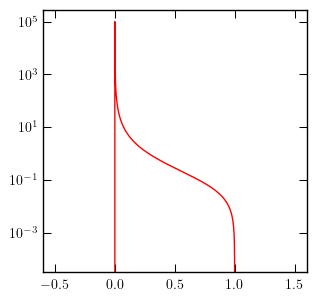

In [34]:
# Plot the target distribution

fig, ax = newplot("column")

xs = np.linspace(-0.5, 1.5, 1000)
ys = target_p(torch.tensor(xs)).detach().numpy()
ax.plot(xs, ys, label="LL Angularity", color = "red")

plt.yscale("log")


In [35]:
import torch
from torch import Tensor
from torch.distributions import constraints
from zuko.transforms import Transform


class AffineSigmoid(Transform):
    r"""
    Affine Sigmoid transformation that maps from real numbers to the interval (a, b).

    Arguments:
        a (float): The lower bound of the interval.
        b (float): The upper bound of the interval.
    """

    bijective = True

    def __init__(self, a: float, b: float, **kwargs):
        super().__init__(**kwargs)
        self.a = a
        self.b = b
        self.domain = constraints.real
        self.codomain = constraints.interval(a, b)

    def _call(self, x: Tensor) -> Tensor:
        # Forward transformation: x in R -> y in (a, b)
        s = torch.sigmoid(x)
        y = self.a + (self.b - self.a) * s
        return y

    def _inverse(self, y: Tensor) -> Tensor:
        # Inverse transformation: y in (a, b) -> x in R
        s = (y - self.a) / (self.b - self.a)
        x = torch.log(s) - torch.log1p(-s)
        return x

    def log_abs_det_jacobian(self, x: Tensor, y: Tensor) -> Tensor:
        # Log absolute determinant of the Jacobian
        sigma_x = torch.sigmoid(x)
        log_det = torch.log(self.b - self.a) + torch.log(sigma_x) + torch.log1p(-sigma_x)
        return log_det

In [36]:
from zuko.distributions import DiagNormal
from zuko.flows import UnconditionalDistribution

# Initialize the flow

# Can choose: NSF, MAF, NICE
flow = zuko.flows.NSF(features = auxiliary_params + 1, context=1, transforms= num_transforms, hidden_features=hidden_features)

# # Hack to make the flow bounded between 0 and 1
# flow = zuko.flows.Flow(transform = [flow, AffineSigmoid(0,1)], base =UnconditionalDistribution(
#         DiagNormal,
#         torch.zeros(3),
#         torch.ones(3),
#         buffer=True,
#     ),)

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

def inverse_sigmoid(x):
    return torch.log(x / (1 - x))

def log_abs_det_jacobian_sigmoid(x,):
    sigma = sigmoid(x)
    return torch.abs(torch.log(sigma) + torch.log(1 - sigma))

def counting_parameter(x, C = 1):
    return C * alpha_s(E0 * x) * torch.log(1/x) / x 


print(flow)

# print list of all attributes of the flow
print(flow.__dict__.keys())

optimizer = torch.optim.Adam(flow.parameters(), lr=lr)


pytorch_total_params = sum(p.numel() for p in flow.parameters() if p.requires_grad)
print(f"Numb. trainable params: {pytorch_total_params}")


NSF(
  (transform): LazyComposedTransform(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=3, out_features=32, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=32, out_features=32, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=32, out_features=46, bias=True)
      )
    )
    (1): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [1, 0]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=3, out_features=32, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=32, out_features=32, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=32, out_features=46, bias=True)
      )
    )
    (2): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_featur

In [37]:
# Training Loop

PLOT_EACH_EPOCH = False
t = tqdm(range(epochs))
losses = []
training_cs = []
logps = []
logqs = []
logJs = []
xss = []

for epoch in t:

    c = torch.rand(1) * (x_range[1] - x_range[0]) + x_range[0]


    if MODE == "GENERATED_SAMPLES":



        xs = sigmoid(flow(c).sample((batch_size,)))
        logJ = torch.sum(log_abs_det_jacobian_sigmoid(inverse_sigmoid(xs)), axis = 1)
        logq = flow(c).log_prob(inverse_sigmoid(xs)) + logJ
        logp = torch.nan_to_num(torch.log(target_p(xs))[:,0])

        if LOSS == "FORWARD":
            raise NotImplementedError("Impossible to do a forward KL loss with generated samples!")

        # Can only do reverse
        loss = torch.nanmean(Theta(xs[:,0] - c) * (logq - logp))

    

    # Used to be called "REVERSE" / "No samples"
    if MODE == "UNIFORM_SAMPLES":

        # Generate a random cutoff c

        xs = torch.rand(batch_size, auxiliary_params + 1)  * (x_range[1] - x_range[0]) + x_range[0]
        # xs[:,0] = xs[:,0] * (1 - c) + c
        # xs = torch.zeros(batch_size, auxiliary_params + 1) 
        # xs[:,0] = torch.linspace(0.001, 0.999, batch_size)

        # Auxillary variable -- uniform. alternatively set to const
        if auxiliary_params > 0:
            xs[:,1:] = torch.rand(batch_size, auxiliary_params)
            # xs[:,1] = torch.linspace(0.001, 0.999, batch_size)

    

        # Note for log_prob to work, we need to pass a tensor of shape (batch_size, >=1)
        logJ = torch.sum(log_abs_det_jacobian_sigmoid(inverse_sigmoid(xs)), axis = 1)
        logq = (((flow(c).log_prob(inverse_sigmoid(xs)) + logJ)))
        logp = torch.nan_to_num(torch.log(target_p(xs))[:,0])
        # technically need to adjust logp if aux is anything other than U(0,1)

        # Bou
        allowed_error = counting_parameter(xs[:,0], C = 100) ** 2
        # loss = torch.nanmean(Theta(xs[:,0] - c)  * (logp - logq)**2 ) 

        # For forward, do plog(p/q), for reverse do qlog(q/p)

        norm_p = torch.nanmean(Theta(xs[:,0] - c) * torch.exp(logp)) 
        norm_q = torch.nanmean(Theta(xs[:,0] - c) * torch.exp(logq)) 

        logp_prime = logp - torch.nan_to_num(1*torch.log(norm_p))
        logq_prime = logq - torch.nan_to_num(1*torch.log(norm_q))


        if LOSS == "FORWARD":
            loss = torch.nanmean(Theta(xs[:,0] - c) * torch.exp(logp_prime) * (logp_prime - logq_prime ))

        if LOSS == "REVERSE":
            loss = torch.nanmean(Theta(xs[:,0] - c) * torch.exp(logq_prime) * (logq_prime - logp_prime ))

        if LOSS == "logMSE":
            loss = torch.nanmean(Theta(xs[:,0] - c) * (logp - logq)**2 )

        if DEBUG:
            print(f"Loss: {loss.item()}")
            print(f"c: {c.item()}")
            # print(f"Norm p: {norm_p.item()}, Total p: {torch.nanmean(torch.exp(logp)).item()}")
            # print(f"Norm q: {norm_q.item()}, Total q: {torch.nanmean(torch.exp(logq)).item()}")
            # print(f"Mearn norm error: {torch.nanmean(Theta(xs[:,0] - c) * torch.exp(logp_prime) * torch.log(norm_q / norm_p)).item()}")
            # print(f"Mean error: {torch.nanmean(Theta(xs[:,0] - c) * torch.exp(logp_prime) * (logp - logq)).item()}")
            print(f"logp: {logp[:5]}")
            print(f"logq: {logq[:5]}")
            print()

            logps.append(logp)
            logqs.append(logq)
            logJs.append(logJ)
            xss.append(xs)
            

    loss.backward()

    if PLOT_EACH_EPOCH:
        if epoch % 1 == 0:
            fig, ax = newplot("column")

            ys = torch.exp(logp).detach().numpy()
            ax.scatter(xs[:,0], ys, label="Target", color = "red")

            ys = torch.exp(logq).detach().numpy()
            ax.scatter(xs[:,0], ys, label="Flow", color = "blue")
            plt.yscale("log")   
            plt.legend()

            plt.show()


    # Gradient Descent
    optimizer.step()
    optimizer.zero_grad()


    training_cs.append(c.item())
    losses.append(loss.item())
    t.set_description(f"Loss: {loss.item()}")



Loss: 3.686845064163208:   0%|          | 1/1250 [00:00<12:30,  1.66it/s]

Loss: 3.686845064163208
c: 0.5265254378318787
logp: tensor([-3.6249, -0.6492, -1.9487,  0.4984, -2.5180])
logq: tensor([-2.2976,  0.3898, -5.7455,  0.8604, -9.8349], grad_fn=<SliceBackward0>)

Loss: 1.7090489864349365
c: 0.898777425289154
logp: tensor([-3.2012,  0.7335,  0.5532,  2.0250,  2.4477])
logq: tensor([-1.7599, -0.8482, -8.2826,  0.7423, -2.5517], grad_fn=<SliceBackward0>)



Loss: 3.8341047763824463:   0%|          | 3/1250 [00:01<10:43,  1.94it/s]

Loss: 3.8341047763824463
c: 0.49296998977661133
logp: tensor([ 1.2643,  0.1673, -4.1964, -1.8475, -0.5250])
logq: tensor([-0.6083,  1.5537, -2.9782,  0.3265,  0.9803], grad_fn=<SliceBackward0>)



Loss: 2.4607362747192383:   0%|          | 4/1250 [00:01<08:23,  2.47it/s]

Loss: 2.4607362747192383
c: 0.7979500889778137
logp: tensor([-0.7175,  1.3632, -5.0436, -2.7129,  0.0000])
logq: tensor([  1.5334,   1.2815, -13.6076,  -0.2001, -45.6555],
       grad_fn=<SliceBackward0>)



Loss: 1.471523404121399:   0%|          | 5/1250 [00:02<07:14,  2.87it/s] 

Loss: 1.471523404121399
c: 0.882476270198822
logp: tensor([-2.5037, -4.0075, -3.0504,  0.0818, -0.9193])
logq: tensor([-3.6596, -2.3045, -0.7083,  0.7798,  0.6911], grad_fn=<SliceBackward0>)



Loss: 4.606848239898682:   0%|          | 6/1250 [00:02<06:11,  3.35it/s]

Loss: 4.606848239898682
c: 0.24172133207321167
logp: tensor([-0.6267, -3.4736,  0.0644,  0.0686, -0.7392])
logq: tensor([ 1.3058, -4.0377,  0.7224, -4.1980,  1.6325], grad_fn=<SliceBackward0>)

Loss: 1.7422422170639038
c: 0.8176209926605225
logp: tensor([-2.2939,  2.1639,  0.3795, -3.2130, -0.2346])
logq: tensor([-1.2567,  0.1787, -4.3281, -2.3230,  1.5130], grad_fn=<SliceBackward0>)



Loss: 3.4543135166168213:   1%|          | 8/1250 [00:02<04:48,  4.30it/s]

Loss: 3.4543135166168213
c: 0.37538760900497437
logp: tensor([-2.7749, -1.0541, -2.8988, -0.1886, -2.7668])
logq: tensor([-0.6371,  0.6754, -1.3665,  0.6530, -0.7432], grad_fn=<SliceBackward0>)



Loss: 4.3233771324157715:   1%|          | 9/1250 [00:02<05:36,  3.69it/s]

Loss: 4.3233771324157715
c: 0.2728654146194458
logp: tensor([-0.4719, -2.6270, -0.6787, -1.6085, -0.1146])
logq: tensor([ 1.2015, -0.5548,  1.0623, -0.5424,  1.0044], grad_fn=<SliceBackward0>)

Loss: 0.3811848759651184
c: 0.9435948729515076
logp: tensor([-4.4665, -2.3959,  2.9798,  0.2445, -2.9908])
logq: tensor([-2.7904, -1.1790, -0.9441,  0.9983, -2.0352], grad_fn=<SliceBackward0>)



Loss: 2.1997690200805664:   1%|          | 11/1250 [00:03<06:25,  3.21it/s]

Loss: 2.1997690200805664
c: 0.6082534790039062
logp: tensor([-1.5853, -0.6993, -3.3815, -2.0783,  0.6833])
logq: tensor([-0.3905, -0.4611, -2.7107, -0.8482, -1.5900], grad_fn=<SliceBackward0>)

Loss: 4.22736120223999
c: 0.3845183849334717
logp: tensor([ 1.0669,  2.9119, -1.1867,  2.8709, -3.8034])
logq: tensor([ 0.1858, -7.6860, -0.4468, -1.6987, -2.4334], grad_fn=<SliceBackward0>)



Loss: 1.7103495597839355:   1%|          | 13/1250 [00:04<05:24,  3.81it/s]

Loss: 1.7103495597839355
c: 0.7287110090255737
logp: tensor([ 1.0504, -3.6441, -0.9154, -2.9038, -0.5233])
logq: tensor([ 0.4035, -4.0587, -0.2705, -2.0803, -0.7326], grad_fn=<SliceBackward0>)



Loss: 6.555936813354492:   1%|          | 14/1250 [00:04<05:12,  3.96it/s] 

Loss: 6.555936813354492
c: 0.01942908763885498
logp: tensor([ 3.1862, -0.1699, -2.0254, -4.2226, -1.1684])
logq: tensor([ 0.0949,  2.0979, -1.6242, -2.9834, -0.7151], grad_fn=<SliceBackward0>)

Loss: 2.7490928173065186
c: 0.602144718170166
logp: tensor([-0.8180, -0.3521, -0.7979, -1.2614,  1.1128])
logq: tensor([-0.7105,  1.2172, -1.4394, -0.1233,  0.1464], grad_fn=<SliceBackward0>)



Loss: 5.991145610809326:   1%|▏         | 16/1250 [00:04<03:57,  5.19it/s] 

Loss: 5.991145610809326
c: 0.1391497254371643
logp: tensor([-1.1719, -4.3215,  2.3942, -1.9372, -2.8051])
logq: tensor([-1.7519, -4.4813,  0.6730, -0.6558, -1.7494], grad_fn=<SliceBackward0>)

Loss: 3.0331528186798096
c: 0.5058346390724182
logp: tensor([-2.9950,  0.0321, -2.7333, -2.3623, -1.4093])
logq: tensor([-1.8173,  1.0879, -1.1240, -8.4572, -0.8470], grad_fn=<SliceBackward0>)



Loss: 1.8709099292755127:   1%|▏         | 18/1250 [00:04<03:12,  6.38it/s]

Loss: 1.8709099292755127
c: 0.5789671540260315
logp: tensor([-1.7633,  2.8577,  3.5655,  3.4947,  1.3660])
logq: tensor([-1.1427, -0.3206, -1.4255, -0.9583,  0.0307], grad_fn=<SliceBackward0>)

Loss: 2.0044047832489014
c: 0.470245361328125
logp: tensor([-0.4367, -2.9052, -0.7371, -3.9370, -1.5669])
logq: tensor([ 1.4204, -2.1624, -0.1653, -2.9382, -0.4579], grad_fn=<SliceBackward0>)



Loss: 2.0044047832489014:   2%|▏         | 19/1250 [00:05<03:18,  6.19it/s]

Loss: 0.7819308042526245
c: 0.9832689762115479
logp: tensor([ 2.3093,  0.8071, -1.8436, -0.5171, -3.1873])
logq: tensor([ 0.6733,  1.3193, -0.9614,  0.1100, -3.2883], grad_fn=<SliceBackward0>)



Loss: 4.048547744750977:   2%|▏         | 21/1250 [00:06<06:17,  3.25it/s] 

Loss: 4.048547744750977
c: 0.12710177898406982
logp: tensor([-2.5491,  0.8585, -2.8052, -1.2388, -0.5206])
logq: tensor([-1.4146,  1.0564, -2.8013, -1.1745, -0.3114], grad_fn=<SliceBackward0>)



Loss: 0.45522069931030273:   2%|▏         | 22/1250 [00:06<05:29,  3.73it/s]

Loss: 0.45522069931030273
c: 0.8909868597984314
logp: tensor([-0.5730, -3.5092, -0.7257, -2.4169,  4.4980])
logq: tensor([ 0.2302, -3.7901, -0.2132, -1.4572, -3.9838], grad_fn=<SliceBackward0>)



Loss: 0.4037349820137024:   2%|▏         | 23/1250 [00:06<05:09,  3.97it/s] 

Loss: 0.4037349820137024
c: 0.9635845422744751
logp: tensor([-1.5272, -0.4270,  0.1575, -2.4822, -0.7899])
logq: tensor([-1.3072, -0.0312, -1.0362, -1.9080, -0.5033], grad_fn=<SliceBackward0>)

Loss: 2.176403045654297
c: 0.3458862900733948
logp: tensor([-6.2876, -2.6355, -0.5907, -0.9987, -2.2936])
logq: tensor([-7.8321, -2.1148,  0.2239, -0.8395, -1.1241], grad_fn=<SliceBackward0>)



Loss: 1.2270559072494507:   2%|▏         | 25/1250 [00:06<04:14,  4.82it/s]

Loss: 1.2270559072494507
c: 0.8455369472503662
logp: tensor([ 4.1576, -1.4229, -3.2053,  1.1842, -2.3834])
logq: tensor([-15.2739,  -1.0378,  -3.1856,   1.1197,  -2.5156],
       grad_fn=<SliceBackward0>)



Loss: 0.5958845019340515:   2%|▏         | 26/1250 [00:07<05:48,  3.52it/s]

Loss: 0.5958845019340515
c: 0.8633977174758911
logp: tensor([ 0.0769, -1.1396, -1.4648,  0.8232, -0.0126])
logq: tensor([ 1.0906, -3.5086, -1.1154,  1.5458,  0.8853], grad_fn=<SliceBackward0>)



Loss: 0.722621500492096:   2%|▏         | 27/1250 [00:07<05:27,  3.74it/s] 

Loss: 0.722621500492096
c: 0.8801106810569763
logp: tensor([-1.4448, -0.3394, -2.8652, -1.1282,  0.5416])
logq: tensor([-1.0525,  0.9927, -2.8249, -0.9732,  0.6064], grad_fn=<SliceBackward0>)

Loss: 7.831723213195801
c: 0.014426231384277344
logp: tensor([ 0.8472,  1.5485,  2.7677, -3.2989,  2.7885])
logq: tensor([ 0.8447, -2.8312,  0.7528, -2.8663, -0.4492], grad_fn=<SliceBackward0>)



Loss: 0.7323889136314392:   2%|▏         | 30/1250 [00:07<03:29,  5.82it/s]

Loss: 3.716461658477783
c: 0.30602961778640747
logp: tensor([-0.7091, -1.2595, -0.0074, -2.4659, -0.5098])
logq: tensor([ -0.3927, -47.1830,  -1.0165,  -2.0913,   0.3670],
       grad_fn=<SliceBackward0>)

Loss: 0.7323889136314392
c: 0.8429225087165833
logp: tensor([ 0.8677, -2.0428, -4.5824, -2.3607, -3.1936])
logq: tensor([ 0.7228, -1.9083, -4.8836, -1.9089, -3.2859], grad_fn=<SliceBackward0>)



Loss: 1.2513915300369263:   2%|▏         | 31/1250 [00:08<03:26,  5.90it/s]

Loss: 1.2513915300369263
c: 0.8981887698173523
logp: tensor([ 1.5093,  2.3201, -1.7156, -1.6859, -4.1880])
logq: tensor([ 1.1573,  1.3033, -1.3687, -1.6533, -4.4733], grad_fn=<SliceBackward0>)

Loss: 2.649632453918457
c: 0.4043310284614563
logp: tensor([ 0.1376, -1.5391, -1.7228,  7.0096, -1.5134])
logq: tensor([ -1.1860,  -1.4360,  -1.5935, -10.7629,  -1.2507],
       grad_fn=<SliceBackward0>)



Loss: 1.3785351514816284:   3%|▎         | 33/1250 [00:09<06:40,  3.04it/s]

Loss: 1.3785351514816284
c: 0.5935271382331848
logp: tensor([-1.7018, -2.4147,  1.2007,  0.6446, -3.0266])
logq: tensor([-1.7194, -2.1183,  1.0846,  1.7893, -3.2980], grad_fn=<SliceBackward0>)



Loss: 4.08412504196167:   3%|▎         | 34/1250 [00:09<05:46,  3.51it/s]  

Loss: 4.08412504196167
c: 0.47876161336898804
logp: tensor([ 2.9083,  0.8029, -3.6127, -2.6830, -1.9903])
logq: tensor([-0.1384,  1.2693, -3.8039, -2.3338, -1.9280], grad_fn=<SliceBackward0>)

Loss: 2.8439273834228516
c: 0.5535780787467957
logp: tensor([-1.2210,  1.9067, -2.0468, -3.9324,  0.1507])
logq: tensor([-1.3542,  1.5240, -2.0470, -4.0155,  1.0846], grad_fn=<SliceBackward0>)



Loss: 3.625642776489258:   3%|▎         | 36/1250 [00:09<04:22,  4.62it/s] 

Loss: 3.625642776489258
c: 0.1191055178642273
logp: tensor([-1.1298, -2.3101, -0.3522, -1.7164,  0.4319])
logq: tensor([-1.1261, -2.1404, -3.7260, -1.7721,  1.8769], grad_fn=<SliceBackward0>)



Loss: 5.038711071014404:   3%|▎         | 37/1250 [00:09<04:17,  4.72it/s]

Loss: 5.038711071014404
c: 0.015847325325012207
logp: tensor([-4.5940, -0.1512,  3.7389, -0.7079, -2.4220])
logq: tensor([-4.3007,  0.5871, -0.9892,  0.1732, -2.2286], grad_fn=<SliceBackward0>)

Loss: 2.4109201431274414
c: 0.13758724927902222
logp: tensor([ 0.0143, -3.5554, -3.0289,  2.6369,  1.1861])
logq: tensor([ 0.6779, -3.6873, -4.9567,  0.4352,  0.5966], grad_fn=<SliceBackward0>)



Loss: 2.4109201431274414:   3%|▎         | 38/1250 [00:09<04:25,  4.57it/s]

Loss: 2.9753286838531494
c: 0.14223182201385498
logp: tensor([ 6.2141,  1.9011, -3.8359, -3.0261, -2.2288])
logq: tensor([ -8.6471,   1.1924,  -4.8256,  -3.4591, -11.3237],
       grad_fn=<SliceBackward0>)



Loss: 2.639686346054077:   3%|▎         | 41/1250 [00:10<04:39,  4.33it/s] 

Loss: 0.6643214225769043
c: 0.6051861047744751
logp: tensor([-1.2316, -1.3468, -2.4819, -1.1339,  1.1164])
logq: tensor([-1.4368, -1.9739, -2.5251, -1.1027,  1.0115], grad_fn=<SliceBackward0>)

Loss: 2.639686346054077
c: 0.1764453649520874
logp: tensor([-2.5113,  0.8460, -1.4322,  1.5837, -4.4267])
logq: tensor([-2.0334, -0.1552, -1.4756,  1.0584, -4.2273], grad_fn=<SliceBackward0>)



Loss: 0.4347879886627197:   3%|▎         | 42/1250 [00:10<03:54,  5.16it/s]

Loss: 0.4347879886627197
c: 0.9674783945083618
logp: tensor([-1.4300, -3.7506, -0.7155, -1.4501, -8.1892])
logq: tensor([ -1.3605,  -4.1165,  -1.0019,  -1.7522, -15.7915],
       grad_fn=<SliceBackward0>)

Loss: 3.9542219638824463
c: 0.06492269039154053
logp: tensor([-0.1008, -2.2889, -1.8135, -3.6649, -2.0779])
logq: tensor([ 0.7912, -2.3697, -1.7748, -3.8354, -1.3870], grad_fn=<SliceBackward0>)



Loss: 1.7330410480499268:   4%|▎         | 45/1250 [00:11<04:23,  4.58it/s]

Loss: 2.7090883255004883
c: 0.08533811569213867
logp: tensor([-5.6790, -3.5827, -0.8617, -0.4675,  2.5752])
logq: tensor([-6.5715, -3.4760, -0.7129, -2.9949,  1.3365], grad_fn=<SliceBackward0>)

Loss: 1.7330410480499268
c: 0.2494831085205078
logp: tensor([-4.3467,  1.1163, -1.8968, -3.1095, -1.9477])
logq: tensor([-4.6340,  1.0057, -1.9446, -2.9775, -1.7500], grad_fn=<SliceBackward0>)



Loss: 0.8011649250984192:   4%|▎         | 46/1250 [00:11<03:53,  5.15it/s]

Loss: 0.8011649250984192
c: 0.8850041627883911
logp: tensor([-2.4021, -2.1157, -1.6045, -1.3790, -1.2569])
logq: tensor([ -2.2429,  -2.0978,  -1.9817, -11.5465,  -1.1601],
       grad_fn=<SliceBackward0>)

Loss: 1.4316964149475098
c: 0.47241103649139404
logp: tensor([-4.2988,  2.4343,  1.6773, -2.5595,  2.4142])
logq: tensor([-4.6180, -8.0825,  1.2221, -1.8190,  1.7218], grad_fn=<SliceBackward0>)



Loss: 2.2448344230651855:   4%|▍         | 49/1250 [00:12<02:56,  6.81it/s]

Loss: 1.0939863920211792
c: 0.555055558681488
logp: tensor([-0.7890, -1.5737,  0.6621, -7.6997, -1.6962])
logq: tensor([ -1.2259,  -1.5543,   1.1227, -13.2261,  -2.0375],
       grad_fn=<SliceBackward0>)

Loss: 2.2448344230651855
c: 0.4239709973335266
logp: tensor([-1.9932, -0.5132,  2.7142, -1.0065,  1.6970])
logq: tensor([-1.8203, -0.3519,  1.3126, -1.3351,  1.1365], grad_fn=<SliceBackward0>)



Loss: 2.274186611175537:   4%|▍         | 50/1250 [00:12<03:22,  5.94it/s] 

Loss: 2.274186611175537
c: 0.32221245765686035
logp: tensor([-2.3997, -0.3935, -0.3133, -1.3228, -1.4189])
logq: tensor([-2.5047, -0.1360,  0.0526, -1.3896, -1.4725], grad_fn=<SliceBackward0>)



Loss: 0.681048572063446:   4%|▍         | 51/1250 [00:12<03:14,  6.17it/s]

Loss: 0.681048572063446
c: 0.9514025449752808
logp: tensor([-1.2955,  2.4934, -4.8500, -0.7245,  1.7719])
logq: tensor([-1.5888,  1.6343, -4.8223, -0.5527,  1.1171], grad_fn=<SliceBackward0>)

Loss: 0.8977767825126648
c: 0.7020866274833679
logp: tensor([-2.0390, -0.4790, -0.5409, -3.2360,  1.8467])
logq: tensor([-2.2962, -0.4975, -0.3778, -3.2065,  1.1201], grad_fn=<SliceBackward0>)



Loss: 0.9114322662353516:   4%|▍         | 53/1250 [00:13<04:06,  4.86it/s]

Loss: 0.9114322662353516
c: 0.6843987107276917
logp: tensor([ 3.3864, -2.3722, -0.0403, -6.6862, -1.5223])
logq: tensor([ 1.2987, -2.4938,  0.5869, -8.2100, -1.8527], grad_fn=<SliceBackward0>)



Loss: 1.0412371158599854:   4%|▍         | 54/1250 [00:13<04:11,  4.76it/s]

Loss: 1.0412371158599854
c: 0.39842861890792847
logp: tensor([-3.8324, -2.2708, -0.7805, -1.6345, -2.7524])
logq: tensor([-3.8886, -2.3098, -0.7450, -1.9559, -2.6698], grad_fn=<SliceBackward0>)



Loss: 1.1282336711883545:   4%|▍         | 55/1250 [00:13<04:03,  4.90it/s]

Loss: 1.1282336711883545
c: 0.890298068523407
logp: tensor([-4.6310, -0.1664,  2.1094, -0.6197, -0.4623])
logq: tensor([-4.6378,  0.0626,  1.5114, -0.6851, -0.5456], grad_fn=<SliceBackward0>)



Loss: 1.299882411956787:   4%|▍         | 56/1250 [00:14<06:35,  3.02it/s] 

Loss: 1.299882411956787
c: 0.5631340742111206
logp: tensor([ 2.8432,  3.8176,  0.2137, -2.2349, -4.1607])
logq: tensor([ 1.5477, -0.3834,  0.6756, -1.9433, -4.2097], grad_fn=<SliceBackward0>)



Loss: 3.820646047592163:   5%|▍         | 57/1250 [00:14<07:41,  2.58it/s]

Loss: 3.820646047592163
c: 0.1809380054473877
logp: tensor([-3.8543,  0.9731, -2.6116, -2.1897, -2.2587])
logq: tensor([-2.8160,  0.9309, -2.7035, -1.6350, -2.2389], grad_fn=<SliceBackward0>)



Loss: 0.9688452482223511:   5%|▍         | 58/1250 [00:14<06:22,  3.12it/s]

Loss: 0.9688452482223511
c: 0.7306857705116272
logp: tensor([-0.3469,  1.0166, -0.7864, -4.3598, -1.8080])
logq: tensor([ 0.1037,  0.5845, -0.1629, -4.1662, -1.6966], grad_fn=<SliceBackward0>)

Loss: 2.7943637371063232
c: 0.26703935861587524
logp: tensor([-2.9719,  3.6226, -0.5321, -1.7049,  0.4075])
logq: tensor([-1.9106,  0.0864, -0.4195, -1.4829, -1.0561], grad_fn=<SliceBackward0>)



Loss: 1.6235276460647583:   5%|▍         | 61/1250 [00:15<04:12,  4.71it/s]

Loss: 1.5622409582138062
c: 0.3536824584007263
logp: tensor([ 0.1187, -1.6435,  2.1016, -3.3215, -1.7080])
logq: tensor([ 0.6810, -1.4200,  1.7002, -2.8484, -1.8273], grad_fn=<SliceBackward0>)

Loss: 1.6235276460647583
c: 0.3299793601036072
logp: tensor([-0.7572, -0.0700,  1.2580, -2.5734, -2.2813])
logq: tensor([-0.5488,  0.5301,  1.0610, -2.3643, -1.9756], grad_fn=<SliceBackward0>)



Loss: 0.9792352914810181:   5%|▍         | 62/1250 [00:15<03:48,  5.20it/s]

Loss: 0.9792352914810181
c: 0.7003684043884277
logp: tensor([-0.9331, -4.4811,  2.7896, -4.8352, -1.1205])
logq: tensor([-1.2015, -4.5885,  1.5304, -4.6679, -1.4189], grad_fn=<SliceBackward0>)



Loss: 1.1769944429397583:   5%|▌         | 63/1250 [00:15<04:02,  4.89it/s]

Loss: 1.1769944429397583
c: 0.7807952761650085
logp: tensor([-2.3930, -1.4036, -1.6250, -4.7920, -1.5373])
logq: tensor([-2.1195, -1.4080, -1.7488, -4.5801, -1.7314], grad_fn=<SliceBackward0>)



Loss: 0.8894495964050293:   5%|▌         | 64/1250 [00:15<04:07,  4.78it/s]

Loss: 0.8894495964050293
c: 0.796191930770874
logp: tensor([-4.0696, -1.9047, -3.9366, -3.1606, -2.0348])
logq: tensor([-4.1154, -1.9290, -3.9210, -3.4186, -2.0436], grad_fn=<SliceBackward0>)



Loss: 1.0283644199371338:   5%|▌         | 65/1250 [00:16<06:13,  3.17it/s]

Loss: 1.0283644199371338
c: 0.8450337648391724
logp: tensor([-0.6545, -1.0271,  1.0360, -3.2113, -2.8288])
logq: tensor([-0.4067, -1.1482,  1.2893, -3.4115, -2.9373], grad_fn=<SliceBackward0>)

Loss: 1.8890087604522705
c: 0.17003440856933594
logp: tensor([-0.1201,  3.9233, -1.2148, -2.5986, -0.6073])
logq: tensor([ 0.1943,  0.0770, -0.7703, -2.3932, -0.4876], grad_fn=<SliceBackward0>)



Loss: 1.4582202434539795:   5%|▌         | 67/1250 [00:16<05:06,  3.85it/s]

Loss: 1.4582202434539795
c: 0.38822507858276367
logp: tensor([ 2.8109, -0.9145, -1.7317,  0.7095,  1.7428])
logq: tensor([-0.4317, -1.1550, -2.1353,  0.7018,  0.8677], grad_fn=<SliceBackward0>)



Loss: 1.0728261470794678:   5%|▌         | 68/1250 [00:17<04:58,  3.96it/s]

Loss: 1.0728261470794678
c: 0.4117782711982727
logp: tensor([ 2.2857, -0.6558, -0.6933, -2.1099,  9.8146])
logq: tensor([  2.3981,  -3.3995,  -0.8641,  -2.2605, -18.8780],
       grad_fn=<SliceBackward0>)



Loss: 1.5951838493347168:   6%|▌         | 69/1250 [00:17<04:40,  4.22it/s]

Loss: 1.5951838493347168
c: 0.34728002548217773
logp: tensor([-0.9479,  1.0652, -4.5239, -2.3894,  0.9263])
logq: tensor([-0.6311, -0.5883, -4.1041, -2.6531,  1.6210], grad_fn=<SliceBackward0>)

Loss: 0.5451697707176208
c: 0.859675943851471
logp: tensor([-0.5747, -1.7839, -2.5265, -3.6086, -1.8051])
logq: tensor([-0.1516, -1.2689, -2.8369, -3.8244, -2.1364], grad_fn=<SliceBackward0>)



Loss: 0.7550204396247864:   6%|▌         | 71/1250 [00:17<04:00,  4.90it/s]

Loss: 0.7550204396247864
c: 0.9595842957496643
logp: tensor([-2.9394, -3.8071, -2.8465, -0.7955, -2.3188])
logq: tensor([-3.2142, -3.9535, -2.9255, -0.9271, -2.0833], grad_fn=<SliceBackward0>)

Loss: 3.619503974914551
c: 0.05904489755630493
logp: tensor([ 3.3488, -0.5261, -2.0344, -3.9476, -1.5446])
logq: tensor([-1.7059, -0.4170, -2.3060, -3.7896, -1.7861], grad_fn=<SliceBackward0>)



Loss: 1.026973009109497:   6%|▌         | 73/1250 [00:18<04:34,  4.29it/s] 

Loss: 1.026973009109497
c: 0.6492722630500793
logp: tensor([-4.0025, -3.0026, -2.1294, -1.7493, -0.5134])
logq: tensor([-3.8122, -2.7711, -1.9804, -1.5124, -0.5152], grad_fn=<SliceBackward0>)



Loss: 1.1067427396774292:   6%|▌         | 74/1250 [00:18<04:53,  4.01it/s]

Loss: 1.1067427396774292
c: 0.5630269050598145
logp: tensor([ 1.4193, -2.3335,  1.1170, -3.4661,  0.6329])
logq: tensor([ 1.1542, -2.4932,  0.9477, -3.1129,  1.6903], grad_fn=<SliceBackward0>)

Loss: 1.900290608406067
c: 0.182220458984375
logp: tensor([-5.1269, -2.7332,  0.2772, -2.4741, -1.0872])
logq: tensor([-5.0292, -2.7906,  0.8956, -2.5570, -1.0754], grad_fn=<SliceBackward0>)



Loss: 2.2198171615600586:   6%|▌         | 75/1250 [00:19<07:17,  2.69it/s]

Loss: 2.2198171615600586
c: 0.2421596646308899
logp: tensor([-1.7832, -2.5262, -0.0476, -3.0060, -0.7239])
logq: tensor([-2.0548, -2.7158,  0.3572, -3.2361, -0.6339], grad_fn=<SliceBackward0>)



Loss: 4.419559478759766:   6%|▌         | 78/1250 [00:19<04:49,  4.05it/s] 

Loss: 0.6303995251655579
c: 0.8383076786994934
logp: tensor([-0.4904, -2.4449,  2.8790, -4.5752, -3.7303])
logq: tensor([-0.6040, -2.5619,  1.9269, -4.6510, -3.8349], grad_fn=<SliceBackward0>)

Loss: 4.419559478759766
c: 0.030740559101104736
logp: tensor([ 0.4065, -2.6169, -0.7012, -1.3652, -1.6421])
logq: tensor([-1.2558, -2.6944, -0.8932, -1.5185, -2.2265], grad_fn=<SliceBackward0>)



Loss: 3.093122959136963:   6%|▋         | 80/1250 [00:19<03:35,  5.44it/s] 

Loss: 0.8087115287780762
c: 0.9341831207275391
logp: tensor([-2.3868, -1.1785, -2.8398,  0.4189, -0.5771])
logq: tensor([-2.3783, -1.3654, -3.0635,  0.9607, -0.7643], grad_fn=<SliceBackward0>)

Loss: 3.093122959136963
c: 0.12779837846755981
logp: tensor([-2.1567, -2.7699, -3.2591, -0.7666, -2.9624])
logq: tensor([-2.0293, -2.9417, -3.4279, -0.9181, -3.0800], grad_fn=<SliceBackward0>)



Loss: 2.850437641143799:   6%|▋         | 81/1250 [00:20<03:20,  5.82it/s]

Loss: 2.850437641143799
c: 0.17602312564849854
logp: tensor([-1.3332e+00, -8.8087e-04, -4.1273e+00, -1.8290e+00, -1.9990e+00])
logq: tensor([-1.5203, -0.0149, -4.1917, -1.8295, -2.2812], grad_fn=<SliceBackward0>)

Loss: 1.3591341972351074
c: 0.5317283868789673
logp: tensor([ 2.0070, -1.5593, -0.5262, -1.3096, -4.6903])
logq: tensor([ 0.7668, -1.5703, -0.6211, -1.4452, -4.5585], grad_fn=<SliceBackward0>)



Loss: 1.2246811389923096:   7%|▋         | 83/1250 [00:20<04:14,  4.59it/s]

Loss: 1.2246811389923096
c: 0.5432079434394836
logp: tensor([-0.7465, -3.6692,  5.7898,  1.9351, -0.6342])
logq: tensor([-0.5992, -3.2314, -7.8996,  0.6553, -0.8904], grad_fn=<SliceBackward0>)

Loss: 1.3944560289382935
c: 0.24604374170303345
logp: tensor([ 0.0203,  3.3227, -2.7592, -0.1779, -0.0128])
logq: tensor([ 0.7496,  1.7619, -2.8180,  0.3759, -1.0476], grad_fn=<SliceBackward0>)



Loss: 0.8698726296424866:   7%|▋         | 85/1250 [00:20<03:36,  5.37it/s]

Loss: 0.8698726296424866
c: 0.5127445459365845
logp: tensor([-0.8825, -0.2663,  7.5042, -3.8960, -7.7484])
logq: tensor([-1.0161e+00, -1.2248e-02, -1.3208e+01, -3.6469e+00, -1.3279e+01],
       grad_fn=<SliceBackward0>)

Loss: 1.5019553899765015
c: 0.5880179405212402
logp: tensor([-2.8188, -4.3996, -3.3766, -0.0598,  2.6239])
logq: tensor([-2.9704, -4.3706, -3.3181,  0.2720,  0.9864], grad_fn=<SliceBackward0>)



Loss: 1.4740748405456543:   7%|▋         | 87/1250 [00:21<05:14,  3.69it/s]

Loss: 1.4740748405456543
c: 0.3974531292915344
logp: tensor([-4.3669, -2.9189, -0.2728, -5.5485, -2.4156])
logq: tensor([-4.3272, -2.8255, -0.0953, -5.4742, -2.4468], grad_fn=<SliceBackward0>)

Loss: 2.8756299018859863
c: 0.04221343994140625
logp: tensor([-0.5377, -0.1447, -2.5309, -1.6071, -6.9691])
logq: tensor([-0.4503,  0.0930, -2.4105, -2.1415, -9.5417], grad_fn=<SliceBackward0>)



Loss: 1.2374781370162964:   7%|▋         | 89/1250 [00:22<04:29,  4.30it/s]

Loss: 1.2374781370162964
c: 0.6274285316467285
logp: tensor([-5.1151, -2.4178, -0.9144, -1.8424,  0.9351])
logq: tensor([-4.7514, -2.3891, -1.0192, -1.8642,  0.2338], grad_fn=<SliceBackward0>)



Loss: 1.1912685632705688:   7%|▋         | 91/1250 [00:22<03:56,  4.90it/s]

Loss: 3.1981751918792725
c: 0.3858044147491455
logp: tensor([ 1.6991,  0.3039, -2.1976, -2.9388, -1.9716])
logq: tensor([ 1.3926,  0.8614, -1.8954, -2.8502, -1.8874], grad_fn=<SliceBackward0>)

Loss: 1.1912685632705688
c: 0.5398573279380798
logp: tensor([-1.4384,  2.1611, -0.2701, -2.1588,  0.0947])
logq: tensor([-1.3378,  1.4590, -0.3333, -2.1224,  0.5439], grad_fn=<SliceBackward0>)



Loss: 1.8139314651489258:   7%|▋         | 92/1250 [00:22<03:31,  5.47it/s]

Loss: 1.8139314651489258
c: 0.5885009765625
logp: tensor([-3.1868, -0.3219, -2.7451, -1.0365, -1.3128])
logq: tensor([-3.0189, -0.1816, -2.7942, -1.2348, -1.3847], grad_fn=<SliceBackward0>)

Loss: 1.3580011129379272
c: 0.4652261734008789
logp: tensor([-2.6675, -5.7587, -2.8050, -0.8198, -1.8484])
logq: tensor([-2.2194, -6.0300, -2.8363, -0.8862, -1.6454], grad_fn=<SliceBackward0>)



Loss: 2.7914791107177734:   8%|▊         | 94/1250 [00:22<03:21,  5.75it/s]

Loss: 2.7914791107177734
c: 0.017393887042999268
logp: tensor([-3.5256, -1.0676, -3.2517,  2.2547, -0.8758])
logq: tensor([-3.2034, -1.1631, -3.0541,  1.5342, -1.0317], grad_fn=<SliceBackward0>)



Loss: 2.6023287773132324:   8%|▊         | 95/1250 [00:23<03:27,  5.56it/s]

Loss: 2.6023287773132324
c: 0.14324957132339478
logp: tensor([-1.6032, -3.3857, -5.0996, -1.5447, -1.1419])
logq: tensor([-1.6641, -3.3534, -4.7835, -1.8277, -1.2824], grad_fn=<SliceBackward0>)

Loss: 1.5278568267822266
c: 0.708666205406189
logp: tensor([-1.9147, -0.1506,  0.3826,  2.5628,  0.1713])
logq: tensor([-2.0869, -0.0763,  0.3976,  2.2676,  0.5226], grad_fn=<SliceBackward0>)



Loss: 1.5278568267822266:   8%|▊         | 96/1250 [00:23<03:19,  5.78it/s]

Loss: 3.058476686477661
c: 0.07450169324874878
logp: tensor([-2.1305, -1.6094,  2.7151,  0.8841, -2.9077])
logq: tensor([-2.0507, -1.5146,  2.2077,  1.1340, -3.0350], grad_fn=<SliceBackward0>)



Loss: 1.037258267402649:   8%|▊         | 98/1250 [00:23<04:57,  3.87it/s] 

Loss: 1.037258267402649
c: 0.45311903953552246
logp: tensor([-1.7114, -1.3510,  0.2010, -2.5899, -0.5364])
logq: tensor([-1.8929, -1.4868,  0.5280, -2.9273, -0.6852], grad_fn=<SliceBackward0>)



Loss: 2.004690170288086:   8%|▊         | 99/1250 [00:24<05:52,  3.27it/s]

Loss: 2.004690170288086
c: 0.39725857973098755
logp: tensor([-1.0445,  0.3018, -4.1342, -3.5789, -3.1623])
logq: tensor([-1.4132,  0.3638, -4.3940, -3.7342, -3.4087], grad_fn=<SliceBackward0>)



Loss: 2.8220808506011963:   8%|▊         | 100/1250 [00:24<05:25,  3.53it/s]

Loss: 2.8220808506011963
c: 0.11519002914428711
logp: tensor([-1.6856, -1.8668, -4.1799,  2.6871, -2.9281])
logq: tensor([-2.1339, -2.1146, -4.2758, -0.6147, -3.2826], grad_fn=<SliceBackward0>)

Loss: 3.1071581840515137
c: 0.17161589860916138
logp: tensor([-3.8006, -6.1151, -0.0512, -0.9136, -3.3511])
logq: tensor([-3.7810, -7.0370,  0.0849, -1.2407, -3.4325], grad_fn=<SliceBackward0>)



Loss: 2.419093132019043:   8%|▊         | 102/1250 [00:25<05:45,  3.32it/s] 

Loss: 2.419093132019043
c: 0.13654577732086182
logp: tensor([-2.1827,  0.6427, -2.5636, -1.8032, -1.9519])
logq: tensor([-2.1149,  1.2317, -2.7821, -2.1614, -1.8529], grad_fn=<SliceBackward0>)

Loss: 0.46917834877967834
c: 0.9233570694923401
logp: tensor([ 2.3971, -1.4047, -3.1655, -0.0084, -3.5599])
logq: tensor([ 1.6238, -1.2514, -2.7704,  0.0682, -3.6106], grad_fn=<SliceBackward0>)



Loss: 0.46917834877967834:   8%|▊         | 103/1250 [00:25<05:10,  3.70it/s]

Loss: 2.6245100498199463
c: 0.6211671829223633
logp: tensor([-4.2840,  3.8789,  1.3449, -2.5880, -1.3825])
logq: tensor([-4.0557,  0.3663,  1.2285, -2.3335, -1.2876], grad_fn=<SliceBackward0>)



Loss: 1.05156409740448:   8%|▊         | 105/1250 [00:26<05:36,  3.40it/s]   

Loss: 1.05156409740448
c: 0.7350230813026428
logp: tensor([ 0.6545, -1.7900, -0.2277,  0.3429, -0.8142])
logq: tensor([ 1.2868, -1.5442, -0.0407,  0.0971, -0.8353], grad_fn=<SliceBackward0>)

Loss: 1.5321506261825562
c: 0.14382052421569824
logp: tensor([-0.8191, -3.6577, -2.2260, -1.7146,  8.9798])
logq: tensor([ -0.9796,  -3.6248,  -2.2055,  -1.8407, -17.7356],
       grad_fn=<SliceBackward0>)



Loss: 2.146136522293091:   9%|▊         | 107/1250 [00:27<07:29,  2.54it/s] 

Loss: 2.146136522293091
c: 0.2623139023780823
logp: tensor([-0.3381, -0.0915, -2.2781, -1.8948, -1.2609])
logq: tensor([-0.2515,  0.0405, -2.4290, -1.4474, -1.1885], grad_fn=<SliceBackward0>)



Loss: 2.1668648719787598:   9%|▊         | 108/1250 [00:27<05:58,  3.18it/s]

Loss: 2.1668648719787598
c: 0.18668389320373535
logp: tensor([-1.3996, -1.7222, -2.2367, -0.6836, -1.4422])
logq: tensor([-1.2995, -1.6491, -2.1914, -0.6947, -1.3403], grad_fn=<SliceBackward0>)

Loss: 2.1695556640625
c: 0.28205668926239014
logp: tensor([ 0.3755, -0.7157, -0.3483, -2.3221, -3.1627])
logq: tensor([ 0.4748, -0.8260, -0.0478, -2.3497, -3.0458], grad_fn=<SliceBackward0>)



Loss: 0.3757438659667969:   9%|▉         | 110/1250 [00:27<05:24,  3.51it/s]

Loss: 0.3757438659667969
c: 0.7355296611785889
logp: tensor([-5.1285, -0.6342, -3.0436, -1.3161, -0.6326])
logq: tensor([-4.9199, -0.3728, -2.7132, -1.2017, -0.7182], grad_fn=<SliceBackward0>)

Loss: 1.204139232635498
c: 0.5408229231834412
logp: tensor([-0.8524, -0.8728, -5.9043,  0.9005,  0.5391])
logq: tensor([-1.1222, -0.8092, -5.9612,  1.3075,  0.7176], grad_fn=<SliceBackward0>)



Loss: 3.0401127338409424:   9%|▉         | 112/1250 [00:28<04:34,  4.15it/s]

Loss: 3.0401127338409424
c: 0.2592167854309082
logp: tensor([-4.6003,  3.9332, -0.9602,  1.8931, -3.9767])
logq: tensor([-4.7083,  0.6279, -0.9727,  1.5814, -3.8974], grad_fn=<SliceBackward0>)



Loss: 2.661586284637451:   9%|▉         | 113/1250 [00:28<05:04,  3.73it/s] 

Loss: 2.661586284637451
c: 0.2252146601676941
logp: tensor([-3.4236, -2.4662, -1.5562, -3.9579,  0.7476])
logq: tensor([-2.8330, -2.1693, -1.6437, -3.8975,  1.1910], grad_fn=<SliceBackward0>)

Loss: 0.7166970372200012
c: 0.4087201952934265
logp: tensor([-2.6573, -1.6671,  2.5510, -4.5996,  2.5370])
logq: tensor([-2.7424, -1.6774,  2.0573, -4.5585,  1.2830], grad_fn=<SliceBackward0>)



Loss: 0.7166970372200012:   9%|▉         | 114/1250 [00:28<04:37,  4.09it/s]

Loss: 3.339216470718384
c: 0.8633924722671509
logp: tensor([ 0.8452, -0.2765, -3.6729, -0.8290,  3.5289])
logq: tensor([ 0.6037, -0.4263, -3.6744, -0.8532,  1.7227], grad_fn=<SliceBackward0>)



Loss: 0.4986240565776825:   9%|▉         | 116/1250 [00:29<05:29,  3.44it/s]

Loss: 0.4986240565776825
c: 0.6859134435653687
logp: tensor([-8.4040,  0.3294, -2.2281,  0.6481,  0.0870])
logq: tensor([-16.6079,   0.6511,  -1.8484,   0.9056,  -0.1058],
       grad_fn=<SliceBackward0>)



Loss: 0.9730269908905029:   9%|▉         | 117/1250 [00:29<04:59,  3.78it/s]

Loss: 0.9730269908905029
c: 0.5736701488494873
logp: tensor([-1.3940, -0.9910,  0.2790, -1.3669, -2.5845])
logq: tensor([-1.3807, -0.9717,  0.2913, -1.2036, -2.8215], grad_fn=<SliceBackward0>)

Loss: 1.3379592895507812
c: 0.5948750376701355
logp: tensor([ 0.0111,  0.4173,  0.6637, -3.5284, -1.3892])
logq: tensor([-0.0286, -0.1694,  1.0147, -3.7497, -1.1836], grad_fn=<SliceBackward0>)



Loss: 3.3415186405181885:  10%|▉         | 119/1250 [00:30<05:21,  3.52it/s]

Loss: 3.3415186405181885
c: 0.4753240942955017
logp: tensor([ 0.2221,  1.3934,  0.1252, -4.3773, -1.6763])
logq: tensor([ 0.2984,  1.5118,  0.5268, -4.5568, -1.5508], grad_fn=<SliceBackward0>)



Loss: 2.864154577255249:  10%|▉         | 120/1250 [00:30<06:21,  2.96it/s] 

Loss: 2.864154577255249
c: 0.08588331937789917
logp: tensor([-0.7577,  1.4238, -0.5635, -4.3014, -2.4192])
logq: tensor([-0.8470,  1.2344, -0.7310, -4.4044, -2.6569], grad_fn=<SliceBackward0>)



Loss: 3.457921266555786:  10%|▉         | 121/1250 [00:31<07:00,  2.69it/s]

Loss: 3.457921266555786
c: 0.24034708738327026
logp: tensor([-2.4565, -5.1395, -0.6066, -0.8186, -3.6748])
logq: tensor([-2.6842, -5.0341, -0.7393, -0.9512, -3.6911], grad_fn=<SliceBackward0>)



Loss: 0.26238512992858887:  10%|▉         | 122/1250 [00:31<06:07,  3.07it/s]

Loss: 0.26238512992858887
c: 0.919304609298706
logp: tensor([-0.1162, -5.8365, -1.9904, -6.1161,  3.5556])
logq: tensor([ -0.1275, -13.5746,  -1.9433,  -6.2038,   1.5095],
       grad_fn=<SliceBackward0>)

Loss: 1.3123431205749512
c: 0.4142879247665405
logp: tensor([-2.9445,  7.1452, -5.3867, -1.6994, -1.1443])
logq: tensor([ -3.1481, -12.3487,  -4.2899,  -1.8552,  -1.4121],
       grad_fn=<SliceBackward0>)



Loss: 1.3123431205749512:  10%|▉         | 123/1250 [00:31<05:11,  3.62it/s] 

Loss: 0.32853496074676514
c: 0.9664142727851868
logp: tensor([-0.9670, -1.9657, -0.1926, -1.0701, -1.0626])
logq: tensor([-1.2438e+00, -1.8958e+00,  1.1158e-03, -7.4786e-01, -7.3836e-01],
       grad_fn=<SliceBackward0>)



Loss: 1.9045984745025635:  10%|█         | 125/1250 [00:32<07:32,  2.49it/s] 

Loss: 1.9045984745025635
c: 0.4383847117424011
logp: tensor([-2.9043,  0.3124,  0.2567, -2.8915, -1.1523])
logq: tensor([-3.0275,  0.5496,  0.4662, -2.7599, -1.1090], grad_fn=<SliceBackward0>)



Loss: 1.8780781030654907:  10%|█         | 126/1250 [00:32<06:39,  2.81it/s]

Loss: 1.8780781030654907
c: 0.501703143119812
logp: tensor([-1.0573, -3.1897, -5.4942, -2.8004, -0.1340])
logq: tensor([-1.0935, -3.2643, -5.1878, -2.7897, -0.1654], grad_fn=<SliceBackward0>)

Loss: 3.988422155380249
c: 0.30019426345825195
logp: tensor([ 2.7429, -1.6161, -1.8151, -8.5323,  1.0092])
logq: tensor([  2.0892,  -1.6652,  -1.7588, -17.3763,   1.0523],
       grad_fn=<SliceBackward0>)



Loss: 1.928223967552185:  10%|█         | 128/1250 [00:33<05:28,  3.42it/s] 

Loss: 1.928223967552185
c: 0.042938411235809326
logp: tensor([-4.5961,  0.2086,  3.5572, -3.5478, -0.8892])
logq: tensor([-10.2918,   0.5200,   0.2168,  -3.4856,  -1.0267],
       grad_fn=<SliceBackward0>)



Loss: 1.0240398645401:  10%|█         | 130/1250 [00:33<03:59,  4.67it/s]   

Loss: 0.7541214227676392
c: 0.7762371897697449
logp: tensor([-1.3143,  1.8643, -2.6608, -3.9879, -2.4355])
logq: tensor([-1.3897,  1.2910, -2.6467, -3.9404, -2.3644], grad_fn=<SliceBackward0>)

Loss: 1.0240398645401
c: 0.8692318797111511
logp: tensor([ 1.6570, -2.6884, -2.9153,  3.2361,  0.0442])
logq: tensor([ 1.4543, -2.5743, -2.8928,  2.0872,  0.3610], grad_fn=<SliceBackward0>)



Loss: 1.2533540725708008:  10%|█         | 131/1250 [00:33<03:37,  5.15it/s]

Loss: 1.2533540725708008
c: 0.22676366567611694
logp: tensor([-1.2500, -1.7884, -1.7173, -1.8881, -2.7029])
logq: tensor([-1.2547, -1.8258, -1.8098, -1.8226, -2.6531], grad_fn=<SliceBackward0>)

Loss: 6.050558567047119
c: 0.0029332637786865234
logp: tensor([ 2.4881,  0.3412, -3.9369, -0.0584, -0.7296])
logq: tensor([ 1.4722,  0.6943, -4.0139,  0.2118, -0.8177], grad_fn=<SliceBackward0>)



Loss: 3.850985527038574:  11%|█         | 133/1250 [00:33<03:02,  6.12it/s] 

Loss: 3.850985527038574
c: 0.02354717254638672
logp: tensor([-4.9557, -0.3208, -1.8090, -1.4991,  2.5163])
logq: tensor([-4.7851, -0.2296, -1.9307, -1.4323,  2.0828], grad_fn=<SliceBackward0>)

Loss: 1.4746882915496826
c: 0.3460959792137146
logp: tensor([-0.5131, -1.8686,  3.5819, -3.7459, -2.0618])
logq: tensor([-0.3729, -1.9937,  0.9366, -3.9161, -1.9095], grad_fn=<SliceBackward0>)



Loss: 1.8113212585449219:  11%|█         | 135/1250 [00:34<03:46,  4.93it/s]

Loss: 1.8113212585449219
c: 0.34073406457901
logp: tensor([ 0.0677,  0.9046,  0.6809, -6.6679, -4.4520])
logq: tensor([-0.3232,  1.3748,  0.6194, -8.8723, -4.5489], grad_fn=<SliceBackward0>)



Loss: 3.072089910507202:  11%|█         | 136/1250 [00:34<03:39,  5.07it/s] 

Loss: 3.072089910507202
c: 0.08789181709289551
logp: tensor([ 0.7621, -1.8629, -0.1730, -1.6200, -2.5344])
logq: tensor([ 0.8975, -1.8510, -0.0572, -1.6794, -2.6564], grad_fn=<SliceBackward0>)

Loss: 0.7995994091033936
c: 0.6122719645500183
logp: tensor([ 1.4947, -2.6720, -0.9348,  0.1517,  0.1041])
logq: tensor([ 1.2294, -2.7354, -1.0478,  0.0930,  0.1506], grad_fn=<SliceBackward0>)



Loss: 0.7995994091033936:  11%|█         | 137/1250 [00:34<04:16,  4.35it/s]

Loss: 1.969501256942749
c: 0.7515109777450562
logp: tensor([-0.7493, -1.5766, -1.9097, -3.8070, -3.6440])
logq: tensor([-1.0281, -1.5300, -1.8095, -3.8711, -3.5947], grad_fn=<SliceBackward0>)



Loss: 1.3516416549682617:  11%|█         | 139/1250 [00:35<06:02,  3.06it/s]

Loss: 1.3516416549682617
c: 0.2884516716003418
logp: tensor([ 2.0203, -0.1408,  0.6434, -0.2768, -2.1397])
logq: tensor([ 1.8133, -0.2022,  0.7262, -0.2788, -2.0993], grad_fn=<SliceBackward0>)

Loss: 1.862733006477356
c: 0.07669878005981445
logp: tensor([-0.6476,  4.0463, -1.8901, -0.2885, -2.4783])
logq: tensor([-0.9398,  0.7592, -1.6340, -0.3277, -2.6163], grad_fn=<SliceBackward0>)



Loss: 1.9621939659118652:  11%|█▏        | 141/1250 [00:36<05:36,  3.30it/s]

Loss: 1.9621939659118652
c: 0.13616186380386353
logp: tensor([-4.4003,  3.0709, -1.6880,  0.5255, -1.5788])
logq: tensor([-4.5737,  2.5462, -1.6321,  0.6813, -1.5946], grad_fn=<SliceBackward0>)



Loss: 2.6940488815307617:  11%|█▏        | 142/1250 [00:36<05:30,  3.36it/s]

Loss: 2.6940488815307617
c: 0.42224615812301636
logp: tensor([-2.7410, -0.4123, -1.4457,  0.5266,  0.4522])
logq: tensor([-2.7668, -0.3719, -1.4017,  0.5864,  0.5069], grad_fn=<SliceBackward0>)



Loss: 1.0439715385437012:  11%|█▏        | 143/1250 [00:37<07:40,  2.41it/s]

Loss: 1.0439715385437012
c: 0.2756693959236145
logp: tensor([ 0.1633, -0.6488,  1.1109, -2.2167,  0.2267])
logq: tensor([ 0.1387, -0.7433,  1.1666, -2.1968,  0.2768], grad_fn=<SliceBackward0>)

Loss: 4.801462650299072
c: 0.1889609694480896
logp: tensor([-0.5831, -4.7698, -2.2244, -4.1182, -1.3462])
logq: tensor([-0.7531, -4.6697, -2.2382, -3.9988, -1.3098], grad_fn=<SliceBackward0>)



Loss: 1.1443554162979126:  12%|█▏        | 145/1250 [00:38<08:10,  2.25it/s]

Loss: 1.1443554162979126
c: 0.6560357213020325
logp: tensor([-3.3779,  2.7751, -0.8106,  0.7501, -2.3915])
logq: tensor([-3.3065,  1.4719, -1.0405,  0.9159, -1.9777], grad_fn=<SliceBackward0>)



Loss: 1.4745757579803467:  12%|█▏        | 146/1250 [00:38<07:12,  2.55it/s]

Loss: 1.4745757579803467
c: 0.644347608089447
logp: tensor([ 0.4964, -5.3898, -0.9023, -1.6157, -2.7344])
logq: tensor([ 0.7150, -5.2927, -0.8820, -1.2739, -2.4709], grad_fn=<SliceBackward0>)

Loss: 0.5627356171607971
c: 0.9596678614616394
logp: tensor([-0.9835, -1.9083,  1.0595, -0.2654, -0.3122])
logq: tensor([-1.0999, -1.7493,  0.8691, -0.2024, -0.2693], grad_fn=<SliceBackward0>)



Loss: 0.9577540755271912:  12%|█▏        | 148/1250 [00:40<10:07,  1.82it/s]

Loss: 0.9577540755271912
c: 0.4936714172363281
logp: tensor([-2.4342,  3.1320, -1.0679, -1.5996, -1.9659])
logq: tensor([-1.9269,  1.4384, -1.0059, -8.8418, -1.8637], grad_fn=<SliceBackward0>)



Loss: 0.9083914756774902:  12%|█▏        | 149/1250 [00:40<08:17,  2.21it/s]

Loss: 0.9083914756774902
c: 0.6957778930664062
logp: tensor([-3.4876, -0.0310, -2.6006, -0.9775,  2.8014])
logq: tensor([-3.2225, -0.0874, -2.4434, -0.8855,  2.1477], grad_fn=<SliceBackward0>)

Loss: 2.0695877075195312
c: 0.12299764156341553
logp: tensor([-2.1971,  4.6932, -3.1983,  0.0687,  0.1733])
logq: tensor([-2.3420, -2.2919, -3.1283,  0.0675,  0.2599], grad_fn=<SliceBackward0>)



Loss: 1.4369213581085205:  12%|█▏        | 151/1250 [00:40<06:36,  2.77it/s]

Loss: 1.4369213581085205
c: 0.5040799975395203
logp: tensor([-1.8661, -2.7959,  2.1941, -2.6534,  2.3524])
logq: tensor([-1.6213, -2.5429,  1.0609, -2.5172,  1.4566], grad_fn=<SliceBackward0>)

Loss: 1.2579482793807983
c: 0.6087765097618103
logp: tensor([ 1.5812,  1.0134,  2.5231, -0.3040, -1.1336])
logq: tensor([ 0.8672,  0.9657,  1.3744, -0.3597, -1.0341], grad_fn=<SliceBackward0>)



Loss: 2.3246359825134277:  12%|█▏        | 153/1250 [00:41<08:08,  2.25it/s]

Loss: 2.3246359825134277
c: 0.3057405948638916
logp: tensor([ 0.9490, -0.2290, -1.6249,  1.1753, -3.1180])
logq: tensor([ 1.0646, -0.1670, -1.7054,  1.0588, -3.0530], grad_fn=<SliceBackward0>)



Loss: 2.5710957050323486:  12%|█▏        | 154/1250 [00:42<07:08,  2.56it/s]

Loss: 2.5710957050323486
c: 0.2576001286506653
logp: tensor([-1.6667, -3.4556, -4.1046, -2.7857,  0.4458])
logq: tensor([-1.6771, -3.6137, -4.3372, -2.9010,  0.5192], grad_fn=<SliceBackward0>)

Loss: 2.0822834968566895
c: 0.28152239322662354
logp: tensor([-0.2602,  1.5259, -0.8530, -2.3621, -1.4160])


Loss: 2.0822834968566895:  12%|█▏        | 155/1250 [00:42<06:03,  3.02it/s]

logq: tensor([-0.3749,  1.3185, -0.9622, -2.3753, -1.3782], grad_fn=<SliceBackward0>)

Loss: 2.756084442138672
c: 0.177115797996521
logp: tensor([-2.6743,  0.2429, -2.2725, -3.3913, -0.2255])
logq: tensor([-2.8132,  0.3810, -2.2968, -3.5540, -0.2554], grad_fn=<SliceBackward0>)



Loss: 0.5128980875015259:  13%|█▎        | 157/1250 [00:43<07:53,  2.31it/s]

Loss: 0.5128980875015259
c: 0.808475136756897
logp: tensor([-4.1912, -0.3132,  1.3463, -2.4400,  2.1660])
logq: tensor([-4.4829, -0.3935,  0.5616, -2.4390,  1.5184], grad_fn=<SliceBackward0>)

Loss: 3.0213074684143066
c: 0.18564319610595703
logp: tensor([ 0.2687, -3.2291, -1.8003, -3.0638, -1.4921])
logq: tensor([ 0.3482, -2.9387, -2.0121, -3.2174, -1.7423], grad_fn=<SliceBackward0>)



Loss: 1.2135009765625:  13%|█▎        | 159/1250 [00:43<06:31,  2.79it/s]   

Loss: 1.2135009765625
c: 0.45502036809921265
logp: tensor([-4.3113,  0.4056, -4.6503, -1.7533,  1.3237])
logq: tensor([-4.5249,  0.1082, -4.7503, -1.8417,  1.1694], grad_fn=<SliceBackward0>)



Loss: 0.9885064363479614:  13%|█▎        | 160/1250 [00:44<05:38,  3.22it/s]

Loss: 0.9885064363479614
c: 0.5332467555999756
logp: tensor([-6.7124, -0.0172, -1.0226, 10.8152, -2.3930])
logq: tensor([ -8.3510,  -0.0645,  -0.9867, -21.5308,  -2.5648],
       grad_fn=<SliceBackward0>)

Loss: 2.674807548522949
c: 0.5103350281715393
logp: tensor([-2.8393, -1.8538,  2.1796, -1.3166,  2.7077])
logq: tensor([-2.4470, -1.8889,  1.5954, -1.1675,  2.2305], grad_fn=<SliceBackward0>)



Loss: 2.5154030323028564:  13%|█▎        | 162/1250 [00:44<04:36,  3.94it/s]

Loss: 2.5154030323028564
c: 0.03180664777755737
logp: tensor([-0.7454,  2.2928,  0.8487,  3.1273, -0.0041])
logq: tensor([-0.8322,  1.4087, -0.5980,  2.1418, -0.0145], grad_fn=<SliceBackward0>)



Loss: 1.7073135375976562:  13%|█▎        | 163/1250 [00:44<05:02,  3.59it/s]

Loss: 1.7073135375976562
c: 0.13923650979995728
logp: tensor([-1.2524, -2.0521,  1.8883, -3.0840, -4.1372])
logq: tensor([-1.2017, -2.2817,  1.5270, -3.0898, -4.1498], grad_fn=<SliceBackward0>)



Loss: 0.474865585565567:  13%|█▎        | 164/1250 [00:45<05:04,  3.56it/s] 

Loss: 0.474865585565567
c: 0.9826353192329407
logp: tensor([-0.0759, -3.2745,  0.8866,  5.7751, -1.7906])
logq: tensor([ 0.2018, -3.3152,  1.1067, -6.1339, -1.3725], grad_fn=<SliceBackward0>)

Loss: 0.33483925461769104
c: 0.8918615579605103
logp: tensor([-3.2851,  1.3923, -0.1238, -1.9124, -3.7589])
logq: tensor([-3.3334,  1.1161, -0.1633, -1.6072, -3.6851], grad_fn=<SliceBackward0>)



Loss: 1.2415313720703125:  13%|█▎        | 166/1250 [00:46<06:12,  2.91it/s] 

Loss: 1.2415313720703125
c: 0.27908676862716675
logp: tensor([-2.4021, -6.4117,  0.2287, -2.6367,  0.2452])
logq: tensor([-2.4837, -7.1780,  0.4732, -2.7104,  0.4782], grad_fn=<SliceBackward0>)

Loss: 0.24741029739379883
c: 0.7344340682029724
logp: tensor([-0.1709, -6.1961, -2.0028,  0.2197, -2.7480])
logq: tensor([-0.0129, -6.5767, -1.7586, -0.0312, -2.6443], grad_fn=<SliceBackward0>)



Loss: 1.3777490854263306:  13%|█▎        | 168/1250 [00:46<04:40,  3.86it/s] 

Loss: 1.3777490854263306
c: 0.32703036069869995
logp: tensor([ 2.1279, -2.1558,  1.5328, -0.5244,  0.2307])
logq: tensor([ 1.6229, -2.1674,  0.7867, -0.6574,  0.2089], grad_fn=<SliceBackward0>)

Loss: 0.9626920819282532
c: 0.7300925850868225
logp: tensor([-0.7412, -2.3073, -1.0681, -6.2175, -1.4380])
logq: tensor([-0.4980, -2.3130, -0.7140, -6.3668, -1.5376], grad_fn=<SliceBackward0>)



Loss: 2.096566677093506:  14%|█▎        | 170/1250 [00:46<03:46,  4.76it/s] 

Loss: 2.096566677093506
c: 0.42314577102661133
logp: tensor([ 0.2077, -1.6844,  1.8295, -3.1094, -2.8943])
logq: tensor([ 0.2612, -1.6380,  0.3406, -2.9679, -2.7266], grad_fn=<SliceBackward0>)

Loss: 3.047840118408203
c: 0.05222123861312866
logp: tensor([-1.5348, -1.3345, -3.6370, -0.8484, -3.2839])
logq: tensor([-1.6533, -1.3872, -3.6738, -0.8886, -3.1717], grad_fn=<SliceBackward0>)



Loss: 0.4893375635147095:  14%|█▍        | 172/1250 [00:47<04:24,  4.07it/s]

Loss: 0.4893375635147095
c: 0.9205058813095093
logp: tensor([-1.9854, -3.1214, -4.8848, -2.5040, -4.9642])
logq: tensor([-1.8194, -2.9920, -4.6232, -2.3740, -4.9731], grad_fn=<SliceBackward0>)

Loss: 4.633862018585205
c: 0.08098375797271729
logp: tensor([-0.5432, -1.4523,  1.4024,  3.5656, -0.1831])
logq: tensor([-0.4977, -1.3655,  0.5762,  1.1450, -0.2336], grad_fn=<SliceBackward0>)



Loss: 0.7599025368690491:  14%|█▍        | 174/1250 [00:47<03:21,  5.34it/s]

Loss: 0.7599025368690491
c: 0.4778040051460266
logp: tensor([-1.0674, -1.1083, -2.0617, -1.7175, -2.0279])
logq: tensor([-0.7967, -0.8588, -1.9838, -1.7137, -2.0966], grad_fn=<SliceBackward0>)

Loss: 1.2883952856063843
c: 0.3881300687789917
logp: tensor([-1.6074, -1.1305,  1.8616, -6.4318, -0.1262])
logq: tensor([-1.6181, -0.8512,  1.2396, -7.2770, -0.1343], grad_fn=<SliceBackward0>)



Loss: 1.2898547649383545:  14%|█▍        | 176/1250 [00:48<03:38,  4.90it/s]

Loss: 1.2898547649383545
c: 0.7950695753097534
logp: tensor([ 0.4344,  2.1982,  1.8026, -2.2358, -1.1439])
logq: tensor([ 0.7194,  1.5264,  1.3628, -2.0963, -1.0375], grad_fn=<SliceBackward0>)

Loss: 0.8981726765632629
c: 0.8099508285522461
logp: tensor([-0.4156,  1.0069, -2.5193,  0.8667, -5.0777])
logq: tensor([-0.8859,  1.2685, -2.3515,  1.0757, -5.0552], grad_fn=<SliceBackward0>)



Loss: 2.2209229469299316:  14%|█▍        | 178/1250 [00:48<03:51,  4.63it/s]

Loss: 2.2209229469299316
c: 0.08324211835861206
logp: tensor([-0.6054, -0.8699, -1.8215, -2.1384, -1.4726])
logq: tensor([-0.7785, -0.9333, -2.0772, -2.1943, -1.6521], grad_fn=<SliceBackward0>)



Loss: 1.8392974138259888:  14%|█▍        | 179/1250 [00:48<05:04,  3.51it/s]

Loss: 1.8392974138259888
c: 0.39583462476730347
logp: tensor([-1.5424, -3.4334,  5.5445,  1.7365, -0.8732])
logq: tensor([-1.5980, -3.0563, -5.6869,  1.3901, -0.8260], grad_fn=<SliceBackward0>)



Loss: 1.389033317565918:  14%|█▍        | 180/1250 [00:49<05:23,  3.31it/s] 

Loss: 1.389033317565918
c: 0.6406948566436768
logp: tensor([-1.5146,  0.0614, -3.5751,  0.0914, -2.2213])
logq: tensor([-1.4192e+00,  1.6024e-03, -3.6827e+00,  2.6431e-02, -2.1947e+00],
       grad_fn=<SliceBackward0>)



Loss: 1.3248727321624756:  14%|█▍        | 181/1250 [00:49<05:30,  3.23it/s]

Loss: 1.3248727321624756
c: 0.4751998782157898
logp: tensor([ 0.8692, -3.2083,  0.2434, -0.8548, -1.4591])
logq: tensor([ 1.1108, -3.2165,  0.1940, -5.7071, -1.4116], grad_fn=<SliceBackward0>)



Loss: 1.3400202989578247:  15%|█▍        | 182/1250 [00:49<05:29,  3.25it/s]

Loss: 1.3400202989578247
c: 0.49292439222335815
logp: tensor([-2.7162,  0.9165,  0.0594, -3.1952, -2.3510])
logq: tensor([-2.6194,  1.0777,  0.2401, -3.1624, -2.3662], grad_fn=<SliceBackward0>)



Loss: 0.5605587363243103:  15%|█▍        | 183/1250 [00:50<04:40,  3.80it/s]

Loss: 0.5605587363243103
c: 0.7622525691986084
logp: tensor([-0.7385,  1.3226, -1.1600,  0.3047, -3.3010])
logq: tensor([-0.8557,  1.3189, -1.0531,  0.3189, -3.2606], grad_fn=<SliceBackward0>)

Loss: 0.6462064385414124
c: 0.6085821986198425
logp: tensor([-1.5404, -5.0271, -2.4661, -0.5847, -0.3233])
logq: tensor([-1.3818, -5.0426, -2.5181, -0.7260, -0.1958], grad_fn=<SliceBackward0>)



Loss: 1.211079478263855:  15%|█▍        | 185/1250 [00:50<05:23,  3.30it/s] 

Loss: 1.211079478263855
c: 0.451854944229126
logp: tensor([-2.2067, -2.7887, -0.1897, -0.8250, -0.5072])
logq: tensor([ -2.1618,  -2.7529, -15.3094,  -0.8551,  -0.4084],
       grad_fn=<SliceBackward0>)



Loss: 0.32025444507598877:  15%|█▍        | 186/1250 [00:51<05:21,  3.31it/s]

Loss: 0.32025444507598877
c: 0.952165424823761
logp: tensor([-1.1891, -1.8483, -2.6585,  2.8670, -3.2096])
logq: tensor([ -0.9919,  -1.4393, -19.3690,   1.9488,  -3.0099],
       grad_fn=<SliceBackward0>)



Loss: 1.0681527853012085:  15%|█▍        | 187/1250 [00:51<04:39,  3.81it/s] 

Loss: 1.0681527853012085
c: 0.47323888540267944
logp: tensor([-2.1358,  0.9532, -2.0828, -2.5913,  1.8771])
logq: tensor([-2.1015,  1.1456, -2.0435, -2.7083,  1.4711], grad_fn=<SliceBackward0>)

Loss: 4.278080463409424
c: 0.11497509479522705
logp: tensor([-1.7550, -0.2341, -0.2951, -5.3605, -1.0126])
logq: tensor([-1.6852, -0.3785, -0.4121, -5.2094, -1.1191], grad_fn=<SliceBackward0>)



Loss: 1.6724193096160889:  15%|█▌        | 189/1250 [00:52<06:16,  2.82it/s]

Loss: 1.6724193096160889
c: 0.3875501751899719
logp: tensor([ 1.1569,  3.1610,  1.8726,  1.4600, -1.3193])
logq: tensor([ 1.1780,  2.4120,  1.4486,  1.2596, -1.2509], grad_fn=<SliceBackward0>)

Loss: 1.568854570388794
c: 0.652775764465332
logp: tensor([-0.9517, -1.2751, -1.5431, -2.3138, -6.7371])
logq: tensor([-0.5644, -1.1746, -1.5127, -2.2349, -8.4274], grad_fn=<SliceBackward0>)



Loss: 1.7329529523849487:  15%|█▌        | 191/1250 [00:52<04:34,  3.86it/s]

Loss: 1.7329529523849487
c: 0.8084606528282166
logp: tensor([-0.7267, -2.0460,  0.9234,  1.4375, -0.7753])
logq: tensor([-0.9945, -1.8375,  0.5994,  1.1071, -0.7256], grad_fn=<SliceBackward0>)

Loss: 1.2082974910736084
c: 0.8547354936599731
logp: tensor([-2.4382, -3.6908,  0.4540, -4.8008,  0.6365])
logq: tensor([-2.3562, -3.6298,  0.4683, -4.8277,  0.8146], grad_fn=<SliceBackward0>)



Loss: 1.4489846229553223:  15%|█▌        | 193/1250 [00:53<05:03,  3.48it/s]

Loss: 1.4489846229553223
c: 0.23036110401153564
logp: tensor([-1.8767, -1.1589, -1.2028,  0.5059,  0.8070])
logq: tensor([-1.7861, -1.1504, -1.1008,  0.5332,  1.0252], grad_fn=<SliceBackward0>)



Loss: 1.2013089656829834:  16%|█▌        | 194/1250 [00:53<05:17,  3.33it/s]

Loss: 1.2013089656829834
c: 0.3847386837005615
logp: tensor([ 3.0268,  2.2147, -0.7607,  2.3233, -3.6533])
logq: tensor([ 2.4588,  1.8409, -0.7782,  1.6781, -3.5589], grad_fn=<SliceBackward0>)



Loss: 2.1504135131835938:  16%|█▌        | 195/1250 [00:53<04:29,  3.92it/s]

Loss: 2.1504135131835938
c: 0.04854631423950195
logp: tensor([ 1.0520, -0.4387, -2.5202,  1.6739, -3.9950])
logq: tensor([ 0.8339, -0.4758, -2.4284,  1.5664, -4.1080], grad_fn=<SliceBackward0>)

Loss: 0.8208363056182861
c: 0.5233367085456848
logp: tensor([-0.5232, -1.4318, -1.8211, -1.8778,  2.5316])
logq: tensor([-0.5160, -1.3838, -1.7797, -1.8687,  1.7912], grad_fn=<SliceBackward0>)



Loss: 0.8208363056182861:  16%|█▌        | 196/1250 [00:53<03:53,  4.51it/s]

Loss: 1.2601368427276611
c: 0.5802547931671143
logp: tensor([ 2.7662, -0.7197, -0.4824,  0.7949,  0.3825])
logq: tensor([ 1.9270, -0.7128, -0.5206,  0.9574,  0.4065], grad_fn=<SliceBackward0>)



Loss: 1.8378007411956787:  16%|█▌        | 198/1250 [00:54<04:47,  3.66it/s]

Loss: 1.8378007411956787
c: 0.46604275703430176
logp: tensor([ 2.9521, -1.8810, -2.7926,  1.3086, -2.1446])
logq: tensor([ 2.0455, -1.8271, -3.0077,  0.9739, -2.2283], grad_fn=<SliceBackward0>)



Loss: 0.118064746260643:  16%|█▌        | 199/1250 [00:54<04:38,  3.78it/s] 

Loss: 0.118064746260643
c: 0.9617016911506653
logp: tensor([-0.2950, -2.6639, -1.1646, -1.5875,  4.4760])
logq: tensor([-0.2877, -2.6525, -0.9326, -1.2594, -0.1481], grad_fn=<SliceBackward0>)

Loss: 0.37149596214294434
c: 0.8478574156761169
logp: tensor([-0.2328, -1.4157,  4.8425,  0.9400, -5.4857])
logq: tensor([-0.6261, -0.9583, -2.1750,  0.5677, -5.2720], grad_fn=<SliceBackward0>)



Loss: 0.5681101679801941:  16%|█▌        | 201/1250 [00:55<05:05,  3.43it/s] 

Loss: 0.5681101679801941
c: 0.8047361969947815
logp: tensor([-1.5012,  1.5347,  1.5486, -1.2447,  0.0723])
logq: tensor([-1.2966,  1.3475,  0.7066, -1.1494,  0.2051], grad_fn=<SliceBackward0>)



Loss: 0.6928501129150391:  16%|█▌        | 202/1250 [00:55<04:43,  3.69it/s]

Loss: 0.6928501129150391
c: 0.5451436042785645
logp: tensor([-1.6562, -3.2462, -2.9002,  2.9411, -3.1651])
logq: tensor([-1.5012, -3.1946, -2.9904,  1.8312, -3.1389], grad_fn=<SliceBackward0>)



Loss: 0.6413485407829285:  16%|█▌        | 203/1250 [00:55<04:45,  3.67it/s]

Loss: 0.6413485407829285
c: 0.6056860089302063
logp: tensor([-3.3664, -1.2474, -0.8508, -3.5615, -2.6952])
logq: tensor([-3.4893, -0.9636, -0.7028, -3.5947, -2.7074], grad_fn=<SliceBackward0>)



Loss: 4.11765193939209:  16%|█▋        | 204/1250 [00:56<04:51,  3.58it/s]  

Loss: 0.3682076632976532
c: 0.8986236453056335
logp: tensor([-0.6465, -1.6081, -0.9939, -3.9126, -1.3912])
logq: tensor([ -0.5359,  -1.1944,  -0.9852, -10.6054,  -0.8498],
       grad_fn=<SliceBackward0>)

Loss: 4.11765193939209
c: 0.06731432676315308
logp: tensor([-7.5466, -3.1504,  0.1719, -3.8081, -0.9667])
logq: tensor([-12.2906,  -2.9847,   0.3626,  -3.7904,  -0.9090],
       grad_fn=<SliceBackward0>)



Loss: 3.451176404953003:  16%|█▋        | 206/1250 [00:56<03:47,  4.59it/s]

Loss: 3.451176404953003
c: 0.7390299439430237
logp: tensor([-0.2579, -1.4295, -5.5810, -0.5315, -3.0216])
logq: tensor([-0.2319, -1.1897, -5.5593, -0.4934, -2.9326], grad_fn=<SliceBackward0>)

Loss: 2.874462604522705
c: 0.11890387535095215
logp: tensor([ 1.2002, -2.2700, -3.0629, -1.8529,  1.5037])
logq: tensor([  1.1646,  -2.3111,  -3.0354, -24.2229,   1.3467],
       grad_fn=<SliceBackward0>)



Loss: 0.5867395401000977:  17%|█▋        | 208/1250 [00:56<03:24,  5.11it/s]

Loss: 0.5867395401000977
c: 0.8566408753395081
logp: tensor([-1.7964, -6.4642, -0.4916, -2.6961, -1.2602])
logq: tensor([-1.5388, -7.3670, -0.9775, -2.7807, -0.9978], grad_fn=<SliceBackward0>)



Loss: 1.8721643686294556:  17%|█▋        | 209/1250 [00:57<03:42,  4.68it/s]

Loss: 1.8721643686294556
c: 0.556032657623291
logp: tensor([-1.6849, -0.7876, -2.7489, -2.7686,  1.1124])
logq: tensor([-1.6319, -0.6362, -2.9111, -2.8767,  1.2541], grad_fn=<SliceBackward0>)

Loss: 3.544862747192383
c: 0.007053732872009277
logp: tensor([-2.9554, -7.5612, -0.8686,  1.8176, -0.2736])
logq: tensor([ -3.0981, -12.2243,  -1.0178,   1.6703,  -0.3900],
       grad_fn=<SliceBackward0>)



Loss: 1.9492913484573364:  17%|█▋        | 211/1250 [00:58<06:13,  2.78it/s]

Loss: 1.9492913484573364
c: 0.6132500171661377
logp: tensor([ 1.8863, -3.0251, -2.0055, -0.8670, -3.1806])
logq: tensor([ 1.4157, -3.0652, -1.9199, -0.8857, -3.1541], grad_fn=<SliceBackward0>)

Loss: 0.904413104057312
c: 0.7158656716346741
logp: tensor([-0.4260,  0.1337, -3.2176,  4.7039,  2.1965])
logq: tensor([-0.3950,  0.0779, -3.2555, -0.5891,  1.6601], grad_fn=<SliceBackward0>)



Loss: 0.08885657042264938:  17%|█▋        | 213/1250 [00:58<04:47,  3.60it/s]

Loss: 0.08885657042264938
c: 0.9256576299667358
logp: tensor([-1.4243, -3.9974,  0.2782, -1.2187,  0.8606])
logq: tensor([-1.1355, -4.0030,  0.3863, -0.6709,  0.6873], grad_fn=<SliceBackward0>)

Loss: 0.4582778215408325
c: 0.6905816197395325
logp: tensor([-0.9245, -0.8285, -3.9696, -3.3429, -1.3362])
logq: tensor([-0.8900, -0.6829, -3.9334, -3.4369, -1.4048], grad_fn=<SliceBackward0>)



Loss: 1.6500803232192993:  17%|█▋        | 215/1250 [00:58<04:02,  4.27it/s] 

Loss: 1.6500803232192993
c: 0.3254150152206421
logp: tensor([ 1.7443, -0.9333, -1.3619, -1.7725, -0.3608])
logq: tensor([ 1.3648, -0.8910, -1.5528, -1.8619, -0.2750], grad_fn=<SliceBackward0>)

Loss: 3.0198707580566406
c: 0.4930669069290161
logp: tensor([-0.8930, -1.1537, -4.8563, -1.8743,  0.8047])
logq: tensor([-0.9987, -1.1532, -4.7573, -1.8864,  1.0942], grad_fn=<SliceBackward0>)



Loss: 2.7065954208374023:  17%|█▋        | 217/1250 [00:59<04:28,  3.85it/s]

Loss: 2.7065954208374023
c: 0.9447112083435059
logp: tensor([-1.4813, -2.5026, -1.0462,  1.4266,  0.8864])
logq: tensor([-0.9760, -2.3503, -0.8187,  0.9906,  0.6341], grad_fn=<SliceBackward0>)

Loss: 2.297844409942627
c: 0.489541232585907
logp: tensor([-1.9865, -2.4700, -6.2411,  5.9874, -0.5112])
logq: tensor([-2.0010, -2.4929, -6.4774, -7.1892, -0.5283], grad_fn=<SliceBackward0>)



Loss: 3.4235610961914062:  18%|█▊        | 219/1250 [00:59<03:33,  4.84it/s]

Loss: 3.4235610961914062
c: 0.37238699197769165
logp: tensor([-2.5502,  0.0776, -1.9106, -0.2517,  1.1459])
logq: tensor([-2.5530,  0.1715, -1.8931, -0.2750,  1.2910], grad_fn=<SliceBackward0>)

Loss: 0.3476640582084656
c: 0.7721943855285645
logp: tensor([-2.0024, -4.5768,  0.4938, -0.6924, -3.5491])
logq: tensor([-1.9378, -4.5957,  0.4774, -0.7980, -3.3773], grad_fn=<SliceBackward0>)



Loss: 0.3476640582084656:  18%|█▊        | 220/1250 [00:59<03:14,  5.28it/s]

Loss: 0.6578060984611511
c: 0.8941071033477783
logp: tensor([ 1.6705,  0.4435,  0.9774, -0.5053,  4.1441])
logq: tensor([-7.1616,  0.5751,  1.4667, -0.5161,  1.2097], grad_fn=<SliceBackward0>)



Loss: 4.77334451675415:  18%|█▊        | 222/1250 [01:00<04:16,  4.00it/s]  

Loss: 4.77334451675415
c: 0.18560314178466797
logp: tensor([-3.7489,  0.3356, -2.1888, -2.3021, -1.9387])
logq: tensor([-3.7150,  0.2838, -2.3753, -2.4370, -1.9738], grad_fn=<SliceBackward0>)

Loss: 1.7751038074493408
c: 0.47608882188796997
logp: tensor([-7.5323, -5.3912,  3.2155,  1.5015,  0.8221])
logq: tensor([-12.2980,  -5.1478,   2.3053,   1.2399,   0.9255],
       grad_fn=<SliceBackward0>)



Loss: 0.5322465896606445:  18%|█▊        | 224/1250 [01:01<04:50,  3.53it/s]

Loss: 0.5322465896606445
c: 0.7682769894599915
logp: tensor([-1.9511, -2.5198, -1.0816, -2.9256,  0.2566])
logq: tensor([-1.7440, -2.2880, -0.8872, -2.7340,  0.1944], grad_fn=<SliceBackward0>)

Loss: 0.9058219194412231
c: 0.5507769584655762
logp: tensor([-0.0092,  2.1113, -1.5627,  0.5268, -2.5882])
logq: tensor([-0.0229,  1.7327, -1.4128,  0.7760, -2.5076], grad_fn=<SliceBackward0>)



Loss: 3.1261703968048096:  18%|█▊        | 226/1250 [01:01<05:22,  3.18it/s]

Loss: 3.1261703968048096
c: 0.13170170783996582
logp: tensor([-1.2607,  0.1561, -0.8155, -0.5242, -1.2502])
logq: tensor([-1.2926,  0.2674, -0.8101, -0.6041, -7.0560], grad_fn=<SliceBackward0>)



Loss: 0.2561691999435425:  18%|█▊        | 227/1250 [01:02<05:10,  3.29it/s]

Loss: 0.2561691999435425
c: 0.820988655090332
logp: tensor([ 6.8731, -3.5967, -2.3280, -0.4437, -0.9130])
logq: tensor([-11.1286,  -3.5678,  -2.0655,  -0.3103,  -0.6772],
       grad_fn=<SliceBackward0>)

Loss: 2.167440891265869
c: 0.3244915008544922
logp: tensor([ 0.2168, -2.8364, -4.2288, -1.6165,  0.0329])
logq: tensor([ 0.1697, -2.7982, -4.1693, -1.4440, -0.0395], grad_fn=<SliceBackward0>)



Loss: 2.425804853439331:  18%|█▊        | 229/1250 [01:02<04:12,  4.05it/s] 

Loss: 2.425804853439331
c: 0.4197397828102112
logp: tensor([-1.0777, -0.6736, -2.5117, -1.7607, -0.1236])
logq: tensor([-0.9715, -0.4982, -2.4438, -1.5937, -0.0503], grad_fn=<SliceBackward0>)



Loss: 2.605109453201294:  18%|█▊        | 230/1250 [01:02<04:41,  3.62it/s]

Loss: 2.605109453201294
c: 0.11666285991668701
logp: tensor([-5.7885, -1.1364, -0.0193,  1.0878, -0.0187])
logq: tensor([-5.7261, -1.0784, -0.0878,  1.0298, -0.1077], grad_fn=<SliceBackward0>)

Loss: 1.5859583616256714
c: 0.3259698748588562
logp: tensor([-3.0072,  2.5345, -1.2205, -1.0051,  3.9239])
logq: tensor([-2.9092,  1.7879, -1.1866, -1.0561,  0.8699], grad_fn=<SliceBackward0>)



Loss: 1.5859583616256714:  18%|█▊        | 231/1250 [01:03<04:55,  3.45it/s]

Loss: 0.5680708289146423
c: 0.6136307716369629
logp: tensor([ 1.9659, -0.8900, -3.8843, -3.3358,  1.6895])
logq: tensor([ 1.3475, -0.8065, -3.8439, -3.4176,  1.3731], grad_fn=<SliceBackward0>)



Loss: 0.5127037167549133:  19%|█▊        | 233/1250 [01:04<08:31,  1.99it/s]

Loss: 0.5127037167549133
c: 0.7194681167602539
logp: tensor([-0.5989, -5.1401,  0.7666, -1.6921, -1.8597])
logq: tensor([-0.5324, -5.1092,  0.8543, -1.4834, -1.8469], grad_fn=<SliceBackward0>)



Loss: 1.910874843597412:  19%|█▊        | 234/1250 [01:04<07:02,  2.41it/s] 

Loss: 1.910874843597412
c: 0.2575785517692566
logp: tensor([-1.6275, -1.6135, -0.5001,  0.8496, -2.2133])
logq: tensor([-1.5777, -1.6975, -0.5166,  0.5147, -2.2515], grad_fn=<SliceBackward0>)

Loss: 3.1692075729370117
c: 0.0175856351852417


Loss: 3.1692075729370117:  19%|█▉        | 235/1250 [01:05<06:08,  2.75it/s]

logp: tensor([-3.6067, -2.5006,  0.8566,  2.6914,  1.3580])
logq: tensor([-3.5803, -2.5885,  0.6605,  1.9889,  1.3935], grad_fn=<SliceBackward0>)



Loss: 0.9603744745254517:  19%|█▉        | 236/1250 [01:05<05:46,  2.93it/s]

Loss: 0.9603744745254517
c: 0.8777119517326355
logp: tensor([-2.4390, -0.5617,  0.1905, -3.0992,  0.4872])
logq: tensor([-2.2180, -0.3361,  0.3049, -3.1474,  0.6212], grad_fn=<SliceBackward0>)



Loss: 0.35041695833206177:  19%|█▉        | 237/1250 [01:05<05:12,  3.24it/s]

Loss: 0.35041695833206177
c: 0.8862173557281494
logp: tensor([ 2.1784, -1.8898,  0.4137, -4.6569,  0.8981])
logq: tensor([ 0.9907, -1.6424,  0.6349, -4.6434,  0.6409], grad_fn=<SliceBackward0>)



Loss: 1.2742947340011597:  19%|█▉        | 238/1250 [01:05<04:43,  3.57it/s] 

Loss: 1.2742947340011597
c: 0.698399007320404
logp: tensor([ 0.4995, -2.0681, -2.5544, -1.0846,  5.2605])
logq: tensor([ 0.6057, -1.9222, -2.3781, -0.7031, -3.4335], grad_fn=<SliceBackward0>)

Loss: 2.43483829498291
c: 0.4000365138053894
logp: tensor([-1.4441, -0.7183, -2.1929, -2.1581, -0.3776])
logq: tensor([-1.3037, -0.6400, -2.1599, -2.1968, -0.4871], grad_fn=<SliceBackward0>)



Loss: 1.0633556842803955:  19%|█▉        | 240/1250 [01:06<04:07,  4.08it/s]

Loss: 1.0633556842803955
c: 0.49034440517425537
logp: tensor([-1.7665, -3.5260, -3.2162,  0.7262, -0.1378])
logq: tensor([-1.6702, -3.4743, -3.0942,  0.7918, -0.0339], grad_fn=<SliceBackward0>)

Loss: 2.3374147415161133
c: 0.43085306882858276
logp: tensor([ 2.6271, -1.3040, -2.3713,  0.3937, -1.3832])
logq: tensor([ 0.6476, -1.1254, -2.3023,  0.3823, -1.3176], grad_fn=<SliceBackward0>)



Loss: 2.2113137245178223:  19%|█▉        | 242/1250 [01:07<05:39,  2.97it/s]

Loss: 2.2113137245178223
c: 0.32497113943099976
logp: tensor([-0.5873, -2.5211, -1.9233,  2.0355, -1.5354])
logq: tensor([-0.5345, -2.5656, -1.8397,  1.4642, -1.4850], grad_fn=<SliceBackward0>)

Loss: 0.8247316479682922
c: 0.5169954299926758
logp: tensor([ 2.4940,  1.8606, -0.2976, -3.2600, -2.1110])
logq: tensor([ 1.6909,  1.4424, -0.2900, -3.1882, -1.9329], grad_fn=<SliceBackward0>)



Loss: 2.7728679180145264:  20%|█▉        | 244/1250 [01:07<04:25,  3.79it/s]

Loss: 2.7728679180145264
c: 0.18064433336257935
logp: tensor([-2.0946,  1.6564, -0.9977,  1.2539, -4.1873])
logq: tensor([-2.2514,  1.0381, -1.0196,  1.0477, -4.3184], grad_fn=<SliceBackward0>)

Loss: 3.2633213996887207
c: 0.09954291582107544
logp: tensor([ 3.1429, -2.6874, -1.6352, -1.4408, -3.1428])
logq: tensor([ 2.7107, -2.6782, -1.6274, -1.4822, -3.0872], grad_fn=<SliceBackward0>)



Loss: 0.7382640838623047:  20%|█▉        | 246/1250 [01:07<04:19,  3.87it/s]

Loss: 0.7382640838623047
c: 0.8138043284416199
logp: tensor([-2.2669, -6.0557, -1.9877,  0.8579,  0.4452])
logq: tensor([-2.0030, -5.7518, -1.7461,  0.6009,  0.5261], grad_fn=<SliceBackward0>)

Loss: 1.811508059501648
c: 0.10267210006713867
logp: tensor([-2.3108, -1.2757, -4.1316, -2.7944,  0.5641])
logq: tensor([-2.4620, -1.3474, -4.1712, -2.7846,  0.5573], grad_fn=<SliceBackward0>)



Loss: 1.9797922372817993:  20%|█▉        | 248/1250 [01:08<05:00,  3.33it/s]

Loss: 1.9797922372817993
c: 0.39286452531814575
logp: tensor([ 0.2256, -0.4287,  0.7690, -2.4225, -1.4325])
logq: tensor([ 0.2632, -0.5204,  0.8842, -2.4387, -1.4241], grad_fn=<SliceBackward0>)

Loss: 1.5989106893539429
c: 0.28186023235321045
logp: tensor([-4.7279, -1.3950, -2.8012,  0.5604, -0.3988])
logq: tensor([-4.3273, -1.3110, -2.8407,  0.4011, -0.7012], grad_fn=<SliceBackward0>)



Loss: 4.613807678222656:  20%|██        | 250/1250 [01:08<03:52,  4.31it/s] 

Loss: 4.613807678222656
c: 0.008529603481292725
logp: tensor([ 0.8939, -0.8263, -2.3669, -2.6880, -3.1195])
logq: tensor([ 0.8169, -0.8750, -2.3728, -2.8042, -2.7016], grad_fn=<SliceBackward0>)



Loss: 2.338061809539795:  20%|██        | 251/1250 [01:09<04:34,  3.64it/s]

Loss: 2.338061809539795
c: 0.06694149971008301
logp: tensor([-1.4758,  0.8819,  2.0955, -1.4889, -4.9138])
logq: tensor([-1.5682,  0.9328,  1.5615, -1.5553, -4.8786], grad_fn=<SliceBackward0>)

Loss: 0.3175002932548523
c: 0.9513025879859924
logp: tensor([-3.9686, -0.3188,  3.6009, -0.0940, -1.2863])
logq: tensor([-4.1061, -0.4607,  2.0502,  0.0055, -0.9883], grad_fn=<SliceBackward0>)



Loss: 0.3175002932548523:  20%|██        | 252/1250 [01:09<03:55,  4.23it/s]

Loss: 1.4917945861816406
c: 0.17749935388565063
logp: tensor([-0.8753, -6.4420,  1.8126, -3.5389, -2.3472])
logq: tensor([-0.9396, -7.3466,  1.5450, -3.7411, -2.4218], grad_fn=<SliceBackward0>)



Loss: 2.064120292663574:  20%|██        | 254/1250 [01:10<05:42,  2.91it/s] 

Loss: 2.064120292663574
c: 0.20430618524551392
logp: tensor([ 0.2037, -3.0657,  4.5085, -4.1882, -2.1612])
logq: tensor([ 0.0550, -3.1915,  0.4892, -4.2210, -2.3173], grad_fn=<SliceBackward0>)

Loss: 2.258471727371216
c: 0.6964952945709229
logp: tensor([-2.0840, -4.0292,  0.5434, -3.4837, -4.8464])
logq: tensor([-1.9733, -3.9890,  0.5186, -3.4778, -4.7658], grad_fn=<SliceBackward0>)



Loss: 1.2291395664215088:  20%|██        | 256/1250 [01:10<04:11,  3.95it/s]

Loss: 1.2291395664215088
c: 0.8106720447540283
logp: tensor([-0.5758, -3.5867, -2.1522,  0.4607, -3.4834])
logq: tensor([-0.3563, -3.6035, -1.9280,  0.4820, -3.4972], grad_fn=<SliceBackward0>)

Loss: 1.2781368494033813
c: 0.4613894820213318
logp: tensor([-1.7823, -2.1152, -2.7196, -4.3796, -1.2465])
logq: tensor([-1.7688, -2.0884, -2.7819, -4.4256, -1.1829], grad_fn=<SliceBackward0>)



Loss: 6.709815979003906:  21%|██        | 258/1250 [01:11<04:35,  3.61it/s] 

Loss: 6.709815979003906
c: 0.0007186532020568848
logp: tensor([ 2.7770, -1.2505,  1.2877, -1.9135, -2.0660])
logq: tensor([ 1.9911, -1.2904,  0.7850, -1.9902, -2.0720], grad_fn=<SliceBackward0>)



Loss: 2.0653274059295654:  21%|██        | 259/1250 [01:11<04:33,  3.63it/s]

Loss: 2.0653274059295654
c: 0.4007134437561035
logp: tensor([ 1.7670, -2.1102, -1.7177, -2.0088, -3.3476])
logq: tensor([ 0.8061, -2.0902, -1.7638, -2.0370, -3.3471], grad_fn=<SliceBackward0>)



Loss: 1.0752084255218506:  21%|██        | 260/1250 [01:11<04:23,  3.76it/s]

Loss: 1.0752084255218506
c: 0.6453990936279297
logp: tensor([-0.0141, -3.2909, -1.0908, -1.2327,  0.2479])
logq: tensor([-0.3258, -3.2209, -0.9256, -0.9717,  0.4008], grad_fn=<SliceBackward0>)



Loss: 6.6058502197265625:  21%|██        | 261/1250 [01:12<03:43,  4.42it/s]

Loss: 6.6058502197265625
c: 0.26663458347320557
logp: tensor([ 2.2868, -0.8252,  7.3306, -1.8686, -2.3870])
logq: tensor([  1.5107,  -0.8714, -12.5709,  -1.9478,  -2.4484],
       grad_fn=<SliceBackward0>)

Loss: 1.52470064163208
c: 0.10511547327041626
logp: tensor([-0.8190, -1.8334, -2.1945, -0.9715, -2.4469])
logq: tensor([-0.8844, -1.9847, -2.2864, -1.0553, -2.5736], grad_fn=<SliceBackward0>)



Loss: 1.0396307706832886:  21%|██        | 263/1250 [01:13<06:34,  2.50it/s]

Loss: 1.0396307706832886
c: 0.8486958742141724
logp: tensor([-0.2996, -2.1420,  0.5768, -1.4279,  1.5374])
logq: tensor([-0.2011, -1.9665,  0.2790, -0.9525,  0.6812], grad_fn=<SliceBackward0>)

Loss: 2.258826971054077
c: 0.11901777982711792
logp: tensor([ 0.0859, -2.3623, -2.5093, -1.4635, -2.4705])
logq: tensor([-0.1063, -1.7766, -2.3933, -1.5379, -2.5220], grad_fn=<SliceBackward0>)



Loss: 1.3359252214431763:  21%|██        | 265/1250 [01:13<05:16,  3.11it/s]

Loss: 1.3359252214431763
c: 0.49528056383132935
logp: tensor([-2.0010, -3.6801,  1.4989, -1.0918, -1.9493])
logq: tensor([-1.8586, -3.5580,  1.0840, -0.8767, -1.7919], grad_fn=<SliceBackward0>)

Loss: 0.37149178981781006
c: 0.8830884695053101
logp: tensor([ 1.0897,  0.2207, -1.6840,  2.3749,  0.7976])
logq: tensor([ 1.0540,  0.2540, -1.2185,  1.5562,  0.5156], grad_fn=<SliceBackward0>)



Loss: 2.66875958442688:  21%|██▏       | 267/1250 [01:14<05:18,  3.09it/s]   

Loss: 2.66875958442688
c: 0.011630713939666748
logp: tensor([ 4.5969, -0.4261,  5.0342,  0.2451, -5.8474])
logq: tensor([ 0.1344, -0.5068, -2.3037,  0.1632, -5.5957], grad_fn=<SliceBackward0>)

Loss: 1.873624563217163
c: 0.5403996706008911
logp: tensor([-2.1462, -2.4292, -0.3402,  1.4032,  0.9218])
logq: tensor([-2.0901, -2.3362, -0.4493,  1.0604,  0.9965], grad_fn=<SliceBackward0>)



Loss: 0.7118088006973267:  22%|██▏       | 269/1250 [01:15<08:27,  1.93it/s]

Loss: 0.7118088006973267
c: 0.7264409065246582
logp: tensor([-3.7032, -3.7177,  4.7933, -0.6721, -2.2572])
logq: tensor([-3.4873, -3.7779,  0.4085, -0.7384, -2.1016], grad_fn=<SliceBackward0>)

Loss: 2.6787891387939453
c: 0.01585519313812256
logp: tensor([-1.5156, -0.8511,  0.2784,  0.2449, -0.4624])
logq: tensor([-1.6222, -0.9044,  0.2305,  0.0619, -0.6312], grad_fn=<SliceBackward0>)



Loss: 2.6787891387939453:  22%|██▏       | 270/1250 [01:16<06:39,  2.45it/s]

Loss: 2.7506282329559326
c: 0.1472575068473816
logp: tensor([-0.2304, -0.7946, -2.5950, -0.1833, -0.1667])
logq: tensor([-0.2867, -0.8316, -2.7142, -0.3169, -0.2637], grad_fn=<SliceBackward0>)



Loss: 4.745624542236328:  22%|██▏       | 272/1250 [01:17<07:09,  2.28it/s] 

Loss: 4.745624542236328
c: 0.1625499725341797
logp: tensor([ 0.0852, -0.7098, -3.1691,  0.6239,  0.9522])
logq: tensor([-0.0905, -0.7972, -3.2398,  0.5195,  0.9221], grad_fn=<SliceBackward0>)



Loss: 1.2058768272399902:  22%|██▏       | 273/1250 [01:17<06:10,  2.63it/s]

Loss: 1.2058768272399902
c: 0.5604569315910339
logp: tensor([-3.4318,  0.0611, -2.0355, -2.7642, -3.7727])
logq: tensor([-3.3942,  0.0665, -1.9157, -2.7427, -3.8549], grad_fn=<SliceBackward0>)

Loss: 0.7897621989250183
c: 0.7623855471611023
logp: tensor([ 1.2486, -1.7407, -1.4875,  3.6338, -0.8113])
logq: tensor([ 0.9637, -1.4945, -1.2850,  2.3606, -0.7131], grad_fn=<SliceBackward0>)



Loss: 0.7897621989250183:  22%|██▏       | 274/1250 [01:17<05:43,  2.84it/s]

Loss: 0.42961788177490234
c: 0.7990991473197937
logp: tensor([ 0.6800, -2.7519, -3.2764, -2.0407, -0.8622])
logq: tensor([ 0.6479, -2.7491, -3.3319, -1.7128, -0.6894], grad_fn=<SliceBackward0>)



Loss: 1.2290719747543335:  22%|██▏       | 276/1250 [01:18<06:47,  2.39it/s] 

Loss: 1.2290719747543335
c: 0.20652031898498535
logp: tensor([-0.2431,  1.7379, -3.9642, -1.9470, -1.4169])
logq: tensor([-0.3336,  1.1744, -4.0035, -1.9728, -1.4983], grad_fn=<SliceBackward0>)



Loss: 5.168772220611572:  22%|██▏       | 277/1250 [01:19<07:18,  2.22it/s] 

Loss: 5.168772220611572
c: 0.052990734577178955
logp: tensor([-0.9491,  1.7871,  0.5170, -0.9003, -2.0481])
logq: tensor([-0.9646,  1.2520,  0.4290, -0.8401, -2.0564], grad_fn=<SliceBackward0>)

Loss: 1.5913803577423096
c: 0.16343355178833008
logp: tensor([ 2.2848, -1.3519, -0.0858, -0.7884,  0.3506])
logq: tensor([ 1.5295, -1.3475, -0.3495, -0.8141,  0.2184], grad_fn=<SliceBackward0>)



Loss: 0.5557659268379211:  22%|██▏       | 279/1250 [01:19<05:22,  3.01it/s]

Loss: 0.5557659268379211
c: 0.7387241125106812
logp: tensor([-0.3054, -2.5031, -3.8861,  1.4844,  1.5492])
logq: tensor([-0.3093, -2.2640, -3.9352,  1.0061,  1.1182], grad_fn=<SliceBackward0>)



Loss: 0.16988065838813782:  22%|██▏       | 280/1250 [01:19<04:44,  3.40it/s]

Loss: 0.16988065838813782
c: 0.9820678234100342
logp: tensor([-1.3459, -2.0529, -2.4562, -0.5814, -2.0287])
logq: tensor([-1.2768, -1.6612, -2.1252, -0.1268, -1.4520], grad_fn=<SliceBackward0>)

Loss: 0.5647854804992676
c: 0.63177889585495
logp: tensor([-2.0551,  0.1458, -5.4281, -0.6556,  2.1070])
logq: tensor([-1.8420,  0.1463, -5.4181, -0.5150,  0.9755], grad_fn=<SliceBackward0>)



Loss: 2.723731279373169:  23%|██▎       | 282/1250 [01:20<04:08,  3.90it/s]  

Loss: 2.723731279373169
c: 0.6895428895950317
logp: tensor([-1.2118, -3.2260, -2.5330, -3.9991, -0.2389])
logq: tensor([-1.0181, -3.1772, -2.3414, -4.2510, -0.2227], grad_fn=<SliceBackward0>)



Loss: 1.6757922172546387:  23%|██▎       | 283/1250 [01:20<04:17,  3.76it/s]

Loss: 1.6757922172546387
c: 0.03245919942855835
logp: tensor([ 3.1499, -2.4643, -4.1645, -0.5992, -1.6831])
logq: tensor([ 2.4430, -2.6638, -4.1950, -0.5638, -1.8102], grad_fn=<SliceBackward0>)



Loss: 0.5532935857772827:  23%|██▎       | 284/1250 [01:20<04:16,  3.77it/s]

Loss: 0.5532935857772827
c: 0.9395051002502441
logp: tensor([ 3.0927,  0.4431, -0.9366, -4.6202,  0.2036])
logq: tensor([ 2.0667,  0.0769, -0.3457, -4.6791,  0.1393], grad_fn=<SliceBackward0>)



Loss: 0.46659356355667114:  23%|██▎       | 285/1250 [01:20<03:54,  4.11it/s]

Loss: 0.46659356355667114
c: 0.6420104503631592
logp: tensor([-4.0950, -1.9353, -6.3898, -1.2070, -0.1833])
logq: tensor([-4.2454, -1.6845, -7.0189, -0.7694, -0.1593], grad_fn=<SliceBackward0>)



Loss: 0.9011592864990234:  23%|██▎       | 286/1250 [01:21<04:23,  3.66it/s] 

Loss: 0.9011592864990234
c: 0.6296099424362183
logp: tensor([-2.3893, -1.1316, -3.6606, -2.4827,  0.0370])
logq: tensor([-2.2688, -0.7381, -3.7555, -2.3852,  0.0540], grad_fn=<SliceBackward0>)



Loss: 0.8051561117172241:  23%|██▎       | 287/1250 [01:21<04:00,  4.00it/s]

Loss: 0.8051561117172241
c: 0.6630656123161316
logp: tensor([-3.9615, -2.1964, -3.0728, -1.5782, -3.1466])
logq: tensor([-3.8820, -2.0258, -3.0863, -1.2335, -3.1439], grad_fn=<SliceBackward0>)

Loss: 1.7480924129486084
c: 0.42276108264923096
logp: tensor([ 1.1120, -3.7564, -3.4288, -1.9488, -3.2737])
logq: tensor([ 1.0504, -3.7280, -3.4018, -1.7417, -3.3399], grad_fn=<SliceBackward0>)



Loss: 0.72816401720047:  23%|██▎       | 289/1250 [01:22<04:39,  3.44it/s]  

Loss: 0.72816401720047
c: 0.7421090006828308
logp: tensor([-2.3757, -1.7308,  3.0593,  2.1780, -2.3381])
logq: tensor([ -2.2972,  -1.4730, -12.5992,   1.1895,  -1.9704],
       grad_fn=<SliceBackward0>)



Loss: 1.5006446838378906:  23%|██▎       | 290/1250 [01:22<05:04,  3.15it/s]

Loss: 1.5006446838378906
c: 0.2067708969116211
logp: tensor([-3.0734e-03, -4.3093e+00, -3.2261e-01,  1.5445e+00,  9.4120e-01])
logq: tensor([-0.1040, -4.4743, -0.3898,  1.1229,  0.9766], grad_fn=<SliceBackward0>)



Loss: 0.1674746870994568:  23%|██▎       | 291/1250 [01:22<04:26,  3.60it/s]

Loss: 0.1674746870994568
c: 0.8982174396514893
logp: tensor([-5.4877, -3.0807, -6.5523,  0.1235,  1.6633])
logq: tensor([-10.8909,  -3.1899,  -8.1043,  -0.0921,   0.8571],
       grad_fn=<SliceBackward0>)



Loss: 1.4659274816513062:  23%|██▎       | 292/1250 [01:22<04:14,  3.76it/s]

Loss: 1.4659274816513062
c: 0.7694640755653381
logp: tensor([ -1.5849, -10.2493,  -0.2752,   0.9458,  -3.5354])
logq: tensor([ -1.1570, -28.9365,  -0.1535,   0.9907,  -3.6054],
       grad_fn=<SliceBackward0>)

Loss: 3.194246292114258
c: 0.12744498252868652
logp: tensor([ 1.8774, -2.3593, -3.3084,  0.2678, -0.9722])
logq: tensor([ 1.1922, -2.3850, -3.4039,  0.1373, -0.8967], grad_fn=<SliceBackward0>)



Loss: 3.194246292114258:  23%|██▎       | 293/1250 [01:24<10:25,  1.53it/s] 

Loss: 4.569957256317139
c: 0.25347357988357544
logp: tensor([-4.2369, -1.7721, -1.9370, -1.2210,  0.7481])
logq: tensor([-4.4351, -1.6587, -1.8428, -1.0983,  0.7531], grad_fn=<SliceBackward0>)



Loss: 1.0181159973144531:  24%|██▎       | 295/1250 [01:25<08:55,  1.78it/s]

Loss: 1.0181159973144531
c: 0.6589889526367188
logp: tensor([ 2.1186, -1.1683, -3.9300, -0.1575, -2.0272])
logq: tensor([-6.5254, -0.9901, -4.0831, -0.1747, -1.9282], grad_fn=<SliceBackward0>)

Loss: 0.4436456561088562
c: 0.7608311772346497
logp: tensor([-0.2781,  6.1276, -1.5923, -2.7453,  2.1763])
logq: tensor([-0.2636, -8.9015, -1.4198, -2.8207,  1.5483], grad_fn=<SliceBackward0>)



Loss: 0.4436456561088562:  24%|██▎       | 296/1250 [01:25<07:14,  2.20it/s]

Loss: 1.0411287546157837
c: 0.7055186033248901
logp: tensor([-1.4492,  1.6666, -2.3069,  0.8696, -1.5092])
logq: tensor([-1.3727,  1.1819, -2.1738,  1.0158, -1.1926], grad_fn=<SliceBackward0>)



Loss: 2.0230021476745605:  24%|██▍       | 298/1250 [01:26<06:58,  2.27it/s]

Loss: 2.0230021476745605
c: 0.015616118907928467
logp: tensor([-0.6581, -1.8379, -1.0420, -2.1740, -1.2599])
logq: tensor([-0.6986, -1.8835, -1.0837, -2.3103, -1.2833], grad_fn=<SliceBackward0>)

Loss: 1.825623631477356
c: 0.36249852180480957
logp: tensor([-1.7306, -3.2928, -1.2339, -1.7055, -2.8579])
logq: tensor([-1.6865, -3.2780, -1.0075, -1.6211, -2.9329], grad_fn=<SliceBackward0>)



Loss: 0.878677248954773:  24%|██▍       | 300/1250 [01:27<06:12,  2.55it/s] 

Loss: 0.878677248954773
c: 0.44496679306030273
logp: tensor([ 0.2754, -1.2320, -1.5737,  2.1458, -2.4647])
logq: tensor([ 0.3521, -1.0795, -1.4375,  1.2944, -2.4027], grad_fn=<SliceBackward0>)



Loss: 3.191126823425293:  24%|██▍       | 301/1250 [01:27<05:30,  2.87it/s]

Loss: 3.191126823425293
c: 0.004925966262817383
logp: tensor([-1.9748, -1.3026, -3.3831,  1.4701, -1.9738])
logq: tensor([-2.0916, -1.3312, -3.3695,  1.1472, -2.0753], grad_fn=<SliceBackward0>)

Loss: 1.1633378267288208
c: 0.6208934783935547
logp: tensor([-4.2128, -1.1437, -0.0142, -1.2144, -1.1098])
logq: tensor([-4.2816, -1.0949,  0.1224, -1.0098, -1.0734], grad_fn=<SliceBackward0>)



Loss: 2.3635001182556152:  24%|██▍       | 303/1250 [01:29<09:27,  1.67it/s]

Loss: 2.3635001182556152
c: 0.15134769678115845
logp: tensor([ 1.3842, -3.1270, -2.3941, -1.1812,  1.1015])
logq: tensor([ 1.1075, -3.1740, -2.4352, -1.2858,  0.4705], grad_fn=<SliceBackward0>)



Loss: 0.8289573192596436:  24%|██▍       | 304/1250 [01:29<09:46,  1.61it/s]

Loss: 0.8289573192596436
c: 0.4852713942527771
logp: tensor([ 0.0367, -0.5212,  2.0155, -1.1313,  0.3988])
logq: tensor([-0.0099, -0.4824,  0.1198, -1.0118,  0.3671], grad_fn=<SliceBackward0>)



Loss: 1.9608845710754395:  24%|██▍       | 305/1250 [01:30<07:41,  2.05it/s]

Loss: 1.9608845710754395
c: 0.2292790412902832
logp: tensor([-4.3243,  1.6856, -2.2036,  3.9781, -1.3119])
logq: tensor([-4.1259,  1.1474, -2.2767,  1.2536, -1.3720], grad_fn=<SliceBackward0>)



Loss: 3.6242644786834717:  24%|██▍       | 306/1250 [01:30<07:17,  2.16it/s]

Loss: 3.6242644786834717
c: 0.10023200511932373
logp: tensor([-6.4601, -0.3359, -3.0083, -1.2910,  2.8492])
logq: tensor([-7.3401, -0.3462, -3.1178, -1.3767,  1.9033], grad_fn=<SliceBackward0>)

Loss: 5.629571437835693
c: 0.15606266260147095
logp: tensor([-4.5643, -2.6806,  1.5863, -3.0470, -0.0749])
logq: tensor([-4.4305, -2.7593,  1.0773, -3.0893, -0.1504], grad_fn=<SliceBackward0>)



Loss: 1.9626874923706055:  25%|██▍       | 308/1250 [01:31<06:48,  2.30it/s]

Loss: 1.9626874923706055
c: 0.16519254446029663
logp: tensor([ 3.2702, -2.4976, -1.3427, -1.6664,  2.1363])
logq: tensor([ 2.4958, -2.6367, -1.2942, -1.6877,  1.3131], grad_fn=<SliceBackward0>)

Loss: 2.4625048637390137
c: 0.5136927366256714
logp: tensor([-1.8649,  0.1114,  1.1476, -3.2475, -0.8215])
logq: tensor([-1.9312,  0.1215,  0.9981, -3.2962, -0.7357], grad_fn=<SliceBackward0>)



Loss: 2.011784076690674:  25%|██▍       | 310/1250 [01:32<08:05,  1.93it/s] 

Loss: 2.011784076690674
c: 0.4396066665649414
logp: tensor([-3.4483, -4.0120, -0.7481, -4.4209, -0.4344])
logq: tensor([-3.5297, -3.8611, -0.6990, -4.4653, -0.4584], grad_fn=<SliceBackward0>)

Loss: 2.135307550430298
c: 0.021539807319641113
logp: tensor([-0.0631, -1.4059, -3.2830, -0.5857, -3.0041])
logq: tensor([-0.1863, -1.5582, -3.3296, -0.8856, -3.1198], grad_fn=<SliceBackward0>)



Loss: 2.135307550430298:  25%|██▍       | 311/1250 [01:33<08:28,  1.85it/s]

Loss: 3.8707566261291504
c: 0.6444554328918457
logp: tensor([ 1.7398, -3.2538, -4.2010, -4.1469, -0.6315])
logq: tensor([ 1.3258, -3.3499, -4.3254, -4.0999, -0.5641], grad_fn=<SliceBackward0>)



Loss: 0.8213770985603333:  25%|██▌       | 313/1250 [01:33<06:50,  2.28it/s]

Loss: 0.8213770985603333
c: 0.9265058040618896
logp: tensor([-3.3740, -3.1179,  0.0487, -1.8510,  3.3399])
logq: tensor([-3.2703, -3.2656,  0.0878, -1.6505,  2.3408], grad_fn=<SliceBackward0>)



Loss: 0.8027687072753906:  25%|██▌       | 314/1250 [01:34<06:17,  2.48it/s]

Loss: 0.8027687072753906
c: 0.7496299147605896
logp: tensor([ 3.8389,  2.6608, -5.9307, -4.8299,  1.7347])
logq: tensor([ 1.8180,  1.3685, -5.5276, -4.8362,  1.0054], grad_fn=<SliceBackward0>)



Loss: 4.243562698364258:  25%|██▌       | 315/1250 [01:34<05:27,  2.86it/s] 

Loss: 4.243562698364258
c: 0.1623486876487732
logp: tensor([ 0.6879, -2.8018, -2.6108, -2.7648, -2.7400])
logq: tensor([ 0.6452, -2.1022, -2.6248, -2.8365, -2.7498], grad_fn=<SliceBackward0>)

Loss: 1.9987292289733887
c: 0.4926568865776062
logp: tensor([-2.8680,  0.3888, -2.2367, -1.9655, -2.2465])
logq: tensor([-2.8355,  0.3471, -2.2320, -1.9075, -1.6276], grad_fn=<SliceBackward0>)



Loss: 1.0271331071853638:  25%|██▌       | 317/1250 [01:34<04:17,  3.62it/s]

Loss: 1.0271331071853638
c: 0.5351999402046204
logp: tensor([-1.1744, -3.4381, -4.0878, -5.4478,  2.2112])
logq: tensor([-0.8978, -3.4193, -4.1695, -5.4349,  1.2345], grad_fn=<SliceBackward0>)

Loss: 2.317371368408203
c: 0.07813745737075806
logp: tensor([-1.1186,  1.5495, -3.8061,  1.1427, -0.0604])
logq: tensor([-1.1394,  1.1760, -3.5434,  0.9355, -0.1755], grad_fn=<SliceBackward0>)



Loss: 4.173271656036377:  26%|██▌       | 319/1250 [01:35<03:44,  4.14it/s] 

Loss: 4.173271656036377
c: 0.36712950468063354
logp: tensor([-0.3925, -2.3218, -2.5800, -2.4158,  2.2529])
logq: tensor([-0.3469, -1.9637, -2.4858, -2.3538,  1.3204], grad_fn=<SliceBackward0>)



Loss: 0.3129470944404602:  26%|██▌       | 320/1250 [01:35<04:08,  3.74it/s]

Loss: 0.3129470944404602
c: 0.8805310130119324
logp: tensor([ 0.0405, -3.9275, -1.1639,  1.1257, -4.6781])
logq: tensor([ 0.1169, -3.7419, -0.9560,  0.3037, -4.3783], grad_fn=<SliceBackward0>)

Loss: 0.6687167286872864
c: 0.8274112343788147
logp: tensor([-2.8607, -2.8292, -1.9927, -2.8745, -1.1051])
logq: tensor([-2.7094, -2.5462, -1.4885, -2.6708, -0.4710], grad_fn=<SliceBackward0>)



Loss: 1.0741835832595825:  26%|██▌       | 322/1250 [01:36<05:14,  2.95it/s]

Loss: 1.0741835832595825
c: 0.7692067623138428
logp: tensor([ 2.1254,  1.1636,  7.5742, -3.4695, -1.9878])
logq: tensor([  1.0833,   0.9794, -12.9237,  -3.3772,  -1.6107],
       grad_fn=<SliceBackward0>)

Loss: 0.9042229652404785
c: 0.7210409045219421
logp: tensor([ 0.8262, -1.4051, -0.8977, -1.8891,  0.0733])
logq: tensor([  0.9056,  -0.8212,  -0.5508, -29.5294,   0.1970],
       grad_fn=<SliceBackward0>)



Loss: 0.9042229652404785:  26%|██▌       | 323/1250 [01:36<05:06,  3.03it/s]

Loss: 1.9400485754013062
c: 0.2106480598449707
logp: tensor([-2.8757, -2.8396,  1.2552, -3.9626, -3.3749])
logq: tensor([-2.7756, -1.5767,  0.9803, -3.9764, -3.3347], grad_fn=<SliceBackward0>)



Loss: 0.4008733034133911:  26%|██▌       | 325/1250 [01:38<09:19,  1.65it/s]

Loss: 0.4008733034133911
c: 0.927975594997406
logp: tensor([-0.2106, -0.4386, -0.9519, -1.7821, -0.9482])
logq: tensor([ 0.0570,  0.3335, -0.9977, -1.0414, -1.2940], grad_fn=<SliceBackward0>)

Loss: 0.7218232750892639
c: 0.7625637650489807
logp: tensor([ 0.3313,  1.3601, -1.5064, -1.3263,  0.5605])
logq: tensor([ 0.5947,  0.9601, -0.9835, -0.7700,  0.1546], grad_fn=<SliceBackward0>)



Loss: 0.7218232750892639:  26%|██▌       | 326/1250 [01:38<07:36,  2.02it/s]

Loss: 0.5364987850189209
c: 0.8239353895187378
logp: tensor([-1.5065, -1.6115,  0.2299,  3.7555, -2.3758])
logq: tensor([-0.9325, -1.3291,  0.6548,  1.7412, -1.9805], grad_fn=<SliceBackward0>)



Loss: 0.5364987850189209:  26%|██▌       | 327/1250 [01:39<08:08,  1.89it/s]

Loss: 1.0106500387191772
c: 0.92646723985672
logp: tensor([-0.6044, -5.0646,  1.2820, -1.2851,  7.3050])
logq: tensor([ -1.4092,  -5.0888,   0.9684,  -1.1822, -12.4878],
       grad_fn=<SliceBackward0>)



Loss: 0.3039364516735077:  26%|██▋       | 329/1250 [01:40<07:36,  2.02it/s]

Loss: 0.3039364516735077
c: 0.9127944111824036
logp: tensor([-0.9545, -3.2173,  3.2131,  0.2724, -7.5411])
logq: tensor([ -0.3992,  -2.5099,   2.2006,  -0.9464, -12.4561],
       grad_fn=<SliceBackward0>)

Loss: 2.8504021167755127
c: 0.08195251226425171
logp: tensor([ 0.2093, -1.2039, -0.6738, -0.6628, -1.2500])
logq: tensor([ 0.1681, -1.2500, -0.6123, -0.7559, -1.3311], grad_fn=<SliceBackward0>)



Loss: 1.483251929283142:  26%|██▋       | 331/1250 [01:41<07:01,  2.18it/s] 

Loss: 1.483251929283142
c: 0.33095771074295044
logp: tensor([-2.4344, -1.6571, -0.3510, -5.7733,  0.2220])
logq: tensor([-2.4448, -1.5628, -0.8420, -5.5487,  0.1690], grad_fn=<SliceBackward0>)

Loss: 3.523205041885376
c: 0.38713449239730835
logp: tensor([-0.4720, -3.4219, -1.3468, -5.3569, -0.3501])
logq: tensor([-0.3680, -3.5233, -1.1660, -5.4335, -0.2438], grad_fn=<SliceBackward0>)



Loss: 3.523205041885376:  27%|██▋       | 332/1250 [01:41<06:21,  2.41it/s]

Loss: 0.4710565507411957
c: 0.704046368598938
logp: tensor([ 4.7439, -1.8725, -0.9051, -0.5137, -2.3676])
logq: tensor([ 0.9734, -1.5984, -5.4624, -0.2905, -2.2086], grad_fn=<SliceBackward0>)



Loss: 0.7348995804786682:  27%|██▋       | 334/1250 [01:42<05:23,  2.83it/s]

Loss: 0.7348995804786682
c: 0.900296688079834
logp: tensor([-1.0085,  1.4158, -0.1398,  4.5736, -0.6808])
logq: tensor([-0.7177,  0.9588,  0.2509,  0.6806, -0.3626], grad_fn=<SliceBackward0>)

Loss: 1.7596697807312012
c: 0.6608466506004333
logp: tensor([-1.4333,  1.2895, -0.5916,  0.5908, -1.5954])
logq: tensor([-1.0675,  1.0990, -0.4115,  0.7458, -1.2626], grad_fn=<SliceBackward0>)



Loss: 1.7596697807312012:  27%|██▋       | 335/1250 [01:42<04:43,  3.22it/s]

Loss: 1.5326483249664307
c: 0.29979652166366577
logp: tensor([-0.8581,  1.7185,  1.8203, -2.3829, -3.2334])
logq: tensor([-0.7704,  1.1129,  1.2672, -2.3643, -3.3043], grad_fn=<SliceBackward0>)



Loss: 1.5326483249664307:  27%|██▋       | 336/1250 [01:43<06:35,  2.31it/s]

Loss: 0.4110918939113617
c: 0.9020758867263794
logp: tensor([ 0.2491, -3.7775, -0.8324, -0.9219, -2.3372])
logq: tensor([ 0.5239, -3.7427, -0.6303, -0.5466, -1.4376], grad_fn=<SliceBackward0>)



Loss: 0.5538848638534546:  27%|██▋       | 338/1250 [01:44<06:38,  2.29it/s]

Loss: 0.5538848638534546
c: 0.9482353925704956
logp: tensor([ 0.7501, -3.1124,  2.6024, -3.5671, -3.3574])
logq: tensor([ 0.3631, -3.0688,  1.3009, -3.6586, -3.1896], grad_fn=<SliceBackward0>)



Loss: 1.6884710788726807:  27%|██▋       | 339/1250 [01:44<05:36,  2.71it/s]

Loss: 1.6884710788726807
c: 0.552609920501709
logp: tensor([-3.3374, -0.9227, -0.5707, -1.7730, -1.0529])
logq: tensor([-3.3200, -0.8111, -8.4912, -1.5900, -0.7481], grad_fn=<SliceBackward0>)



Loss: 1.5921378135681152:  27%|██▋       | 340/1250 [01:44<04:58,  3.05it/s]

Loss: 1.5921378135681152
c: 0.4072219729423523
logp: tensor([-1.6324, -5.5003, -0.7851,  2.5587,  0.3651])
logq: tensor([-1.4998, -5.4170, -0.6564,  1.4271,  0.3113], grad_fn=<SliceBackward0>)



Loss: 1.010976791381836:  27%|██▋       | 341/1250 [01:45<05:05,  2.97it/s] 

Loss: 1.010976791381836
c: 0.753757119178772
logp: tensor([ 2.2586, -1.3796, -0.2556, -1.1999,  1.4220])
logq: tensor([ 1.5113, -0.9472, -8.8023, -0.9032,  0.6639], grad_fn=<SliceBackward0>)

Loss: 1.4697571992874146
c: 0.7420870661735535
logp: tensor([ 0.0237, -2.9486,  0.1162, -2.2856,  0.2961])
logq: tensor([ 0.1936, -2.9688,  0.3906, -2.1632,  0.5683], grad_fn=<SliceBackward0>)



Loss: 1.7341469526290894:  27%|██▋       | 343/1250 [01:45<05:16,  2.86it/s]

Loss: 1.7341469526290894
c: 0.30416399240493774
logp: tensor([-2.8630, -1.9941, -5.5417, -1.2685, -2.9245])
logq: tensor([-2.9992, -1.9785, -5.4731, -1.1483, -3.0254], grad_fn=<SliceBackward0>)

Loss: 1.5124304294586182
c: 0.6170797944068909
logp: tensor([-4.2442, -1.1218, -2.3509,  0.0485, -5.1196])
logq: tensor([-4.3693, -1.0623, -2.2715,  0.2226, -5.0987], grad_fn=<SliceBackward0>)



Loss: 2.6222875118255615:  28%|██▊       | 345/1250 [01:46<04:43,  3.19it/s]

Loss: 2.6222875118255615
c: 0.2699318528175354
logp: tensor([-0.7640, -2.3515,  0.6062, -0.8322, -1.4452])
logq: tensor([-0.6958, -2.3406,  0.7534, -0.7899, -1.3782], grad_fn=<SliceBackward0>)

Loss: 1.552762746810913
c: 0.13538819551467896
logp: tensor([-3.2129,  0.6122,  0.5363, -3.0614, -0.6352])
logq: tensor([-3.2452,  0.7191, -0.4922, -3.0602, -0.6354], grad_fn=<SliceBackward0>)



Loss: 0.5448992252349854:  28%|██▊       | 347/1250 [01:46<04:17,  3.50it/s]

Loss: 0.5448992252349854
c: 0.9214935898780823
logp: tensor([-3.5489, -7.0806,  1.2735, -2.5488, -2.6333])
logq: tensor([-3.4624, -9.9346,  0.8345, -2.4790, -2.6104], grad_fn=<SliceBackward0>)



Loss: 2.7073848247528076:  28%|██▊       | 348/1250 [01:47<05:37,  2.67it/s]

Loss: 2.7073848247528076
c: 0.2694387435913086
logp: tensor([-1.6261,  1.8453, -2.9126, -1.1526,  2.3870])
logq: tensor([-1.7709,  1.3727, -2.9943, -1.1753,  1.3116], grad_fn=<SliceBackward0>)



Loss: 2.7624220848083496:  28%|██▊       | 349/1250 [01:47<04:42,  3.19it/s]

Loss: 2.7624220848083496
c: 0.17470961809158325
logp: tensor([-1.8045, -1.1861, -3.5549,  1.8618,  3.9707])
logq: tensor([-1.8532, -1.3426, -3.5953,  1.3825,  1.4881], grad_fn=<SliceBackward0>)

Loss: 0.5502916574478149
c: 0.779350221157074
logp: tensor([-1.0747, -0.7481, -0.1779, -0.4392, -3.9951])
logq: tensor([-0.9097, -0.6314,  0.0243, -0.0497, -4.3061], grad_fn=<SliceBackward0>)



Loss: 2.918755054473877:  28%|██▊       | 351/1250 [01:48<03:54,  3.83it/s] 

Loss: 2.918755054473877
c: 0.16211050748825073
logp: tensor([-0.2492, -2.8912, -1.9534, -1.6125, -1.4554])
logq: tensor([-0.2761, -2.9836, -2.1863, -1.7698, -1.5431], grad_fn=<SliceBackward0>)



Loss: 1.4599521160125732:  28%|██▊       | 352/1250 [01:48<04:30,  3.32it/s]

Loss: 1.4599521160125732
c: 0.4382898807525635
logp: tensor([-0.4853,  0.9434, -1.4317, -0.1822, -2.6357])
logq: tensor([-0.5169,  1.0666, -1.3814, -0.2023, -2.6757], grad_fn=<SliceBackward0>)

Loss: 1.7798887491226196
c: 0.0920945405960083
logp: tensor([ 3.1000, -1.7758, -1.4759, -2.4330,  0.8651])
logq: tensor([ 2.0381, -1.9236, -1.6903, -2.5167,  0.9471], grad_fn=<SliceBackward0>)



Loss: 2.090289831161499:  28%|██▊       | 354/1250 [01:49<04:32,  3.28it/s] 

Loss: 2.090289831161499
c: 0.20308715105056763
logp: tensor([ 2.2031,  0.3400, -3.5737, -0.2768, -3.9338])
logq: tensor([ 1.4725,  0.4286, -3.5971, -0.3454, -3.8565], grad_fn=<SliceBackward0>)



Loss: 4.910338401794434:  28%|██▊       | 355/1250 [01:49<04:29,  3.32it/s]

Loss: 4.910338401794434
c: 0.13457387685775757
logp: tensor([ 0.7713, -0.7124, -2.5712, -0.7453,  1.2009])
logq: tensor([ 0.7278, -0.7582, -2.6014, -0.8796,  0.7694], grad_fn=<SliceBackward0>)



Loss: 1.9851634502410889:  28%|██▊       | 356/1250 [01:49<04:05,  3.65it/s]

Loss: 1.9851634502410889
c: 0.961812436580658
logp: tensor([-0.4904, -1.9947, -2.6271, -3.4634, -2.3761])
logq: tensor([-0.1425, -1.5945, -2.4268, -3.3672, -2.3928], grad_fn=<SliceBackward0>)

Loss: 3.4276766777038574
c: 0.24661505222320557
logp: tensor([-0.8854, -1.2862, -0.5737,  1.4166,  1.0587])
logq: tensor([-0.8687, -1.2191, -0.5777,  1.0963,  1.1112], grad_fn=<SliceBackward0>)



Loss: 3.4276766777038574:  29%|██▊       | 357/1250 [01:49<03:43,  3.99it/s]

Loss: 0.9555280208587646
c: 0.6756395101547241
logp: tensor([ 4.0198, -2.4485,  3.8930, -6.1602, -1.3159])
logq: tensor([ 1.3609, -2.1815,  1.0391, -6.1127, -0.8879], grad_fn=<SliceBackward0>)



Loss: 1.2298749685287476:  29%|██▊       | 359/1250 [01:50<05:28,  2.72it/s]

Loss: 1.2298749685287476
c: 0.5858936905860901
logp: tensor([ 0.9222, -3.2173, -1.2141, -2.5629,  3.1542])
logq: tensor([ 1.0326, -3.1383, -1.2332, -2.5992,  2.2664], grad_fn=<SliceBackward0>)

Loss: 0.330275297164917
c: 0.7556649446487427
logp: tensor([-3.0916,  0.9290, -3.1737,  0.2372, -1.6070])
logq: tensor([-2.9972,  0.5703, -2.9517,  0.4888, -1.1275], grad_fn=<SliceBackward0>)



Loss: 0.6355752944946289:  29%|██▉       | 362/1250 [01:51<03:56,  3.76it/s]

Loss: 1.0903329849243164
c: 0.23555535078048706
logp: tensor([ 1.7597, -3.7690, -1.6341,  0.6314, -3.0510])
logq: tensor([ 1.2884, -3.7090, -1.5133,  0.7044, -2.9984], grad_fn=<SliceBackward0>)

Loss: 0.6355752944946289
c: 0.7739117741584778
logp: tensor([-1.6284, -4.1149, -2.2555,  3.5449, -2.9792])
logq: tensor([-1.2641, -4.0304, -2.2679,  2.1433, -3.0470], grad_fn=<SliceBackward0>)

Loss: 2.0845370292663574
c: 0.0847780704498291
logp: tensor([-1.9671,  1.1808, -1.1222, -2.2369,  2.2084])
logq: tensor([-1.9365,  0.7946, -1.1908, -2.2570,  1.4046], grad_fn=<SliceBackward0>)



Loss: 0.44279682636260986:  29%|██▉       | 364/1250 [01:52<03:35,  4.12it/s]

Loss: 0.44279682636260986
c: 0.8073278069496155
logp: tensor([-3.9041, -0.6087, -5.7618, -1.8413, -0.1660])
logq: tensor([-1.4352e+01, -3.1970e-01, -3.8279e+00, -1.4891e+00,  6.2737e-03],
       grad_fn=<SliceBackward0>)

Loss: 5.444581031799316
c: 0.14015769958496094
logp: tensor([-0.5136, -3.1280,  2.6191, -4.7994,  0.5086])
logq: tensor([-0.5915, -3.1962,  1.7559, -4.9958,  0.6260], grad_fn=<SliceBackward0>)



Loss: 0.529948890209198:  29%|██▉       | 366/1250 [01:52<03:23,  4.35it/s]  

Loss: 0.529948890209198
c: 0.7178088426589966
logp: tensor([ 2.3321, -2.4631, -0.4262, -2.5079,  4.7071])
logq: tensor([ 1.4189, -2.4310, -0.2920, -2.4494,  0.8766], grad_fn=<SliceBackward0>)



Loss: 3.1841156482696533:  29%|██▉       | 367/1250 [01:52<04:14,  3.47it/s]

Loss: 3.1841156482696533
c: 0.2011309266090393
logp: tensor([ 1.3630,  0.9152, -4.7271, -1.8353, -2.0464])
logq: tensor([ 1.1104,  0.8494, -4.7194, -1.9084, -2.1301], grad_fn=<SliceBackward0>)

Loss: 3.377042531967163
c: 0.1847062110900879
logp: tensor([-1.1677, -1.1050,  4.4116, -2.2395, -0.5553])
logq: tensor([-1.0866, -1.0835,  0.2568, -2.2922, -0.6483], grad_fn=<SliceBackward0>)



Loss: 0.8312743306159973:  30%|██▉       | 369/1250 [01:54<07:40,  1.91it/s]

Loss: 0.8312743306159973
c: 0.7752232551574707
logp: tensor([-1.5876, -1.2969, -0.6570, -1.6539, -3.2717])
logq: tensor([-1.3527, -1.0009, -0.6906, -1.3529, -3.4392], grad_fn=<SliceBackward0>)



Loss: 0.7964889407157898:  30%|██▉       | 370/1250 [01:54<06:51,  2.14it/s]

Loss: 0.7964889407157898
c: 0.6393782496452332
logp: tensor([-1.3674,  0.9334,  1.3443, -4.0679,  3.7763])
logq: tensor([-1.2288,  0.9189,  0.8397, -4.3526,  1.6093], grad_fn=<SliceBackward0>)



Loss: 0.999845564365387:  30%|██▉       | 371/1250 [01:54<05:51,  2.50it/s] 

Loss: 0.999845564365387
c: 0.7820174694061279
logp: tensor([-0.0691, -5.3328, -3.8208, -6.9364, -1.4112])
logq: tensor([ 0.0305, -5.4600, -3.7671, -9.5268, -1.0724], grad_fn=<SliceBackward0>)



Loss: 4.843453407287598:  30%|██▉       | 373/1250 [01:55<05:06,  2.86it/s] 

Loss: 0.7188553810119629
c: 0.5374806523323059
logp: tensor([ 1.8059, -1.8298, -4.4887, -0.4695, -0.2438])
logq: tensor([ 1.0411, -1.7908, -4.5401, -0.3897, -0.2252], grad_fn=<SliceBackward0>)

Loss: 4.843453407287598
c: 0.09500420093536377
logp: tensor([-0.2410, -1.9975, -4.3192, -2.1788, -1.7772])
logq: tensor([-0.1883, -1.9522, -4.2869, -2.0941, -1.7507], grad_fn=<SliceBackward0>)

Loss: 1.7491023540496826
c: 0.45592182874679565
logp: tensor([ 0.2582,  4.2863,  2.4788, -2.2625,  0.1160])
logq: tensor([ 0.2751,  1.1671,  1.4371, -2.2666,  0.1937], grad_fn=<SliceBackward0>)



Loss: 0.7259108424186707:  30%|███       | 375/1250 [01:56<06:34,  2.22it/s]

Loss: 0.7259108424186707
c: 0.9288772940635681
logp: tensor([ 3.1830,  1.8423,  2.4240,  0.7933, -0.7398])
logq: tensor([ 1.8864,  0.6222,  1.1266,  0.7712, -0.0841], grad_fn=<SliceBackward0>)



Loss: 1.967337965965271:  30%|███       | 376/1250 [01:56<05:21,  2.72it/s] 

Loss: 1.967337965965271
c: 0.09583777189254761
logp: tensor([ 0.7369, -4.0617,  3.6669, -1.8658, -3.1102])
logq: tensor([ 0.5400, -3.9969,  2.1346, -1.7286, -2.9429], grad_fn=<SliceBackward0>)

Loss: 3.2037153244018555
c: 0.18885087966918945
logp: tensor([ 4.1648,  0.0941,  0.7329, -1.7904, -1.7083])
logq: tensor([ 0.8922,  0.1524,  0.9193, -1.7641, -1.6857], grad_fn=<SliceBackward0>)



Loss: 0.9614332914352417:  30%|███       | 378/1250 [01:57<05:10,  2.80it/s]

Loss: 0.9614332914352417
c: 0.7458269596099854
logp: tensor([-2.4291, -5.2379,  5.0173, -1.9800,  0.3829])
logq: tensor([-2.2806, -5.2809, -1.0815, -1.8947,  0.4990], grad_fn=<SliceBackward0>)



Loss: 2.8113083839416504:  30%|███       | 380/1250 [01:58<03:49,  3.80it/s]

Loss: 0.7962162494659424
c: 0.5953137874603271
logp: tensor([-0.7315, -0.7575, -0.8885, -5.8776, -2.3185])
logq: tensor([-0.5947, -0.5482, -0.7550, -5.4168, -2.2138], grad_fn=<SliceBackward0>)

Loss: 2.8113083839416504
c: 0.2752818465232849
logp: tensor([-1.9557, -1.3385, -3.5337, -2.4556, -1.0766])
logq: tensor([-2.0057, -1.2776, -3.6210, -2.4968, -1.0863], grad_fn=<SliceBackward0>)



Loss: 1.5114598274230957:  30%|███       | 381/1250 [01:58<03:26,  4.22it/s]

Loss: 1.5114598274230957
c: 0.6474212408065796
logp: tensor([-5.8732, -0.4420,  1.0550, -5.5605, -2.0361])
logq: tensor([-5.4626, -0.3815,  1.1770, -5.4454, -1.8772], grad_fn=<SliceBackward0>)

Loss: 2.202944755554199
c: 0.18514341115951538
logp: tensor([-0.3724, -0.9607, -0.7630,  2.6277, -1.5377])
logq: tensor([-0.3846, -1.1967, -0.8292,  1.5249, -1.5582], grad_fn=<SliceBackward0>)



Loss: 1.4596505165100098:  31%|███       | 383/1250 [01:58<03:13,  4.47it/s]

Loss: 1.4596505165100098
c: 0.12394356727600098
logp: tensor([ 0.4619, -2.7902,  2.3733, -3.7514,  0.7485])
logq: tensor([ 0.5119, -2.9228,  1.3189, -3.7032,  0.7887], grad_fn=<SliceBackward0>)

Loss: 2.159853458404541
c: 0.32497602701187134
logp: tensor([-0.8995, -0.0368, -3.2299, -1.1552,  2.4496])
logq: tensor([-0.8976,  0.0970, -3.2152, -1.2388,  1.6629], grad_fn=<SliceBackward0>)



Loss: 4.748218059539795:  31%|███       | 386/1250 [01:58<02:18,  6.24it/s] 

Loss: 1.3428049087524414
c: 0.5726056694984436
logp: tensor([-0.2587, -1.9759, -3.6802, -3.8388, -3.7603])
logq: tensor([-0.7857, -1.9072, -3.6544, -3.8286, -3.7702], grad_fn=<SliceBackward0>)

Loss: 4.748218059539795
c: 0.17518728971481323
logp: tensor([-5.3862, -0.7828, -1.5785,  0.7720,  3.3031])
logq: tensor([-5.4636, -0.8065, -1.5447,  0.8283,  2.3060], grad_fn=<SliceBackward0>)



Loss: 2.61893630027771:  31%|███       | 387/1250 [01:59<02:16,  6.34it/s] 

Loss: 2.61893630027771
c: 0.013860166072845459
logp: tensor([-3.0467, -3.7313,  1.5291,  0.8930, -4.5537])
logq: tensor([-3.1574, -3.5362,  1.2377,  0.7659, -4.5231], grad_fn=<SliceBackward0>)

Loss: 0.897666871547699
c: 0.6243491768836975
logp: tensor([-5.1115, -3.4916,  1.4925,  0.6418,  1.7482])
logq: tensor([-5.2628, -3.4835,  1.2450,  0.7280,  0.8495], grad_fn=<SliceBackward0>)



Loss: 0.36432307958602905:  31%|███       | 389/1250 [01:59<02:41,  5.33it/s]

Loss: 0.36432307958602905
c: 0.7575281262397766
logp: tensor([ 0.0996, -2.2579, -2.6452, -3.4934, -5.4930])
logq: tensor([ 0.2577, -2.1826, -2.6127, -3.5361, -5.5339], grad_fn=<SliceBackward0>)

Loss: 0.6951314806938171
c: 0.9510406255722046
logp: tensor([ 0.6442, -1.8943, -4.1612, -1.2571, -2.8702])
logq: tensor([ 1.0691, -1.2818, -4.2036, -1.1445, -2.7727], grad_fn=<SliceBackward0>)



Loss: 1.664819598197937:  31%|███▏      | 391/1250 [02:00<03:40,  3.89it/s]  

Loss: 1.664819598197937
c: 0.5290364027023315
logp: tensor([-3.1698, -1.2557,  0.5698, -1.5251, -6.1548])
logq: tensor([-3.1812, -0.8610,  0.2324, -1.3708, -6.0631], grad_fn=<SliceBackward0>)

Loss: 1.4764041900634766
c: 0.2995336055755615
logp: tensor([-2.3505, -3.5113, -1.2485, -3.2377, -4.7812])
logq: tensor([-2.3762, -3.5217, -1.0797, -3.1251, -4.8071], grad_fn=<SliceBackward0>)



Loss: 0.22507229447364807:  31%|███▏      | 393/1250 [02:00<02:31,  5.64it/s]

Loss: 1.585263967514038
c: 0.7374356985092163
logp: tensor([-0.6521, -0.0510, -0.7032, -0.5706, -1.0966])
logq: tensor([-0.3026,  0.1536, -0.3544, -0.3391, -0.8125], grad_fn=<SliceBackward0>)

Loss: 0.22507229447364807
c: 0.9050090909004211
logp: tensor([-0.7954,  4.8299,  3.1405,  0.8322,  0.7182])
logq: tensor([-0.3053,  0.5153,  1.9714,  0.6696,  0.8994], grad_fn=<SliceBackward0>)

Loss: 2.119095802307129
c: 0.23343324661254883
logp: tensor([-3.5863,  1.8331,  2.6626, -1.9976, -2.0573])
logq: tensor([-3.5093,  1.3949,  1.5999, -2.0652, -2.1507], grad_fn=<SliceBackward0>)



Loss: 1.6826789379119873:  32%|███▏      | 396/1250 [02:00<02:17,  6.22it/s] 

Loss: 1.6826789379119873
c: 0.47777044773101807
logp: tensor([-3.4456, -0.1767, -0.1558, -3.7421, -2.0755])
logq: tensor([-3.5348, -0.0577, -0.0444, -3.6296, -1.9012], grad_fn=<SliceBackward0>)

Loss: 4.105524063110352
c: 0.06163424253463745
logp: tensor([-2.7121, -3.2603, -1.1118, -0.9309, -0.6112])
logq: tensor([-2.9337, -3.2397, -1.0888, -0.9748, -0.6555], grad_fn=<SliceBackward0>)



Loss: 1.2073259353637695:  32%|███▏      | 399/1250 [02:01<02:02,  6.94it/s]

Loss: 2.745681047439575
c: 0.039266109466552734
logp: tensor([ 6.7460, -1.2484, -6.1621, -7.4408, -1.3226])
logq: tensor([-10.7303,  -1.3544,  -6.1410, -11.8761,  -1.4472],
       grad_fn=<SliceBackward0>)

Loss: 1.2073259353637695
c: 0.4151234030723572
logp: tensor([ 0.8533, -3.2201,  0.7293, -2.4033, -4.7038])
logq: tensor([ 0.9456, -3.2494,  0.6869, -2.5312, -4.9112], grad_fn=<SliceBackward0>)



Loss: 1.8077398538589478:  32%|███▏      | 400/1250 [02:01<02:04,  6.85it/s]

Loss: 1.8077398538589478
c: 0.09977203607559204
logp: tensor([ 3.5942, -2.9987, -5.9527, -1.3419, -4.3703])
logq: tensor([ 2.2725, -3.0082, -5.8216, -1.5015, -4.4831], grad_fn=<SliceBackward0>)

Loss: 3.7103919982910156
c: 0.05312067270278931
logp: tensor([-0.3005,  1.9515, -2.2388,  2.5261,  3.9643])
logq: tensor([ -0.4003, -10.9603,  -2.4063,   1.5964,   1.1569],
       grad_fn=<SliceBackward0>)



Loss: 1.026571273803711:  32%|███▏      | 403/1250 [02:01<01:56,  7.29it/s] 

Loss: 1.9324445724487305
c: 0.05718415975570679
logp: tensor([ 0.9874,  2.7693, -0.0410, -4.0915, -0.3541])
logq: tensor([ 0.7944,  1.6516, -0.1527, -4.6934, -0.3584], grad_fn=<SliceBackward0>)

Loss: 1.026571273803711
c: 0.6743170619010925
logp: tensor([-2.7871, -0.6053, -5.6137,  0.8538, -2.3414])
logq: tensor([-12.8219,  -0.3985,  -5.5119,   0.7279,  -2.2481],
       grad_fn=<SliceBackward0>)

Loss: 2.284816265106201
c: 0.12124282121658325
logp: tensor([ 2.4646, -4.2682, -3.2511,  1.1067, -0.1934])
logq: tensor([ 1.6602, -4.3393, -3.1424,  0.9970, -0.1019], grad_fn=<SliceBackward0>)



Loss: 0.6460633873939514:  32%|███▏      | 405/1250 [02:02<01:45,  8.03it/s]

Loss: 0.6460633873939514
c: 0.724992036819458
logp: tensor([-0.2587, -0.1682,  1.5845, -1.0308,  2.7146])
logq: tensor([ 0.0041, -0.0773,  1.3769, -0.7103,  1.5426], grad_fn=<SliceBackward0>)

Loss: 2.855191946029663
c: 0.3475455641746521
logp: tensor([-2.3713, -2.6053, -1.7474, -1.1786, -3.1049])
logq: tensor([-2.2661, -2.6050, -1.5191, -1.0886, -2.9989], grad_fn=<SliceBackward0>)



Loss: 2.855191946029663:  32%|███▏      | 406/1250 [02:02<01:54,  7.34it/s] 

Loss: 0.19668340682983398
c: 0.97869473695755
logp: tensor([ 1.2087, -0.3824, -1.1187, -0.9201, -3.9145])
logq: tensor([ 1.3125, -0.1589, -9.8180, -0.4357, -3.8368], grad_fn=<SliceBackward0>)



Loss: 1.05929434299469:  33%|███▎      | 408/1250 [02:02<02:52,  4.87it/s]   

Loss: 0.843222975730896
c: 0.9820998311042786
logp: tensor([ 0.7178, -2.9909, -0.3376, -3.0495, -4.1145])
logq: tensor([ 0.8329, -2.8223, -0.1231, -2.7340, -4.1077], grad_fn=<SliceBackward0>)

Loss: 1.05929434299469
c: 0.6651937365531921
logp: tensor([ 1.6365,  1.1556, -0.1517, -0.2612, -2.5814])
logq: tensor([ 1.0688,  1.0389, -0.0174, -0.0443, -2.4992], grad_fn=<SliceBackward0>)

Loss: 2.351480722427368
c: 0.24013084173202515
logp: tensor([-0.5764, -5.6185, -2.1119,  3.6527,  1.6304])
logq: tensor([-0.6606, -5.5922, -2.1282,  2.0148,  1.1691], grad_fn=<SliceBackward0>)



Loss: 2.15655517578125:  33%|███▎      | 411/1250 [02:03<02:01,  6.91it/s] 

Loss: 2.15655517578125
c: 0.25452303886413574
logp: tensor([-2.1194,  0.6282, -2.9945,  2.8317, -2.5682])
logq: tensor([-2.1009,  0.5170, -2.9287,  1.7089, -2.3910], grad_fn=<SliceBackward0>)

Loss: 0.5761246681213379
c: 0.38862526416778564
logp: tensor([ 1.5618, -1.8941,  4.1857,  1.3113, -0.5110])
logq: tensor([ 1.2089, -1.8204,  1.2461,  1.0536, -0.4085], grad_fn=<SliceBackward0>)



Loss: 1.9567840099334717:  33%|███▎      | 413/1250 [02:03<02:12,  6.30it/s]

Loss: 0.562130868434906
c: 0.5549913048744202
logp: tensor([-2.0911,  1.0953, -4.0273, -5.0259, -2.8355])
logq: tensor([-1.9999,  1.3016, -3.9734, -5.1691, -2.7936], grad_fn=<SliceBackward0>)

Loss: 1.9567840099334717
c: 0.044243037700653076
logp: tensor([ 3.3674, -1.6357,  0.4368, -0.3943, -6.1571])
logq: tensor([ 2.5157, -1.7075,  0.2869, -0.5113, -5.8046], grad_fn=<SliceBackward0>)

Loss: 0.6147170066833496
c: 0.6722778081893921
logp: tensor([-4.9161, -1.2931,  0.0882, -0.3182, -2.7978])
logq: tensor([-4.8828, -1.1147,  0.2733, -0.1129, -2.8013], grad_fn=<SliceBackward0>)



Loss: 2.63708758354187:  33%|███▎      | 417/1250 [02:03<01:25,  9.80it/s]  

Loss: 1.3825690746307373
c: 0.39995211362838745
logp: tensor([-1.7001, -0.3580, -2.0279, -1.2193, -2.0727])
logq: tensor([-1.7088, -0.2130, -2.0732, -1.1422, -2.0573], grad_fn=<SliceBackward0>)

Loss: 0.8315312266349792
c: 0.8874005675315857
logp: tensor([-3.5003,  0.3312, -8.4769, -2.6754, -1.1349])
logq: tensor([ -3.6305,   0.4092, -17.3490,  -2.2246,  -0.9934],
       grad_fn=<SliceBackward0>)

Loss: 2.63708758354187
c: 0.4978645443916321
logp: tensor([-0.1380,  0.6530, -3.1902, -0.2346, -2.4679])
logq: tensor([-0.1310,  0.8185, -3.2127, -0.2306, -2.4751], grad_fn=<SliceBackward0>)

Loss: 0.31756991147994995
c: 0.9081223011016846
logp: tensor([-3.4320, -1.8743,  3.7283, -2.4111, -0.9016])
logq: tensor([-3.5994, -1.6211,  1.6401, -2.3245, -0.4357], grad_fn=<SliceBackward0>)



Loss: 0.4088284969329834:  34%|███▎      | 419/1250 [02:04<01:29,  9.26it/s] 

Loss: 1.6181987524032593
c: 0.42729198932647705
logp: tensor([-1.2734, -1.4416, -2.9671, -0.2859, -0.9528])
logq: tensor([-1.1761, -1.3443, -3.0300, -0.5531, -0.9313], grad_fn=<SliceBackward0>)

Loss: 0.4088284969329834
c: 0.8334006071090698
logp: tensor([ 0.8065,  1.3051,  5.8859,  0.3568, -0.5648])
logq: tensor([ 0.9581,  1.0667, -8.0929,  0.5293, -0.1931], grad_fn=<SliceBackward0>)



Loss: 0.5376753211021423:  34%|███▍      | 423/1250 [02:04<01:36,  8.58it/s]

Loss: 1.053850531578064
c: 0.7863404154777527
logp: tensor([-1.4052, -0.5405, -4.1191, -3.2588, -0.0592])
logq: tensor([-1.1743, -0.3753, -4.1226, -3.1783,  0.0762], grad_fn=<SliceBackward0>)

Loss: 0.5376753211021423
c: 0.8738496899604797
logp: tensor([ 1.6992, -2.4046, -2.8059, -3.6293, -1.4520])
logq: tensor([ 0.8043, -2.2961, -2.6638, -3.7546, -1.2233], grad_fn=<SliceBackward0>)



Loss: 1.6162070035934448:  34%|███▍      | 425/1250 [02:04<01:39,  8.30it/s]

Loss: 2.042713165283203
c: 0.31990694999694824
logp: tensor([-0.5434, -3.0554, -0.4411, -4.3628, -0.9385])
logq: tensor([-1.0891, -2.7637, -0.3613, -4.3196, -0.9613], grad_fn=<SliceBackward0>)

Loss: 1.6162070035934448
c: 0.6794947981834412
logp: tensor([-0.7580,  1.6946,  0.7559, -3.3932, -2.1327])
logq: tensor([-0.5702,  1.1348,  0.8997, -3.3407, -1.9167], grad_fn=<SliceBackward0>)



Loss: 3.60507869720459:  34%|███▍      | 427/1250 [02:05<01:44,  7.88it/s]   

Loss: 0.34989824891090393
c: 0.9679076671600342
logp: tensor([ 1.3026, -2.3360, -2.0085, -2.1714, -1.8449])
logq: tensor([ 1.1039, -8.0496, -1.6085, -1.9664, -1.1625], grad_fn=<SliceBackward0>)

Loss: 3.60507869720459
c: 0.30794161558151245
logp: tensor([-1.6416, -3.6812, -1.1392, -2.6666, -4.1539])
logq: tensor([-1.6143, -3.5066, -1.1723, -2.5707, -4.1405], grad_fn=<SliceBackward0>)

Loss: 1.1359297037124634
c: 0.6123425364494324
logp: tensor([ 0.0783, -1.2844, -2.8772, -3.0732, -1.9721])
logq: tensor([ 0.2488, -0.9769, -2.7619, -2.9374, -1.8213], grad_fn=<SliceBackward0>)



Loss: 1.7954039573669434:  34%|███▍      | 430/1250 [02:05<02:52,  4.75it/s]

Loss: 2.7811439037323
c: 0.3050210475921631
logp: tensor([-0.0744, -1.1132,  1.9143, -2.4619,  2.6199])
logq: tensor([-8.9626, -1.0455,  1.6347, -2.4847,  1.5550], grad_fn=<SliceBackward0>)

Loss: 1.7954039573669434
c: 0.38740384578704834
logp: tensor([-3.6598, -2.5720, -0.5844,  1.0157, -1.1251])
logq: tensor([-3.7566, -2.6510, -0.4820,  1.1359, -1.0421], grad_fn=<SliceBackward0>)



Loss: 0.19580262899398804:  34%|███▍      | 431/1250 [02:06<02:33,  5.33it/s]

Loss: 0.7327425479888916
c: 0.6971173286437988
logp: tensor([ 2.1252, -1.7445, -3.1277, -0.7790,  0.8806])
logq: tensor([ 1.2772, -1.6126, -3.0947, -0.5765,  1.0627], grad_fn=<SliceBackward0>)

Loss: 0.19580262899398804
c: 0.9469319581985474
logp: tensor([ 2.3647,  0.6526, -3.3220, -3.1222, -5.8602])
logq: tensor([ 1.2323,  1.0187, -3.2940, -3.1577, -5.3952], grad_fn=<SliceBackward0>)



Loss: 2.3042430877685547:  35%|███▍      | 434/1250 [02:06<01:59,  6.84it/s] 

Loss: 0.1823083758354187
c: 0.9273271560668945
logp: tensor([ 0.7305,  0.2898,  1.6594, -1.1813, -1.7362])
logq: tensor([ 0.5278,  0.5364,  1.1024, -0.7775, -1.4840], grad_fn=<SliceBackward0>)

Loss: 2.3042430877685547
c: 0.174993097782135
logp: tensor([-1.8179,  2.3028,  0.6436, -1.5985,  0.2623])
logq: tensor([-1.9701,  1.5391, -8.5475, -1.7679,  0.2863], grad_fn=<SliceBackward0>)



Loss: 1.3840734958648682:  35%|███▍      | 435/1250 [02:06<01:56,  7.02it/s]

Loss: 1.3840734958648682
c: 0.3418770432472229
logp: tensor([ 0.3645, -0.9308, -0.8680, -1.0974, -1.0012])
logq: tensor([ 0.4498, -0.8661, -0.8024, -1.0931, -0.9786], grad_fn=<SliceBackward0>)

Loss: 1.8068625926971436
c: 0.579173743724823
logp: tensor([-0.5108,  1.0821, -3.4144, -4.7156, -0.6047])
logq: tensor([-0.4049,  1.1411, -3.4521, -4.7481, -0.4760], grad_fn=<SliceBackward0>)



Loss: 0.8407438397407532:  35%|███▍      | 437/1250 [02:07<02:34,  5.25it/s]

Loss: 0.8407438397407532
c: 0.573184072971344
logp: tensor([ 0.3831, -4.5551, -3.1515,  0.0621, -2.1374])
logq: tensor([ 0.4818, -4.6775, -3.2091,  0.1717, -2.1184], grad_fn=<SliceBackward0>)

Loss: 0.9041072130203247
c: 0.6562262177467346
logp: tensor([-2.3754,  0.8951, -3.9852, -1.1971, -0.7600])
logq: tensor([-2.3002,  1.0488, -3.9715, -1.0237, -0.5187], grad_fn=<SliceBackward0>)



Loss: 0.4545101821422577:  35%|███▌      | 439/1250 [02:07<02:23,  5.63it/s]

Loss: 0.4545101821422577
c: 0.8016084432601929
logp: tensor([-1.4756, -0.1780,  1.7238, -1.2333, -0.2961])
logq: tensor([-1.2284, -8.9338,  1.0555, -0.7746, -0.0945], grad_fn=<SliceBackward0>)

Loss: 3.2564215660095215
c: 0.16633301973342896
logp: tensor([-5.8937, -1.2080, -2.4215, -2.5646, -2.3713])
logq: tensor([-5.5949, -1.2070, -2.4791, -2.6000, -2.4063], grad_fn=<SliceBackward0>)



Loss: 3.2564215660095215:  35%|███▌      | 440/1250 [02:07<02:11,  6.16it/s]

Loss: 1.9527771472930908
c: 0.40364933013916016
logp: tensor([-2.7409, -4.2222, -0.1651,  0.6455,  1.2359])
logq: tensor([-2.6778, -4.1676, -0.0791,  0.7162,  1.1832], grad_fn=<SliceBackward0>)



Loss: 0.348180890083313:  35%|███▌      | 442/1250 [02:08<02:48,  4.80it/s] 

Loss: 0.348180890083313
c: 0.9946861863136292
logp: tensor([-4.8484,  0.0574, -1.1819, -1.6728, -2.5853])
logq: tensor([-4.7928,  0.1981, -0.8913, -1.4189, -2.4907], grad_fn=<SliceBackward0>)



Loss: 0.9145958423614502:  35%|███▌      | 443/1250 [02:08<02:45,  4.87it/s]

Loss: 0.9145958423614502
c: 0.6456995010375977
logp: tensor([-4.5960, -0.6570, -3.3840, -0.4036, -1.6378])
logq: tensor([-4.5900, -0.4669, -3.2626, -0.2471, -1.4109], grad_fn=<SliceBackward0>)

Loss: 0.6019916534423828
c: 0.9011074900627136
logp: tensor([-1.6366, -1.9027,  1.6585, -2.7563,  3.0677])
logq: tensor([ -1.6122,  -1.7125,   1.4953,  -2.7264, -11.0441],
       grad_fn=<SliceBackward0>)



Loss: 0.5711689591407776:  36%|███▌      | 446/1250 [02:08<02:02,  6.58it/s]

Loss: 0.3350008428096771
c: 0.8195909857749939
logp: tensor([-0.7199, -3.0601, -2.3790, -7.1490, -2.9371])
logq: tensor([ -0.3249,  -3.0746,  -2.2661, -10.5198,  -2.8669],
       grad_fn=<SliceBackward0>)

Loss: 0.5711689591407776
c: 0.6841380596160889
logp: tensor([-3.7961,  1.1175, -3.7399,  0.0778, -3.2341])
logq: tensor([-3.7861,  1.1568, -3.7221,  0.2743, -3.2677], grad_fn=<SliceBackward0>)



Loss: 0.52692711353302:  36%|███▌      | 448/1250 [02:08<01:47,  7.44it/s]  

Loss: 1.771729588508606
c: 0.44117259979248047
logp: tensor([ 9.0460e-01,  1.1238e+00,  5.3680e+00, -3.9260e-03, -3.5900e+00])
logq: tensor([ 0.9191,  1.1090, -3.4160,  0.4120, -3.6023], grad_fn=<SliceBackward0>)

Loss: 0.52692711353302
c: 0.9531688094139099
logp: tensor([ 1.6124, -1.7631, -2.9635,  3.3422, -3.2418])
logq: tensor([ 1.0027, -1.6153, -2.8415,  1.8181, -3.2373], grad_fn=<SliceBackward0>)



Loss: 1.6674140691757202:  36%|███▌      | 449/1250 [02:09<01:47,  7.45it/s]

Loss: 1.6674140691757202
c: 0.2158726453781128
logp: tensor([-1.9183, -1.0302, -2.8809, -2.4829,  0.3161])
logq: tensor([-2.0295, -0.9120, -2.9863, -2.7324,  0.2259], grad_fn=<SliceBackward0>)

Loss: 0.7849677801132202
c: 0.7093573808670044
logp: tensor([ 1.0371, -2.7520, -2.0623, -0.9696, -4.5917])
logq: tensor([ 1.1655, -2.9136, -1.8527, -0.6977, -4.6521], grad_fn=<SliceBackward0>)



Loss: 0.9467966556549072:  36%|███▌      | 452/1250 [02:09<01:41,  7.84it/s] 

Loss: 0.48428791761398315
c: 0.8698205947875977
logp: tensor([-2.5547,  5.6413, -3.1965,  3.6301,  0.3592])
logq: tensor([ -2.5263,  -5.7847,  -3.1286, -12.0131,   0.7388],
       grad_fn=<SliceBackward0>)

Loss: 0.9467966556549072
c: 0.7777491211891174
logp: tensor([-3.2433, -1.5282,  7.8848, -0.7016,  8.4665])
logq: tensor([ -3.1071,  -1.2386, -14.1697,  -0.4126, -16.0953],
       grad_fn=<SliceBackward0>)



Loss: 0.9003179669380188:  36%|███▌      | 453/1250 [02:09<01:48,  7.33it/s]

Loss: 0.9003179669380188
c: 0.5513607859611511
logp: tensor([-2.5955, -1.4757,  3.1865, -0.2989, -0.6226])
logq: tensor([-2.6432, -1.2538,  1.6348,  0.0028, -0.3939], grad_fn=<SliceBackward0>)

Loss: 1.0313446521759033
c: 0.5957696437835693
logp: tensor([-0.0230,  1.4492,  1.3096, -0.1023, -2.6425])
logq: tensor([ 0.1005,  1.2584,  1.1338,  0.1938, -2.6353], grad_fn=<SliceBackward0>)



Loss: 0.5109692215919495:  36%|███▋      | 455/1250 [02:10<03:37,  3.66it/s]

Loss: 0.5109692215919495
c: 0.8841334581375122
logp: tensor([ 0.4710, -1.9049, -0.3921, -0.6702, -3.4518])
logq: tensor([ 0.7334, -1.5839, -0.1461, -0.2996, -3.4301], grad_fn=<SliceBackward0>)

Loss: 0.5253477692604065
c: 0.6098118424415588
logp: tensor([ 2.7384, -6.1112, -0.4419,  0.2124, -0.5588])
logq: tensor([ 1.4163, -6.0977, -0.3295,  0.4902, -0.4154], grad_fn=<SliceBackward0>)



Loss: 1.7239887714385986:  37%|███▋      | 457/1250 [02:10<03:15,  4.06it/s]

Loss: 1.7239887714385986
c: 0.4433380961418152
logp: tensor([-1.4610,  1.6764, -0.7057, -3.3073,  1.6456])
logq: tensor([-1.4005,  1.3267, -0.6196, -3.2710,  0.9300], grad_fn=<SliceBackward0>)

Loss: 3.3968417644500732
c: 0.04999411106109619
logp: tensor([-0.1898,  3.9059, -2.9024, -4.3644, -0.5433])
logq: tensor([-0.1524,  0.9500, -2.8031, -4.3276, -0.4335], grad_fn=<SliceBackward0>)



Loss: 3.1906063556671143:  37%|███▋      | 460/1250 [02:11<02:08,  6.15it/s]

Loss: 0.6723186373710632
c: 0.7014414668083191
logp: tensor([-1.9518, -1.2676, -2.8446,  1.5632, -0.1373])
logq: tensor([-1.7926, -0.8752, -2.7752,  1.1577,  0.2634], grad_fn=<SliceBackward0>)

Loss: 3.1906063556671143
c: 0.25896286964416504
logp: tensor([-1.2160, -3.9087, -3.4077, -2.4797, -1.8096])
logq: tensor([-1.2104, -3.8584, -3.3499, -2.4899, -1.8196], grad_fn=<SliceBackward0>)



Loss: 3.378073215484619:  37%|███▋      | 461/1250 [02:11<02:10,  6.06it/s] 

Loss: 3.378073215484619
c: 0.20438051223754883
logp: tensor([ 0.3028,  2.7215,  0.9570,  0.1964, -3.0613])
logq: tensor([ 0.3758,  1.5234,  1.0201,  0.3665, -3.2016], grad_fn=<SliceBackward0>)

Loss: 0.5271570086479187
c: 0.6236091256141663
logp: tensor([ 0.3351, -2.6370, -2.7076, -0.8656, -3.7953])
logq: tensor([ 0.5432, -2.6520, -2.7347, -0.7270, -3.9330], grad_fn=<SliceBackward0>)



Loss: 1.3456966876983643:  37%|███▋      | 463/1250 [02:11<02:14,  5.85it/s]

Loss: 1.3456966876983643
c: 0.5563915371894836
logp: tensor([-2.9368, -1.9654, -0.6416, -0.6676, -1.9005])
logq: tensor([-2.9775, -1.9410, -0.5167, -0.4030, -1.8606], grad_fn=<SliceBackward0>)

Loss: 2.3110692501068115
c: 0.4719216823577881
logp: tensor([-1.3132, -1.5442, -1.5807, -1.9706, -1.4090])
logq: tensor([-1.4649, -1.4897, -1.5602, -1.8847, -1.3775], grad_fn=<SliceBackward0>)



Loss: 2.1029765605926514:  37%|███▋      | 465/1250 [02:11<01:53,  6.91it/s]

Loss: 2.1029765605926514
c: 0.6968453526496887
logp: tensor([-4.1803, -2.7774, -6.1081,  0.6241, -2.1552])
logq: tensor([-3.8835, -2.7905, -5.9234,  0.7091, -2.0730], grad_fn=<SliceBackward0>)



Loss: 1.3188681602478027:  37%|███▋      | 466/1250 [02:12<02:33,  5.11it/s]

Loss: 1.3188681602478027
c: 0.2754957675933838
logp: tensor([-3.9144, -1.3865,  0.1938, -1.0689, -2.2020])
logq: tensor([-3.9006, -1.4016,  0.3875, -1.0018, -1.8827], grad_fn=<SliceBackward0>)

Loss: 1.1050479412078857
c: 0.9122887253761292
logp: tensor([-0.3215,  3.3465, -0.5053, -2.2471, -0.4484])
logq: tensor([ 0.0148,  0.7321, -0.0370, -1.9465, -0.2119], grad_fn=<SliceBackward0>)



Loss: 2.572202682495117:  37%|███▋      | 468/1250 [02:12<03:08,  4.15it/s] 

Loss: 2.572202682495117
c: 0.02420198917388916
logp: tensor([-2.3014, -1.2710,  1.2374, -1.3888,  1.4488])
logq: tensor([-2.3802, -1.6086,  1.1763, -1.5171,  1.3362], grad_fn=<SliceBackward0>)

Loss: 0.7470652461051941
c: 0.5779489278793335
logp: tensor([-3.4363, -0.4000, -0.2797, -1.6652, -0.6959])
logq: tensor([-3.3988, -0.3190, -0.1067, -1.5271, -0.8138], grad_fn=<SliceBackward0>)



Loss: 1.537657380104065:  38%|███▊      | 471/1250 [02:13<02:22,  5.47it/s] 

Loss: 0.7037879228591919
c: 0.7543433308601379
logp: tensor([-1.5972,  0.7959, -1.3080, -3.3071,  0.3482])
logq: tensor([-1.2913,  0.6505, -1.0712, -3.4162,  0.4939], grad_fn=<SliceBackward0>)

Loss: 1.537657380104065
c: 0.7205333113670349
logp: tensor([ 2.5078,  0.9556, -1.4186, -1.0137, -2.9589])
logq: tensor([ 1.3090,  1.0521, -6.7410, -0.6921, -2.9784], grad_fn=<SliceBackward0>)



Loss: 0.2961834967136383:  38%|███▊      | 473/1250 [02:13<02:03,  6.27it/s]

Loss: 1.3026148080825806
c: 0.0914602279663086
logp: tensor([-2.2143, -1.2091, -3.4321, -1.4393, -3.4308])
logq: tensor([-2.2789, -1.2294, -3.4713, -1.5041, -3.3516], grad_fn=<SliceBackward0>)

Loss: 0.2961834967136383
c: 0.8651377558708191
logp: tensor([ 0.2666,  0.3928, -1.1809, -3.1664, -3.2506])
logq: tensor([-0.3846,  0.4841, -0.6537, -3.2149, -3.3051], grad_fn=<SliceBackward0>)



Loss: 3.215221881866455:  38%|███▊      | 475/1250 [02:13<01:54,  6.78it/s]  

Loss: 0.35223454236984253
c: 0.8332163691520691
logp: tensor([-0.8013, -1.4905,  4.0235, -2.3748, -6.7401])
logq: tensor([-0.3784, -1.0502,  1.6114, -2.2360, -8.5636], grad_fn=<SliceBackward0>)

Loss: 3.215221881866455
c: 0.24934780597686768
logp: tensor([-2.5447, -3.2018,  1.0080, -1.4745, -2.2739])
logq: tensor([-2.5019, -3.2675,  0.9942, -1.3894, -2.2631], grad_fn=<SliceBackward0>)



Loss: 1.109706163406372:  38%|███▊      | 476/1250 [02:13<01:50,  7.03it/s]

Loss: 1.109706163406372
c: 0.2783437967300415
logp: tensor([-0.9683,  3.1882,  1.1055, -0.3428,  0.3580])
logq: tensor([-0.8722,  2.1972,  1.0696, -0.3962,  0.3470], grad_fn=<SliceBackward0>)



Loss: 0.8950410485267639:  38%|███▊      | 477/1250 [02:14<02:29,  5.18it/s]

Loss: 0.8950410485267639
c: 0.7105974555015564
logp: tensor([-1.5308,  0.7717,  2.4659, -0.5065, -1.8457])
logq: tensor([-1.1688,  1.0846,  1.2985, -0.1704, -1.4525], grad_fn=<SliceBackward0>)

Loss: 1.5884934663772583
c: 0.5875617861747742
logp: tensor([-2.8274, -1.2447, -0.4786, -0.0458, -1.9152])
logq: tensor([-2.7321, -1.1004, -0.3275,  0.0803, -1.7056], grad_fn=<SliceBackward0>)



Loss: 1.0799661874771118:  38%|███▊      | 479/1250 [02:15<03:37,  3.55it/s]

Loss: 1.0799661874771118
c: 0.5837917923927307
logp: tensor([ 1.3652, -3.1923, -1.5215, -3.5277, -0.0879])
logq: tensor([ 1.3550, -3.1675, -1.3036, -3.5408,  0.1082], grad_fn=<SliceBackward0>)



Loss: 0.27988091111183167:  38%|███▊      | 479/1250 [02:15<03:37,  3.55it/s]

Loss: 0.27988091111183167
c: 0.7837561368942261
logp: tensor([-0.9288,  1.4712,  5.8433, -0.5351, -1.3328])
logq: tensor([-0.6971,  1.1308, -7.9422, -0.0097, -1.0133], grad_fn=<SliceBackward0>)



Loss: 0.6374746561050415:  38%|███▊      | 481/1250 [02:15<04:00,  3.20it/s] 

Loss: 0.6374746561050415
c: 0.7731990218162537
logp: tensor([-4.0123,  1.3517, -0.8374,  2.2260, -1.3701])
logq: tensor([ -3.8821,   1.0542,  -0.6374,   1.2574, -18.6359],
       grad_fn=<SliceBackward0>)



Loss: 2.5147483348846436:  39%|███▊      | 483/1250 [02:16<02:42,  4.73it/s]

Loss: 6.690378189086914
c: 0.0014636516571044922
logp: tensor([-1.8607,  0.6646, -4.3399,  1.0076, -1.6609])
logq: tensor([-1.9131,  0.5602, -4.3075,  1.0744, -1.8365], grad_fn=<SliceBackward0>)

Loss: 2.5147483348846436
c: 0.08899492025375366
logp: tensor([-1.5004, -1.9488, -1.5271, -2.8792, -2.0292])
logq: tensor([ -1.5510,  -2.1056,  -1.6926,  -3.0148, -14.8672],
       grad_fn=<SliceBackward0>)



Loss: 0.6407802700996399:  39%|███▉      | 485/1250 [02:16<02:09,  5.89it/s]

Loss: 4.220208168029785
c: 0.36968326568603516
logp: tensor([-3.6016,  1.0295, -0.7413, -4.3383, -2.9084])
logq: tensor([-3.6576,  1.1244, -0.7021, -4.4823, -3.0031], grad_fn=<SliceBackward0>)

Loss: 0.6407802700996399
c: 0.6444488167762756
logp: tensor([ 3.0291,  0.3973, -0.9622, -1.9808,  0.6117])
logq: tensor([ 1.5408,  0.4382, -0.7304, -1.9227,  0.8601], grad_fn=<SliceBackward0>)



Loss: 2.1527786254882812:  39%|███▉      | 486/1250 [02:16<02:05,  6.10it/s]

Loss: 2.1527786254882812
c: 0.3354836106300354
logp: tensor([-2.0082,  2.7571, -1.6608, -3.5561, -0.6242])
logq: tensor([-1.9708,  1.6129, -1.6111, -3.7147, -0.6271], grad_fn=<SliceBackward0>)

Loss: 2.169854164123535
c: 0.35164493322372437
logp: tensor([ 3.2431e-03, -9.0091e-01, -3.4985e+00,  3.3211e+00, -3.5357e-01])
logq: tensor([ 0.0333, -0.8448, -3.3912,  2.0981, -0.2748], grad_fn=<SliceBackward0>)



Loss: 3.1910030841827393:  39%|███▉      | 488/1250 [02:16<02:37,  4.85it/s]

Loss: 3.1910030841827393
c: 0.00582200288772583
logp: tensor([-2.0309, -0.6692, -4.3052, -0.9113,  1.1124])
logq: tensor([-2.1214, -0.8566, -4.2850, -1.0667,  0.9335], grad_fn=<SliceBackward0>)

Loss: 0.4838274121284485
c: 0.5477322340011597
logp: tensor([-1.1244,  0.6801,  3.0156, -2.6360, -1.1734])
logq: tensor([-1.0026,  0.8757,  2.3098, -2.6826, -0.9085], grad_fn=<SliceBackward0>)



Loss: 2.4600930213928223:  39%|███▉      | 491/1250 [02:17<01:48,  6.97it/s]

Loss: 0.6166884303092957
c: 0.9857746362686157
logp: tensor([-0.6418, -3.8528, -3.6923, -3.4677,  5.4536])
logq: tensor([-0.4874, -3.7983, -3.6963, -3.4492, -3.2801], grad_fn=<SliceBackward0>)

Loss: 2.4600930213928223
c: 0.055218636989593506
logp: tensor([-3.6848, -2.4458,  7.1053,  1.0312, -2.0483])
logq: tensor([ -3.7062,  -2.4912, -20.7717,   0.9946,  -2.1623],
       grad_fn=<SliceBackward0>)



Loss: 2.066373348236084:  39%|███▉      | 492/1250 [02:17<01:51,  6.80it/s] 

Loss: 2.066373348236084
c: 0.39437955617904663
logp: tensor([-1.2901, -4.9136,  0.7745, -0.3544, -0.0504])
logq: tensor([-1.1259, -4.9756,  0.7778, -0.3289, -0.1068], grad_fn=<SliceBackward0>)

Loss: 0.5686737298965454
c: 0.7477907538414001
logp: tensor([ 2.9937, -0.3017, -2.3038, -0.8602,  2.5904])
logq: tensor([ 2.2305, -0.1929, -2.1874, -0.9684,  1.2234], grad_fn=<SliceBackward0>)



Loss: 0.7557389736175537:  40%|███▉      | 494/1250 [02:18<02:50,  4.44it/s]

Loss: 0.7557389736175537
c: 0.9681236147880554
logp: tensor([ 1.9841, -0.6207, -4.0086, -3.8861, -3.4801])
logq: tensor([ 0.8965, -0.3956, -3.9094, -3.7835, -3.4060], grad_fn=<SliceBackward0>)

Loss: 1.2040396928787231
c: 0.66437166929245
logp: tensor([ 0.7010, -2.3381, -0.8129,  0.2898,  3.7945])
logq: tensor([ 0.8436, -2.2288, -0.5120,  0.3881,  2.2210], grad_fn=<SliceBackward0>)



Loss: 0.4732840061187744:  40%|███▉      | 497/1250 [02:18<01:59,  6.29it/s] 

Loss: 0.43781885504722595
c: 0.900898814201355
logp: tensor([-3.2189, -4.7950, -2.7789, -0.4092,  2.5939])
logq: tensor([-3.0785, -4.5678, -2.4896, -0.3773,  1.4004], grad_fn=<SliceBackward0>)

Loss: 0.4732840061187744
c: 0.7878517508506775
logp: tensor([-1.3861, -3.3076, -0.8577, -3.7751, -3.8232])
logq: tensor([-1.5025, -3.1406, -0.6227, -3.7770, -3.8123], grad_fn=<SliceBackward0>)



Loss: 0.5606867074966431:  40%|███▉      | 498/1250 [02:18<01:51,  6.73it/s]

Loss: 0.5606867074966431
c: 0.7234706282615662
logp: tensor([ 1.4544, -0.6076, -2.3813, -2.8405, -1.1715])
logq: tensor([ 0.9658, -0.5328, -2.2560, -2.7929, -0.8157], grad_fn=<SliceBackward0>)



Loss: 0.426022469997406:  40%|███▉      | 499/1250 [02:18<02:29,  5.03it/s] 

Loss: 0.426022469997406
c: 0.8279256820678711
logp: tensor([-3.1462, -3.4163, -1.7036, -1.7638, -2.2668])
logq: tensor([-2.9199, -3.2817, -1.4353, -1.3696, -2.0052], grad_fn=<SliceBackward0>)

Loss: 0.71558678150177
c: 0.6506255269050598
logp: tensor([ 1.2332,  2.3077, -3.0128, -0.4898,  0.5512])
logq: tensor([ 0.9679,  1.1796, -3.0310, -0.3938,  0.6592], grad_fn=<SliceBackward0>)



Loss: 0.2961336076259613:  40%|████      | 501/1250 [02:19<03:01,  4.13it/s]

Loss: 0.2961336076259613
c: 0.8921806812286377
logp: tensor([ 0.1273, -0.1872, -1.6447, -1.6561, -4.5287])
logq: tensor([ 0.1328,  0.1129, -1.0390, -1.2874, -4.5497], grad_fn=<SliceBackward0>)

Loss: 2.9374330043792725
c: 0.0437237024307251
logp: tensor([ 0.9769,  0.1848,  3.2426,  0.6387, -4.2959])
logq: tensor([ 0.7557,  0.0656,  2.0992,  0.3961, -4.3084], grad_fn=<SliceBackward0>)



Loss: 1.988505482673645:  40%|████      | 503/1250 [02:19<02:20,  5.32it/s] 

Loss: 1.988505482673645
c: 0.11799883842468262
logp: tensor([-3.2180, -3.1914, -3.7077,  0.5862, -0.0336])
logq: tensor([-3.2784, -3.2552, -3.7354,  0.3069, -0.3178], grad_fn=<SliceBackward0>)

Loss: 0.17529189586639404
c: 0.9830490946769714
logp: tensor([-3.2957, -0.2300, -2.8145, -4.0309,  0.7440])
logq: tensor([-3.0575,  0.1787, -2.7544, -4.1086,  1.1704], grad_fn=<SliceBackward0>)



Loss: 0.37987440824508667:  40%|████      | 505/1250 [02:20<02:03,  6.04it/s]

Loss: 0.37987440824508667
c: 0.9585520029067993
logp: tensor([ 1.8821, -0.3554, -0.5320, -1.5777, -0.1330])
logq: tensor([ 1.3345, -0.3432, -0.2940, -1.2458,  0.0628], grad_fn=<SliceBackward0>)

Loss: 0.4375942349433899
c: 0.9126851558685303
logp: tensor([-1.0624,  0.2819, -2.5238, -2.7233,  0.0612])
logq: tensor([-0.5403, -0.1341, -2.2886, -2.5514,  0.1743], grad_fn=<SliceBackward0>)



Loss: 0.8350390195846558:  41%|████      | 507/1250 [02:20<02:48,  4.42it/s] 

Loss: 0.8350390195846558
c: 0.8195345997810364
logp: tensor([-1.5019,  0.3913, -1.2383, -1.8183,  2.3008])
logq: tensor([-0.8727,  0.6371, -0.5850, -1.5378,  0.3216], grad_fn=<SliceBackward0>)

Loss: 0.2909174859523773
c: 0.7346877455711365
logp: tensor([-1.1660, -0.5450, -2.4486, -3.8736, -2.8734])
logq: tensor([-0.5921, -0.2468, -2.1979, -3.8566, -2.6851], grad_fn=<SliceBackward0>)



Loss: 0.8270302414894104:  41%|████      | 509/1250 [02:20<02:15,  5.47it/s]

Loss: 0.8270302414894104
c: 0.8715245723724365
logp: tensor([-2.6226e+00, -1.8833e+00, -4.9611e-01,  3.8663e-01,  5.3642e-04])
logq: tensor([-2.3636, -1.3908,  0.0070,  0.7090,  0.3091], grad_fn=<SliceBackward0>)

Loss: 0.5133486986160278
c: 0.7790846824645996
logp: tensor([-3.2551, -0.9648, -1.9899, -0.8463, -1.3052])
logq: tensor([-3.1508, -0.5330, -1.4121, -0.3316, -0.8336], grad_fn=<SliceBackward0>)



Loss: 1.0160499811172485:  41%|████      | 511/1250 [02:21<02:11,  5.63it/s]

Loss: 1.0160499811172485
c: 0.6480427384376526
logp: tensor([-1.4712,  1.5563,  0.5262, -6.4776, -1.1390])
logq: tensor([-0.9349,  1.2529, -0.0851, -7.3899, -0.8292], grad_fn=<SliceBackward0>)

Loss: 0.8559417724609375
c: 0.6478321552276611
logp: tensor([-1.8862, -3.9691, -0.6090, -1.6287, -0.0225])
logq: tensor([-1.8078, -4.0015, -0.4147, -1.2841,  0.2483], grad_fn=<SliceBackward0>)



Loss: 0.3245668411254883:  41%|████      | 513/1250 [02:21<02:21,  5.21it/s]

Loss: 0.3245668411254883
c: 0.8369342088699341
logp: tensor([-3.3004, -0.4951, -0.5700, -1.7694, -2.9111])
logq: tensor([-3.3765,  0.0225, -0.0291, -1.5645, -2.7487], grad_fn=<SliceBackward0>)

Loss: 1.670674204826355
c: 0.10678720474243164
logp: tensor([-4.1190, -3.2610,  2.9244, -2.5101, -0.9100])
logq: tensor([-4.0591, -3.1764,  1.9797, -2.4732, -0.7780], grad_fn=<SliceBackward0>)



Loss: 4.2565813064575195:  41%|████      | 515/1250 [02:22<02:04,  5.91it/s]

Loss: 4.2565813064575195
c: 0.3405250310897827
logp: tensor([-2.6020, -2.4848, -1.2815,  4.5482, -2.9244])
logq: tensor([-2.6102, -2.4226, -1.0353,  0.6037, -2.9599], grad_fn=<SliceBackward0>)

Loss: 1.1883795261383057
c: 0.9136618971824646
logp: tensor([ 0.5458, -1.2027, -3.1414, -1.3686, -5.0287])
logq: tensor([-0.0938, -0.9016, -2.9055, -1.0069, -5.2194], grad_fn=<SliceBackward0>)



Loss: 3.359309196472168:  41%|████▏     | 517/1250 [02:22<02:08,  5.72it/s] 

Loss: 3.359309196472168
c: 0.1619308590888977
logp: tensor([-1.0663, -2.3885, -3.2029,  1.9735, -4.8481])
logq: tensor([-1.0210, -2.5260, -3.2807,  1.4944, -4.9636], grad_fn=<SliceBackward0>)



Loss: 0.6642447710037231:  41%|████▏     | 518/1250 [02:22<02:07,  5.76it/s]

Loss: 0.6642447710037231
c: 0.5427685976028442
logp: tensor([-1.9150, -3.8634,  2.5715, -2.5061, -0.5506])
logq: tensor([-1.8697, -4.0377,  1.3794, -2.5043, -0.3642], grad_fn=<SliceBackward0>)

Loss: 1.487532615661621
c: 0.4253051280975342
logp: tensor([-0.4936, -1.6531,  0.2702, -3.8736,  3.5051])
logq: tensor([-0.4890, -1.7209,  0.2832, -4.1275,  2.2193], grad_fn=<SliceBackward0>)



Loss: 1.487532615661621:  42%|████▏     | 519/1250 [02:22<02:05,  5.80it/s] 

Loss: 0.6079753041267395
c: 0.8356658220291138
logp: tensor([-2.6782,  2.9927, -3.1532, -1.2292, -5.7965])
logq: tensor([-2.6643,  1.1790, -3.2601, -0.6704, -5.5351], grad_fn=<SliceBackward0>)



Loss: 0.3719615638256073:  42%|████▏     | 521/1250 [02:23<02:47,  4.36it/s]

Loss: 0.3719615638256073
c: 0.8836701512336731
logp: tensor([-3.5796,  1.5331, -4.5682,  2.6911, -3.0742])
logq: tensor([-3.6685,  1.0758, -4.6551,  1.3799, -3.1012], grad_fn=<SliceBackward0>)



Loss: 2.3669142723083496:  42%|████▏     | 522/1250 [02:23<02:23,  5.08it/s]

Loss: 1.3002606630325317
c: 0.6075636744499207
logp: tensor([-2.0527, -4.2388, -0.2225, -1.3708, -1.2069])
logq: tensor([-1.9562, -4.1084, -0.0708, -1.1330, -1.0531], grad_fn=<SliceBackward0>)

Loss: 2.3669142723083496
c: 0.18876010179519653
logp: tensor([-1.3440,  3.3883, -4.7061,  3.2874,  1.4171])
logq: tensor([-1.2758,  2.5642, -4.7281,  2.3648,  1.1158], grad_fn=<SliceBackward0>)



Loss: 2.3456430435180664:  42%|████▏     | 524/1250 [02:23<02:02,  5.91it/s]

Loss: 2.3456430435180664
c: 0.13018953800201416
logp: tensor([-5.3770, -2.3909, -0.3730, -1.8564, -0.4967])
logq: tensor([-5.4797, -2.3475, -0.4493, -1.8867, -0.5024], grad_fn=<SliceBackward0>)

Loss: 2.617332696914673
c: 0.14244526624679565
logp: tensor([-2.7000, -2.3995, -1.5857, -1.6694, -1.7728])
logq: tensor([-2.7221, -2.4342, -1.6731, -1.6701, -1.8899], grad_fn=<SliceBackward0>)



Loss: 1.63643479347229:  42%|████▏     | 526/1250 [02:24<02:09,  5.60it/s]  

Loss: 1.63643479347229
c: 0.8236795663833618
logp: tensor([-0.9158, -1.5654, -1.2781, -2.9407, -0.3086])
logq: tensor([-0.6046, -1.0055, -1.0136, -2.7518, -0.1690], grad_fn=<SliceBackward0>)

Loss: 3.2373201847076416
c: 0.29350656270980835
logp: tensor([ 0.1711, -4.4290, -4.4450, -0.7753,  3.5245])
logq: tensor([ 0.1239, -4.3334, -4.1261, -0.5630,  2.5907], grad_fn=<SliceBackward0>)



Loss: 1.3334119319915771:  42%|████▏     | 529/1250 [02:24<01:36,  7.47it/s]

Loss: 1.9687035083770752
c: 0.46183913946151733
logp: tensor([-2.5329, -2.1925, -0.3118, -2.8477, -1.3786])
logq: tensor([-2.8050, -1.9739, -0.2724, -2.7282, -1.1732], grad_fn=<SliceBackward0>)

Loss: 1.3334119319915771
c: 0.5452574491500854
logp: tensor([ 6.8187, -3.2849, -5.6929, -1.5789, -1.1664])
logq: tensor([-10.5094,  -3.3697,  -5.6056,  -1.5496,  -1.1812],
       grad_fn=<SliceBackward0>)



Loss: 1.1548240184783936:  42%|████▏     | 530/1250 [02:24<01:33,  7.70it/s]

Loss: 1.1548240184783936
c: 0.3268715739250183
logp: tensor([ 6.1377, -3.9727, -3.3700, -1.2571,  0.9354])
logq: tensor([-9.1819, -3.8451, -3.3981, -1.2443,  0.7380], grad_fn=<SliceBackward0>)

Loss: 1.6367417573928833
c: 0.5622814893722534
logp: tensor([-7.4029, -0.5127, -3.1001,  0.3418, -0.4418])
logq: tensor([-11.8867,  -0.3634,  -2.9951,   0.5330,  -0.2110],
       grad_fn=<SliceBackward0>)



Loss: 0.22746604681015015:  43%|████▎     | 532/1250 [02:25<02:09,  5.56it/s]

Loss: 0.22746604681015015
c: 0.9033726453781128
logp: tensor([ 0.1351, -1.6258,  0.4360, -3.4442, -2.4473])
logq: tensor([ 0.1841, -1.3063,  0.8187, -3.4691, -2.2104], grad_fn=<SliceBackward0>)

Loss: 6.031426906585693
c: 0.004385232925415039
logp: tensor([-4.1801, -1.1874, -1.9108,  1.9292, -5.0365])
logq: tensor([-3.9879, -1.5478, -2.1900,  1.3760, -5.0542], grad_fn=<SliceBackward0>)



Loss: 4.488049030303955:  43%|████▎     | 534/1250 [02:25<01:55,  6.20it/s]  

Loss: 4.488049030303955
c: 0.18817943334579468
logp: tensor([-1.1887, -4.7353, -3.4757,  4.2045, -1.8959])
logq: tensor([-1.2351, -4.5861, -3.5792,  1.5291, -1.9259], grad_fn=<SliceBackward0>)

Loss: 4.524692058563232
c: 0.023073017597198486
logp: tensor([-1.3076,  2.7455, -0.7330,  0.8903, -1.5065])
logq: tensor([-1.4360,  1.7160, -0.8038,  0.7427, -1.6768], grad_fn=<SliceBackward0>)



Loss: 0.3347652852535248:  43%|████▎     | 536/1250 [02:25<02:35,  4.58it/s]

Loss: 0.3347652852535248
c: 0.9920536279678345
logp: tensor([-1.9167, -0.4347, -3.9685, -4.7968, -3.2412])
logq: tensor([-1.4870, -0.1436, -4.0511, -4.8019, -3.0523], grad_fn=<SliceBackward0>)

Loss: 1.2077586650848389
c: 0.4608231782913208
logp: tensor([-0.6572, -0.4827, -0.4981, -2.2653,  2.4242])
logq: tensor([-0.6536, -0.5302, -0.5424, -2.3333,  1.5491], grad_fn=<SliceBackward0>)



Loss: 1.6109246015548706:  43%|████▎     | 538/1250 [02:26<02:30,  4.74it/s]

Loss: 1.6109246015548706
c: 0.4716283082962036
logp: tensor([-1.3368, -2.9932, -3.4671,  1.9765, -3.7272])
logq: tensor([-1.1666, -2.9660, -3.4975,  1.1862, -3.8309], grad_fn=<SliceBackward0>)



Loss: 0.32506459951400757:  43%|████▎     | 540/1250 [02:26<01:57,  6.03it/s]

Loss: 1.757975459098816
c: 0.5351959466934204
logp: tensor([-2.3530, -2.0895,  1.5541, -2.5036, -2.7539])
logq: tensor([-2.3094, -1.9996,  1.1088, -2.4815, -2.8455], grad_fn=<SliceBackward0>)

Loss: 0.32506459951400757
c: 0.9906232357025146
logp: tensor([-0.4977, -5.5226,  0.2158,  5.2121, -3.1859])
logq: tensor([ 0.1031, -5.4563,  0.6896, -1.8834, -2.9820], grad_fn=<SliceBackward0>)



Loss: 0.41787073016166687:  43%|████▎     | 542/1250 [02:26<01:39,  7.12it/s]

Loss: 0.18406912684440613
c: 0.9693875312805176
logp: tensor([-4.7174, -0.3974,  1.8249, -1.6854, -2.6115])
logq: tensor([-4.6569,  0.1246,  0.6587, -1.4825, -2.3107], grad_fn=<SliceBackward0>)

Loss: 0.41787073016166687
c: 0.7360484600067139
logp: tensor([-4.3397, -3.1972,  2.1417, -1.3718, -1.1916])
logq: tensor([-4.2880, -3.0526,  1.0684, -1.1298, -0.9573], grad_fn=<SliceBackward0>)



Loss: 0.8181267380714417:  44%|████▎     | 544/1250 [02:27<01:26,  8.20it/s] 

Loss: 3.0315451622009277
c: 0.007151365280151367
logp: tensor([ 1.9898, -1.0622,  0.5351,  0.1965, -2.5950])
logq: tensor([ 1.1610, -1.1797,  0.3167,  0.0765, -2.6614], grad_fn=<SliceBackward0>)

Loss: 0.8181267380714417
c: 0.6148386597633362
logp: tensor([ 2.5986, -0.4796, -0.5752, -2.7976, -1.3663])
logq: tensor([ 1.2534, -0.2543, -0.3620, -2.6872, -1.1165], grad_fn=<SliceBackward0>)



Loss: 0.8818848133087158:  44%|████▎     | 545/1250 [02:27<01:29,  7.91it/s]

Loss: 0.985838770866394
c: 0.6009304523468018
logp: tensor([-1.6943, -0.4632,  0.3633,  1.2078,  7.4078])
logq: tensor([ -1.4840,  -0.1758,   0.4015,   0.9834, -11.9281],
       grad_fn=<SliceBackward0>)

Loss: 0.8818848133087158
c: 0.9056508541107178
logp: tensor([-0.8451,  3.5320, -0.2468, -2.8633, -2.8426])
logq: tensor([-0.4881,  1.8720,  0.0540, -2.8047, -2.7560], grad_fn=<SliceBackward0>)



Loss: 1.8968825340270996:  44%|████▍     | 547/1250 [02:27<01:40,  7.03it/s]

Loss: 1.8968825340270996
c: 0.2149219512939453
logp: tensor([-1.2886,  0.2315, -2.9391, -3.6066,  0.3479])
logq: tensor([-1.2396,  0.2399, -3.0346, -2.2444,  0.2594], grad_fn=<SliceBackward0>)



Loss: 3.3995256423950195:  44%|████▍     | 548/1250 [02:27<02:01,  5.79it/s]

Loss: 3.3995256423950195
c: 0.17284125089645386
logp: tensor([-4.0753, -2.4454,  0.7601, -0.5449,  2.0605])
logq: tensor([-4.0892, -2.5618,  0.5945, -0.4864,  1.2358], grad_fn=<SliceBackward0>)

Loss: 1.3299511671066284
c: 0.3487822413444519
logp: tensor([-0.1748, -1.8063, -0.5839, -4.3172, -0.4980])
logq: tensor([-0.1769, -1.6862, -0.5910, -4.2846, -0.4741], grad_fn=<SliceBackward0>)



Loss: 1.132556438446045:  44%|████▍     | 550/1250 [02:28<02:43,  4.28it/s] 

Loss: 1.132556438446045
c: 0.5773248672485352
logp: tensor([-1.0283,  3.3945, -1.0324, -3.2471,  0.9380])
logq: tensor([-0.8621,  2.6985, -0.7392, -3.3136,  0.9302], grad_fn=<SliceBackward0>)

Loss: 1.3008055686950684
c: 0.5558339953422546


Loss: 1.3008055686950684:  44%|████▍     | 551/1250 [02:28<02:29,  4.68it/s]

logp: tensor([-1.6182, -4.9382, -2.0414, -3.4325, -3.8280])
logq: tensor([-1.4083, -4.6353, -1.9327, -3.4419, -3.8579], grad_fn=<SliceBackward0>)

Loss: 1.5579007863998413
c: 0.2696331739425659
logp: tensor([ 2.0744, -0.9350,  0.2517, -4.2787, -3.2482])
logq: tensor([ 1.1979, -0.9104,  0.1598, -4.3060, -3.1579], grad_fn=<SliceBackward0>)



Loss: 2.8627512454986572:  44%|████▍     | 554/1250 [02:29<01:59,  5.84it/s]

Loss: 2.197122097015381
c: 0.16518032550811768
logp: tensor([-1.4598,  1.3042, -0.5455,  1.9081, -0.9887])
logq: tensor([-1.4682,  0.8451, -0.5450,  1.2268, -0.9586], grad_fn=<SliceBackward0>)

Loss: 2.8627512454986572
c: 0.24480396509170532
logp: tensor([-1.5406,  0.2976,  1.3074,  0.1005, -0.3203])
logq: tensor([-1.4842,  0.2458,  1.1819,  0.1391, -0.2706], grad_fn=<SliceBackward0>)



Loss: 2.0989179611206055:  44%|████▍     | 555/1250 [02:29<01:45,  6.61it/s] 

Loss: 0.19481143355369568
c: 0.98499995470047
logp: tensor([-0.4313, -2.0860, -2.2135, -1.9367, -3.0969])
logq: tensor([-0.0088, -1.5427, -1.7506, -1.4576, -2.9664], grad_fn=<SliceBackward0>)

Loss: 2.0989179611206055
c: 0.1046714186668396
logp: tensor([-1.7902, -3.4583, -1.2503,  0.8903, -2.4036])
logq: tensor([-1.7822, -3.3063, -1.4198,  0.4828, -2.4056], grad_fn=<SliceBackward0>)



Loss: 1.9631434679031372:  45%|████▍     | 557/1250 [02:29<01:29,  7.75it/s]

Loss: 0.1034812480211258
c: 0.9562097191810608
logp: tensor([-1.4182, -1.8697, -1.6077,  7.9299,  4.6774])
logq: tensor([ -0.9916,  -1.3372,  -1.0167, -13.9941,   0.3785],
       grad_fn=<SliceBackward0>)

Loss: 1.9631434679031372
c: 0.12000203132629395
logp: tensor([ 5.1361, -1.2823, -2.0520, -1.9149, -3.7370])
logq: tensor([ 0.0951, -1.1995, -2.0731, -1.8907, -3.6795], grad_fn=<SliceBackward0>)

Loss: 2.211223840713501
c: 0.32941359281539917
logp: tensor([-2.3676,  0.7223, -6.0148, -4.0153, -1.2456])
logq: tensor([-2.3645,  0.7521, -5.6678, -3.9823, -1.0980], grad_fn=<SliceBackward0>)



Loss: 0.4854261875152588:  45%|████▍     | 560/1250 [02:29<01:34,  7.27it/s]

Loss: 0.4854261875152588
c: 0.9892755150794983
logp: tensor([-4.0533, -0.4495,  0.2781, -0.5151,  0.4311])
logq: tensor([-4.1421,  0.1214,  0.6914,  0.0599,  0.8352], grad_fn=<SliceBackward0>)

Loss: 1.832911729812622
c: 0.04246950149536133
logp: tensor([-5.5488, -4.5995, -1.8414, -4.0851, -4.3638])
logq: tensor([-5.6146, -4.6458, -1.9662, -4.1101, -4.3043], grad_fn=<SliceBackward0>)



Loss: 1.832911729812622:  45%|████▍     | 561/1250 [02:29<01:37,  7.08it/s] 

Loss: 0.1405428946018219
c: 0.9845434427261353
logp: tensor([ 0.3254,  0.9876, -0.3755, -0.8429, -2.1178])
logq: tensor([ 0.6251,  0.8135,  0.0774, -0.2099, -1.7138], grad_fn=<SliceBackward0>)



Loss: 1.8690910339355469:  45%|████▌     | 563/1250 [02:30<02:32,  4.51it/s]

Loss: 1.8690910339355469
c: 0.16510170698165894
logp: tensor([-3.1079, -0.1247, -2.1655, -0.8976, -2.0364])
logq: tensor([-3.2270, -0.1772, -2.2331, -0.9156, -2.0473], grad_fn=<SliceBackward0>)

Loss: 1.8706568479537964
c: 0.23016834259033203


Loss: 1.8706568479537964:  45%|████▌     | 564/1250 [02:30<02:24,  4.73it/s]

logp: tensor([-2.5347, -3.4074,  0.9109,  0.5554, -1.0447])
logq: tensor([-2.6083, -3.5216,  0.9229,  0.5608, -1.0475], grad_fn=<SliceBackward0>)

Loss: 0.43126627802848816
c: 0.9415536522865295
logp: tensor([-4.2525, -1.4328,  0.4069,  0.0467, -4.5280])
logq: tensor([-4.2676, -0.9740,  0.6444,  0.5698, -4.4839], grad_fn=<SliceBackward0>)



Loss: 2.117795705795288:  45%|████▌     | 566/1250 [02:31<02:15,  5.05it/s]  

Loss: 2.117795705795288
c: 0.17239975929260254
logp: tensor([ 0.9181, -1.7232,  3.5590, -3.6050, -0.7366])
logq: tensor([ 0.7754, -1.7467,  2.2310, -3.6358, -0.7610], grad_fn=<SliceBackward0>)



Loss: 0.7526130676269531:  45%|████▌     | 567/1250 [02:31<02:13,  5.12it/s]

Loss: 0.7526130676269531
c: 0.9762377142906189
logp: tensor([-5.2120, -2.6603, -1.3482,  6.6506, -2.5863])
logq: tensor([ -5.3484,  -2.5295,  -0.9334, -10.2328,  -2.3870],
       grad_fn=<SliceBackward0>)

Loss: 0.6332961916923523
c: 0.750786542892456
logp: tensor([-0.8844, -1.7002, -3.0611, -0.2523,  1.5085])
logq: tensor([-0.4869, -1.4175, -2.9956,  0.0962,  1.0000], grad_fn=<SliceBackward0>)



Loss: 2.18656587600708:  46%|████▌     | 569/1250 [02:31<01:54,  5.96it/s]  

Loss: 2.18656587600708
c: 0.20357376337051392
logp: tensor([-4.1860, -5.7297, -0.9362, -0.9452, -3.8836])
logq: tensor([-4.2366, -5.5782, -0.9106, -0.8967, -3.9085], grad_fn=<SliceBackward0>)

Loss: 1.4304367303848267
c: 0.15309560298919678
logp: tensor([-2.9385, -6.3407, -1.3355, -0.7887, -1.8688])
logq: tensor([-2.9628, -6.7407, -1.3537, -0.8436, -1.9540], grad_fn=<SliceBackward0>)



Loss: 1.3981188535690308:  46%|████▌     | 571/1250 [02:32<02:16,  4.97it/s]

Loss: 1.3981188535690308
c: 0.9534264206886292
logp: tensor([-2.1570,  0.8672, -1.0216, -2.4263,  7.1775])
logq: tensor([ -1.7937,   0.8434,  -0.4143,  -2.1218, -12.4661],
       grad_fn=<SliceBackward0>)



Loss: 0.7209952473640442:  46%|████▌     | 572/1250 [02:32<03:25,  3.30it/s]

Loss: 0.7209952473640442
c: 0.49300050735473633
logp: tensor([ 1.1668, -0.5861, -1.3867,  4.4934, -5.3096])
logq: tensor([ 1.0659, -0.4576, -1.3029,  0.9456, -5.3397], grad_fn=<SliceBackward0>)

Loss: 2.7392635345458984
c: 0.4049615263938904
logp: tensor([ 4.4357,  4.9839, -1.1991, -4.5345, -2.0800])
logq: tensor([ 1.3799,  1.3460, -1.0242, -4.6433, -1.9685], grad_fn=<SliceBackward0>)



Loss: 0.09565362334251404:  46%|████▌     | 574/1250 [02:33<03:09,  3.57it/s]

Loss: 0.09565362334251404
c: 0.99268639087677
logp: tensor([-2.2138, -0.6775, -1.2391, -0.2331, -3.2770])
logq: tensor([-1.8847, -0.1653, -0.6119,  0.1408, -3.0233], grad_fn=<SliceBackward0>)

Loss: 3.342071771621704
c: 0.05835127830505371
logp: tensor([-2.5816,  2.5148, -3.5590, -2.4080,  3.9902])
logq: tensor([-2.6602,  1.6708, -3.5129, -2.5240,  1.5639], grad_fn=<SliceBackward0>)



Loss: 1.5423283576965332:  46%|████▌     | 576/1250 [02:33<02:18,  4.88it/s] 

Loss: 1.215789794921875
c: 0.5944404006004333
logp: tensor([-2.0062,  3.7012, -2.3124, -2.0928, -1.7300])
logq: tensor([-1.8096,  1.6140, -2.2443, -1.9124, -1.5361], grad_fn=<SliceBackward0>)

Loss: 1.5423283576965332
c: 0.3377094864845276
logp: tensor([ 1.8700, -0.4569, -3.9229,  0.1520,  1.6842])
logq: tensor([ 1.1984, -0.4036, -4.0673,  0.2108,  1.2355], grad_fn=<SliceBackward0>)



Loss: 2.3846704959869385:  46%|████▌     | 578/1250 [02:33<02:02,  5.47it/s]

Loss: 2.3846704959869385
c: 0.4473966360092163
logp: tensor([-1.8650,  3.8118,  2.8559, -4.7052, -5.2100])
logq: tensor([-1.8185,  1.7092,  1.6389, -4.8002, -5.1477], grad_fn=<SliceBackward0>)

Loss: 2.3865609169006348
c: 0.23237943649291992
logp: tensor([-4.1619, -2.3797, -2.8515, -2.4062,  2.4949])
logq: tensor([-4.1509, -2.4567, -2.7872, -2.5026,  1.5208], grad_fn=<SliceBackward0>)



Loss: 0.7839617729187012:  46%|████▋     | 581/1250 [02:34<01:38,  6.79it/s]

Loss: 1.6195387840270996
c: 0.6583581566810608
logp: tensor([-1.6656, -3.8372,  0.8262,  0.4267, -1.8204])
logq: tensor([-1.4947, -3.8739,  0.9090,  0.5045, -1.6843], grad_fn=<SliceBackward0>)

Loss: 0.7839617729187012
c: 0.5027322769165039
logp: tensor([-1.2490, -5.1026, -2.4404, -0.1090,  4.2978])
logq: tensor([-1.0095, -5.2084, -2.3446,  0.0624,  0.8593], grad_fn=<SliceBackward0>)



Loss: 1.8962475061416626:  47%|████▋     | 583/1250 [02:34<01:33,  7.10it/s]

Loss: 1.4422764778137207
c: 0.4199587106704712
logp: tensor([-0.8568, -0.7181, -0.9351, -4.7746,  0.3527])
logq: tensor([-0.6979, -0.7330, -0.9638, -4.7936,  0.3805], grad_fn=<SliceBackward0>)

Loss: 1.8962475061416626
c: 0.3158664107322693
logp: tensor([-1.0016, -2.9963,  0.8197, -3.4828, -2.5167])
logq: tensor([-0.9255, -2.8963,  0.8129, -3.4215, -2.6693], grad_fn=<SliceBackward0>)



Loss: 0.8550188541412354:  47%|████▋     | 585/1250 [02:34<01:29,  7.44it/s]

Loss: 2.2448253631591797
c: 0.47501617670059204
logp: tensor([-1.9276, -1.1653,  3.5130, -1.5557, -0.3168])
logq: tensor([-1.8977, -1.0505,  2.2229, -1.4527, -0.2656], grad_fn=<SliceBackward0>)

Loss: 0.8550188541412354
c: 0.7264211773872375
logp: tensor([-1.4353, -0.2714, -1.1671, -3.5619, -1.5396])
logq: tensor([-1.1136, -0.0716, -0.9298, -3.4918, -1.2217], grad_fn=<SliceBackward0>)

Loss: 5.086820125579834
c: 0.12117654085159302
logp: tensor([ 0.7635, -0.6489,  0.3836,  2.3539, -2.5092])
logq: tensor([ 0.6386, -0.6782,  0.0793,  1.4356, -2.5574], grad_fn=<SliceBackward0>)



Loss: 0.4283091425895691:  47%|████▋     | 587/1250 [02:35<02:47,  3.96it/s]

Loss: 0.4283091425895691
c: 0.9627327919006348
logp: tensor([-0.0778, -2.2465,  2.9181, -2.7784, -2.5710])
logq: tensor([ 0.5018, -2.1076,  1.0861, -2.6066, -2.3860], grad_fn=<SliceBackward0>)



Loss: 1.2837169170379639:  47%|████▋     | 588/1250 [02:35<02:21,  4.67it/s]

Loss: 1.2837169170379639
c: 0.42340147495269775
logp: tensor([-3.2681, -2.5670, -2.7752, -4.4426, -1.8830])
logq: tensor([-3.2372, -2.5954, -2.7477, -4.4054, -1.9051], grad_fn=<SliceBackward0>)

Loss: 0.7870466113090515
c: 0.8219621777534485
logp: tensor([-2.5546,  2.6729, -2.8657, -1.6903, -5.6037])
logq: tensor([-2.5014,  1.0294, -2.7885, -1.3855, -5.6052], grad_fn=<SliceBackward0>)



Loss: 0.20268790423870087:  47%|████▋     | 590/1250 [02:35<02:20,  4.71it/s]

Loss: 0.20268790423870087
c: 0.8881950974464417
logp: tensor([-3.5290,  3.7971, -2.3910, -0.1775, -5.5045])
logq: tensor([-3.3830,  2.3334, -2.2928, -0.0336, -5.3971], grad_fn=<SliceBackward0>)



Loss: 0.7648447751998901:  47%|████▋     | 591/1250 [02:36<02:43,  4.02it/s] 

Loss: 0.7648447751998901
c: 0.6464084386825562
logp: tensor([ 0.4118, -1.8947, -0.6988,  0.5834,  1.2132])
logq: tensor([ 0.5722, -1.8352, -0.5217,  0.8489,  1.0990], grad_fn=<SliceBackward0>)

Loss: 0.627569317817688
c: 0.9162067770957947
logp: tensor([-1.7089,  1.8230, -1.1154, -1.9543, -0.3661])
logq: tensor([-1.4079,  0.9066, -0.5615, -1.7981,  0.1772], grad_fn=<SliceBackward0>)



Loss: 2.4759631156921387:  48%|████▊     | 594/1250 [02:36<01:45,  6.24it/s]

Loss: 3.4875566959381104
c: 0.06347811222076416
logp: tensor([-4.0305,  3.0294, -2.3412, -2.3443,  0.4250])
logq: tensor([-3.9333,  1.9581, -2.3932, -2.3685,  0.3958], grad_fn=<SliceBackward0>)

Loss: 2.4759631156921387
c: 0.523395299911499
logp: tensor([-3.5665,  4.3321, -3.6691, -0.0369, -1.4023])
logq: tensor([-3.5692,  1.0865, -3.6896,  0.1640, -1.2412], grad_fn=<SliceBackward0>)



Loss: 1.3878114223480225:  48%|████▊     | 595/1250 [02:36<01:35,  6.88it/s]

Loss: 1.3878114223480225
c: 0.3841644525527954
logp: tensor([-1.2801, -3.7112,  1.8861, -6.1018, -3.5032])
logq: tensor([-1.2575, -3.7864,  1.1971, -6.0585, -3.4468], grad_fn=<SliceBackward0>)

Loss: 1.7492871284484863
c: 0.2129717469215393
logp: tensor([-0.5634, -1.5840, -0.2002, -2.8306,  0.0523])
logq: tensor([-0.5188, -1.6584, -0.1791, -2.9470,  0.0739], grad_fn=<SliceBackward0>)



Loss: 1.7492871284484863:  48%|████▊     | 596/1250 [02:36<01:50,  5.90it/s]

Loss: 0.3522763252258301
c: 0.8566645979881287
logp: tensor([-1.7463, -0.8817, -0.0214, -0.7398, -0.0062])
logq: tensor([-1.3089, -0.3186,  0.3764, -9.0311,  0.3862], grad_fn=<SliceBackward0>)



Loss: 1.5260288715362549:  48%|████▊     | 598/1250 [02:37<03:17,  3.31it/s]

Loss: 1.5260288715362549
c: 0.5810428261756897
logp: tensor([-1.3628, -1.4494, -1.3776,  0.7959, -3.6440])
logq: tensor([-1.2080, -1.3236, -1.2668,  0.9572, -3.4476], grad_fn=<SliceBackward0>)



Loss: 0.8671082258224487:  48%|████▊     | 599/1250 [02:38<03:14,  3.34it/s]

Loss: 0.8671082258224487
c: 0.4189571142196655
logp: tensor([-1.3536, -1.1553, -3.8373, -0.5219, -2.7291])
logq: tensor([-1.2436, -9.3899, -3.8646, -0.4594, -2.7580], grad_fn=<SliceBackward0>)

Loss: 1.422302484512329
c: 0.3299892544746399
logp: tensor([-1.4345,  2.8298,  1.0130, -0.7508, -2.8530])
logq: tensor([-1.3953,  1.7658,  1.0648, -0.7401, -2.9603], grad_fn=<SliceBackward0>)



Loss: 0.36871030926704407:  48%|████▊     | 601/1250 [02:39<04:40,  2.31it/s]

Loss: 0.36871030926704407
c: 0.9458140730857849
logp: tensor([-3.4681,  0.0000, -3.6583,  1.4337, -0.8907])
logq: tensor([ -3.2543, -28.8849,  -3.5094,   1.1779,  -0.2820],
       grad_fn=<SliceBackward0>)



Loss: 0.672319769859314:  48%|████▊     | 602/1250 [02:39<04:28,  2.41it/s]  

Loss: 0.672319769859314
c: 0.9451203942298889
logp: tensor([-3.6493, -4.5604, -0.7760, -1.4192, -3.4953])
logq: tensor([-3.4962, -4.5123, -0.1606, -0.8869, -3.3094], grad_fn=<SliceBackward0>)



Loss: 2.0878827571868896:  48%|████▊     | 603/1250 [02:39<03:55,  2.74it/s]

Loss: 2.0878827571868896
c: 0.0919526219367981
logp: tensor([-3.7882,  0.1656,  1.3454, -1.9576, -5.5622])
logq: tensor([-3.6962,  0.1401,  0.4434, -1.9568, -5.5632], grad_fn=<SliceBackward0>)



Loss: 0.6331878304481506:  48%|████▊     | 604/1250 [02:40<03:18,  3.26it/s]

Loss: 0.6331878304481506
c: 0.4383454918861389
logp: tensor([-1.3646, -1.1255, -0.4207, -0.5673, -2.7539])
logq: tensor([-1.2299, -0.9079, -0.2524, -0.2865, -2.7150], grad_fn=<SliceBackward0>)



Loss: 1.0828983783721924:  48%|████▊     | 605/1250 [02:40<03:00,  3.58it/s]

Loss: 1.0828983783721924
c: 0.6833306550979614
logp: tensor([-3.2920, -2.2805,  0.3754, -1.5452, -0.8209])
logq: tensor([-3.2482, -2.2351,  0.6331, -1.3055, -0.5209], grad_fn=<SliceBackward0>)

Loss: 0.934603214263916
c: 0.7942724823951721
logp: tensor([ 0.3375, -1.4291, -3.5453, -2.2932, -0.4270])
logq: tensor([  0.8630,  -1.0446,  -3.4762,  -2.1295, -27.4064],
       grad_fn=<SliceBackward0>)



Loss: 1.832885503768921:  49%|████▊     | 607/1250 [02:41<03:57,  2.71it/s] 

Loss: 0.6844666004180908
c: 0.7479162812232971
logp: tensor([-1.0007,  1.8201,  3.8847, -2.9148,  0.3623])
logq: tensor([-0.7180,  1.3403,  1.8569, -2.9224,  0.6831], grad_fn=<SliceBackward0>)

Loss: 1.832885503768921
c: 0.3053897023200989
logp: tensor([-0.3782, -0.9825,  0.6324, -3.2457,  1.3433])
logq: tensor([-0.2721, -0.9302,  0.7661, -3.3250,  1.0844], grad_fn=<SliceBackward0>)



Loss: 1.8331447839736938:  49%|████▊     | 609/1250 [02:41<02:34,  4.15it/s]

Loss: 1.995040774345398
c: 0.7194981575012207
logp: tensor([-0.7961, -0.5696,  0.6819, -2.4596, -1.8159])
logq: tensor([-0.4805, -0.2998,  0.6585, -2.4333, -1.6048], grad_fn=<SliceBackward0>)

Loss: 1.8331447839736938
c: 0.23370665311813354
logp: tensor([-2.3829, -1.9113,  0.1703, -0.7421, -2.6759])
logq: tensor([-2.4100, -1.9151,  0.2340, -0.7070, -2.7339], grad_fn=<SliceBackward0>)



Loss: 1.8376245498657227:  49%|████▉     | 611/1250 [02:41<02:12,  4.83it/s]

Loss: 2.892834186553955
c: 0.10138750076293945
logp: tensor([ 1.0570, -4.3150,  3.6921, -6.1366, -2.7615])
logq: tensor([ 1.0310, -4.3162,  1.5824, -5.9975, -2.8156], grad_fn=<SliceBackward0>)

Loss: 1.8376245498657227
c: 0.0754273533821106
logp: tensor([ 1.3865, -3.4534,  0.7762, -1.5543,  2.0158])
logq: tensor([ 1.1721, -3.3979,  0.8547, -1.7593,  1.5119], grad_fn=<SliceBackward0>)

Loss: 0.7011959552764893
c: 0.7327583432197571
logp: tensor([-1.7807, -2.2054,  2.4527, -3.7640, -0.0928])
logq: tensor([-1.5728, -2.0905,  1.2464, -2.5135,  0.2033], grad_fn=<SliceBackward0>)



Loss: 1.1878453493118286:  49%|████▉     | 614/1250 [02:42<01:44,  6.09it/s]

Loss: 1.1878453493118286
c: 0.666318416595459
logp: tensor([-2.1005, -1.0605, -0.2198, -0.7221, -1.6270])
logq: tensor([-2.1117, -0.7080,  0.1070, -0.4140, -1.3738], grad_fn=<SliceBackward0>)

Loss: 1.1417731046676636
c: 0.4808163046836853
logp: tensor([-3.2393,  1.2255, -3.4727, -0.5819,  0.9930])
logq: tensor([-3.2862,  1.2037, -3.4906, -0.3823,  1.0785], grad_fn=<SliceBackward0>)



Loss: 2.6294503211975098:  49%|████▉     | 616/1250 [02:42<01:32,  6.84it/s]

Loss: 3.281057596206665
c: 0.06795156002044678
logp: tensor([-2.8560, -2.7835, -3.9139,  0.9825, -6.0712])
logq: tensor([-2.9085, -2.7446, -3.9710,  0.8351, -5.9119], grad_fn=<SliceBackward0>)

Loss: 1.3084300756454468
c: 0.3061409592628479
logp: tensor([-2.0201, -0.5835, -0.7749,  1.4007,  1.5845])
logq: tensor([-2.0645, -0.5527, -0.7780,  1.1472,  1.0917], grad_fn=<SliceBackward0>)

Loss: 2.6294503211975098
c: 0.09693163633346558
logp: tensor([-5.0643, -1.7435, -0.2151, -4.3741,  4.2221])
logq: tensor([-5.1600, -1.8455, -0.3097, -4.3795,  1.0640], grad_fn=<SliceBackward0>)



Loss: 1.375204086303711:  50%|████▉     | 620/1250 [02:42<01:07,  9.40it/s] 

Loss: 1.7175085544586182
c: 0.5642810463905334
logp: tensor([-4.6420, -1.0731,  5.0556, -1.4515,  1.6021])
logq: tensor([-4.8226, -0.9439,  0.0861, -1.2814,  1.2289], grad_fn=<SliceBackward0>)

Loss: 1.375204086303711
c: 0.2586513161659241
logp: tensor([ 2.7110,  1.3905, -0.8662, -1.1766, -0.3041])
logq: tensor([ 1.6516,  1.1364, -0.9145, -1.1355, -0.2123], grad_fn=<SliceBackward0>)

Loss: 1.3899189233779907
c: 0.5926419496536255
logp: tensor([-2.2727, -1.9373,  1.4236, -2.0082, -3.2975])
logq: tensor([-2.2306, -1.8050,  1.1589, -1.8759, -2.4010], grad_fn=<SliceBackward0>)



Loss: 4.447279453277588:  50%|████▉     | 622/1250 [02:42<01:08,  9.20it/s] 

Loss: 4.447279453277588
c: 0.17487841844558716
logp: tensor([-0.2902, -4.6495, -3.1614, -0.1838, -0.2244])
logq: tensor([-0.3513, -4.5861, -3.1066, -0.1953, -0.3235], grad_fn=<SliceBackward0>)

Loss: 0.9061402082443237
c: 0.4558766484260559


Loss: 0.9061402082443237:  50%|████▉     | 623/1250 [02:43<01:21,  7.69it/s]

logp: tensor([ 0.3704, -2.3475, -1.2550,  0.4519,  0.7657])
logq: tensor([ 0.6389, -2.3710, -1.1240,  0.4617,  0.8099], grad_fn=<SliceBackward0>)

Loss: 0.42049288749694824
c: 0.8106049299240112
logp: tensor([-0.2155, -0.8431, -1.8891, -3.7442, -1.9610])
logq: tensor([ 0.0421, -0.5158, -1.6005, -3.7487, -1.6019], grad_fn=<SliceBackward0>)



Loss: 0.42049288749694824:  50%|████▉     | 624/1250 [02:43<01:24,  7.45it/s]

Loss: 2.0706684589385986
c: 0.6103236675262451
logp: tensor([ 5.7539, -3.8248, -6.4556, -2.3160,  0.8801])
logq: tensor([-6.0505, -4.0021, -7.3605, -2.1425,  1.1040], grad_fn=<SliceBackward0>)



Loss: 2.9538304805755615:  50%|█████     | 626/1250 [02:43<02:03,  5.05it/s] 

Loss: 2.9538304805755615
c: 0.2371695637702942
logp: tensor([-1.7302,  0.6107,  1.2008, -1.7002, -2.1941])
logq: tensor([-1.7623,  0.5166,  1.0483, -1.7792, -2.2785], grad_fn=<SliceBackward0>)



Loss: 1.1158744096755981:  50%|█████     | 627/1250 [02:44<02:08,  4.86it/s]

Loss: 1.1158744096755981
c: 0.6913744211196899
logp: tensor([-6.0250, -4.3785,  0.3756, -3.6447, -3.2862])
logq: tensor([-5.8834, -4.0905,  0.7230, -3.7098, -3.2107], grad_fn=<SliceBackward0>)



Loss: 3.492032766342163:  50%|█████     | 628/1250 [02:44<02:13,  4.66it/s] 

Loss: 3.492032766342163
c: 0.19960904121398926
logp: tensor([ 3.0588, -1.3663,  0.8545, -1.5990,  0.8331])
logq: tensor([ 2.0070, -1.3480,  0.7346, -1.5459,  0.7017], grad_fn=<SliceBackward0>)

Loss: 1.6683233976364136
c: 0.24185997247695923
logp: tensor([ 1.9805, -1.9413, -3.6916, -2.8398, -2.4225])
logq: tensor([ 1.3735, -1.9522, -3.6668, -2.7926, -2.3760], grad_fn=<SliceBackward0>)



Loss: 1.2568544149398804:  50%|█████     | 630/1250 [02:44<02:03,  5.01it/s]

Loss: 1.2568544149398804
c: 0.7233850359916687
logp: tensor([ 2.4723, -1.6066,  1.2798,  4.4063, -4.3067])
logq: tensor([ 1.1101, -1.1415,  0.9972,  0.5082, -4.2069], grad_fn=<SliceBackward0>)

Loss: 1.6860032081604004
c: 0.3082706928253174
logp: tensor([-0.3715, -1.1666,  3.0500, -0.0065,  2.5328])
logq: tensor([-0.2789, -1.1883,  1.5973, -0.0351,  1.5119], grad_fn=<SliceBackward0>)



Loss: 1.1422666311264038:  51%|█████     | 632/1250 [02:45<01:59,  5.16it/s]

Loss: 1.1422666311264038
c: 0.20968687534332275
logp: tensor([-1.3524, -0.9337, -4.1443, -2.7619,  1.1305])
logq: tensor([-1.2827, -0.9372, -4.0585, -2.6348,  1.1848], grad_fn=<SliceBackward0>)

Loss: 0.7880144715309143
c: 0.2758442759513855
logp: tensor([ 1.3074,  0.7095,  0.6051,  0.0610, -3.7195])
logq: tensor([ 1.0941,  0.6977,  0.7091,  0.1356, -3.5765], grad_fn=<SliceBackward0>)



Loss: 0.2490086555480957:  51%|█████     | 634/1250 [02:45<01:48,  5.67it/s]

Loss: 0.2490086555480957
c: 0.9918311834335327
logp: tensor([-0.8134, -5.6393, -1.8807,  5.4395, -0.4103])
logq: tensor([-0.3259, -5.4786, -1.2331, -3.3637,  0.0270], grad_fn=<SliceBackward0>)

Loss: 3.54390811920166
c: 0.07072490453720093
logp: tensor([ 5.7401, -0.6507,  0.7528,  3.0614,  2.7897])
logq: tensor([-6.1881, -0.7211,  0.6911,  1.8404,  1.5569], grad_fn=<SliceBackward0>)



Loss: 2.1976423263549805:  51%|█████     | 636/1250 [02:46<02:53,  3.54it/s]

Loss: 2.1976423263549805
c: 0.011493325233459473
logp: tensor([-2.6422,  0.1919, -3.0136, -0.5347, -1.3046])
logq: tensor([-2.6292,  0.1346, -2.8873, -0.6346, -1.3989], grad_fn=<SliceBackward0>)

Loss: 1.313269019126892
c: 0.6534474492073059
logp: tensor([-0.5730,  3.9948, -3.1371, -1.9603, -1.5970])
logq: tensor([-0.4471,  0.9338, -3.1950, -1.9772, -1.3353], grad_fn=<SliceBackward0>)



Loss: 3.076028347015381:  51%|█████     | 638/1250 [02:46<02:24,  4.25it/s] 

Loss: 3.076028347015381
c: 0.35342395305633545
logp: tensor([-2.0811, -1.4237,  2.8678, -1.9326, -3.3611])
logq: tensor([-2.0848, -1.5277,  1.5651, -1.9757, -3.3818], grad_fn=<SliceBackward0>)

Loss: 1.9984118938446045
c: 0.5898221135139465
logp: tensor([-3.1462, -1.2144, -3.5034, -4.0328, -3.8936])
logq: tensor([-3.0759, -1.1555, -3.5465, -4.1217, -3.9290], grad_fn=<SliceBackward0>)



Loss: 4.105127334594727:  51%|█████▏    | 641/1250 [02:46<01:35,  6.38it/s] 

Loss: 2.1298742294311523
c: 0.5749773979187012
logp: tensor([ 0.7510,  0.1368, -3.4854,  4.3975,  1.7653])
logq: tensor([ 0.9906,  0.3631, -3.5296,  1.4670,  1.0351], grad_fn=<SliceBackward0>)

Loss: 4.105127334594727
c: 0.11331331729888916
logp: tensor([-1.6117, -3.0820,  1.1190,  0.8542, -1.2594])
logq: tensor([-1.8300, -3.0754,  0.9632,  0.6829, -1.3460], grad_fn=<SliceBackward0>)



Loss: 1.8431676626205444:  51%|█████▏    | 643/1250 [02:47<01:20,  7.55it/s]

Loss: 3.737321138381958
c: 0.10642552375793457
logp: tensor([ 0.0100, -0.3835,  0.8553, -0.8142, -3.1921])
logq: tensor([-0.0993, -0.4828,  0.6862, -0.9886, -3.2433], grad_fn=<SliceBackward0>)

Loss: 1.8431676626205444
c: 0.12996041774749756
logp: tensor([-1.5571, -1.0882, -3.6113, -1.6541, -4.5115])
logq: tensor([ -1.7028, -10.3434,  -3.6078,  -1.6312,  -4.2291],
       grad_fn=<SliceBackward0>)



Loss: 1.288901925086975:  52%|█████▏    | 644/1250 [02:47<01:28,  6.84it/s] 

Loss: 1.288901925086975
c: 0.9801676273345947
logp: tensor([-3.1086,  1.7101, -1.7423, -0.5430, -0.1024])
logq: tensor([-1.7380,  0.9759, -0.8884, -0.0572,  0.5699], grad_fn=<SliceBackward0>)

Loss: 1.75154447555542
c: 0.46991175413131714
logp: tensor([ 1.2004, -1.6160, -4.4350, -0.3758, -1.7307])
logq: tensor([ 1.1216, -1.5169, -4.0267, -0.1731, -1.5382], grad_fn=<SliceBackward0>)



Loss: 2.836592197418213:  52%|█████▏    | 646/1250 [02:47<01:23,  7.22it/s]

Loss: 2.836592197418213
c: 0.1981651782989502
logp: tensor([-3.0654,  0.3479,  0.7933, -1.1983, -0.9599])
logq: tensor([-2.9732,  0.3593,  0.8548, -1.0586, -0.8146], grad_fn=<SliceBackward0>)

Loss: 1.02109694480896
c: 0.7086767554283142
logp: tensor([ 1.5259,  2.2471, -1.6786,  1.2631, -4.6667])
logq: tensor([ 1.0228,  1.2343, -1.3010,  1.0545, -4.6743], grad_fn=<SliceBackward0>)



Loss: 1.02109694480896:  52%|█████▏    | 647/1250 [02:47<01:47,  5.60it/s] 

Loss: 0.2829483151435852
c: 0.9396072626113892
logp: tensor([ 2.1739,  1.3960, -0.0361, -0.8162,  0.9196])
logq: tensor([ 0.7821,  0.6841,  0.2346, -0.0979,  1.1271], grad_fn=<SliceBackward0>)



Loss: 3.9948668479919434:  52%|█████▏    | 649/1250 [02:48<02:50,  3.52it/s]

Loss: 3.9948668479919434
c: 0.03575092554092407
logp: tensor([-2.2229, -3.8446,  1.1762,  0.4952, -1.4092])
logq: tensor([-2.3030, -3.9104,  1.0491,  0.4078, -1.5159], grad_fn=<SliceBackward0>)

Loss: 1.1970525979995728
c: 0.5807237029075623
logp: tensor([-0.0222,  0.3032, -4.8076, -2.0603,  1.8380])
logq: tensor([ 0.2310,  0.5307, -4.8813, -1.5361,  1.1721], grad_fn=<SliceBackward0>)



Loss: 3.454317331314087:  52%|█████▏    | 651/1250 [02:49<02:40,  3.74it/s] 

Loss: 3.454317331314087
c: 0.12301713228225708
logp: tensor([-0.1206, -1.8196, -0.8585, -1.2661, -4.0025])
logq: tensor([-0.2342, -1.9982, -0.9875, -1.4141, -4.1131], grad_fn=<SliceBackward0>)

Loss: 7.743019104003906
c: 0.0007743239402770996
logp: tensor([ 0.6993,  0.5653, -1.4799, -0.8679, -1.9187])
logq: tensor([ 0.4614,  0.3407, -1.6175, -1.1634, -2.1118], grad_fn=<SliceBackward0>)



Loss: 1.007182240486145:  52%|█████▏    | 653/1250 [02:49<02:46,  3.59it/s]

Loss: 1.007182240486145
c: 0.6051465272903442
logp: tensor([-2.5512, -2.0570,  1.0454, -0.7594, -2.6595])
logq: tensor([-2.6773, -2.0344,  1.1362, -0.5570, -2.7399], grad_fn=<SliceBackward0>)

Loss: 2.9548146724700928
c: 0.2708621025085449
logp: tensor([-3.4356, -2.9710, -0.5333, -0.6084,  0.1880])
logq: tensor([-3.4796, -3.1404, -0.4254, -0.5972,  0.2645], grad_fn=<SliceBackward0>)



Loss: 0.21000626683235168:  52%|█████▏    | 655/1250 [02:50<01:58,  5.00it/s]

Loss: 2.5220494270324707
c: 0.07844895124435425
logp: tensor([-5.0009, -5.4715, -1.3478, -4.0217, -3.4923])
logq: tensor([-4.9478, -5.2375, -1.2656, -3.9020, -3.2984], grad_fn=<SliceBackward0>)

Loss: 0.21000626683235168
c: 0.814719021320343
logp: tensor([ 2.7197, -0.2710, -4.0943, -2.4099, -2.4534])
logq: tensor([ 1.4071,  0.3002, -4.0637, -8.6660, -2.3220], grad_fn=<SliceBackward0>)



Loss: 1.0041276216506958:  53%|█████▎    | 658/1250 [02:50<01:22,  7.17it/s] 

Loss: 1.2089358568191528
c: 0.6123518347740173
logp: tensor([-1.0964, -3.0471, -2.0598, -3.7577, -2.9788])
logq: tensor([-0.6395, -2.9206, -1.9398, -3.7300, -2.8836], grad_fn=<SliceBackward0>)

Loss: 1.0041276216506958
c: 0.6043567657470703
logp: tensor([-0.1661, -0.2225,  5.0299,  0.0159, -0.0073])
logq: tensor([0.1102, 0.1564, 0.9056, 0.3118, 0.2398], grad_fn=<SliceBackward0>)



Loss: 2.516900062561035:  53%|█████▎    | 660/1250 [02:50<01:19,  7.45it/s] 

Loss: 0.2247987687587738
c: 0.9597557187080383
logp: tensor([-2.4700, -0.0475, -1.8606,  0.1505,  1.2499])
logq: tensor([-2.3837,  0.6505, -1.4083,  0.4813,  0.8038], grad_fn=<SliceBackward0>)

Loss: 2.516900062561035
c: 0.022875487804412842
logp: tensor([-0.3113,  1.2498, -2.6887, -3.1456, -3.7436])
logq: tensor([-0.3832,  1.0412, -2.6083, -2.9074, -3.6782], grad_fn=<SliceBackward0>)

Loss: 1.2639245986938477
c: 0.44027698040008545
logp: tensor([-0.5111, -1.1994, -2.8299, -3.2068, -0.6435])
logq: tensor([-0.2112, -0.9641, -2.8570, -3.4332, -0.3587], grad_fn=<SliceBackward0>)



Loss: 2.3033440113067627:  53%|█████▎    | 662/1250 [02:51<02:27,  3.98it/s]

Loss: 2.3033440113067627
c: 0.2617533802986145
logp: tensor([-5.3725,  3.0801,  5.7930, -0.9634,  0.2296])
logq: tensor([-5.4532,  1.3535, -6.6620, -0.8421,  0.2866], grad_fn=<SliceBackward0>)

Loss: 0.4306870400905609
c: 0.8826174736022949
logp: tensor([ 1.8177, -0.6418,  0.9136, -3.6750, -3.4787])
logq: tensor([ 0.8002, -0.2146,  1.1575, -3.8017, -3.7378], grad_fn=<SliceBackward0>)



Loss: 3.0848748683929443:  53%|█████▎    | 664/1250 [02:51<02:00,  4.87it/s]

Loss: 3.0848748683929443
c: 0.05679023265838623
logp: tensor([-2.0874,  1.1774, -1.0246, -1.6245, -2.0642])
logq: tensor([-2.0647,  0.8545, -1.0656, -1.6853, -2.0649], grad_fn=<SliceBackward0>)

Loss: 1.5799853801727295
c: 0.6101981401443481
logp: tensor([-4.0686, -0.2532,  2.9826, -2.3302,  0.7248])
logq: tensor([-4.2888, -0.0971,  1.2601, -2.4349,  0.8912], grad_fn=<SliceBackward0>)



Loss: 1.5799853801727295:  53%|█████▎    | 665/1250 [02:51<01:52,  5.21it/s]

Loss: 1.6297836303710938
c: 0.5635287761688232
logp: tensor([-0.6295, -4.7039,  0.1044,  0.2340,  0.7237])
logq: tensor([-0.4271, -4.5279,  0.3597,  0.4235,  0.7556], grad_fn=<SliceBackward0>)



Loss: 1.6297836303710938:  53%|█████▎    | 666/1250 [02:52<03:07,  3.11it/s]

Loss: 2.4295363426208496
c: 0.3892909288406372
logp: tensor([-1.5115, -0.9410, -3.9328,  0.3044, -1.9670])
logq: tensor([-1.5028, -0.6444, -4.0756,  0.4705, -2.0482], grad_fn=<SliceBackward0>)



Loss: 2.1123924255371094:  53%|█████▎    | 668/1250 [02:53<02:59,  3.24it/s]

Loss: 2.1123924255371094
c: 0.2722957730293274
logp: tensor([-2.8658,  0.7558, -2.5922,  1.4257,  6.3895])
logq: tensor([-2.8525,  0.7706, -2.6692,  1.1888, -9.7081], grad_fn=<SliceBackward0>)



Loss: 1.1385756731033325:  54%|█████▎    | 669/1250 [02:53<02:51,  3.39it/s]

Loss: 1.1385756731033325
c: 0.657293975353241
logp: tensor([-0.3939,  4.7377, -3.4657, -0.9517,  0.6839])
logq: tensor([ 0.0193,  0.7726, -3.4564, -0.3502,  0.9933], grad_fn=<SliceBackward0>)



Loss: 1.8771628141403198:  54%|█████▎    | 670/1250 [02:53<03:16,  2.96it/s]

Loss: 1.8771628141403198
c: 0.2634425759315491
logp: tensor([ 0.0496, -2.5037, -2.6930, -2.3393,  0.9029])
logq: tensor([ 0.1285, -2.4994, -2.6883, -2.3312,  0.8758], grad_fn=<SliceBackward0>)



Loss: 0.4614913761615753:  54%|█████▎    | 671/1250 [02:54<03:39,  2.64it/s]

Loss: 0.4614913761615753
c: 0.7074487209320068
logp: tensor([-1.0061, -1.1955, -1.0622, -0.7620,  1.2991])
logq: tensor([-0.3890, -0.7452, -0.6901, -0.3392,  1.2131], grad_fn=<SliceBackward0>)



Loss: 1.3617422580718994:  54%|█████▍    | 672/1250 [02:54<03:16,  2.95it/s]

Loss: 1.3617422580718994
c: 0.1402304768562317
logp: tensor([-2.6660, -3.4090, -2.8532, -0.2816, -2.5767])
logq: tensor([-2.6783, -3.3351, -2.7903, -0.2483, -2.4670], grad_fn=<SliceBackward0>)



Loss: 1.3130042552947998:  54%|█████▍    | 673/1250 [02:54<03:08,  3.06it/s]

Loss: 1.3130042552947998
c: 0.26308369636535645
logp: tensor([ 8.1528, -2.9047, -3.4406, -3.2296, -0.1764])
logq: tensor([-14.3939,  -2.8771,  -3.4231,  -3.1812,  -0.0630],
       grad_fn=<SliceBackward0>)



Loss: 0.16401249170303345:  54%|█████▍    | 674/1250 [02:55<03:04,  3.12it/s]

Loss: 0.16401249170303345
c: 0.8251267075538635
logp: tensor([4.2374, 1.4226, 1.4581, 0.9256, 2.8710])
logq: tensor([0.3924, 1.2593, 1.2648, 0.9277, 1.5348], grad_fn=<SliceBackward0>)



Loss: 0.8041587471961975:  54%|█████▍    | 675/1250 [02:55<02:34,  3.73it/s] 

Loss: 0.8041587471961975
c: 0.6951107978820801
logp: tensor([ 1.0442,  5.6143, -1.2531, -0.3589, -1.1664])
logq: tensor([  0.7730,  -4.7640,  -0.8851,   0.1343, -13.2993],
       grad_fn=<SliceBackward0>)

Loss: 2.21073579788208
c: 0.19164824485778809
logp: tensor([-4.4789e-01,  3.0351e+00,  5.2085e-01,  2.8607e-03, -3.6862e+00])
logq: tensor([-0.4623,  1.4571,  0.4839,  0.0682, -3.6714], grad_fn=<SliceBackward0>)



Loss: 1.2608503103256226:  54%|█████▍    | 677/1250 [02:55<01:58,  4.84it/s]

Loss: 1.2608503103256226
c: 0.059549808502197266
logp: tensor([-3.1332,  2.9094, -2.6101, -0.8617,  0.3131])
logq: tensor([-3.1692,  1.7605, -2.6486, -0.9266,  0.2527], grad_fn=<SliceBackward0>)

Loss: 2.743001699447632
c: 0.3428758978843689
logp: tensor([ 0.0691,  2.3764, -0.8646, -0.8234,  0.4186])
logq: tensor([ 0.2438,  1.4878, -0.7833, -0.8136,  0.4709], grad_fn=<SliceBackward0>)



Loss: 0.28722530603408813:  54%|█████▍    | 679/1250 [02:55<01:39,  5.73it/s]

Loss: 0.28722530603408813
c: 0.984877347946167
logp: tensor([-3.0971, -0.2340, -2.4824, -0.3882, -3.6303])
logq: tensor([-2.9905,  0.3263, -2.1724,  0.3514, -3.5979], grad_fn=<SliceBackward0>)

Loss: 2.8036046028137207
c: 0.13063490390777588
logp: tensor([-4.1790,  1.2866, -4.2823, -3.3220,  2.1579])
logq: tensor([-4.0633,  1.0079, -4.2146, -2.7887,  1.5458], grad_fn=<SliceBackward0>)



Loss: 2.8036046028137207:  54%|█████▍    | 680/1250 [02:56<01:40,  5.65it/s] 

Loss: 1.4402947425842285
c: 0.42178815603256226
logp: tensor([-1.9793, -4.1972, -5.4005, -1.1724, -3.3453])
logq: tensor([-1.8700, -4.2093, -5.5255, -1.0330, -3.2920], grad_fn=<SliceBackward0>)



Loss: 0.15251439809799194:  55%|█████▍    | 682/1250 [02:56<02:33,  3.70it/s]

Loss: 0.15251439809799194
c: 0.6125680208206177
logp: tensor([-0.2894, -6.0339,  0.2569,  0.2478, -1.6519])
logq: tensor([  0.1503,  -5.7486,   0.5039, -36.2595,  -1.4433],
       grad_fn=<SliceBackward0>)



Loss: 1.7469136714935303:  55%|█████▍    | 683/1250 [02:57<02:27,  3.83it/s] 

Loss: 1.7469136714935303
c: 0.18995046615600586
logp: tensor([-0.6358, -1.1372, -5.0751,  2.6775, -0.7549])
logq: tensor([-0.6250, -1.1181, -5.1011,  1.6242, -0.6678], grad_fn=<SliceBackward0>)

Loss: 1.3837220668792725
c: 0.1879185438156128
logp: tensor([ 3.5775, -1.1032,  1.8110, -3.9217,  1.0867])
logq: tensor([ 1.9697, -1.0533,  1.0163, -3.9679,  1.0124], grad_fn=<SliceBackward0>)



Loss: 0.22085285186767578:  55%|█████▍    | 685/1250 [02:57<01:51,  5.09it/s]

Loss: 0.22085285186767578
c: 0.7755666971206665
logp: tensor([-3.5249,  7.6883,  0.9854, -1.4567, -0.1852])
logq: tensor([ -3.6015, -13.0682,   1.3763,  -0.9828,   0.1856],
       grad_fn=<SliceBackward0>)

Loss: 0.8526623845100403
c: 0.7717850208282471
logp: tensor([-2.5532,  1.0753, -3.2249, -1.3434, -1.4374])
logq: tensor([-2.5149,  1.0443, -3.1968, -0.8529, -1.3144], grad_fn=<SliceBackward0>)



Loss: 1.156430721282959:  55%|█████▍    | 687/1250 [02:57<02:27,  3.81it/s]  

Loss: 1.156430721282959
c: 0.9582632184028625
logp: tensor([-1.7020,  0.4414, -5.7556, -2.5065,  3.3603])
logq: tensor([-1.1248,  0.7195, -5.6304, -2.4589,  1.0881], grad_fn=<SliceBackward0>)

Loss: 1.8829312324523926
c: 0.6404500603675842
logp: tensor([-3.6569,  2.9087, -3.5261,  0.5806, -1.6102])
logq: tensor([-3.7698,  1.2972, -3.6408,  0.7643, -1.4708], grad_fn=<SliceBackward0>)



Loss: 0.6769068241119385:  55%|█████▌    | 689/1250 [02:58<02:05,  4.47it/s]

Loss: 0.6769068241119385
c: 0.45540279150009155
logp: tensor([ 0.5300,  1.9522, -2.0310, -2.2379, -3.4015])
logq: tensor([ 0.7442,  1.6102, -2.1015, -2.3467, -3.5166], grad_fn=<SliceBackward0>)



Loss: 0.2532360255718231:  55%|█████▌    | 690/1250 [02:58<02:08,  4.37it/s]

Loss: 0.2532360255718231
c: 0.9710906744003296
logp: tensor([-2.7658, -7.2915, -0.9908, -3.2521, -5.1375])
logq: tensor([ -2.5337, -10.9888,  -0.4440,  -3.1669,  -5.2069],
       grad_fn=<SliceBackward0>)



Loss: 3.2732133865356445:  55%|█████▌    | 691/1250 [02:59<02:49,  3.30it/s]

Loss: 3.2732133865356445
c: 0.007763504981994629
logp: tensor([ 1.3057, -3.5751, -1.6506,  3.7014, -0.6101])
logq: tensor([ 1.0353, -3.5497, -1.8023,  2.0565, -0.6738], grad_fn=<SliceBackward0>)

Loss: 0.3289654552936554
c: 0.848729133605957
logp: tensor([-2.2596, -2.0777, -6.7540,  0.1684,  2.1648])
logq: tensor([-2.0020, -1.8487, -8.6960,  0.6001,  1.0043], grad_fn=<SliceBackward0>)



Loss: 2.444216012954712:  55%|█████▌    | 693/1250 [02:59<02:45,  3.36it/s] 

Loss: 2.444216012954712
c: 0.1757974624633789
logp: tensor([-1.2764,  0.5117, -3.4407, -1.0678,  1.1060])
logq: tensor([-1.2369,  0.4955, -3.5499, -1.0668,  1.1478], grad_fn=<SliceBackward0>)

Loss: 0.45049044489860535
c: 0.6612027883529663
logp: tensor([-1.2011e-01, -2.0778e+00,  3.1567e+00, -5.0838e-04, -3.6447e+00])
logq: tensor([ 0.2529, -1.8270,  1.8410,  0.4065, -3.6271], grad_fn=<SliceBackward0>)



Loss: 1.6199390888214111:  56%|█████▌    | 695/1250 [03:00<02:44,  3.38it/s] 

Loss: 1.6199390888214111
c: 0.44960296154022217
logp: tensor([-1.8551, -3.9146,  0.4990, -2.0530, -3.3053])
logq: tensor([-1.9083, -3.8565,  0.5262, -2.0024, -3.1931], grad_fn=<SliceBackward0>)

Loss: 1.9566972255706787
c: 0.37570464611053467
logp: tensor([ 0.7743, -2.5019, -0.4605,  0.9829, -2.2344])
logq: tensor([ 0.8903, -2.5878, -0.3960,  1.0925, -2.2171], grad_fn=<SliceBackward0>)



Loss: 1.2585257291793823:  56%|█████▌    | 698/1250 [03:00<01:50,  4.98it/s]

Loss: 1.0079944133758545
c: 0.44246846437454224
logp: tensor([-3.9660, -0.6791, -2.1402,  0.8904, -2.7399])
logq: tensor([-4.0808, -0.6205, -2.1768,  0.7083, -2.7995], grad_fn=<SliceBackward0>)

Loss: 1.2585257291793823
c: 0.17435860633850098
logp: tensor([-1.7893, -3.0991, -1.5605, -7.7514, -1.7215])
logq: tensor([ -1.8226,  -3.1988,  -1.6413, -13.3910,  -1.7619],
       grad_fn=<SliceBackward0>)



Loss: 0.670024037361145:  56%|█████▌    | 698/1250 [03:00<01:50,  4.98it/s] 

Loss: 2.3685717582702637
c: 0.44116657972335815
logp: tensor([-1.0334, -5.6474, -2.7429, -1.8393, -2.8551])
logq: tensor([-0.7780, -5.6694, -2.6102, -1.7898, -2.7495], grad_fn=<SliceBackward0>)

Loss: 0.670024037361145
c: 0.5452430844306946
logp: tensor([-2.1223, -1.1169, -0.7177, -3.0192, -0.4376])
logq: tensor([-2.1318, -0.7795, -0.4272, -8.7528, -0.1370], grad_fn=<SliceBackward0>)



Loss: 0.42067572474479675:  56%|█████▌    | 702/1250 [03:01<01:21,  6.75it/s]

Loss: 1.2368056774139404
c: 0.3423691391944885
logp: tensor([-2.2780, -0.7122, -0.4299, -5.5451,  0.8276])
logq: tensor([-2.2423, -0.7500, -0.5221, -5.5996,  0.9151], grad_fn=<SliceBackward0>)

Loss: 0.42067572474479675
c: 0.8888812065124512
logp: tensor([-0.3713,  2.3439,  0.8007,  2.0435, -0.6380])
logq: tensor([ 0.3842,  0.2578,  0.4304,  0.7701, -0.1128], grad_fn=<SliceBackward0>)



Loss: 3.8189806938171387:  56%|█████▌    | 703/1250 [03:01<01:18,  6.96it/s] 

Loss: 3.8189806938171387
c: 0.0039414167404174805
logp: tensor([-2.4475, -1.7199, -1.2784,  1.0721, -3.8354])
logq: tensor([-2.4536, -1.7885, -1.3291,  0.8959, -3.7293], grad_fn=<SliceBackward0>)

Loss: 4.18478536605835
c: 0.21395748853683472
logp: tensor([ 0.0462,  1.2621, -1.1964, -0.7374, -1.1003])
logq: tensor([ 0.0215,  0.9851, -1.2053, -0.8309, -1.0890], grad_fn=<SliceBackward0>)



Loss: 4.18478536605835:  56%|█████▋    | 704/1250 [03:01<01:16,  7.11it/s]  

Loss: 1.7623519897460938
c: 0.26607680320739746
logp: tensor([-3.6824, -2.4956, -5.4022, -0.1694, -1.0011])
logq: tensor([-3.7142, -2.5051, -5.3483, -0.1682, -0.9825], grad_fn=<SliceBackward0>)



Loss: 0.7888307571411133:  56%|█████▋    | 706/1250 [03:02<02:28,  3.67it/s]

Loss: 0.7888307571411133
c: 0.5298960208892822
logp: tensor([-2.2745,  3.6549,  1.1489,  1.4881, -2.4655])
logq: tensor([-2.3174,  2.3136,  1.2328,  0.9961, -2.4432], grad_fn=<SliceBackward0>)

Loss: 1.0042763948440552
c: 0.6483222842216492
logp: tensor([ 1.6363,  0.8523,  0.5153, -4.0951, -1.6349])
logq: tensor([ 0.7340,  0.6282,  0.3822, -4.1377, -1.4310], grad_fn=<SliceBackward0>)



Loss: 1.0473215579986572:  57%|█████▋    | 708/1250 [03:02<02:13,  4.06it/s]

Loss: 1.0473215579986572
c: 0.6375030279159546
logp: tensor([ 1.8179, -1.4396, -2.3980, -2.8639,  4.4180])
logq: tensor([ 1.3967, -1.2759, -2.2952, -2.7386,  1.5273], grad_fn=<SliceBackward0>)

Loss: 2.737806797027588
c: 0.42749202251434326
logp: tensor([-3.3213, -6.1527, -0.1349, -0.5194, -4.0426])
logq: tensor([-3.3829, -5.9529, -0.0355, -0.5592, -3.9937], grad_fn=<SliceBackward0>)



Loss: 2.731271982192993:  57%|█████▋    | 710/1250 [03:03<01:48,  4.98it/s] 

Loss: 2.731271982192993
c: 0.34517383575439453
logp: tensor([1.2609, 2.0819, 3.1303, 0.4960, 3.5364])
logq: tensor([1.1534, 1.2410, 1.7060, 0.4013, 1.4142], grad_fn=<SliceBackward0>)

Loss: 0.6333672404289246
c: 0.6184144020080566
logp: tensor([ 0.5319, -2.4157, -1.1311, -4.8391,  1.1090])
logq: tensor([ 0.8667, -2.2993, -0.8021, -4.9778,  1.2452], grad_fn=<SliceBackward0>)



Loss: 0.6892582774162292:  57%|█████▋    | 713/1250 [03:03<01:38,  5.47it/s]

Loss: 0.7365506887435913
c: 0.7951421141624451
logp: tensor([-1.5237, -0.2491,  4.6463,  2.0498,  5.9865])
logq: tensor([-1.1575,  0.1880,  1.2669,  0.7383, -8.5329], grad_fn=<SliceBackward0>)

Loss: 0.6892582774162292
c: 0.5660014152526855
logp: tensor([-0.3481,  1.4547, -8.7253, -3.0262, -3.1687])
logq: tensor([ -0.0792,   0.5312, -18.7532,  -2.9884,  -3.0351],
       grad_fn=<SliceBackward0>)



Loss: 1.5927633047103882:  57%|█████▋    | 715/1250 [03:03<01:24,  6.37it/s]

Loss: 0.5010477900505066
c: 0.7943128943443298
logp: tensor([-1.5951, -2.1224,  1.0660,  0.4292, -3.7468])
logq: tensor([-1.1695, -1.8567,  0.9818,  1.0106, -3.6040], grad_fn=<SliceBackward0>)

Loss: 1.5927633047103882
c: 0.7608211636543274
logp: tensor([-2.3411,  1.4772,  0.1798, -1.0043,  1.2201])
logq: tensor([-2.1744,  0.8486,  0.5234, -0.4761,  0.9249], grad_fn=<SliceBackward0>)



Loss: 2.086684465408325:  57%|█████▋    | 716/1250 [03:04<01:32,  5.74it/s] 

Loss: 2.086684465408325
c: 0.20852643251419067
logp: tensor([-2.1532,  0.1446, -1.5119, -2.9924,  0.3991])
logq: tensor([-9.5537,  0.1070, -1.5452, -3.0537,  0.3937], grad_fn=<SliceBackward0>)



Loss: 1.0461273193359375:  57%|█████▋    | 717/1250 [03:04<01:54,  4.65it/s]

Loss: 1.0461273193359375
c: 0.6289588212966919
logp: tensor([-6.7792, -2.2647,  0.9956,  1.0637, -4.5848])
logq: tensor([-8.5838, -2.4145,  1.3308,  0.4344, -4.5511], grad_fn=<SliceBackward0>)

Loss: 2.231011152267456
c: 0.5861225128173828
logp: tensor([ 0.4212, -1.8882,  1.9049, -2.3193, -0.0231])
logq: tensor([ 0.5300, -1.7909,  1.1483, -2.2884,  0.2273], grad_fn=<SliceBackward0>)



Loss: 2.231011152267456:  57%|█████▋    | 718/1250 [03:04<01:41,  5.25it/s] 

Loss: 0.2235635221004486
c: 0.8725444674491882
logp: tensor([-1.3917, -0.1388,  0.1880, -2.4864, -2.7087])
logq: tensor([-0.8289,  0.6543,  0.9694, -2.6357, -2.5979], grad_fn=<SliceBackward0>)



Loss: 3.1094913482666016:  58%|█████▊    | 720/1250 [03:05<02:22,  3.72it/s]

Loss: 3.1094913482666016
c: 0.07701742649078369
logp: tensor([-1.5207,  0.9945, -0.7907, -1.9946, -1.3728])
logq: tensor([-1.5848,  0.7644, -0.8491, -1.9588, -1.5206], grad_fn=<SliceBackward0>)

Loss: 2.844224214553833
c: 0.09532046318054199
logp: tensor([-4.3600, -4.5142, -0.8963,  2.8116, -2.4963])
logq: tensor([-4.3605, -4.4961, -0.9334,  1.6409, -2.5528], grad_fn=<SliceBackward0>)



Loss: 2.753958225250244:  58%|█████▊    | 722/1250 [03:05<01:44,  5.06it/s] 

Loss: 2.753958225250244
c: 0.18107116222381592
logp: tensor([-3.7226,  0.6336, -0.5808,  1.2744, -1.7476])
logq: tensor([-3.5992,  0.6410, -0.5418,  0.7658, -1.7628], grad_fn=<SliceBackward0>)

Loss: 5.09493350982666
c: 0.12885534763336182
logp: tensor([-2.9562, -1.1006, -4.0305, -1.7128, -1.9356])
logq: tensor([-2.8652, -0.9869, -4.0769, -1.6744, -2.0010], grad_fn=<SliceBackward0>)



Loss: 1.5947635173797607:  58%|█████▊    | 724/1250 [03:06<02:01,  4.32it/s]

Loss: 1.5947635173797607
c: 0.240129292011261
logp: tensor([-0.3725, -6.3627,  0.1499, -3.0835, -3.5587])
logq: tensor([-0.2591, -6.8299,  0.1772, -3.0025, -3.4663], grad_fn=<SliceBackward0>)

Loss: 1.6431082487106323
c: 0.6315957307815552
logp: tensor([-3.9246, -1.1642, -2.5135,  2.3424, -2.2165])
logq: tensor([-3.9985, -0.7586, -2.3536,  0.4602, -2.0584], grad_fn=<SliceBackward0>)



Loss: 0.5379936695098877:  58%|█████▊    | 726/1250 [03:06<01:32,  5.64it/s]

Loss: 0.5379936695098877
c: 0.955764889717102
logp: tensor([-2.8528, -2.8238, -1.6217, -2.1136, -0.3736])
logq: tensor([-2.6608, -2.6157, -1.2595, -1.6484,  0.5457], grad_fn=<SliceBackward0>)

Loss: 0.7282792329788208
c: 0.6643545031547546
logp: tensor([-0.8139,  1.6021,  0.4966, -2.1498, -3.9815])
logq: tensor([-0.3945,  1.2386,  0.7441, -2.0846, -4.0736], grad_fn=<SliceBackward0>)



Loss: 0.7933400273323059:  58%|█████▊    | 728/1250 [03:06<01:37,  5.33it/s]

Loss: 0.7933400273323059
c: 0.6316347122192383
logp: tensor([ 0.1021, -1.8027,  0.2329, -2.4854, -1.6475])
logq: tensor([ 0.3192, -1.6154,  0.7826, -2.4350, -1.4736], grad_fn=<SliceBackward0>)

Loss: 2.0806169509887695
c: 0.07101213932037354
logp: tensor([ 0.0256, -0.0942, -0.0563, -0.9119,  3.0769])
logq: tensor([ 0.0871, -0.2397,  0.0030, -0.8930,  1.2024], grad_fn=<SliceBackward0>)



Loss: 1.5184013843536377:  58%|█████▊    | 731/1250 [03:07<01:17,  6.71it/s]

Loss: 2.1156558990478516
c: 0.2247372269630432
logp: tensor([ 3.9018, -0.7002, -0.8581, -0.4812, -0.2070])
logq: tensor([ 1.9658, -0.5570, -0.8098, -0.3769, -0.2062], grad_fn=<SliceBackward0>)

Loss: 1.5184013843536377
c: 0.2274097204208374
logp: tensor([-1.6465, -3.4991,  0.2876, -1.4800, -4.1311])
logq: tensor([-1.6375, -3.5229,  0.4331, -1.4872, -4.3052], grad_fn=<SliceBackward0>)



Loss: 2.139866590499878:  59%|█████▊    | 732/1250 [03:07<02:31,  3.42it/s] 

Loss: 2.139866590499878
c: 0.363089919090271
logp: tensor([ 0.7408,  1.4283, -1.5848, -0.8520,  1.3670])
logq: tensor([ 0.9353,  1.1161, -1.4713, -0.7270,  1.1985], grad_fn=<SliceBackward0>)



Loss: 3.9673826694488525:  59%|█████▊    | 733/1250 [03:07<02:23,  3.61it/s]

Loss: 3.9673826694488525
c: 0.325542151927948
logp: tensor([-0.4089, -3.2196, -1.2363, -0.3323, -1.9564])
logq: tensor([-0.3403, -3.1940, -1.1669, -0.1910, -1.8887], grad_fn=<SliceBackward0>)

Loss: 0.8205454349517822
c: 0.5037974119186401
logp: tensor([-0.1766, -2.2053,  0.6729,  0.0912, -0.6509])
logq: tensor([ 0.1401, -2.1937,  1.0358,  0.3840, -0.4193], grad_fn=<SliceBackward0>)



Loss: 0.732621431350708:  59%|█████▉    | 735/1250 [03:09<03:33,  2.41it/s] 

Loss: 0.732621431350708
c: 0.7155569195747375
logp: tensor([-6.9662, -2.4245, -3.2695,  1.6917, -1.1351])
logq: tensor([-9.5477, -2.3954, -3.1467,  1.0565, -0.6313], grad_fn=<SliceBackward0>)

Loss: 0.4346792995929718
c: 0.6914411783218384
logp: tensor([ 0.9997, -3.2569, -4.5768,  0.4555,  0.3228])
logq: tensor([ 1.1486, -3.1106, -4.6275,  0.5817,  0.4420], grad_fn=<SliceBackward0>)



Loss: 0.8761460185050964:  59%|█████▉    | 737/1250 [03:09<02:30,  3.42it/s]

Loss: 0.8761460185050964
c: 0.6371715664863586
logp: tensor([ 5.0838,  1.1955, -0.2360, -0.9857, -1.1758])
logq: tensor([ 1.2241,  0.9917,  0.0922, -0.5454, -0.7825], grad_fn=<SliceBackward0>)

Loss: 0.9696991443634033
c: 0.6659947037696838
logp: tensor([ 0.7661, -2.0384,  0.0299, -2.2802, -0.3095])
logq: tensor([-2.9082, -1.9818,  0.5670, -2.0567,  0.2532], grad_fn=<SliceBackward0>)



Loss: 1.4700599908828735:  59%|█████▉    | 739/1250 [03:09<02:10,  3.92it/s]

Loss: 1.4700599908828735
c: 0.2065461277961731
logp: tensor([ 0.5726, -4.9314,  1.2941, -1.9410, -2.5907])
logq: tensor([ 0.6069, -4.8813,  1.0749, -2.0327, -2.6679], grad_fn=<SliceBackward0>)



Loss: 2.0581178665161133:  59%|█████▉    | 741/1250 [03:10<01:42,  4.97it/s] 

Loss: 0.46005702018737793
c: 0.7472361922264099
logp: tensor([ 1.1623, -2.3278, -2.4704, -1.8763, -4.3423])
logq: tensor([ 0.8537, -2.1979, -2.3184, -1.6077, -4.2443], grad_fn=<SliceBackward0>)

Loss: 2.0581178665161133
c: 0.6490045189857483
logp: tensor([-1.1417, -0.1054,  0.3340, -1.0294, -2.7683])
logq: tensor([-0.7044,  0.3733,  0.8587, -0.6837, -2.6974], grad_fn=<SliceBackward0>)



Loss: 1.145279884338379:  59%|█████▉    | 742/1250 [03:10<01:38,  5.18it/s] 

Loss: 1.145279884338379
c: 0.37658560276031494
logp: tensor([-0.4050, -2.7814,  0.5683,  1.8584, -2.7674])
logq: tensor([-0.3847, -2.8989,  0.7552,  1.2934, -2.7479], grad_fn=<SliceBackward0>)



Loss: 1.131406545639038:  59%|█████▉    | 743/1250 [03:10<02:20,  3.61it/s]

Loss: 1.131406545639038
c: 0.8561392426490784
logp: tensor([-3.5068, -5.4472,  1.8535, -0.9122,  0.7999])
logq: tensor([-3.6589, -5.4766,  0.9540, -0.4441,  0.8997], grad_fn=<SliceBackward0>)



Loss: 0.9832526445388794:  60%|█████▉    | 744/1250 [03:11<02:19,  3.62it/s]

Loss: 0.9832526445388794
c: 0.5296809077262878
logp: tensor([-2.3017, -3.4530,  1.2479,  1.6669, -0.0101])
logq: tensor([-2.3669, -3.5021,  1.1130,  1.2264,  0.2445], grad_fn=<SliceBackward0>)

Loss: 1.5115785598754883
c: 0.45902782678604126
logp: tensor([-1.3777,  2.6436,  4.6332, -1.4616, -1.0876])
logq: tensor([-1.2873,  1.6288,  1.2132, -1.3027, -1.0517], grad_fn=<SliceBackward0>)



Loss: 1.581646203994751:  60%|█████▉    | 746/1250 [03:11<02:28,  3.38it/s] 

Loss: 1.581646203994751
c: 0.37739241123199463
logp: tensor([-3.4316,  0.4767, -2.6652, -3.3203, -3.6685])
logq: tensor([-3.4628,  0.6154, -2.7506, -3.3376, -3.7172], grad_fn=<SliceBackward0>)

Loss: 1.4509044885635376
c: 0.4429331421852112
logp: tensor([-5.5376,  0.9340, -2.6947,  0.2271,  0.1210])
logq: tensor([-5.2213,  1.1364, -2.7835,  0.4256,  0.2555], grad_fn=<SliceBackward0>)



Loss: 1.454981803894043:  60%|█████▉    | 748/1250 [03:12<02:27,  3.40it/s] 

Loss: 1.454981803894043
c: 0.1607697606086731
logp: tensor([ 0.2482, -4.2644, -1.8234, -3.0403,  3.9644])
logq: tensor([ 0.2194, -4.0847, -1.8619, -2.9643,  1.7648], grad_fn=<SliceBackward0>)



Loss: 1.014449119567871:  60%|█████▉    | 749/1250 [03:12<02:16,  3.68it/s]

Loss: 1.014449119567871
c: 0.3742612600326538
logp: tensor([-0.2009,  1.5417, -1.3374, -0.1864, -0.4360])
logq: tensor([-0.1219,  1.1963, -1.2489, -0.1213, -0.3865], grad_fn=<SliceBackward0>)

Loss: 0.306517630815506
c: 0.8805156946182251
logp: tensor([-3.5176, -0.1308,  0.5847,  0.5790,  1.0860])
logq: tensor([-3.3455,  0.4157,  1.2295,  0.6796,  0.9078], grad_fn=<SliceBackward0>)



Loss: 0.9825307130813599:  60%|██████    | 751/1250 [03:12<01:58,  4.21it/s]

Loss: 0.9825307130813599
c: 0.4319436550140381
logp: tensor([-1.7404, -0.9987, -5.1672,  2.2970,  0.0472])
logq: tensor([-1.6594, -0.8082, -5.2206,  1.3379,  0.1717], grad_fn=<SliceBackward0>)



Loss: 0.40329718589782715:  60%|██████    | 752/1250 [03:13<02:13,  3.73it/s]

Loss: 0.40329718589782715
c: 0.9276189208030701
logp: tensor([ 1.4578, -0.7009, -4.2412,  0.8303, -1.4424])
logq: tensor([  0.7690,   0.0425,  -4.1559,   0.6534, -10.0108],
       grad_fn=<SliceBackward0>)

Loss: 1.3833973407745361
c: 0.782918393611908
logp: tensor([-4.9420, -3.3106, -1.7952, -1.4548, -1.8935])
logq: tensor([-5.0155, -3.1392, -1.6174, -1.0661, -1.5956], grad_fn=<SliceBackward0>)



Loss: 2.11140513420105:  60%|██████    | 754/1250 [03:13<02:06,  3.91it/s]   

Loss: 2.11140513420105
c: 0.1143178939819336
logp: tensor([-0.3229,  0.4719, -1.0634,  1.9015,  0.3264])
logq: tensor([-0.3938,  0.4497, -1.1360,  1.4775,  0.3105], grad_fn=<SliceBackward0>)



Loss: 1.3836530447006226:  60%|██████    | 755/1250 [03:14<02:18,  3.59it/s]

Loss: 1.3836530447006226
c: 0.1487221121788025
logp: tensor([ 0.4699, -2.1530, -1.3757, -2.2992,  1.3860])
logq: tensor([ 0.4525, -2.1769, -1.4242, -2.2905,  1.2034], grad_fn=<SliceBackward0>)



Loss: 3.0227885246276855:  61%|██████    | 757/1250 [03:14<01:38,  4.99it/s]

Loss: 2.2760186195373535
c: 0.043573975563049316
logp: tensor([-1.9103, -2.3018, -1.5129, -3.8280, -1.7609])
logq: tensor([ -1.9038,  -2.2621,  -1.5841, -13.9112,  -1.7606],
       grad_fn=<SliceBackward0>)

Loss: 3.0227885246276855
c: 0.04245549440383911
logp: tensor([-1.9494, -0.1644, -0.7236, -0.5939, -0.5528])
logq: tensor([-1.9562, -0.2224, -0.8327, -0.7396, -0.6616], grad_fn=<SliceBackward0>)



Loss: 0.3223988711833954:  61%|██████    | 758/1250 [03:14<01:27,  5.63it/s]

Loss: 0.3223988711833954
c: 0.9348225593566895
logp: tensor([-0.6254,  1.9295, -0.1459,  0.1961, -3.1444])
logq: tensor([ 0.1541,  0.9512,  0.7106,  1.0060, -3.2204], grad_fn=<SliceBackward0>)

Loss: 1.6714388132095337
c: 0.4573615789413452
logp: tensor([-1.6802, -0.8927, -3.7362, -3.1757, -0.5399])
logq: tensor([-1.7212, -0.8376, -3.9266, -3.3061, -0.4586], grad_fn=<SliceBackward0>)



Loss: 1.3297713994979858:  61%|██████    | 761/1250 [03:14<01:23,  5.86it/s]

Loss: 0.8411045670509338
c: 0.6190113425254822
logp: tensor([ 1.0550, -4.7516, -1.2768, -0.4461, -0.9050])
logq: tensor([ 1.2061, -4.8779, -0.8829, -0.2269, -0.6784], grad_fn=<SliceBackward0>)

Loss: 1.3297713994979858
c: 0.4229469299316406
logp: tensor([-3.2573,  3.3263,  2.4499, -1.2642, -1.8937])
logq: tensor([-3.3987,  1.6082,  1.2971, -1.2185, -1.8622], grad_fn=<SliceBackward0>)

Loss: 2.3044161796569824
c: 0.16865599155426025
logp: tensor([-1.2393, -4.0180,  0.7519, -5.1611, -1.3807])
logq: tensor([-1.2589, -4.1087,  0.8215, -5.2280, -1.4018], grad_fn=<SliceBackward0>)



Loss: 0.8616825342178345:  61%|██████    | 763/1250 [03:15<02:34,  3.15it/s]

Loss: 0.8616825342178345
c: 0.17808634042739868
logp: tensor([ 0.2376, -4.1245,  0.2864,  0.0000, -0.7720])
logq: tensor([  0.2442,  -4.1209,   0.2824, -27.5023,  -0.8030],
       grad_fn=<SliceBackward0>)



Loss: 1.2263436317443848:  61%|██████    | 764/1250 [03:16<02:26,  3.33it/s]

Loss: 1.2263436317443848
c: 0.45452362298965454
logp: tensor([-0.2987,  3.7500,  1.6651, -4.5334,  3.1480])
logq: tensor([ -0.0407,   1.5299, -15.7503,  -4.4550, -20.5297],
       grad_fn=<SliceBackward0>)



Loss: 1.1468698978424072:  61%|██████    | 765/1250 [03:16<02:22,  3.40it/s]

Loss: 1.1468698978424072
c: 0.4765198826789856
logp: tensor([-1.1860, -3.8514, -1.3886,  0.9814, -0.3623])
logq: tensor([-0.9579, -3.8262, -1.1789,  1.1741, -0.0784], grad_fn=<SliceBackward0>)



Loss: 2.914959669113159:  61%|██████▏   | 766/1250 [03:16<02:01,  3.98it/s] 

Loss: 2.914959669113159
c: 0.09886491298675537
logp: tensor([ 0.9622,  0.1895, -2.0842,  2.3075, 10.0887])
logq: tensor([  0.8552,   0.1412,  -1.9882,   1.4903, -19.8255],
       grad_fn=<SliceBackward0>)

Loss: 0.2478937804698944
c: 0.9902032613754272
logp: tensor([-0.2134, -2.1022, -0.5749, -2.2298, -1.1806])
logq: tensor([ 0.7343, -1.6716,  0.1999, -1.8472, -0.3419], grad_fn=<SliceBackward0>)



Loss: 2.537717819213867:  61%|██████▏   | 768/1250 [03:17<01:44,  4.63it/s] 

Loss: 2.537717819213867
c: 0.051217079162597656
logp: tensor([-0.0065, -0.7308,  1.4875,  1.6281, -2.5249])
logq: tensor([-0.1409, -0.9114, -9.7546,  1.3596, -2.4662], grad_fn=<SliceBackward0>)



Loss: 1.3978787660598755:  62%|██████▏   | 769/1250 [03:17<01:57,  4.09it/s]

Loss: 1.3978787660598755
c: 0.476101279258728
logp: tensor([-3.8970, -1.0156, -2.3389, -2.7666, -4.1473])
logq: tensor([-3.9734, -0.9269, -2.3166, -2.8119, -4.1694], grad_fn=<SliceBackward0>)

Loss: 0.4249873757362366
c: 0.6939557194709778
logp: tensor([ 1.4220,  0.9489, -2.4337, -1.4233, -1.2390])
logq: tensor([ 1.2093,  1.0248, -2.3496, -1.1446, -0.9168], grad_fn=<SliceBackward0>)



Loss: 1.862007975578308:  62%|██████▏   | 771/1250 [03:18<02:56,  2.71it/s] 

Loss: 1.862007975578308
c: 0.6094854474067688
logp: tensor([-0.2016, -0.0711, -7.0058, -3.4065,  1.1501])
logq: tensor([ 0.1381,  0.2721, -9.7457, -3.4377,  1.2394], grad_fn=<SliceBackward0>)

Loss: 0.2040710300207138
c: 0.990394115447998
logp: tensor([-3.8654, -1.4667, -1.3847, -0.5818, -1.7279])
logq: tensor([-3.7264, -0.9211, -0.9194,  0.3840, -1.2511], grad_fn=<SliceBackward0>)



Loss: 2.0012593269348145:  62%|██████▏   | 773/1250 [03:18<02:08,  3.72it/s]

Loss: 2.0012593269348145
c: 0.5238273739814758
logp: tensor([-2.6309, -2.5902,  0.1350,  1.9451, -2.2733])
logq: tensor([-2.6614, -2.6109,  0.2878,  1.3711, -2.2810], grad_fn=<SliceBackward0>)

Loss: 2.4142508506774902
c: 0.4004708528518677
logp: tensor([-0.5865, -2.1486, -3.7852,  1.1538, -0.1221])
logq: tensor([-0.4428, -2.2663, -3.8074,  1.1594,  0.0955], grad_fn=<SliceBackward0>)



Loss: 0.5534329414367676:  62%|██████▏   | 775/1250 [03:19<02:04,  3.81it/s]

Loss: 0.5534329414367676
c: 0.8073121309280396
logp: tensor([-2.0720, -3.4902, -1.3127, -3.0537,  0.2100])
logq: tensor([-1.9171, -3.5628, -0.8223, -3.0662,  0.9220], grad_fn=<SliceBackward0>)

Loss: 0.3177138864994049
c: 0.9493181705474854
logp: tensor([-4.7562,  1.0023, -2.9811, -0.6221, -2.7318])


Loss: 0.3177138864994049:  62%|██████▏   | 776/1250 [03:19<01:57,  4.03it/s]

logq: tensor([-4.6853,  0.8190, -2.9274,  0.3094, -2.6679], grad_fn=<SliceBackward0>)

Loss: 0.6837199330329895
c: 0.7170417904853821
logp: tensor([ 0.9931, -3.3595,  2.3956,  2.8576, -1.1936])
logq: tensor([ 1.1743, -3.4258,  1.4898,  0.8940, -0.9039], grad_fn=<SliceBackward0>)



Loss: 0.3325550854206085:  62%|██████▏   | 778/1250 [03:19<01:41,  4.66it/s]

Loss: 0.3325550854206085
c: 0.933800995349884
logp: tensor([-1.2277, -3.0657,  2.1752, -1.0970, -0.2307])
logq: tensor([-0.7402, -3.0093,  1.2614, -0.4848,  0.4275], grad_fn=<SliceBackward0>)

Loss: 0.8795303106307983
c: 0.8168949484825134
logp: tensor([-5.7528,  0.0866, -0.7252, -1.0549, -3.4935])
logq: tensor([-5.4530,  0.8681, -0.1180, -0.4629, -3.3433], grad_fn=<SliceBackward0>)



Loss: 2.117786169052124:  62%|██████▏   | 781/1250 [03:20<01:12,  6.51it/s] 

Loss: 0.6509909629821777
c: 0.7115712761878967
logp: tensor([ 0.0834, -2.6856, -1.4221, -1.6057,  0.9539])
logq: tensor([ 0.5218, -2.5671, -1.1412, -1.2668,  1.1067], grad_fn=<SliceBackward0>)

Loss: 2.117786169052124
c: 0.2804953455924988
logp: tensor([-1.9324, -1.3569,  1.7813,  1.5208, -2.0743])
logq: tensor([-1.9372, -1.3433,  1.2074,  0.9844, -1.2639], grad_fn=<SliceBackward0>)

Loss: 1.3201886415481567
c: 0.5601357817649841
logp: tensor([-6.3690, -4.1055, -1.8775, -3.5205,  0.4324])
logq: tensor([-6.7538, -4.0656, -1.7960, -3.4284,  0.8261], grad_fn=<SliceBackward0>)



Loss: 1.3201886415481567:  63%|██████▎   | 782/1250 [03:20<01:53,  4.13it/s]

Loss: 0.7632027864456177
c: 0.7922128438949585
logp: tensor([ 0.2756, -2.9800, -4.3034, -1.6291, -1.2986])
logq: tensor([ 0.9869, -2.9231, -4.1858, -1.2912, -0.8619], grad_fn=<SliceBackward0>)



Loss: 0.7632027864456177:  63%|██████▎   | 783/1250 [03:21<02:18,  3.37it/s]

Loss: 0.9119994044303894
c: 0.3714383840560913
logp: tensor([ 1.3060, -2.9558, -3.7057, -2.2597, -0.7742])
logq: tensor([ 1.0864, -3.0209, -3.5809, -2.2770, -0.5321], grad_fn=<SliceBackward0>)



Loss: 2.567340850830078:  63%|██████▎   | 785/1250 [03:21<02:16,  3.40it/s] 

Loss: 2.567340850830078
c: 0.19982612133026123
logp: tensor([ 1.4528, -2.0480,  3.2251, -0.6025, -2.7203])
logq: tensor([ 1.2270, -2.1126,  2.0859, -0.5574, -2.7792], grad_fn=<SliceBackward0>)

Loss: 2.6656017303466797
c: 0.07868432998657227
logp: tensor([-0.0307, -2.5987, -0.2075, -1.5675,  1.9729])
logq: tensor([-0.0765, -2.6251, -0.2773, -1.6989,  1.5115], grad_fn=<SliceBackward0>)



Loss: 0.9206334352493286:  63%|██████▎   | 787/1250 [03:21<01:44,  4.43it/s]

Loss: 0.9206334352493286
c: 0.4462796449661255
logp: tensor([ 2.2451, -1.1559,  0.7369, -1.3554,  1.1604])
logq: tensor([ 1.5748, -1.0930,  0.6771, -1.3233,  1.0671], grad_fn=<SliceBackward0>)

Loss: 0.41859346628189087
c: 0.8803831338882446
logp: tensor([ 2.7201, -0.1375,  0.2364, -0.0525,  0.8231])
logq: tensor([0.9022, 0.5757, 0.7412, 0.6120, 1.2805], grad_fn=<SliceBackward0>)



Loss: 3.433837413787842:  63%|██████▎   | 790/1250 [03:22<01:10,  6.53it/s]  

Loss: 3.0113816261291504
c: 0.05570274591445923
logp: tensor([ 1.0387, -2.8163, -0.9445, -2.0509,  1.6387])
logq: tensor([ 0.9074, -2.7847, -1.0296, -2.0800,  1.3726], grad_fn=<SliceBackward0>)

Loss: 3.433837413787842
c: 0.1698702573776245
logp: tensor([-1.3200, -0.4009, -4.0023, -1.0908, -0.1540])
logq: tensor([-1.3337, -0.3446, -3.9865, -1.1706, -0.0527], grad_fn=<SliceBackward0>)



Loss: 2.36517071723938:  63%|██████▎   | 792/1250 [03:22<00:55,  8.30it/s]  

Loss: 0.3955480754375458
c: 0.9585639238357544
logp: tensor([ 2.3449,  1.7637, -4.7362, -3.1157,  0.5257])
logq: tensor([  0.7483,   1.1166,  -4.6763,  -3.0081, -10.6202],
       grad_fn=<SliceBackward0>)

Loss: 2.36517071723938
c: 0.09931707382202148
logp: tensor([-2.2646, -3.5417,  3.2715, -1.3943,  0.4722])
logq: tensor([-2.2468, -3.4926,  2.0658, -1.6118,  0.4857], grad_fn=<SliceBackward0>)

Loss: 1.055513858795166
c: 0.4930652379989624
logp: tensor([-1.1779,  0.4648, -3.8478, -1.1338, -3.0421])
logq: tensor([-1.0185,  0.7625, -3.8553, -9.8347, -3.0437], grad_fn=<SliceBackward0>)



Loss: 1.3016619682312012:  64%|██████▎   | 795/1250 [03:22<00:52,  8.73it/s]

Loss: 1.7282074689865112
c: 0.19900423288345337
logp: tensor([-2.2430, -2.3181, -0.5423, -6.8854, -3.3285])
logq: tensor([-2.2295, -2.3549, -0.5132, -9.8384, -3.4654], grad_fn=<SliceBackward0>)

Loss: 1.3016619682312012
c: 0.6996812224388123
logp: tensor([-2.1969e+00, -3.7891e+00, -3.9210e-02, -4.9090e+00,  2.0790e-03])
logq: tensor([-2.0989, -3.8313,  0.5958, -5.0328,  0.5965], grad_fn=<SliceBackward0>)

Loss: 0.7729562520980835
c: 0.6679648756980896
logp: tensor([-2.0176, -3.8231, -2.2471,  1.6668, -1.6543])
logq: tensor([-1.8175, -3.9202, -6.8683,  1.3710, -1.4265], grad_fn=<SliceBackward0>)



Loss: 0.5878095626831055:  64%|██████▍   | 797/1250 [03:23<01:23,  5.46it/s]

Loss: 0.5878095626831055
c: 0.9957444667816162
logp: tensor([-0.7113, -0.2189, -3.2817, -2.7507, -3.0814])
logq: tensor([ 0.1749,  0.5358, -3.0324, -2.5668, -2.9099], grad_fn=<SliceBackward0>)



Loss: 0.7184237241744995:  64%|██████▍   | 798/1250 [03:23<01:44,  4.32it/s]

Loss: 0.7184237241744995
c: 0.6829299926757812
logp: tensor([-0.9190,  0.3720, -1.3876, -4.7435, -3.3187])
logq: tensor([-0.4334,  0.7021, -0.9767, -4.5395, -3.3666], grad_fn=<SliceBackward0>)



Loss: 1.3975560665130615:  64%|██████▍   | 799/1250 [03:23<01:39,  4.54it/s]

Loss: 1.3975560665130615
c: 0.30583763122558594
logp: tensor([-0.8278, -1.8667,  3.9188, -0.7089, -3.8057])
logq: tensor([-0.7106, -1.7815,  1.7791, -0.7010, -3.8126], grad_fn=<SliceBackward0>)

Loss: 5.209048271179199
c: 0.4540213942527771
logp: tensor([ 1.2687,  0.9715, -1.2509,  0.5894, -1.3954])
logq: tensor([ 1.1033,  0.7956, -1.0720,  0.7926, -1.2801], grad_fn=<SliceBackward0>)



Loss: 0.35713598132133484:  64%|██████▍   | 801/1250 [03:24<01:45,  4.24it/s]

Loss: 0.35713598132133484
c: 0.8530430793762207
logp: tensor([-1.1744, -0.4316, -3.6652, -0.8488, -0.2172])
logq: tensor([-0.5676, -0.0093, -3.6686, -0.2736,  0.6729], grad_fn=<SliceBackward0>)



Loss: 2.4824118614196777:  64%|██████▍   | 802/1250 [03:24<01:35,  4.67it/s] 

Loss: 2.4824118614196777
c: 0.11320620775222778
logp: tensor([-4.2113,  2.4759, -1.1363,  0.5623,  2.1062])
logq: tensor([-4.1198,  1.5752, -1.1951,  0.4615,  1.2554], grad_fn=<SliceBackward0>)

Loss: 0.42743486166000366
c: 0.856566846370697
logp: tensor([-1.7671,  0.3287, -1.7262, -1.9477,  1.4568])
logq: tensor([-1.3726,  0.8114, -1.4111, -1.6998,  0.6018], grad_fn=<SliceBackward0>)



Loss: 0.42743486166000366:  64%|██████▍   | 803/1250 [03:24<01:28,  5.07it/s]

Loss: 1.4755724668502808
c: 0.16284674406051636
logp: tensor([-0.6777, -1.7782, -1.1700, -2.2148, -2.1764])
logq: tensor([-0.7320, -1.8184, -1.2519, -2.2562, -2.2778], grad_fn=<SliceBackward0>)



Loss: 2.558525562286377:  64%|██████▍   | 805/1250 [03:25<02:20,  3.17it/s]  

Loss: 1.8118709325790405
c: 0.34982264041900635
logp: tensor([-3.1859,  2.5723, -1.0725, -2.4989, -6.3987])
logq: tensor([-3.1937,  1.7009, -1.0293, -2.5805, -7.1830], grad_fn=<SliceBackward0>)

Loss: 2.558525562286377
c: 0.3748122453689575
logp: tensor([-4.1488,  0.2172, -1.9737, -2.0556, -2.5993])
logq: tensor([-4.1918,  0.4028, -2.0620, -2.0777, -2.7330], grad_fn=<SliceBackward0>)



Loss: 1.0132406949996948:  65%|██████▍   | 807/1250 [03:26<01:50,  4.02it/s]

Loss: 1.0132406949996948
c: 0.55775386095047
logp: tensor([-3.0193, -0.2788, -1.0842, -2.0583,  2.0774])
logq: tensor([-3.0056, -0.0070, -0.8401, -1.9788,  1.3529], grad_fn=<SliceBackward0>)



Loss: 0.19819097220897675:  65%|██████▍   | 808/1250 [03:26<01:49,  4.04it/s]

Loss: 0.19819097220897675
c: 0.9131677150726318
logp: tensor([-2.7246, -2.1093, -1.7839,  1.1225,  2.2214])
logq: tensor([-2.6052, -1.7382, -1.4669,  1.0472,  0.4156], grad_fn=<SliceBackward0>)



Loss: 1.6426076889038086:  65%|██████▍   | 809/1250 [03:26<01:45,  4.16it/s] 

Loss: 1.6426076889038086
c: 0.29334157705307007
logp: tensor([-0.9465, -1.9315, -1.8510, -2.8737, -1.6236])
logq: tensor([-0.8830, -1.8370, -1.7302, -2.7840, -1.5630], grad_fn=<SliceBackward0>)



Loss: 0.9759417772293091:  65%|██████▍   | 810/1250 [03:26<02:04,  3.55it/s]

Loss: 0.9759417772293091
c: 0.3974762558937073
logp: tensor([-2.3196, -1.3362, -2.4164, -4.0379, -1.0575])
logq: tensor([-2.2817, -1.2256, -2.3750, -3.8900, -0.9550], grad_fn=<SliceBackward0>)

Loss: 1.1899199485778809
c: 0.29679739475250244
logp: tensor([-1.4297, -2.6890, -1.3236, -4.3595, -1.3843])
logq: tensor([-1.4158, -2.6085, -1.3326, -4.0526, -1.3368], grad_fn=<SliceBackward0>)



Loss: 1.0965877771377563:  65%|██████▌   | 813/1250 [03:27<01:19,  5.49it/s] 

Loss: 0.21234144270420074
c: 0.9960631728172302
logp: tensor([ 2.2702, -3.4055, -2.1093,  1.5465, -3.2372])
logq: tensor([ 1.1592, -3.2137, -1.8228,  0.7216, -2.9529], grad_fn=<SliceBackward0>)

Loss: 1.0965877771377563
c: 0.4966716170310974
logp: tensor([-2.6878, -1.7734, -4.9712,  0.2718, -0.0663])
logq: tensor([-2.6602, -1.8647, -5.1228,  0.6293,  0.2472], grad_fn=<SliceBackward0>)



Loss: 1.5800962448120117:  65%|██████▌   | 814/1250 [03:27<01:16,  5.70it/s]

Loss: 1.5800962448120117
c: 0.34972506761550903
logp: tensor([-1.5423,  1.0461,  5.5367, -3.7839,  0.2391])
logq: tensor([-1.5977,  1.0722, -2.9280, -3.8208,  0.4142], grad_fn=<SliceBackward0>)



Loss: 0.6908002495765686:  65%|██████▌   | 816/1250 [03:27<01:23,  5.18it/s]

Loss: 0.3697528839111328
c: 0.9022784233093262
logp: tensor([-2.8325, -2.7022,  0.1639,  0.7633, -0.6092])
logq: tensor([-2.8165, -2.6016,  0.9673,  1.0064, -0.0881], grad_fn=<SliceBackward0>)

Loss: 0.6908002495765686
c: 0.7738940119743347
logp: tensor([-1.7255, -3.1757,  6.6810, -1.5894,  1.0449])
logq: tensor([ -1.5917,  -3.0882, -10.0765,  -1.1998,   1.1246],
       grad_fn=<SliceBackward0>)



Loss: 1.203913927078247:  65%|██████▌   | 817/1250 [03:27<01:18,  5.54it/s] 

Loss: 1.203913927078247
c: 0.7390650510787964
logp: tensor([-3.2861, -1.5139, -1.8764, -3.8560,  4.2727])
logq: tensor([-3.2733, -1.2136, -1.7179, -4.0661,  0.9539], grad_fn=<SliceBackward0>)

Loss: 1.4096765518188477
c: 0.2994272708892822
logp: tensor([-1.0077, -0.2562, -3.1673, -0.5596,  0.8004])
logq: tensor([-1.0634, -0.0467, -3.1009, -0.6696,  0.9203], grad_fn=<SliceBackward0>)



Loss: 1.3772730827331543:  66%|██████▌   | 819/1250 [03:28<01:06,  6.52it/s]

Loss: 1.3772730827331543
c: 0.5991748571395874
logp: tensor([ 0.3569,  0.1020, -4.0881, -3.0586, -0.6325])
logq: tensor([ 1.2934,  0.5237, -3.9422, -2.9499, -0.2716], grad_fn=<SliceBackward0>)

Loss: 1.8814748525619507
c: 0.4684574007987976
logp: tensor([-2.5394, -2.5655, -2.9942, -1.4254, -5.3911])
logq: tensor([-2.5747, -2.4921, -2.9265, -1.3618, -5.4161], grad_fn=<SliceBackward0>)



Loss: 3.537977457046509:  66%|██████▌   | 821/1250 [03:28<01:05,  6.52it/s] 

Loss: 3.537977457046509
c: 0.13996315002441406
logp: tensor([-1.3983, -0.6545, -3.7894, -3.3504,  0.1421])
logq: tensor([-1.4310, -0.6939, -3.7381, -3.2528,  0.1190], grad_fn=<SliceBackward0>)

Loss: 1.5804840326309204
c: 0.7735218405723572
logp: tensor([-1.3946, -0.4829, -1.3424, -3.2476,  0.0884])


Loss: 1.020351529121399:  66%|██████▌   | 822/1250 [03:28<01:12,  5.89it/s] 

logq: tensor([-1.1087,  0.2022, -0.9272, -3.2102,  0.6527], grad_fn=<SliceBackward0>)

Loss: 1.020351529121399
c: 0.5271595120429993
logp: tensor([-0.3830, -0.1889, -0.7645, -3.7710, -2.4776])
logq: tensor([-0.0704,  0.2046, -0.5110, -3.7897, -2.4534], grad_fn=<SliceBackward0>)



Loss: 0.5613535642623901:  66%|██████▌   | 824/1250 [03:28<01:02,  6.79it/s]

Loss: 0.5613535642623901
c: 0.6644216179847717
logp: tensor([-1.0561, -3.0672, -0.0337,  3.7546,  0.0942])
logq: tensor([-0.6481, -2.9813,  0.4526,  1.7714,  0.3792], grad_fn=<SliceBackward0>)

Loss: 3.035724401473999
c: 0.08925759792327881
logp: tensor([-5.2781, -0.3004,  0.3777, -2.4277, -4.5474])
logq: tensor([-5.4169, -0.2816,  0.3198, -2.5013, -4.7021], grad_fn=<SliceBackward0>)



Loss: 2.0436618328094482:  66%|██████▌   | 826/1250 [03:29<01:03,  6.71it/s]

Loss: 2.0436618328094482
c: 0.2118593454360962
logp: tensor([-5.7947,  0.4332, -0.7026,  1.0347, -1.9098])
logq: tensor([-5.7043,  0.5424, -0.6840,  0.9920, -1.9267], grad_fn=<SliceBackward0>)

Loss: 2.142507553100586
c: 0.1868208646774292
logp: tensor([-0.6343, -3.7159, -0.9355, -4.3311,  2.1970])
logq: tensor([-12.8397,  -3.6893,  -0.9333,  -4.4139,   1.6129],
       grad_fn=<SliceBackward0>)



Loss: 2.954899787902832:  66%|██████▋   | 829/1250 [03:29<01:19,  5.29it/s] 

Loss: 3.30930233001709
c: 0.3144218921661377
logp: tensor([-3.9203, -0.7144, -1.8257, -0.3410,  3.7779])
logq: tensor([-4.0137, -0.6134, -1.8391, -0.2352,  1.0596], grad_fn=<SliceBackward0>)

Loss: 2.954899787902832
c: 0.3899545669555664
logp: tensor([-2.2322, -0.6206,  1.8222, -3.2814, -3.5475])
logq: tensor([-2.2095, -0.5282,  1.3070, -3.3526, -3.4783], grad_fn=<SliceBackward0>)



Loss: 1.0416338443756104:  66%|██████▋   | 830/1250 [03:30<01:09,  6.05it/s]

Loss: 3.004055976867676
c: 0.049963951110839844
logp: tensor([ 0.1840, -1.6877,  2.8779,  3.3227, -2.0296])
logq: tensor([ 0.0911, -1.6864,  1.6167,  2.0217, -2.0045], grad_fn=<SliceBackward0>)

Loss: 1.0416338443756104
c: 0.4374064803123474
logp: tensor([-2.0195, -2.5597,  0.2058, -3.5298, -5.1224])
logq: tensor([-2.0657, -2.4996,  0.4797, -3.6488, -5.3106], grad_fn=<SliceBackward0>)

Loss: 0.5859736204147339
c: 0.5909556150436401
logp: tensor([ 2.0852, -4.0541, -5.4306, -1.1809,  1.6533])
logq: tensor([ 0.6274, -4.0614, -5.7531, -0.9171,  1.1989], grad_fn=<SliceBackward0>)



Loss: 0.706222653388977:  67%|██████▋   | 834/1250 [03:30<00:49,  8.35it/s] 

Loss: 0.9223521947860718
c: 0.6377841830253601
logp: tensor([-0.9233, -3.4802, -1.2296, -1.4494, -2.2166])
logq: tensor([-0.6038, -3.6402, -1.0201, -1.2796, -2.1774], grad_fn=<SliceBackward0>)

Loss: 0.706222653388977
c: 0.7939490079879761
logp: tensor([-2.2081, -0.9481, -2.0835, -0.5518, -5.1031])
logq: tensor([-2.0250, -0.4022, -1.9189,  0.0853, -5.1858], grad_fn=<SliceBackward0>)



Loss: 0.3214559555053711:  67%|██████▋   | 836/1250 [03:30<00:49,  8.37it/s]

Loss: 4.237536907196045
c: 0.002817511558532715
logp: tensor([-2.3147,  0.2874, -1.4258, -0.1708, -0.5453])
logq: tensor([-2.2396,  0.0957, -1.4889, -0.1570, -0.8851], grad_fn=<SliceBackward0>)

Loss: 0.3214559555053711
c: 0.9349164366722107
logp: tensor([-1.9455,  2.2569, -1.1971,  0.0685, -0.6158])
logq: tensor([-1.5719,  1.0210, -8.5855,  0.8371,  0.3524], grad_fn=<SliceBackward0>)



Loss: 1.4038822650909424:  67%|██████▋   | 837/1250 [03:30<01:07,  6.10it/s]

Loss: 1.4038822650909424
c: 0.7794346809387207
logp: tensor([-3.1333, -4.1969,  0.3852, -1.7101, -1.0578])
logq: tensor([-3.2503, -4.0448,  0.9630, -1.4526, -0.7408], grad_fn=<SliceBackward0>)



Loss: 1.2607476711273193:  67%|██████▋   | 838/1250 [03:31<01:18,  5.26it/s]

Loss: 1.2607476711273193
c: 0.576749861240387
logp: tensor([-3.7284,  3.0395, -0.4923, -1.1925, -3.1065])
logq: tensor([-3.5499,  1.3529, -0.0059, -1.1267, -2.9365], grad_fn=<SliceBackward0>)

Loss: 1.1807924509048462
c: 0.5012432932853699
logp: tensor([-3.0439, -4.5078, -0.2260,  0.6446, -3.1989])
logq: tensor([ -3.0080, -19.5999,   0.1887,   0.6018,  -3.0530],
       grad_fn=<SliceBackward0>)



Loss: 2.144263505935669:  67%|██████▋   | 840/1250 [03:31<01:05,  6.27it/s] 

Loss: 2.144263505935669
c: 0.6142456531524658
logp: tensor([-4.4463,  2.8648, -0.0291, -0.6972, -2.1365])
logq: tensor([-4.3980,  1.2376,  0.3768, -0.4106, -2.1499], grad_fn=<SliceBackward0>)

Loss: 2.137922525405884
c: 0.4598196744918823
logp: tensor([-1.9390, -2.9436, -0.6220, -1.8215, -1.1031])
logq: tensor([-1.9260, -2.9433, -0.4171, -1.8183, -1.0096], grad_fn=<SliceBackward0>)



Loss: 2.137922525405884:  67%|██████▋   | 841/1250 [03:31<01:14,  5.52it/s]

Loss: 1.2055943012237549
c: 0.6718591451644897
logp: tensor([-0.8604,  1.0523, -2.8145, -0.5331, -4.0626])
logq: tensor([-0.4035,  0.9611, -2.6622, -0.0683, -3.9380], grad_fn=<SliceBackward0>)



Loss: 0.585453450679779:  67%|██████▋   | 843/1250 [03:32<01:31,  4.46it/s]  

Loss: 0.23329035937786102
c: 0.8959360122680664
logp: tensor([ 1.5320, -2.4041, -1.5553, -1.2978, -0.4137])
logq: tensor([ 0.8773, -1.9981, -0.9684, -0.8074,  0.5444], grad_fn=<SliceBackward0>)

Loss: 0.585453450679779
c: 0.5052741169929504
logp: tensor([ 4.0699,  0.8458,  0.2817, -2.1174, -1.6974])
logq: tensor([ 1.3128,  0.9950,  0.5311, -2.1260, -1.5254], grad_fn=<SliceBackward0>)

Loss: 2.4715216159820557
c: 0.06270778179168701
logp: tensor([-4.7864, -0.7704,  2.0590,  1.4877, -4.9050])
logq: tensor([-4.7415, -0.8592,  1.6498,  1.1877, -4.9644], grad_fn=<SliceBackward0>)



Loss: 2.8105106353759766:  68%|██████▊   | 846/1250 [03:32<01:00,  6.71it/s]

Loss: 2.8105106353759766
c: 0.21594643592834473
logp: tensor([ 0.9775, -0.8821, -3.9118, -4.2537, -2.4903])
logq: tensor([ 0.7931, -0.8803, -3.8567, -4.4180, -2.4629], grad_fn=<SliceBackward0>)

Loss: 1.5756118297576904
c: 0.30740833282470703
logp: tensor([-0.4968, -2.1959, -0.9129,  0.3104,  0.6019])
logq: tensor([-0.4025, -2.0849, -0.8711,  0.5790,  0.7797], grad_fn=<SliceBackward0>)



Loss: 1.9035271406173706:  68%|██████▊   | 848/1250 [03:32<01:08,  5.91it/s]

Loss: 1.9035271406173706
c: 0.2676244378089905
logp: tensor([-7.2692, -1.9699,  7.4526, -0.6083,  3.7218])
logq: tensor([-11.0440,  -1.9326, -13.2406,  -0.4769,   1.6516],
       grad_fn=<SliceBackward0>)

Loss: 0.7565432190895081
c: 0.9747619032859802
logp: tensor([-1.2774, -3.8515, -1.3158, -3.6141,  1.1693])
logq: tensor([-0.2546, -3.7474, -0.2750, -3.3145,  0.9589], grad_fn=<SliceBackward0>)



Loss: 0.8395586013793945:  68%|██████▊   | 850/1250 [03:33<01:03,  6.29it/s]

Loss: 0.8395586013793945
c: 0.6609414219856262
logp: tensor([-0.4324, -2.9657, -2.9237,  0.8688,  2.0908])
logq: tensor([-0.2597, -2.6839, -2.7477,  0.8593,  0.8106], grad_fn=<SliceBackward0>)

Loss: 3.1216864585876465
c: 0.1870940923690796
logp: tensor([-4.3189, -3.4585, -0.9792,  6.7024, -1.6051])
logq: tensor([ -3.9418,  -3.2521,  -1.3259, -11.4346,  -1.3794],
       grad_fn=<SliceBackward0>)



Loss: 3.5642194747924805:  68%|██████▊   | 852/1250 [03:33<00:57,  6.96it/s]

Loss: 3.5642194747924805
c: 0.15996211767196655
logp: tensor([ 0.5812,  0.9432, -3.2822, -3.5024, -5.2534])
logq: tensor([ 0.7476,  0.7277, -3.5742, -3.4606, -5.3453], grad_fn=<SliceBackward0>)

Loss: 1.7020742893218994
c: 0.38935619592666626
logp: tensor([-2.2013, -2.5083, -3.1653, -2.8810, -2.1451])
logq: tensor([-2.3016, -2.6112, -3.1454, -3.0333, -2.2094], grad_fn=<SliceBackward0>)



Loss: 2.1068382263183594:  68%|██████▊   | 854/1250 [03:33<01:14,  5.29it/s]

Loss: 2.1068382263183594
c: 0.30464988946914673
logp: tensor([ 1.3233e+00, -2.9488e+00, -1.7791e+00, -5.6315e-01,  1.2695e-03])
logq: tensor([ 1.1721, -3.1035, -1.7008, -0.3587,  0.2005], grad_fn=<SliceBackward0>)

Loss: 0.2112070620059967
c: 0.9647085070610046
logp: tensor([-2.0551, -1.9207,  1.8394, -3.9073, -1.3565])
logq: tensor([-1.6283, -2.0080,  0.6127, -4.1521, -0.9397], grad_fn=<SliceBackward0>)



Loss: 2.0788865089416504:  69%|██████▊   | 857/1250 [03:34<00:52,  7.53it/s]

Loss: 1.9097559452056885
c: 0.18769162893295288
logp: tensor([-1.3720, -4.4472,  4.6414, -2.3071, -3.5829])
logq: tensor([-1.6334, -4.5580,  1.1768, -2.4788, -3.4787], grad_fn=<SliceBackward0>)

Loss: 2.0788865089416504
c: 0.5798002481460571
logp: tensor([-1.6946, -3.6440, -1.3696,  0.5629,  0.6818])
logq: tensor([-1.6743, -3.5680, -1.1337,  0.7329,  0.9340], grad_fn=<SliceBackward0>)

Loss: 0.478371798992157
c: 0.660004198551178
logp: tensor([-1.7106,  1.3045, -4.2991, -2.0171, -2.7397])
logq: tensor([-1.4719,  1.1566, -4.4594, -1.8682, -2.7990], grad_fn=<SliceBackward0>)



Loss: 0.7540653944015503:  69%|██████▊   | 859/1250 [03:34<00:44,  8.73it/s]

Loss: 0.9860457181930542
c: 0.5276066660881042
logp: tensor([ 0.0765, -5.6528, -7.3683, -1.5277, -4.3327])
logq: tensor([  0.5503,  -5.7082, -11.3977,  -1.3060,  -4.2750],
       grad_fn=<SliceBackward0>)

Loss: 0.7540653944015503
c: 0.6591219305992126
logp: tensor([-2.5803, -6.8774,  0.4940, -5.4835, -2.5479])
logq: tensor([-2.2809, -9.1919,  1.0925, -5.7027, -2.5415], grad_fn=<SliceBackward0>)

Loss: 1.4711744785308838
c: 0.2850368022918701
logp: tensor([-3.9995, -3.6645, -2.6866, -0.5053,  0.4066])
logq: tensor([-4.1452, -3.4817, -2.3945, -0.5410,  0.8190], grad_fn=<SliceBackward0>)



Loss: 3.6744613647460938:  69%|██████▉   | 862/1250 [03:35<00:59,  6.51it/s]

Loss: 3.6744613647460938
c: 0.05039495229721069
logp: tensor([-0.6483, -2.3370, -4.5735,  5.1906, -4.3251])
logq: tensor([-0.8178, -2.3771, -4.6033,  0.4282, -4.3736], grad_fn=<SliceBackward0>)

Loss: 0.49779844284057617
c: 0.8283652663230896
logp: tensor([ 0.5126, -2.7575,  1.4001, -0.3998, -4.3007])
logq: tensor([ 0.9949, -2.7639,  1.0186,  0.3551, -4.3133], grad_fn=<SliceBackward0>)



Loss: 0.6817837953567505:  69%|██████▉   | 864/1250 [03:35<01:01,  6.32it/s] 

Loss: 0.6817837953567505
c: 0.7805771231651306
logp: tensor([-0.4632, -1.7323, -0.6390,  0.9312, -1.8758])
logq: tensor([  0.1949, -13.1058,  -0.0261,   1.0753,  -1.7757],
       grad_fn=<SliceBackward0>)

Loss: 1.13176691532135
c: 0.7425726056098938
logp: tensor([-3.9916,  2.3786, -2.9563, -2.4161, -1.5448])
logq: tensor([-4.2656,  1.1110, -3.2643, -2.6192, -1.5498], grad_fn=<SliceBackward0>)



Loss: 1.055120587348938:  69%|██████▉   | 866/1250 [03:35<00:56,  6.77it/s] 

Loss: 1.055120587348938
c: 0.8407787680625916
logp: tensor([ 0.4420,  4.7706,  1.9374,  2.4202, -2.1079])
logq: tensor([ 0.7518,  0.3773,  1.2413,  0.3423, -2.2874], grad_fn=<SliceBackward0>)

Loss: 2.0217878818511963
c: 0.373590886592865
logp: tensor([-1.7194, -1.7793, -2.2329,  0.3352, -0.0604])
logq: tensor([-2.1214, -2.2019, -2.6665,  0.1519,  0.1508], grad_fn=<SliceBackward0>)



Loss: 0.6269392967224121:  69%|██████▉   | 868/1250 [03:35<00:59,  6.44it/s]

Loss: 0.6269392967224121
c: 0.9825780391693115
logp: tensor([ 2.8636,  0.0716, -1.7159, -1.8749,  0.3166])
logq: tensor([ 0.4146,  1.0615, -1.1532, -1.2936,  1.0308], grad_fn=<SliceBackward0>)

Loss: 1.286679744720459
c: 0.901333212852478
logp: tensor([-2.4179, -3.8022,  2.6684, -1.2800, -7.0338])
logq: tensor([-2.1208, -3.5907,  0.5726, -0.5401, -9.7938], grad_fn=<SliceBackward0>)



Loss: 1.2292014360427856:  70%|██████▉   | 870/1250 [03:36<01:12,  5.22it/s]

Loss: 1.2292014360427856
c: 0.30232930183410645
logp: tensor([-4.4266, -3.7373, -0.6748,  2.2434, -1.2947])
logq: tensor([-4.2489, -3.5363, -0.7177,  1.4929, -1.2781], grad_fn=<SliceBackward0>)

Loss: 1.4304959774017334
c: 0.23244708776474
logp: tensor([ 1.7626,  0.6073, -1.0786, -3.0126, -0.9646])
logq: tensor([ 1.2535,  0.5517, -1.1210, -2.8565, -0.8202], grad_fn=<SliceBackward0>)



Loss: 1.4304959774017334:  70%|██████▉   | 871/1250 [03:36<01:05,  5.76it/s]

Loss: 3.2408576011657715
c: 0.023119091987609863
logp: tensor([-3.9816,  2.7667, -0.3781, -4.4316,  0.7622])
logq: tensor([-3.7638,  1.6243, -0.4645, -4.0535,  0.5031], grad_fn=<SliceBackward0>)



Loss: 0.8560135960578918:  70%|██████▉   | 873/1250 [03:37<02:01,  3.11it/s]

Loss: 0.8560135960578918
c: 0.5172991752624512
logp: tensor([-0.7296, -1.9854, -2.2015, -1.2946, -0.9832])
logq: tensor([-0.1002, -1.4409, -2.3277, -0.9759, -0.8912], grad_fn=<SliceBackward0>)



Loss: 0.9668048620223999:  70%|███████   | 875/1250 [03:37<01:23,  4.47it/s]

Loss: 2.9263477325439453
c: 0.05904287099838257
logp: tensor([-2.1891,  2.2417, -0.7674, -1.6399, -0.7350])
logq: tensor([-2.2341,  1.7355, -0.9654, -1.8425, -0.8762], grad_fn=<SliceBackward0>)

Loss: 0.9668048620223999
c: 0.7102665305137634
logp: tensor([ 2.0349, -4.3889, -0.6134,  0.0000, -2.8629])
logq: tensor([  1.0086,  -4.5400, -11.3962, -23.9448,  -3.0506],
       grad_fn=<SliceBackward0>)

Loss: 1.5527232885360718
c: 0.1853013038635254
logp: tensor([-4.1860, -2.0958, -2.6585,  0.6829,  0.2713])
logq: tensor([-4.2519, -2.2145, -2.8229,  0.5055,  0.0488], grad_fn=<SliceBackward0>)



Loss: 1.226271390914917:  70%|███████   | 877/1250 [03:38<02:01,  3.07it/s] 

Loss: 1.226271390914917
c: 0.2042563557624817
logp: tensor([ 2.7859, -1.5044, -4.1869, -1.4601, -2.5801])
logq: tensor([ 1.4626, -1.8013, -4.1168, -1.5061, -2.8319], grad_fn=<SliceBackward0>)



Loss: 2.3736236095428467:  70%|███████   | 878/1250 [03:38<01:57,  3.16it/s]

Loss: 2.3736236095428467
c: 0.10530030727386475
logp: tensor([ 0.3526,  2.2778,  0.8832,  0.7872, -0.6116])
logq: tensor([ 0.1291,  1.7178,  0.5582,  0.5802, -0.7171], grad_fn=<SliceBackward0>)



Loss: 1.672683835029602:  70%|███████   | 879/1250 [03:39<01:42,  3.61it/s] 

Loss: 1.2632575035095215
c: 0.7561288475990295
logp: tensor([ 2.0298, -2.6476,  0.6109, -0.9143,  0.0773])
logq: tensor([ 0.9820, -2.6190,  0.9838, -0.5313,  0.3678], grad_fn=<SliceBackward0>)

Loss: 1.672683835029602
c: 0.483345627784729
logp: tensor([-0.6276, -3.0801, -3.3721,  5.5488, -3.2031])
logq: tensor([-0.1826, -2.9679, -3.2342, -2.9121, -3.0366], grad_fn=<SliceBackward0>)

Loss: 0.30881816148757935
c: 0.8119249939918518
logp: tensor([ 0.6434,  0.1686,  3.5970, -4.4750,  0.3413])
logq: tensor([ 0.8210,  0.9299,  1.3105, -4.3302,  0.5683], grad_fn=<SliceBackward0>)



Loss: 2.6430928707122803:  71%|███████   | 882/1250 [03:39<01:09,  5.26it/s] 

Loss: 2.6430928707122803
c: 0.045185983180999756
logp: tensor([ 3.4460, -0.7559, -1.3407,  1.9786, -2.5267])
logq: tensor([ 2.1192, -0.5787, -1.2779,  1.3901, -2.4765], grad_fn=<SliceBackward0>)

Loss: 2.833256483078003
c: 0.9095364212989807
logp: tensor([-5.2260,  1.7303, -0.9966,  4.1350,  0.0861])
logq: tensor([-5.2899,  0.2308,  0.2218,  0.5291,  0.3620], grad_fn=<SliceBackward0>)



Loss: 0.8699376583099365:  71%|███████   | 884/1250 [03:40<02:15,  2.70it/s]

Loss: 0.8699376583099365
c: 0.9006956815719604
logp: tensor([-0.3469,  0.7811,  2.3217, -0.1184, -2.5657])
logq: tensor([ 0.1961,  1.2423,  0.4435,  0.7895, -2.4868], grad_fn=<SliceBackward0>)

Loss: 3.258424997329712
c: 0.03777444362640381
logp: tensor([ 0.7057,  0.5483, -0.0618,  0.9869, -0.4392])
logq: tensor([ 0.6446,  0.4001,  0.0722,  0.8929, -0.3870], grad_fn=<SliceBackward0>)



Loss: 1.0176362991333008:  71%|███████   | 886/1250 [03:41<01:46,  3.41it/s]

Loss: 1.0176362991333008
c: 0.471641480922699
logp: tensor([-3.1164, -0.9231, -0.8198, -0.7817,  0.2214])
logq: tensor([-3.2081, -0.6336, -0.6110, -0.4531,  0.6491], grad_fn=<SliceBackward0>)

Loss: 1.024726152420044
c: 0.5996034145355225
logp: tensor([-1.4076, -0.4171, -2.8660,  1.2893, -2.3703])
logq: tensor([-1.1536,  0.1148, -3.0520,  0.9768, -2.4658], grad_fn=<SliceBackward0>)



Loss: 1.8633036613464355:  71%|███████   | 888/1250 [03:41<01:23,  4.32it/s]

Loss: 1.8633036613464355
c: 0.20500248670578003
logp: tensor([-5.0604, -5.3498,  1.1394, -0.6000,  0.1022])
logq: tensor([-5.2041, -5.4908,  1.1223, -0.4487,  0.3209], grad_fn=<SliceBackward0>)

Loss: 3.208523750305176
c: 0.016697287559509277
logp: tensor([-3.2987,  1.5789, -0.4085, -3.8446,  1.8458])
logq: tensor([-3.3167,  1.2340, -0.3869, -3.8604,  1.3019], grad_fn=<SliceBackward0>)



Loss: 0.8966708183288574:  71%|███████   | 890/1250 [03:41<01:05,  5.52it/s]

Loss: 0.8966708183288574
c: 0.5468136668205261
logp: tensor([-5.7266, -0.1119, -1.0207, -4.9045, -1.0843])
logq: tensor([-5.7098,  0.4786, -0.7343, -5.0446, -0.7822], grad_fn=<SliceBackward0>)

Loss: 1.885519027709961
c: 0.402127742767334
logp: tensor([ 1.4503,  0.7933,  2.4108, -0.3636,  2.8032])
logq: tensor([ 1.2197,  1.0418,  1.4249, -0.1074,  1.4151], grad_fn=<SliceBackward0>)



Loss: 1.885519027709961:  71%|███████▏  | 891/1250 [03:41<01:07,  5.36it/s] 

Loss: 1.6681368350982666
c: 0.1283758282661438
logp: tensor([-0.3731, -4.2659, -3.0896,  1.5543, -1.7837])
logq: tensor([-0.3175, -4.1844, -3.0406,  1.2033, -1.7676], grad_fn=<SliceBackward0>)



Loss: 1.6681368350982666:  71%|███████▏  | 892/1250 [03:42<01:19,  4.50it/s]

Loss: 3.1515018939971924
c: 0.0533602237701416
logp: tensor([-4.8351,  1.1268, -2.3928, -2.9811, -7.3890])
logq: tensor([ -4.7888,   0.8770,  -2.3102, -11.4930, -11.6385],
       grad_fn=<SliceBackward0>)



Loss: 1.3928015232086182:  72%|███████▏  | 894/1250 [03:43<02:16,  2.61it/s]

Loss: 1.3928015232086182
c: 0.38186532258987427
logp: tensor([-0.6239, -2.7023,  1.8197, -3.4425, -1.6913])
logq: tensor([-0.5206, -2.7836,  1.2408, -3.4510, -1.7093], grad_fn=<SliceBackward0>)



Loss: 0.3789559006690979:  72%|███████▏  | 895/1250 [03:43<01:57,  3.02it/s]

Loss: 0.3789559006690979
c: 0.7626696228981018
logp: tensor([-2.5168, -0.7095, -3.2583, -2.0843, -2.0982])
logq: tensor([-2.4693, -0.1554, -3.0633, -2.0462, -2.1207], grad_fn=<SliceBackward0>)

Loss: 1.2931568622589111
c: 0.5704640746116638
logp: tensor([ 1.7113, -3.5977,  2.0213,  0.3786, -0.0756])
logq: tensor([ 1.1176, -3.5411,  1.1597,  0.7652,  0.3666], grad_fn=<SliceBackward0>)



Loss: 0.7766404151916504:  72%|███████▏  | 897/1250 [03:44<01:34,  3.74it/s]

Loss: 0.7766404151916504
c: 0.9098203182220459
logp: tensor([-3.9569, -0.1104, -2.9580, -1.5847, -2.7288])
logq: tensor([-3.9090,  0.7062, -3.0176, -1.2871, -2.7437], grad_fn=<SliceBackward0>)

Loss: 3.434917449951172
c: 0.4236981272697449
logp: tensor([-3.7832, -1.4381,  1.2586, -1.2664, -2.1330])


Loss: 3.434917449951172:  72%|███████▏  | 898/1250 [03:44<01:24,  4.15it/s] 

logq: tensor([-3.7001, -1.5679,  1.0828, -1.1922, -2.1433], grad_fn=<SliceBackward0>)

Loss: 1.352454662322998
c: 0.5275757908821106
logp: tensor([-0.6304, -3.8091, -2.8927, -2.4125,  0.4704])
logq: tensor([-0.4046, -3.6776, -2.9301, -2.5038,  0.7131], grad_fn=<SliceBackward0>)



Loss: 4.5824875831604:  72%|███████▏  | 900/1250 [03:44<01:18,  4.47it/s]  

Loss: 4.5824875831604
c: 0.0621488094329834
logp: tensor([-1.8583, -2.0499, -0.4051, -1.5864, -0.8037])
logq: tensor([-1.9173, -2.2216, -0.6847, -1.4526, -0.9593], grad_fn=<SliceBackward0>)

Loss: 0.09639432281255722
c: 0.8379945755004883
logp: tensor([ 0.0891,  2.0226, -1.8074, -1.8693,  2.6447])
logq: tensor([ 0.9074,  0.4737, -1.6526, -1.8066,  0.9352], grad_fn=<SliceBackward0>)



Loss: 3.972410202026367:  72%|███████▏  | 902/1250 [03:45<01:51,  3.11it/s]  

Loss: 3.972410202026367
c: 0.21942394971847534
logp: tensor([-1.3317, -1.8647, -2.8079, -1.7820, -2.3744])
logq: tensor([-1.5280, -2.0119, -2.7998, -1.9061, -2.3650], grad_fn=<SliceBackward0>)



Loss: 2.200089454650879:  72%|███████▏  | 903/1250 [03:45<01:45,  3.29it/s]

Loss: 2.200089454650879
c: 0.14640825986862183
logp: tensor([-1.9902, -4.4332,  3.2688,  0.3033, -3.8591])
logq: tensor([-2.0082e+00, -4.3936e+00,  2.0313e+00,  1.4906e-03, -3.9113e+00],
       grad_fn=<SliceBackward0>)

Loss: 0.5707948207855225
c: 0.9389863014221191
logp: tensor([-3.8287, -5.2623, -0.6967,  5.1522, -1.6464])
logq: tensor([-3.7932, -5.2535,  0.0114, -0.4987, -1.0631], grad_fn=<SliceBackward0>)



Loss: 0.8663897514343262:  72%|███████▏  | 905/1250 [03:46<01:28,  3.89it/s]

Loss: 0.8663897514343262
c: 0.8090759515762329
logp: tensor([-3.7607, -1.0824, -2.2171, -1.4468,  1.9426])
logq: tensor([-3.7942, -0.6647, -1.8279, -1.1739,  1.2626], grad_fn=<SliceBackward0>)

Loss: 0.2744857668876648
c: 0.8946924805641174
logp: tensor([1.6444, 0.1150, 3.1976, 0.9028, 2.1041])
logq: tensor([0.7909, 0.5032, 0.6588, 0.6534, 1.1964], grad_fn=<SliceBackward0>)



Loss: 0.9521461129188538:  73%|███████▎  | 908/1250 [03:46<00:56,  6.05it/s]

Loss: 1.9634875059127808
c: 0.25159913301467896
logp: tensor([-1.3272,  1.0393, -2.1988,  3.1280, -2.6167])
logq: tensor([-1.2372,  0.9950, -2.0374,  1.7639, -2.4934], grad_fn=<SliceBackward0>)

Loss: 0.9521461129188538
c: 0.6557937264442444
logp: tensor([-2.5527,  7.7546, -1.0447, -1.4989, -2.2764])
logq: tensor([ -2.4220, -13.4154,  -0.6617,  -1.1559,  -2.0791],
       grad_fn=<SliceBackward0>)



Loss: 0.18256548047065735:  73%|███████▎  | 909/1250 [03:46<00:52,  6.52it/s]

Loss: 0.18256548047065735
c: 0.8928313851356506
logp: tensor([-0.1373,  0.1692, -1.5098, -1.2363,  0.3113])
logq: tensor([ 0.6557,  1.1197, -0.9088, -0.6240,  0.6585], grad_fn=<SliceBackward0>)

Loss: 3.9701058864593506
c: 0.0015659928321838379
logp: tensor([-1.0612,  1.1443, -1.8514,  1.1517, -0.3007])
logq: tensor([ -1.2377,   0.7447,  -1.7722,   0.9047, -19.3376],
       grad_fn=<SliceBackward0>)



Loss: 1.4216634035110474:  73%|███████▎  | 911/1250 [03:46<00:52,  6.42it/s] 

Loss: 1.4216634035110474
c: 0.24565750360488892
logp: tensor([-5.0327, -2.9316, -2.4688, -0.4638,  2.3053])
logq: tensor([-5.0987, -2.7658, -2.4894, -0.5135,  1.5444], grad_fn=<SliceBackward0>)

Loss: 3.2076754570007324
c: 0.040478408336639404


Loss: 3.2076754570007324:  73%|███████▎  | 912/1250 [03:47<01:02,  5.41it/s]

logp: tensor([-0.5956, -0.9144, -1.9177,  0.3926,  3.3815])
logq: tensor([-0.7903, -0.9223, -1.9084,  0.1295,  2.1550], grad_fn=<SliceBackward0>)



Loss: 1.0350288152694702:  73%|███████▎  | 913/1250 [03:47<01:18,  4.31it/s]

Loss: 1.0350288152694702
c: 0.2854195237159729
logp: tensor([-1.9059,  1.2436, -1.5225, -2.6640, -0.9833])
logq: tensor([-1.9166,  1.2445, -1.5059, -2.7725, -0.8997], grad_fn=<SliceBackward0>)



Loss: 1.2284221649169922:  73%|███████▎  | 914/1250 [03:47<01:24,  4.00it/s]

Loss: 1.2284221649169922
c: 0.9898141026496887
logp: tensor([-2.6508,  1.5675, -1.0439, -1.4862,  1.0512])
logq: tensor([-2.6552,  0.4872, -0.2674, -0.9070,  0.7016], grad_fn=<SliceBackward0>)



Loss: 0.2687133848667145:  73%|███████▎  | 915/1250 [03:48<01:49,  3.07it/s]

Loss: 0.2687133848667145
c: 0.9719327092170715
logp: tensor([-2.0672, -1.4579, -0.3724, -5.0815, -2.2995])
logq: tensor([-1.7751, -0.9010,  0.5166, -5.2966, -2.1077], grad_fn=<SliceBackward0>)



Loss: 1.2545589208602905:  73%|███████▎  | 916/1250 [03:48<01:32,  3.60it/s]

Loss: 1.2545589208602905
c: 0.592948317527771
logp: tensor([-2.5485,  0.2204, -1.2086, -4.4275,  0.6362])
logq: tensor([-2.4892,  0.8695, -0.9855, -4.6491,  0.9891], grad_fn=<SliceBackward0>)

Loss: 1.1846919059753418
c: 0.7025908827781677
logp: tensor([ 0.3907, -0.9764, -1.1252, -0.1360,  0.1840])
logq: tensor([ 1.1690, -0.3680, -0.7951,  0.5835,  0.9166], grad_fn=<SliceBackward0>)



Loss: 0.7446776628494263:  74%|███████▎  | 919/1250 [03:48<00:57,  5.72it/s]

Loss: 0.9172900915145874
c: 0.4867885708808899
logp: tensor([-2.0528, -2.3350, -6.8284,  2.6116,  3.3161])
logq: tensor([-1.7581, -2.1376, -9.3903,  1.4996,  1.7213], grad_fn=<SliceBackward0>)

Loss: 0.7446776628494263
c: 0.8918739557266235
logp: tensor([-0.3907, -0.9254, -3.7734, -0.2681, -0.1175])
logq: tensor([ 0.8297, -0.2068, -3.8313, -0.4454,  0.7751], grad_fn=<SliceBackward0>)

Loss: 0.32901349663734436
c: 0.9166156649589539
logp: tensor([-1.4944, -1.1247,  0.0998, -3.3843, -2.3629])
logq: tensor([-0.7752, -0.3528,  1.2331, -3.3948, -2.0988], grad_fn=<SliceBackward0>)



Loss: 0.5763318538665771:  74%|███████▎  | 921/1250 [03:49<00:56,  5.81it/s] 

Loss: 0.5763318538665771
c: 0.5470179915428162
logp: tensor([ 0.8789, -1.0541, -0.1729, -3.6411, -1.1668])
logq: tensor([  1.2067,  -0.6733,   0.3164,  -3.6326, -22.2904],
       grad_fn=<SliceBackward0>)

Loss: 2.210282564163208
c: 0.43861812353134155
logp: tensor([-0.8267, -2.3851, -1.5102,  0.2655,  0.6802])
logq: tensor([-0.5022, -2.2803, -1.3065,  0.5891,  0.8769], grad_fn=<SliceBackward0>)



Loss: 0.6647181510925293:  74%|███████▍  | 923/1250 [03:49<00:55,  5.87it/s]

Loss: 0.6647181510925293
c: 0.44266170263290405
logp: tensor([-1.6176, -4.2558, -1.9741, -4.6296,  0.0901])
logq: tensor([-1.4093, -4.2981, -1.9023, -4.6724,  0.6235], grad_fn=<SliceBackward0>)

Loss: 1.1024222373962402
c: 0.4839010238647461
logp: tensor([-2.6205,  0.1189, -2.2426, -1.3200, -0.7111])
logq: tensor([-2.5932,  0.2688, -2.2727, -1.1743, -0.3635], grad_fn=<SliceBackward0>)



Loss: 1.1024222373962402:  74%|███████▍  | 924/1250 [03:50<01:30,  3.59it/s]

Loss: 2.634368896484375
c: 0.3650778532028198
logp: tensor([-3.0664, -2.0990, -2.8356,  4.5575,  1.0434])
logq: tensor([-3.1374, -2.1297, -2.9452,  0.8948,  1.1143], grad_fn=<SliceBackward0>)



Loss: 2.195917844772339:  74%|███████▍  | 926/1250 [03:50<01:29,  3.60it/s] 

Loss: 2.195917844772339
c: 0.26777589321136475
logp: tensor([-1.6263,  1.3065,  2.0425,  1.6702,  0.6534])
logq: tensor([-1.6471,  1.0613,  1.1547,  1.0275,  0.8183], grad_fn=<SliceBackward0>)

Loss: 2.062399387359619
c: 0.15270072221755981
logp: tensor([-2.6794, -1.6546, -1.1013, -2.0411, -3.1349])
logq: tensor([-2.7357, -1.7818, -1.1519, -2.2155, -3.2086], grad_fn=<SliceBackward0>)



Loss: 0.5787390470504761:  74%|███████▍  | 928/1250 [03:51<01:21,  3.96it/s]

Loss: 0.5787390470504761
c: 0.7470927834510803
logp: tensor([-0.1563, -2.5429, -0.1872, -0.8185, -0.3448])
logq: tensor([ 0.6546, -2.6955,  0.5298, -0.4412,  0.4422], grad_fn=<SliceBackward0>)



Loss: 1.7691771984100342:  74%|███████▍  | 929/1250 [03:51<01:07,  4.76it/s]

Loss: 1.7691771984100342
c: 0.6193500757217407
logp: tensor([-3.5850, -1.8320, -1.9214, -3.3417,  2.3387])
logq: tensor([ -3.5033,  -7.9332,  -2.0215,  -3.5697, -11.8567],
       grad_fn=<SliceBackward0>)

Loss: 1.2664399147033691
c: 0.7631717920303345
logp: tensor([-2.3788, -0.7612,  5.0084, -0.0551, -1.6203])
logq: tensor([-2.4649, -0.2585,  1.5641,  0.7302, -1.5219], grad_fn=<SliceBackward0>)



Loss: 1.6199415922164917:  74%|███████▍  | 931/1250 [03:51<01:16,  4.16it/s]

Loss: 1.6199415922164917
c: 0.06214207410812378
logp: tensor([-2.2209, -0.7866, -0.0550, -0.7345, -5.7377])
logq: tensor([-2.2671, -1.1886, -0.1166, -0.8045, -5.6211], grad_fn=<SliceBackward0>)



Loss: 1.3660316467285156:  75%|███████▍  | 932/1250 [03:52<01:23,  3.82it/s]

Loss: 1.3660316467285156
c: 0.48120683431625366
logp: tensor([-0.4485, -1.7441, -4.0211, -1.6842, -2.4119])
logq: tensor([-0.1916, -1.7927, -3.9162, -1.7196, -2.4578], grad_fn=<SliceBackward0>)



Loss: 0.28569743037223816:  75%|███████▍  | 933/1250 [03:52<01:16,  4.14it/s]

Loss: 0.28569743037223816
c: 0.7049001455307007
logp: tensor([-2.6095, -4.9834,  5.8308, -6.5243, -0.9963])
logq: tensor([-2.5702, -4.5893, -7.4163, -7.5894, -0.4771], grad_fn=<SliceBackward0>)

Loss: 2.0060791969299316
c: 0.20770424604415894
logp: tensor([-0.2396, -2.0434,  0.3012, -1.1263, -5.5935])
logq: tensor([-0.0677, -1.9731,  0.4540, -1.1645, -5.4968], grad_fn=<SliceBackward0>)



Loss: 1.2785261869430542:  75%|███████▍  | 935/1250 [03:52<01:04,  4.85it/s] 

Loss: 1.2785261869430542
c: 0.2913687825202942
logp: tensor([-0.3127, -3.0966,  1.4742, -1.6730, -2.0597])
logq: tensor([-0.1114, -2.9878,  1.0836, -1.7536, -2.0704], grad_fn=<SliceBackward0>)

Loss: 2.1146154403686523
c: 0.23176032304763794
logp: tensor([-0.2043, -5.5346,  0.7804,  3.3274,  0.2742])
logq: tensor([-0.0857, -5.3938,  0.8499,  1.8974,  0.3716], grad_fn=<SliceBackward0>)



Loss: 2.1146154403686523:  75%|███████▍  | 936/1250 [03:53<01:30,  3.48it/s]

Loss: 0.978818416595459
c: 0.48759716749191284
logp: tensor([-2.5515,  0.6794, -0.9558, -2.6600, -1.2429])
logq: tensor([ -2.6528,   0.9718,  -0.9360,  -2.7616, -16.5555],
       grad_fn=<SliceBackward0>)



Loss: 0.5867080688476562:  75%|███████▌  | 938/1250 [03:54<01:48,  2.87it/s]

Loss: 2.286534309387207
c: 0.7239452004432678
logp: tensor([ 0.2323, -3.8939, -1.4625,  0.7620, -2.8166])
logq: tensor([ 0.7256, -3.9863, -1.1438,  1.1996, -2.8568], grad_fn=<SliceBackward0>)

Loss: 0.5867080688476562
c: 0.9179149270057678
logp: tensor([-1.6360,  0.9529, -0.6559, -4.4978, -4.1246])
logq: tensor([-1.2729,  0.7465,  0.2814, -4.7683, -4.0544], grad_fn=<SliceBackward0>)



Loss: 0.5867080688476562:  75%|███████▌  | 939/1250 [03:54<01:29,  3.48it/s]

Loss: 1.3754096031188965
c: 0.6847267150878906
logp: tensor([ 1.8144,  5.3598,  2.1033, -3.0508,  0.6496])
logq: tensor([ 1.0705, -1.8273,  1.2558, -3.1090,  0.8974], grad_fn=<SliceBackward0>)



Loss: 1.1948719024658203:  75%|███████▌  | 941/1250 [03:55<01:56,  2.65it/s]

Loss: 1.1948719024658203
c: 0.6778077483177185
logp: tensor([-5.2824, -2.5407, -0.6343, -1.0804, -4.8221])
logq: tensor([-4.9758, -2.5704, -0.3260, -0.9765, -9.3281], grad_fn=<SliceBackward0>)



Loss: 1.1357488632202148:  75%|███████▌  | 942/1250 [03:55<01:54,  2.68it/s]

Loss: 1.1357488632202148
c: 0.824373185634613
logp: tensor([-0.6503, -2.4703, -2.0390,  2.2686,  1.2749])
logq: tensor([ 0.0435, -2.3721, -1.9085,  1.1647,  1.1091], grad_fn=<SliceBackward0>)

Loss: 2.8140714168548584
c: 0.1153978705406189
logp: tensor([-0.8757, -3.8207, -1.1818, -1.5709,  1.9685])
logq: tensor([-0.9464, -9.3603, -1.3555, -1.8185,  1.5530], grad_fn=<SliceBackward0>)



Loss: 0.914885401725769:  76%|███████▌  | 944/1250 [03:55<01:19,  3.86it/s] 

Loss: 0.914885401725769
c: 0.6188924908638
logp: tensor([-0.1493,  3.8500, -2.5446,  0.8094, -2.1061])
logq: tensor([ 0.5205,  0.8433, -2.5188,  1.2349, -1.9974], grad_fn=<SliceBackward0>)

Loss: 0.3738378584384918
c: 0.971852719783783
logp: tensor([-1.3666,  1.6977, -0.2550,  2.0515,  3.0157])
logq: tensor([-1.0956,  0.5558,  1.1352,  0.9861,  0.3736], grad_fn=<SliceBackward0>)



Loss: 1.3557740449905396:  76%|███████▌  | 946/1250 [03:56<01:04,  4.71it/s]

Loss: 1.3557740449905396
c: 0.28852909803390503
logp: tensor([-3.5038, -4.9378, -5.2027,  0.6052, -3.2217])
logq: tensor([-3.4761, -4.9010, -5.1400,  0.7567, -3.1217], grad_fn=<SliceBackward0>)

Loss: 1.157352328300476
c: 0.31452155113220215
logp: tensor([-1.6117, -2.1528, -2.8226, -1.9259,  2.4097])
logq: tensor([-1.5785, -2.1477, -2.8175, -1.8453,  1.5576], grad_fn=<SliceBackward0>)



Loss: 0.783392071723938:  76%|███████▌  | 948/1250 [03:56<01:00,  5.00it/s] 

Loss: 0.783392071723938
c: 0.5486442446708679
logp: tensor([-1.1455, -0.6417, -4.4458, -3.4449, -2.5496])
logq: tensor([-0.9111, -0.1308, -4.3167, -3.4661, -2.4584], grad_fn=<SliceBackward0>)

Loss: 1.8230260610580444
c: 0.428411602973938
logp: tensor([-3.2373,  0.4827, -3.3358, -0.5919, -0.8468])
logq: tensor([-3.2069,  0.8809, -3.3399, -0.3057, -0.6588], grad_fn=<SliceBackward0>)



Loss: 2.7377192974090576:  76%|███████▌  | 950/1250 [03:57<01:23,  3.60it/s]

Loss: 2.7377192974090576
c: 0.140722393989563
logp: tensor([-1.9251, -1.3926, -2.0154,  0.9947,  4.9448])
logq: tensor([-1.9384, -1.3958, -2.0097,  0.9938,  1.6902], grad_fn=<SliceBackward0>)

Loss: 2.0283236503601074
c: 0.6682730913162231
logp: tensor([-4.0751,  0.2405, -2.8077, -3.2352, -2.0180])
logq: tensor([-4.0692,  0.7630, -2.8745, -3.1199, -1.9259], grad_fn=<SliceBackward0>)



Loss: 2.0283236503601074:  76%|███████▌  | 951/1250 [03:57<01:11,  4.17it/s]

Loss: 1.137946605682373
c: 0.9029971957206726
logp: tensor([ 0.1205,  6.4306, -1.6551,  1.3238, -2.2521])
logq: tensor([ 1.0695, -9.7611, -1.2153,  0.7695, -2.0493], grad_fn=<SliceBackward0>)



Loss: 0.9515509605407715:  76%|███████▌  | 953/1250 [03:57<01:15,  3.92it/s]

Loss: 0.9515509605407715
c: 0.34124553203582764
logp: tensor([-1.9437,  1.0470, -4.0023,  0.3620, -0.6965])
logq: tensor([-2.1046,  1.1619, -4.1699,  0.3488, -0.6882], grad_fn=<SliceBackward0>)

Loss: 1.3560168743133545
c: 0.44349294900894165
logp: tensor([-1.0480,  3.2080, -0.5045, -0.1413, -3.3147])
logq: tensor([-1.0422,  1.6102, -0.3310,  0.1351, -3.4549], grad_fn=<SliceBackward0>)



Loss: 1.321211576461792:  76%|███████▋  | 955/1250 [03:58<01:19,  3.72it/s] 

Loss: 1.321211576461792
c: 0.1082950234413147
logp: tensor([ 1.2170,  1.9457, -1.5858, -2.1237,  2.0578])
logq: tensor([ 1.0914,  1.5157, -1.6919, -2.1684,  1.4385], grad_fn=<SliceBackward0>)

Loss: 1.240045189857483
c: 0.41272956132888794
logp: tensor([-0.2474,  1.1358,  2.6601, -2.8919, -1.8496])
logq: tensor([ 0.0217,  0.9972,  1.4683, -2.9969, -1.8027], grad_fn=<SliceBackward0>)



Loss: 2.3385584354400635:  77%|███████▋  | 957/1250 [03:58<01:07,  4.34it/s]

Loss: 2.3385584354400635
c: 0.40179383754730225
logp: tensor([-2.5728, -0.4316,  2.3793,  0.2139, -2.6785])
logq: tensor([-2.4865, -0.1115,  1.2902,  0.4445, -2.6372], grad_fn=<SliceBackward0>)

Loss: 0.4116869270801544
c: 0.8891333937644958
logp: tensor([ 5.0631, -0.9807, -1.3523, -0.7166, -1.7550])
logq: tensor([-0.1854,  0.0880, -1.0417,  0.1785, -1.5292], grad_fn=<SliceBackward0>)



Loss: 1.9952476024627686:  77%|███████▋  | 959/1250 [03:59<01:31,  3.17it/s]

Loss: 1.9952476024627686
c: 0.08513689041137695
logp: tensor([-1.3490, -0.8182, -1.4440,  3.1795,  3.6478])
logq: tensor([-1.3153, -0.8026, -1.3830,  1.9215,  1.8750], grad_fn=<SliceBackward0>)



Loss: 0.19293038547039032:  77%|███████▋  | 960/1250 [04:00<01:41,  2.86it/s]

Loss: 0.19293038547039032
c: 0.9817377328872681
logp: tensor([-3.1990, -0.6195, -3.0316, -2.1788, -0.6353])
logq: tensor([-2.8739,  0.5764, -2.8326, -1.8970,  0.3001], grad_fn=<SliceBackward0>)

Loss: 0.6903305649757385
c: 0.990281343460083
logp: tensor([-5.8569, -2.3622,  3.0902, -1.0227, -2.2027])
logq: tensor([-5.5684, -2.0429,  0.9525,  0.0689, -1.8107], grad_fn=<SliceBackward0>)



Loss: 0.49677062034606934:  77%|███████▋  | 962/1250 [04:00<01:36,  2.98it/s]

Loss: 0.49677062034606934
c: 0.986015796661377
logp: tensor([-3.7338, -4.8930, -1.0987, -2.3709, -1.3439])
logq: tensor([-3.5674, -4.9676, -0.1251, -2.0578, -0.7977], grad_fn=<SliceBackward0>)

Loss: 0.8581963181495667
c: 0.59138023853302
logp: tensor([ 2.0962,  1.4943, -2.2213, -2.4023, -1.2089])
logq: tensor([  1.2477,   1.2936, -25.5520,  -2.3722,  -1.0230],
       grad_fn=<SliceBackward0>)



Loss: 0.7885873913764954:  77%|███████▋  | 964/1250 [04:01<01:11,  4.01it/s] 

Loss: 0.7885873913764954
c: 0.765819251537323
logp: tensor([ 1.4944, -0.9426, -1.8301, -1.7846,  0.7443])
logq: tensor([ 1.0873, -0.3317, -1.6364, -1.5339,  0.4083], grad_fn=<SliceBackward0>)

Loss: 1.9737393856048584
c: 0.12990611791610718
logp: tensor([ 0.7008, -0.3929, -2.0978, -2.3949, -3.6328])
logq: tensor([ 0.6044, -0.4815, -2.0828, -2.3630, -3.7651], grad_fn=<SliceBackward0>)



Loss: 2.7840778827667236:  77%|███████▋  | 966/1250 [04:01<01:02,  4.51it/s]

Loss: 2.7840778827667236
c: 0.20287352800369263
logp: tensor([-1.1379, -0.9459, -1.7181,  0.3671, -0.5619])
logq: tensor([-1.3157, -1.0227, -1.7577,  0.3810, -0.6365], grad_fn=<SliceBackward0>)

Loss: 0.7940633296966553
c: 0.6672922968864441
logp: tensor([ 2.3914,  4.0536, -2.4621,  0.0204,  1.0481])
logq: tensor([ 1.2879,  0.9072, -2.3423,  0.6871,  1.2986], grad_fn=<SliceBackward0>)



Loss: 2.0664427280426025:  77%|███████▋  | 968/1250 [04:02<01:51,  2.54it/s] 

Loss: 0.48313575983047485
c: 0.9736210107803345
logp: tensor([-0.8369, -0.4192, -2.3105,  0.0212, -1.2459])
logq: tensor([ 0.0631,  0.0393, -1.9514,  1.2172, -0.5129], grad_fn=<SliceBackward0>)

Loss: 2.0664427280426025
c: 0.6161763072013855
logp: tensor([ 1.2669, -1.4003,  0.0565, -5.9807,  2.7075])
logq: tensor([ 1.2170, -1.1892,  0.7283, -5.8217,  1.3828], grad_fn=<SliceBackward0>)



Loss: 1.1264737844467163:  78%|███████▊  | 970/1250 [04:03<01:10,  3.95it/s]

Loss: 1.1264737844467163
c: 0.5757942199707031
logp: tensor([-1.0143, -2.8745, -5.1011, -5.5339,  0.5702])
logq: tensor([-0.8116, -2.7944, -5.0603, -5.6361,  0.6109], grad_fn=<SliceBackward0>)

Loss: 2.7592833042144775
c: 0.1369795799255371
logp: tensor([-0.9193, -1.5108, -2.9320, -4.7938, -2.1793])
logq: tensor([-0.8760, -1.5771, -2.8874, -4.7312, -2.1227], grad_fn=<SliceBackward0>)



Loss: 2.0996909141540527:  78%|███████▊  | 972/1250 [04:03<01:03,  4.37it/s]

Loss: 2.0996909141540527
c: 0.4492514729499817
logp: tensor([-1.6508,  1.2406, -1.3379,  1.0358,  0.8116])
logq: tensor([-1.6419,  1.1189, -1.3534,  1.2729,  1.0539], grad_fn=<SliceBackward0>)



Loss: 0.7067884802818298:  78%|███████▊  | 973/1250 [04:03<01:09,  3.96it/s]

Loss: 0.7067884802818298
c: 0.6258936524391174
logp: tensor([-0.8282,  0.8989, -1.2056, -3.3025, -0.3103])
logq: tensor([-0.5179,  1.2833, -0.8977, -3.3136,  0.0983], grad_fn=<SliceBackward0>)



Loss: 1.01788330078125:  78%|███████▊  | 974/1250 [04:03<01:11,  3.85it/s]  

Loss: 1.01788330078125
c: 0.7154141664505005
logp: tensor([-5.9176, -0.4349, -2.1059, -6.1322,  0.5197])
logq: tensor([-5.6127,  0.3221, -2.3499, -5.7621,  0.8013], grad_fn=<SliceBackward0>)

Loss: 0.8819238543510437
c: 0.5174269080162048
logp: tensor([-5.8883, -1.3394, -0.6812, -5.5161, -1.4559])
logq: tensor([-5.7248, -1.2287, -0.4780, -5.5739, -1.3992], grad_fn=<SliceBackward0>)



Loss: 0.45388421416282654:  78%|███████▊  | 976/1250 [04:04<01:04,  4.23it/s]

Loss: 0.45388421416282654
c: 0.690326988697052
logp: tensor([-2.7510, -1.6465, -5.2623, -2.5614, -1.5232])
logq: tensor([-2.7835, -1.4931, -5.2199, -2.4977, -1.2685], grad_fn=<SliceBackward0>)



Loss: 1.7387895584106445:  78%|███████▊  | 978/1250 [04:04<00:52,  5.14it/s] 

Loss: 0.34254351258277893
c: 0.7839780449867249
logp: tensor([-0.6717, -1.1743,  3.0120, -0.0330, -1.8129])
logq: tensor([-4.2295e-04, -7.9268e-01,  1.2879e+00,  6.7365e-01, -1.6664e+00],
       grad_fn=<SliceBackward0>)

Loss: 1.7387895584106445
c: 0.2545166611671448
logp: tensor([ 1.6500, -0.6733, -1.1856,  0.6482, -1.1396])
logq: tensor([ 1.0431, -0.6939, -1.1932,  0.7575, -1.1998], grad_fn=<SliceBackward0>)



Loss: 2.432826519012451:  78%|███████▊  | 979/1250 [04:04<00:48,  5.54it/s] 

Loss: 3.2834060192108154
c: 0.30127328634262085
logp: tensor([-0.4312,  3.2971,  0.9950, -0.7454, -2.9702])
logq: tensor([-0.3192,  2.0006,  1.1607, -0.7311, -2.9978], grad_fn=<SliceBackward0>)

Loss: 2.432826519012451
c: 0.12755364179611206
logp: tensor([-1.6255, -3.5301, -3.1612, -3.7644,  2.0383])
logq: tensor([-1.6732, -3.4480, -3.2127, -3.7753,  1.4982], grad_fn=<SliceBackward0>)

Loss: 0.3614538013935089
c: 0.9351552724838257
logp: tensor([-1.7552, -2.2419, -1.0690,  0.7571, -1.0954])
logq: tensor([-1.4289, -1.9594, -0.5290,  0.6657, -0.1571], grad_fn=<SliceBackward0>)



Loss: 0.5498783588409424:  79%|███████▊  | 982/1250 [04:05<00:41,  6.49it/s]

Loss: 0.5498783588409424
c: 0.9061276316642761
logp: tensor([ 0.4919, -2.4160, -1.6283,  1.2297,  1.4427])
logq: tensor([ 1.2900, -2.2574, -1.1869,  0.6999,  0.7415], grad_fn=<SliceBackward0>)

Loss: 2.238856077194214
c: 0.7383068203926086
logp: tensor([-0.1089, -6.1219, -2.5870,  0.1567, -0.0585])
logq: tensor([ 0.6665, -5.3871, -2.6098,  0.8016,  0.5450], grad_fn=<SliceBackward0>)



Loss: 1.913460373878479:  79%|███████▊  | 984/1250 [04:05<00:39,  6.70it/s] 

Loss: 1.913460373878479
c: 0.20192205905914307
logp: tensor([ 1.1563, -2.4363, -0.5481, -1.8954, -1.2281])
logq: tensor([ 1.0722, -2.4416, -0.6163, -1.8805, -1.1965], grad_fn=<SliceBackward0>)

Loss: 1.1361976861953735
c: 0.20640695095062256
logp: tensor([ 1.0391,  1.2182,  3.7998, -4.5322, -0.3674])
logq: tensor([ 1.0422,  1.1426,  1.8322, -4.4362, -0.3599], grad_fn=<SliceBackward0>)



Loss: 1.164165735244751:  79%|███████▉  | 986/1250 [04:05<00:39,  6.68it/s] 

Loss: 1.164165735244751
c: 0.7559138536453247
logp: tensor([-4.0450, -1.5349, -0.5932, -3.0160, -2.0441])
logq: tensor([-3.9719, -1.2367,  0.0439, -2.9948, -1.8829], grad_fn=<SliceBackward0>)

Loss: 1.194305658340454
c: 0.42836862802505493
logp: tensor([-2.0003,  0.9647, -2.5947, -5.1146, -3.8913])
logq: tensor([-2.0142,  1.1016, -2.6514, -5.0528, -3.9351], grad_fn=<SliceBackward0>)



Loss: 1.7529996633529663:  79%|███████▉  | 988/1250 [04:06<00:40,  6.40it/s]

Loss: 1.7529996633529663
c: 0.07915693521499634
logp: tensor([-0.7483, -1.6512, -1.3417, -0.4032, -1.7522])
logq: tensor([-0.7834, -1.6358, -1.2983, -0.5264, -1.7317], grad_fn=<SliceBackward0>)



Loss: 0.14614515006542206:  79%|███████▉  | 989/1250 [04:06<00:52,  4.93it/s]

Loss: 0.14614515006542206
c: 0.9654951095581055
logp: tensor([ 1.6041,  0.0146,  0.3559, -4.5761, -4.4771])
logq: tensor([ 1.0205,  1.1526,  1.2344, -4.5638, -4.4751], grad_fn=<SliceBackward0>)

Loss: 2.9237465858459473
c: 0.16218584775924683
logp: tensor([-2.0399,  0.5929, -5.9674, -4.7120, -2.0445])
logq: tensor([-1.9866,  0.6173, -5.4486, -4.7908, -1.9382], grad_fn=<SliceBackward0>)



Loss: 1.3684897422790527:  79%|███████▉  | 991/1250 [04:06<00:52,  4.98it/s] 

Loss: 1.3684897422790527
c: 0.7044430375099182
logp: tensor([ 5.2760, -1.8558, -0.0801, -0.0476, -2.6276])
logq: tensor([-1.9008, -1.7266,  0.4070,  0.4286, -2.6666], grad_fn=<SliceBackward0>)



Loss: 0.4266122579574585:  79%|███████▉  | 992/1250 [04:07<00:56,  4.53it/s]

Loss: 0.4266122579574585
c: 0.8484088778495789
logp: tensor([-2.1851, -1.5862, -3.3618, -1.6538, -1.2494])
logq: tensor([ -2.1307,  -1.2125,  -3.4271, -15.3417,  -0.6963],
       grad_fn=<SliceBackward0>)

Loss: 1.1617776155471802
c: 0.5297459959983826
logp: tensor([-0.9546, -1.9880,  0.1479, -1.4427,  6.2507])
logq: tensor([-0.6349, -2.0173,  0.6810, -1.1212, -9.0324], grad_fn=<SliceBackward0>)



Loss: 0.7044475078582764:  80%|███████▉  | 995/1250 [04:07<00:50,  5.07it/s]

Loss: 2.2699897289276123
c: 0.4253464937210083
logp: tensor([-0.7379,  2.4376, -3.4257,  0.5795, -0.3965])
logq: tensor([-0.5617,  1.3108, -3.4536,  0.7393, -0.2333], grad_fn=<SliceBackward0>)

Loss: 0.7044475078582764
c: 0.8853164911270142
logp: tensor([-1.3691, -1.3702, -2.0574, -1.1348, -1.8456])
logq: tensor([-0.7409, -0.7645, -1.6934, -0.5439, -1.4671], grad_fn=<SliceBackward0>)



Loss: 1.4307345151901245:  80%|███████▉  | 997/1250 [04:08<00:40,  6.30it/s]

Loss: 1.2234433889389038
c: 0.7793920040130615
logp: tensor([-4.2327, -1.4817, -1.7132, -2.6687, -2.5931])
logq: tensor([-4.2573, -0.9709, -1.4285, -2.4786, -2.5657], grad_fn=<SliceBackward0>)

Loss: 1.4307345151901245
c: 0.33869045972824097
logp: tensor([-1.2153, -0.0904, -3.1502, -3.0120, -3.0707])
logq: tensor([-1.1980,  0.1767, -3.0982, -2.9735, -3.0286], grad_fn=<SliceBackward0>)



Loss: 1.135515809059143:  80%|███████▉  | 998/1250 [04:08<00:45,  5.49it/s] 

Loss: 1.135515809059143
c: 0.5350629687309265
logp: tensor([-1.4654, -2.7419, -1.8199,  0.6636, -2.2601])
logq: tensor([-1.3270, -2.8086, -1.7839,  1.1730, -2.2308], grad_fn=<SliceBackward0>)



Loss: 1.0443388223648071:  80%|███████▉  | 999/1250 [04:08<01:03,  3.93it/s]

Loss: 1.0443388223648071
c: 0.4331253170967102
logp: tensor([ 0.9166, -4.4316, -0.0957,  0.2768, -2.0399])
logq: tensor([ 1.1250, -4.4638,  0.1808,  0.5870, -2.0958], grad_fn=<SliceBackward0>)



Loss: 2.2690675258636475:  80%|████████  | 1000/1250 [04:08<01:00,  4.12it/s]

Loss: 2.2690675258636475
c: 0.5305471420288086
logp: tensor([-6.3614, -0.0336, -4.7239,  1.8676,  0.2203])
logq: tensor([-6.7224,  0.3044, -4.7946,  1.1497,  0.7733], grad_fn=<SliceBackward0>)

Loss: 0.5515981912612915
c: 0.6420528292655945
logp: tensor([-3.2292, -5.5736,  3.3372, -6.9968,  2.0685])
logq: tensor([-3.2390, -5.4706,  1.3544, -9.8136,  0.9859], grad_fn=<SliceBackward0>)



Loss: 2.3281359672546387:  80%|████████  | 1002/1250 [04:09<00:50,  4.90it/s]

Loss: 2.3281359672546387
c: 0.25992047786712646
logp: tensor([-4.8322, -1.7292, -6.5020, -2.4638, -1.2113])
logq: tensor([-4.9333, -1.7995, -7.3420, -2.4581, -1.2816], grad_fn=<SliceBackward0>)

Loss: 2.2524702548980713
c: 0.09408009052276611
logp: tensor([-2.5824,  0.9099, -2.4176, -2.0240, -1.1453])
logq: tensor([-2.6586,  0.7384, -2.4646, -1.9854, -1.1824], grad_fn=<SliceBackward0>)



Loss: 1.2266793251037598:  80%|████████  | 1004/1250 [04:09<00:48,  5.04it/s]

Loss: 1.2266793251037598
c: 0.532134473323822
logp: tensor([-1.3677, -2.1675, -4.1744, -1.9531,  3.9551])
logq: tensor([-1.2626, -2.2229, -4.2204, -2.0509,  1.2426], grad_fn=<SliceBackward0>)



Loss: 1.999342918395996:  80%|████████  | 1005/1250 [04:09<00:50,  4.84it/s] 

Loss: 1.999342918395996
c: 0.21455109119415283
logp: tensor([ 0.8457, -1.5513,  3.4738, -0.6479,  0.4538])
logq: tensor([ 0.9269, -1.6167,  1.9517, -0.6526,  0.5515], grad_fn=<SliceBackward0>)

Loss: 0.4033593237400055
c: 0.9418240785598755


Loss: 0.4033593237400055:  80%|████████  | 1006/1250 [04:10<00:51,  4.69it/s]

logp: tensor([-3.2207, -8.0273, -4.1705,  0.7343, -1.7970])
logq: tensor([ -3.0802, -14.7764,  -4.0558,   0.8656, -15.0400],
       grad_fn=<SliceBackward0>)

Loss: 1.3646379709243774
c: 0.29767507314682007
logp: tensor([-0.5344,  3.4877, -4.4683, -2.0512,  1.5116])
logq: tensor([-0.4980,  1.7997, -4.4271, -2.1436,  1.3998], grad_fn=<SliceBackward0>)



Loss: 0.43173062801361084:  81%|████████  | 1008/1250 [04:10<01:04,  3.76it/s]

Loss: 0.43173062801361084
c: 0.9081323742866516
logp: tensor([-1.7661,  2.9268, -3.4116, -3.0328, -0.1773])
logq: tensor([-1.1414,  0.8648, -3.2270, -3.0176,  1.0254], grad_fn=<SliceBackward0>)

Loss: 1.1330527067184448
c: 0.636372983455658
logp: tensor([-0.2290, -1.0376, -0.9469, -2.6028, -2.2744])
logq: tensor([ 0.3322, -0.5980, -0.7079, -2.3048, -2.1825], grad_fn=<SliceBackward0>)



Loss: 1.4761837720870972:  81%|████████  | 1010/1250 [04:11<00:53,  4.50it/s] 

Loss: 1.4761837720870972
c: 0.6035112738609314
logp: tensor([-1.8599,  0.0097, -3.7907,  1.6068,  0.3063])
logq: tensor([-1.7467,  0.6381, -3.6504,  0.9737,  0.6897], grad_fn=<SliceBackward0>)

Loss: 1.6809723377227783
c: 0.016705632209777832
logp: tensor([-2.4483, -1.6573, -2.6081,  2.6049,  0.8927])
logq: tensor([-2.2901, -1.6518, -2.4896,  1.5522,  0.6946], grad_fn=<SliceBackward0>)



Loss: 2.46805739402771:  81%|████████  | 1012/1250 [04:11<00:45,  5.22it/s]  

Loss: 2.46805739402771
c: 0.029399454593658447
logp: tensor([-3.4513,  0.2309, -1.9035,  0.5677, -2.7084])
logq: tensor([-3.4051,  0.0417, -1.9171,  0.3668, -2.6772], grad_fn=<SliceBackward0>)

Loss: 0.8354529738426208
c: 0.689799964427948
logp: tensor([-1.5026,  2.5324, -3.5080, -3.6919, -2.2056])
logq: tensor([-1.2719,  1.2297, -3.5921, -3.7937, -2.1816], grad_fn=<SliceBackward0>)



Loss: 1.2304424047470093:  81%|████████  | 1014/1250 [04:11<00:48,  4.88it/s]

Loss: 1.2304424047470093
c: 0.7194529175758362
logp: tensor([-1.8196, -3.6826,  3.5546,  0.4749, -1.0488])
logq: tensor([-1.8286, -3.8499,  1.2374,  1.1438, -0.8855], grad_fn=<SliceBackward0>)



Loss: 1.3299156427383423:  81%|████████  | 1015/1250 [04:12<00:54,  4.32it/s]

Loss: 1.3299156427383423
c: 0.4329456090927124
logp: tensor([ 0.4567,  0.7251, -0.3462, -1.0242, -2.8126])
logq: tensor([ 0.5664,  0.8734, -0.3069, -1.0189, -3.0180], grad_fn=<SliceBackward0>)



Loss: 0.912278413772583:  81%|████████▏ | 1016/1250 [04:12<00:54,  4.32it/s] 

Loss: 0.912278413772583
c: 0.6436930298805237
logp: tensor([-0.3737, -5.1086,  0.6697,  0.1475, -1.0150])
logq: tensor([ 0.0505, -5.3112,  0.6796,  0.7030, -0.7279], grad_fn=<SliceBackward0>)

Loss: 1.1755253076553345
c: 0.687384843826294
logp: tensor([ 5.3100,  0.8940, -2.1227,  0.3503, -4.6788])
logq: tensor([-1.9404,  1.3492, -2.1044,  0.8575, -4.7694], grad_fn=<SliceBackward0>)



Loss: 2.1238393783569336:  81%|████████▏ | 1018/1250 [04:12<00:51,  4.55it/s]

Loss: 2.1238393783569336
c: 0.3260596990585327
logp: tensor([-2.1916, -5.3092, -2.0707, -3.8144, -0.1461])
logq: tensor([-2.2773, -5.2010, -2.1674, -3.8443, -0.0444], grad_fn=<SliceBackward0>)

Loss: 0.5252801775932312
c: 0.9361698627471924
logp: tensor([-0.9951,  1.4893, -4.4620,  1.1382,  0.5357])
logq: tensor([-10.4360,   0.4619,  -4.2459,   1.2473,   0.6564],
       grad_fn=<SliceBackward0>)



Loss: 2.219045400619507:  82%|████████▏ | 1021/1250 [04:13<00:53,  4.28it/s] 

Loss: 0.6857242584228516
c: 0.6669255495071411
logp: tensor([-0.4548, -2.6585, -3.9865, -2.0378,  1.6259])
logq: tensor([ 0.1668, -2.5008, -3.7762, -1.7310,  1.3065], grad_fn=<SliceBackward0>)

Loss: 2.219045400619507
c: 0.7658986449241638
logp: tensor([-6.8473, -1.4174,  0.1446, -4.1584, -0.5234])
logq: tensor([-9.1920, -0.9372,  1.1407, -3.9725,  0.4391], grad_fn=<SliceBackward0>)



Loss: 0.48060426115989685:  82%|████████▏ | 1023/1250 [04:13<00:40,  5.59it/s]

Loss: 2.1375818252563477
c: 0.36405110359191895
logp: tensor([ 1.6632, -0.2808, -0.3346, -3.9083,  1.5957])
logq: tensor([ 1.1096, -0.2705, -0.0808, -3.8786,  1.1072], grad_fn=<SliceBackward0>)

Loss: 0.48060426115989685
c: 0.7871595621109009
logp: tensor([ 1.8201, -3.9862, -9.7211, -2.2860, -2.6160])
logq: tensor([  1.1446,  -3.8715, -25.3227,  -1.8942,  -2.3897],
       grad_fn=<SliceBackward0>)



Loss: 1.327992558479309:  82%|████████▏ | 1024/1250 [04:14<00:45,  5.02it/s]  

Loss: 1.327992558479309
c: 0.14589416980743408
logp: tensor([ 3.8852, -3.7292, -2.5096, -3.8922,  0.0275])
logq: tensor([ 1.9525, -3.7320, -2.4238, -3.9159, -0.1168], grad_fn=<SliceBackward0>)

Loss: 1.073936104774475
c: 0.23454654216766357
logp: tensor([-0.8910, -1.6052, -2.7328,  2.7340, -4.0334])
logq: tensor([-1.0000, -1.6717, -2.7711,  1.7491, -4.1074], grad_fn=<SliceBackward0>)



Loss: 1.073936104774475:  82%|████████▏ | 1025/1250 [04:14<00:59,  3.76it/s]

Loss: 0.3534567356109619
c: 0.7779005169868469
logp: tensor([-2.9691, -0.5166, -0.6131, -4.1856, -1.0359])
logq: tensor([-2.9272,  0.3781,  0.1180, -4.3972, -0.4066], grad_fn=<SliceBackward0>)



Loss: 0.9318424463272095:  82%|████████▏ | 1027/1250 [04:15<01:33,  2.38it/s]

Loss: 0.9318424463272095
c: 0.4327145218849182
logp: tensor([ 2.5749,  1.2973,  0.8076,  1.8563, -2.0924])
logq: tensor([ 1.2928,  1.1140,  1.0323,  1.3192, -2.0318], grad_fn=<SliceBackward0>)

Loss: 1.8003089427947998
c: 0.4757048487663269


Loss: 1.8003089427947998:  82%|████████▏ | 1028/1250 [04:15<01:16,  2.91it/s]

logp: tensor([-1.1589, -1.5300, -2.8382, -2.6935, -2.7703])
logq: tensor([-1.0070, -1.4651, -2.9734, -2.6482, -2.8814], grad_fn=<SliceBackward0>)

Loss: 4.594125270843506
c: 0.03512465953826904
logp: tensor([ 1.7278, -3.0724,  0.6164,  3.0640, -5.3227])
logq: tensor([ 1.3724, -3.1595,  0.4185,  1.8948, -5.3903], grad_fn=<SliceBackward0>)



Loss: 1.1544021368026733:  82%|████████▏ | 1030/1250 [04:16<00:53,  4.08it/s]

Loss: 1.1544021368026733
c: 0.3109082579612732
logp: tensor([ 4.9032, -1.9023, -2.0623, -2.8799, -3.9376])
logq: tensor([ 1.2910, -2.0116, -2.1397, -2.9829, -4.0902], grad_fn=<SliceBackward0>)

Loss: 0.7882758975028992
c: 0.5841741561889648
logp: tensor([-0.9685, -0.9377, -0.9843,  0.3497, -2.2356])
logq: tensor([-0.6388, -0.5945, -0.6753,  0.8268, -2.2310], grad_fn=<SliceBackward0>)



Loss: 1.017139196395874:  83%|████████▎ | 1032/1250 [04:16<00:41,  5.21it/s] 

Loss: 1.017139196395874
c: 0.2694903612136841
logp: tensor([-1.4176, -1.8252, -4.3486, -3.9027, -2.6793])
logq: tensor([-1.4599, -1.8483, -4.4183, -3.9415, -2.7160], grad_fn=<SliceBackward0>)

Loss: 2.727583408355713
c: 0.35162627696990967
logp: tensor([-1.2949, -2.5269, -2.0777,  1.5052,  0.9139])
logq: tensor([-1.1483, -2.5267, -2.1421,  1.0227,  1.0715], grad_fn=<SliceBackward0>)



Loss: 1.8193315267562866:  83%|████████▎ | 1034/1250 [04:16<00:40,  5.28it/s]

Loss: 1.8193315267562866
c: 0.4506151080131531
logp: tensor([-3.5256,  0.6294, -2.8093,  2.7529,  0.7336])
logq: tensor([-3.5353,  0.9066, -2.7487,  1.2057,  1.0441], grad_fn=<SliceBackward0>)

Loss: 2.6008729934692383
c: 0.192183256149292
logp: tensor([-2.8312, -3.5015, -3.9840, -1.1186,  0.8583])
logq: tensor([-2.7788, -3.5047, -3.9069, -1.1192,  0.7942], grad_fn=<SliceBackward0>)



Loss: 1.577291488647461:  83%|████████▎ | 1036/1250 [04:17<00:48,  4.46it/s] 

Loss: 1.577291488647461
c: 0.20206183195114136
logp: tensor([ 0.9388, -2.8084, -4.9395, -4.4366, -1.8922])
logq: tensor([ 0.9316, -2.6925, -4.8757, -4.3592, -1.8918], grad_fn=<SliceBackward0>)

Loss: 1.2139818668365479
c: 0.8484341502189636
logp: tensor([ 1.1961, -2.7091,  3.0741, -2.9406, -2.7688])
logq: tensor([ 1.2288, -2.6433,  1.1858, -2.8965, -2.6677], grad_fn=<SliceBackward0>)



Loss: 1.2139818668365479:  83%|████████▎ | 1037/1250 [04:17<00:41,  5.15it/s]

Loss: 1.110770344734192
c: 0.6346355080604553
logp: tensor([-2.9473, -2.9574, -5.2565, -2.6079, -2.3092])
logq: tensor([-2.9607, -2.9706, -5.3574, -2.4715, -2.2103], grad_fn=<SliceBackward0>)



Loss: 0.9923099875450134:  83%|████████▎ | 1039/1250 [04:18<00:54,  3.86it/s]

Loss: 0.9923099875450134
c: 0.6922408938407898
logp: tensor([ 0.4070, -1.1922, -0.6205,  0.0342, -5.1667])
logq: tensor([ 1.0454e+00, -8.7952e-01, -4.4947e-03,  7.2535e-01, -5.3299e+00],
       grad_fn=<SliceBackward0>)



Loss: 2.1887993812561035:  83%|████████▎ | 1040/1250 [04:18<00:55,  3.76it/s]

Loss: 1.8067412376403809
c: 0.1356949806213379
logp: tensor([ 0.9071, -2.8149,  0.2241, -2.9734,  1.3097])
logq: tensor([-8.4005, -2.9000,  0.1157, -3.0012,  0.9192], grad_fn=<SliceBackward0>)

Loss: 2.1887993812561035
c: 0.2678510546684265
logp: tensor([ 2.5765, -0.2448,  0.5952, -1.8412, -0.5061])
logq: tensor([ 1.5952, -0.2252,  0.5415, -1.8820, -0.6058], grad_fn=<SliceBackward0>)



Loss: 1.883974313735962:  83%|████████▎ | 1042/1250 [04:18<00:39,  5.32it/s] 

Loss: 1.883974313735962
c: 0.41601258516311646
logp: tensor([-1.2790, -2.2511, -2.2938, -0.7970, -2.6775])
logq: tensor([-1.1324, -2.2981, -2.2334, -0.6568, -2.6599], grad_fn=<SliceBackward0>)

Loss: 1.7083535194396973
c: 0.20357602834701538
logp: tensor([-0.4690, -2.4520, -1.6173,  5.1938, -3.6112])
logq: tensor([-0.5307, -2.3885, -1.6528,  0.9527, -3.6111], grad_fn=<SliceBackward0>)



Loss: 1.7083535194396973:  83%|████████▎ | 1043/1250 [04:18<00:39,  5.22it/s]

Loss: 3.0941364765167236
c: 0.5639517307281494
logp: tensor([-2.3950, -2.1598, -2.8316, -6.3367,  0.2087])
logq: tensor([-2.2523, -2.0502, -2.7806, -6.5112,  0.8128], grad_fn=<SliceBackward0>)



Loss: 0.27969077229499817:  84%|████████▎ | 1045/1250 [04:19<01:07,  3.03it/s]

Loss: 0.27969077229499817
c: 0.9917398691177368
logp: tensor([ 0.5363,  0.7111, -2.4410,  3.7598, -0.8769])
logq: tensor([ 0.8180,  1.0547, -2.1454,  0.5227,  0.1122], grad_fn=<SliceBackward0>)



Loss: 0.6634323596954346:  84%|████████▎ | 1046/1250 [04:20<01:18,  2.59it/s] 

Loss: 0.6634323596954346
c: 0.7182167768478394
logp: tensor([ 0.7998, -1.3685, -2.2342, -4.1719, -1.3900])
logq: tensor([ 0.7906, -0.9745, -2.0592, -4.1581, -1.0078], grad_fn=<SliceBackward0>)



Loss: 0.4931795597076416:  84%|████████▍ | 1047/1250 [04:20<01:03,  3.20it/s]

Loss: 0.4931795597076416
c: 0.7491011619567871
logp: tensor([-0.3938, -2.3556,  1.1967, -2.5026, -0.9423])
logq: tensor([ 0.0509, -2.0601,  1.2774, -2.3848, -0.2573], grad_fn=<SliceBackward0>)

Loss: 0.7051878571510315
c: 0.8853116035461426
logp: tensor([-0.7465, -1.1262,  1.6277, -5.1888, -2.7877])
logq: tensor([ 0.3338, -0.2817,  0.8954, -5.3741, -2.5834], grad_fn=<SliceBackward0>)



Loss: 0.16971032321453094:  84%|████████▍ | 1049/1250 [04:21<01:05,  3.09it/s]

Loss: 0.16971032321453094
c: 0.9061223864555359
logp: tensor([-1.1711, -3.3693,  2.5565, -1.1960,  0.8358])
logq: tensor([-0.2858, -3.2612,  0.4159, -0.1437,  0.9562], grad_fn=<SliceBackward0>)



Loss: 2.626821994781494:  84%|████████▍ | 1050/1250 [04:21<00:58,  3.42it/s]  

Loss: 2.626821994781494
c: 0.21820765733718872
logp: tensor([ 0.6338,  1.1535, -2.2254, -0.8655, -1.7246])
logq: tensor([ 0.6315,  1.0947, -2.2072, -0.6792, -1.5125], grad_fn=<SliceBackward0>)

Loss: 1.1317436695098877
c: 0.7872017025947571
logp: tensor([ 0.0718,  0.8200, -4.4628, -0.4855, -4.8435])
logq: tensor([ 1.1705,  1.3021, -4.4894,  0.6473, -4.7753], grad_fn=<SliceBackward0>)



Loss: 1.4696956872940063:  84%|████████▍ | 1052/1250 [04:22<00:56,  3.48it/s]

Loss: 1.4696956872940063
c: 0.3347421884536743
logp: tensor([ 4.5358,  1.0718,  2.8488, -5.1795, -2.3834])
logq: tensor([ 1.1626,  1.1625,  1.5839, -5.1187, -2.2602], grad_fn=<SliceBackward0>)



Loss: 0.16019314527511597:  84%|████████▍ | 1053/1250 [04:22<01:03,  3.13it/s]

Loss: 0.16019314527511597
c: 0.9700216054916382
logp: tensor([-2.2783, -0.9154,  4.7290, -1.7212,  0.7526])
logq: tensor([-2.0806, -0.0481,  0.3027, -1.3622,  0.6481], grad_fn=<SliceBackward0>)



Loss: 0.6454533338546753:  84%|████████▍ | 1054/1250 [04:22<00:50,  3.89it/s] 

Loss: 0.6454533338546753
c: 0.5617318749427795
logp: tensor([-6.6117,  1.5657, -0.0149, -1.7057, -1.5011])
logq: tensor([-8.0923,  1.0727,  0.4229, -1.3358, -1.1996], grad_fn=<SliceBackward0>)

Loss: 0.6328089833259583
c: 0.6770302057266235
logp: tensor([-7.0961,  4.0232, -0.7646,  4.5890, -1.4055])
logq: tensor([-10.2171,   0.4797,   0.0918,   0.1035,  -1.0684],
       grad_fn=<SliceBackward0>)



Loss: 0.809615969657898:  84%|████████▍ | 1056/1250 [04:22<00:37,  5.13it/s] 

Loss: 0.9144130349159241
c: 0.5584787726402283
logp: tensor([-2.9250, -1.2832, -1.7637,  0.2046, -1.6505])
logq: tensor([-3.0619, -1.0275, -1.6189,  0.7625, -1.4461], grad_fn=<SliceBackward0>)

Loss: 0.809615969657898
c: 0.6472154855728149
logp: tensor([-2.0460, -3.3297, -2.0890,  1.8966, -2.6073])
logq: tensor([-1.8827, -3.3971, -2.0061,  0.7499, -2.6996], grad_fn=<SliceBackward0>)



Loss: 1.1617176532745361:  85%|████████▍ | 1059/1250 [04:23<00:27,  6.98it/s]

Loss: 0.6599180698394775
c: 0.6136131882667542
logp: tensor([-1.5082,  0.6015, -0.2922, -4.9256, -2.3207])
logq: tensor([-0.9464,  1.0237,  0.4514, -5.0424, -2.1940], grad_fn=<SliceBackward0>)

Loss: 1.1617176532745361
c: 0.5694158673286438
logp: tensor([ 0.8740,  0.3370, -1.0255, -4.3220, -2.2854])
logq: tensor([ 1.2673,  1.0752, -0.7239, -4.4186, -2.2617], grad_fn=<SliceBackward0>)

Loss: 1.2024850845336914
c: 0.5235396027565002
logp: tensor([-1.2491, -1.0317, -2.1814, -1.7271, -4.4440])
logq: tensor([-1.0581, -0.9052, -2.1535, -1.6724, -4.4222], grad_fn=<SliceBackward0>)



Loss: 3.3809757232666016:  85%|████████▍ | 1061/1250 [04:23<00:23,  8.05it/s]

Loss: 3.3809757232666016
c: 0.06762319803237915
logp: tensor([-2.5777, -2.3005,  0.7774, -2.0573, -1.4624])
logq: tensor([-2.5412, -2.3478,  0.6049, -2.1087, -1.4763], grad_fn=<SliceBackward0>)

Loss: 1.0219950675964355
c: 0.41452330350875854
logp: tensor([-1.8642, -1.8346,  1.7870, -2.4487, -3.8375])
logq: tensor([-1.8768, -1.8951,  1.3619, -2.9358, -3.8793], grad_fn=<SliceBackward0>)



Loss: 0.3438742458820343:  85%|████████▌ | 1064/1250 [04:23<00:22,  8.40it/s]

Loss: 1.0737074613571167
c: 0.8208106160163879
logp: tensor([-1.1745, -3.0742, -1.7181, -0.5241, -0.9602])
logq: tensor([-0.3725, -3.1195, -1.3584,  0.3343, -0.2084], grad_fn=<SliceBackward0>)

Loss: 0.3438742458820343
c: 0.851373016834259
logp: tensor([ 0.9062,  0.1980, -2.2896, -1.1035, -1.2649])
logq: tensor([  0.8060,   0.2856, -10.2232,  -0.3603,  -0.5746],
       grad_fn=<SliceBackward0>)



Loss: 1.2751713991165161:  85%|████████▌ | 1065/1250 [04:23<00:22,  8.32it/s]

Loss: 1.2751713991165161
c: 0.3272520899772644
logp: tensor([ 0.2159, -4.8096, -0.4383, -2.8073, -5.0648])
logq: tensor([ 0.5187, -4.7357, -0.2889, -2.9186, -4.9941], grad_fn=<SliceBackward0>)

Loss: 2.6334774494171143
c: 0.0668148398399353
logp: tensor([ 0.3960, -5.0706, -3.6024, -4.5600, -2.4864])
logq: tensor([ 0.2805, -4.8922, -3.4760, -4.4179, -2.4214], grad_fn=<SliceBackward0>)



Loss: 3.036604881286621:  85%|████████▌ | 1067/1250 [04:24<00:30,  5.95it/s] 

Loss: 3.036604881286621
c: 0.14341086149215698
logp: tensor([-1.6200,  1.1976,  0.1381, -1.9173, -3.7345])
logq: tensor([-1.6851,  0.9707,  0.1803, -1.9955, -3.6259], grad_fn=<SliceBackward0>)



Loss: 1.28605318069458:  85%|████████▌ | 1068/1250 [04:24<00:31,  5.69it/s] 

Loss: 1.28605318069458
c: 0.47939378023147583
logp: tensor([-1.6004, -0.9725,  1.4076, -0.8439,  1.3526])
logq: tensor([-1.5809, -0.7855,  0.8771, -0.5643,  1.2869], grad_fn=<SliceBackward0>)



Loss: 1.4753140211105347:  86%|████████▌ | 1069/1250 [04:24<00:40,  4.45it/s]

Loss: 1.4753140211105347
c: 0.8311032056808472
logp: tensor([ 0.6053, -0.4546, -2.8496,  0.1539, -4.4217])
logq: tensor([ 0.6496,  0.7169, -2.7854,  0.1957, -4.3145], grad_fn=<SliceBackward0>)

Loss: 1.6849956512451172
c: 0.5119606852531433
logp: tensor([-1.3022, -0.8692,  0.1545, -1.5629, -0.0933])
logq: tensor([-1.2043, -0.5829,  0.7296, -1.4535,  0.5212], grad_fn=<SliceBackward0>)



Loss: 0.22969132661819458:  86%|████████▌ | 1071/1250 [04:25<01:01,  2.91it/s]

Loss: 0.22969132661819458
c: 0.9940730929374695
logp: tensor([-1.4564,  0.2473, -0.9189, -3.3307, -2.9093])
logq: tensor([-0.6535,  1.2844,  0.3207, -3.2236, -2.9127], grad_fn=<SliceBackward0>)

Loss: 2.3720486164093018
c: 0.06718647480010986
logp: tensor([-1.0513, -0.7958, -0.8637, -2.2293, -3.2623])
logq: tensor([-1.0408, -0.9198, -0.8631, -2.1780, -3.3550], grad_fn=<SliceBackward0>)



Loss: 0.8258215188980103:  86%|████████▌ | 1073/1250 [04:26<00:43,  4.05it/s] 

Loss: 0.8258215188980103
c: 0.728034257888794
logp: tensor([ 2.5623, -2.9263,  0.0800, -3.4288,  0.7782])
logq: tensor([ 0.4406, -2.9398,  0.6387, -3.5404,  0.4941], grad_fn=<SliceBackward0>)

Loss: 0.4371304512023926
c: 0.6453649997711182
logp: tensor([-1.7607, -2.6660, -0.1747,  0.0567,  0.2508])
logq: tensor([-1.5982, -2.6795,  0.7375,  0.9128,  1.1527], grad_fn=<SliceBackward0>)



Loss: 1.6852022409439087:  86%|████████▌ | 1075/1250 [04:26<00:50,  3.47it/s]

Loss: 1.6852022409439087
c: 0.19125694036483765
logp: tensor([-4.3954, -1.3528, -3.8587, -5.5948, -2.3203])
logq: tensor([-4.3272, -1.4551, -3.8402, -5.5792, -2.2928], grad_fn=<SliceBackward0>)

Loss: 1.1540186405181885
c: 0.7236159443855286
logp: tensor([-2.8955, -3.2627, -0.5913, -3.3488, -5.6161])
logq: tensor([-2.8354, -3.2135,  0.3843, -3.1993, -5.2732], grad_fn=<SliceBackward0>)



Loss: 0.8349235653877258:  86%|████████▌ | 1077/1250 [04:27<00:37,  4.56it/s]

Loss: 0.8349235653877258
c: 0.3440774083137512
logp: tensor([-0.0036,  1.6699,  2.2624, -0.8937,  1.0883])
logq: tensor([ 0.2788,  1.2562,  1.3389, -0.7186,  1.0374], grad_fn=<SliceBackward0>)

Loss: 2.4007632732391357
c: 0.054400742053985596
logp: tensor([ 0.3197,  0.0000, -2.6539, -0.8876, -0.2709])
logq: tensor([  0.0518, -27.2465,  -2.6380,  -1.0050,  -0.3195],
       grad_fn=<SliceBackward0>)



Loss: 5.1472859382629395:  86%|████████▋ | 1079/1250 [04:27<00:33,  5.04it/s]

Loss: 5.1472859382629395
c: 0.4046696424484253
logp: tensor([-0.8312,  1.1183, -2.9852, -2.4629, -5.1263])
logq: tensor([-0.5041,  1.2465, -3.0574, -2.4028, -5.0322], grad_fn=<SliceBackward0>)

Loss: 1.189287543296814
c: 0.4679223299026489
logp: tensor([-1.0322, -2.4931, -0.8499, -1.5002,  4.1004])
logq: tensor([-0.8595, -2.4960, -0.6477, -1.5433,  0.7700], grad_fn=<SliceBackward0>)



Loss: 0.6387240290641785:  86%|████████▋ | 1081/1250 [04:27<00:26,  6.35it/s]

Loss: 3.3254692554473877
c: 0.16362231969833374
logp: tensor([ 1.4494, -2.5819, -1.4632,  1.8422, -0.9092])
logq: tensor([ 1.2015, -2.6199, -1.5859,  1.4109, -0.9854], grad_fn=<SliceBackward0>)

Loss: 0.6387240290641785
c: 0.9152579307556152
logp: tensor([ 0.9957,  0.7657, -0.0554, -1.0367, -1.1501])
logq: tensor([ 1.2351,  1.3933,  0.2300, -0.2580, -0.4182], grad_fn=<SliceBackward0>)

Loss: 0.30522528290748596
c: 0.7940763235092163
logp: tensor([ 0.7080, -1.1035,  0.5951,  1.3175, -0.9919])
logq: tensor([ 1.2518, -0.5130,  0.8226,  1.2757, -0.3651], grad_fn=<SliceBackward0>)



Loss: 3.0622873306274414:  87%|████████▋ | 1085/1250 [04:28<00:22,  7.42it/s] 

Loss: 0.4042103588581085
c: 0.9756791591644287
logp: tensor([-1.3318,  3.3464, -0.0633, -1.0752, -2.3688])
logq: tensor([-0.6138,  0.9296,  1.0438, -0.2540, -2.2564], grad_fn=<SliceBackward0>)

Loss: 3.0622873306274414
c: 0.08828014135360718
logp: tensor([-0.7910, -0.4218, -1.3938, -3.2460,  3.1182])
logq: tensor([-0.9848, -0.5564, -1.3838, -3.4354,  1.9869], grad_fn=<SliceBackward0>)



Loss: 2.659264326095581:  87%|████████▋ | 1086/1250 [04:28<00:23,  6.99it/s] 

Loss: 2.659264326095581
c: 0.8646009564399719
logp: tensor([ 0.6024, -3.2323, -0.3612,  0.0652,  3.6097])
logq: tensor([ 0.8849, -3.1843, -3.2790, -0.0257, -0.3971], grad_fn=<SliceBackward0>)

Loss: 2.2756729125976562
c: 0.10430103540420532
logp: tensor([-4.4587, -3.7922,  0.5046, -1.3995, -2.7932])
logq: tensor([-4.3941, -3.7061,  0.3498, -1.3895, -2.7619], grad_fn=<SliceBackward0>)



Loss: 2.2756729125976562:  87%|████████▋ | 1087/1250 [04:28<00:37,  4.31it/s]

Loss: 1.1152691841125488
c: 0.8487250804901123
logp: tensor([-0.6313, -0.6650, -0.8241,  1.6374, -2.8054])
logq: tensor([-1.7909e-02,  4.1649e-01,  1.4305e-03,  9.8182e-01, -2.7418e+00],
       grad_fn=<SliceBackward0>)



Loss: 0.5147136449813843:  87%|████████▋ | 1089/1250 [04:29<00:47,  3.37it/s]

Loss: 0.5147136449813843
c: 0.7007839679718018
logp: tensor([ 0.3285,  1.7706, -1.9437, -3.7571, -0.4709])
logq: tensor([  0.9927, -12.9665,  -1.6786,  -3.5955,   0.4190],
       grad_fn=<SliceBackward0>)



Loss: 0.5168325901031494:  87%|████████▋ | 1090/1250 [04:29<00:42,  3.73it/s]

Loss: 0.5168325901031494
c: 0.9945005178451538
logp: tensor([-0.4998,  0.8055,  2.2555,  0.5180, -0.7540])
logq: tensor([0.7355, 1.2417, 0.4894, 0.2322, 0.2358], grad_fn=<SliceBackward0>)

Loss: 0.38711535930633545
c: 0.8833696842193604
logp: tensor([ 0.4050, -1.0825, -1.0400, -3.6732,  1.9771])
logq: tensor([  0.8971, -14.8259,   0.0215,  -3.5339,   0.1624],
       grad_fn=<SliceBackward0>)



Loss: 1.2062609195709229:  87%|████████▋ | 1092/1250 [04:30<00:43,  3.61it/s] 

Loss: 1.2062609195709229
c: 0.3909628987312317
logp: tensor([ 0.1389,  0.6045, -2.9594, -0.6304,  1.4258])
logq: tensor([ 0.2912,  0.8518, -3.1995, -0.3977,  1.2225], grad_fn=<SliceBackward0>)

Loss: 1.1853089332580566
c: 0.6856034994125366
logp: tensor([ 1.2482, -4.2391,  0.1883, -3.6942, -2.9522])
logq: tensor([ 1.0147, -4.2558,  0.3632, -3.7043, -2.7379], grad_fn=<SliceBackward0>)



Loss: 1.1853089332580566:  87%|████████▋ | 1093/1250 [04:30<00:37,  4.18it/s]

Loss: 1.1158115863800049
c: 0.5579313039779663
logp: tensor([ 0.0115, -2.4813, -2.0820,  0.4359, -2.3663])
logq: tensor([ 0.7952, -2.5187, -2.0616,  1.2139, -2.4123], grad_fn=<SliceBackward0>)



Loss: 2.1305136680603027:  88%|████████▊ | 1095/1250 [04:31<00:40,  3.87it/s]

Loss: 2.1305136680603027
c: 0.5279625654220581
logp: tensor([-2.3290, -2.5050, -1.1019, -0.8590, -2.0266])
logq: tensor([-2.4221, -2.4608, -0.8589, -0.5017, -1.9497], grad_fn=<SliceBackward0>)

Loss: 0.3423832356929779
c: 0.9402907490730286
logp: tensor([-0.7203,  0.1865, -3.0537, -3.5153, -1.1020])
logq: tensor([ 0.2838,  1.5698, -3.3452, -3.6109, -0.4631], grad_fn=<SliceBackward0>)



Loss: 1.2725703716278076:  88%|████████▊ | 1097/1250 [04:31<00:40,  3.81it/s]

Loss: 1.2725703716278076
c: 0.3849942684173584
logp: tensor([-2.0060, -0.6340, -1.4380, -3.4130, -2.1446])
logq: tensor([-2.0661, -0.5604, -1.5500, -3.4070, -2.3764], grad_fn=<SliceBackward0>)



Loss: 0.459932804107666:  88%|████████▊ | 1098/1250 [04:32<00:50,  3.04it/s] 

Loss: 0.459932804107666
c: 0.8605009317398071
logp: tensor([-3.3313, -0.8218,  3.1496, -2.3234,  0.1033])
logq: tensor([-3.3362, -0.0493,  0.9918, -2.2934,  0.3716], grad_fn=<SliceBackward0>)



Loss: 0.6459288597106934:  88%|████████▊ | 1099/1250 [04:32<01:03,  2.36it/s]

Loss: 0.6459288597106934
c: 0.791932225227356
logp: tensor([-3.5018,  1.4137, -4.3299, -1.4853, -3.2480])
logq: tensor([-3.5947,  0.8317, -4.4065, -1.0994, -3.1920], grad_fn=<SliceBackward0>)



Loss: 1.0287330150604248:  88%|████████▊ | 1100/1250 [04:33<01:00,  2.46it/s]

Loss: 1.0287330150604248
c: 0.5530944466590881
logp: tensor([-2.4467, -0.9591, -0.6753,  0.1051, -2.1158])
logq: tensor([-2.5748, -0.7539, -0.2963,  1.0567, -2.0845], grad_fn=<SliceBackward0>)



Loss: 1.6903696060180664:  88%|████████▊ | 1101/1250 [04:33<00:53,  2.80it/s]

Loss: 1.6903696060180664
c: 0.39772260189056396
logp: tensor([-0.8699,  1.1804, -1.2235, -1.6014,  3.0864])
logq: tensor([-0.7397,  1.2630, -1.1470, -1.6376,  1.3001], grad_fn=<SliceBackward0>)



Loss: 0.8750293850898743:  88%|████████▊ | 1102/1250 [04:33<00:44,  3.30it/s]

Loss: 0.8750293850898743
c: 0.5405157804489136
logp: tensor([ 1.1100, -1.1804, -0.5235, -5.5721, -1.7812])
logq: tensor([ 1.1756, -0.9287, -0.0128, -5.2994, -1.7365], grad_fn=<SliceBackward0>)

Loss: 6.629922389984131
c: 0.00142747163772583
logp: tensor([-0.7268, -3.8403, -1.7009, -2.0604, -3.1423])
logq: tensor([-0.6459, -3.8730, -1.6665, -1.9408, -2.9098], grad_fn=<SliceBackward0>)



Loss: 2.1163508892059326:  88%|████████▊ | 1104/1250 [04:34<00:44,  3.27it/s]

Loss: 2.1163508892059326
c: 0.3402640223503113
logp: tensor([ 3.1454, -1.7956, -4.0209, -1.4288, -2.5568])
logq: tensor([ 1.1151, -1.8077, -4.0666, -1.4577, -2.6112], grad_fn=<SliceBackward0>)

Loss: 1.3245317935943604
c: 0.44862300157546997
logp: tensor([ 3.5915, -3.4408, -1.6124, -0.6144, -2.6442])
logq: tensor([ 0.8945, -3.5156, -1.5601, -0.4693, -2.9065], grad_fn=<SliceBackward0>)



Loss: 0.5620341897010803:  88%|████████▊ | 1106/1250 [04:34<00:38,  3.72it/s]

Loss: 0.5620341897010803
c: 0.7616556286811829
logp: tensor([-5.5288, -2.5996, -2.1199, -2.8030, -2.3650])
logq: tensor([-5.7058, -2.4642, -2.0802, -2.7421, -2.4597], grad_fn=<SliceBackward0>)



Loss: 2.8554060459136963:  89%|████████▊ | 1107/1250 [04:34<00:35,  4.04it/s]

Loss: 2.8554060459136963
c: 0.2105010747909546
logp: tensor([-1.9874, -1.6775, -4.7886, -5.0306, -1.3656])
logq: tensor([-4.5003, -1.9108, -4.8059, -5.0282, -1.6411], grad_fn=<SliceBackward0>)



Loss: 1.2497632503509521:  89%|████████▊ | 1108/1250 [04:35<00:41,  3.45it/s]

Loss: 1.2497632503509521
c: 0.15523982048034668
logp: tensor([ 1.2319,  0.6497, -3.2737,  0.6370, -0.4892])
logq: tensor([ 0.9999,  0.3976, -3.3913,  0.7584, -0.7752], grad_fn=<SliceBackward0>)



Loss: 1.379356026649475:  89%|████████▊ | 1109/1250 [04:35<00:39,  3.62it/s] 

Loss: 1.379356026649475
c: 0.46408915519714355
logp: tensor([-0.1973, -0.9922,  0.8010, -2.3187,  0.0671])
logq: tensor([ 0.2791, -0.7659,  1.0125, -2.3459,  0.6408], grad_fn=<SliceBackward0>)

Loss: 2.4686741828918457
c: 0.4604218006134033
logp: tensor([ 0.5509,  0.4075, -4.2583, -4.4725, -2.8393])
logq: tensor([ 1.1110,  0.7721, -4.2524, -4.0084, -2.7902], grad_fn=<SliceBackward0>)



Loss: 2.4686741828918457:  89%|████████▉ | 1110/1250 [04:35<00:33,  4.14it/s]

Loss: 0.6627796292304993
c: 0.7998304963111877
logp: tensor([-2.5106, -2.0503,  0.2486,  1.7582, -3.1493])
logq: tensor([-2.2176, -1.7437,  1.3092, -0.1597, -2.9494], grad_fn=<SliceBackward0>)



Loss: 0.6627796292304993:  89%|████████▉ | 1111/1250 [04:36<00:52,  2.63it/s]

Loss: 0.25731146335601807
c: 0.942895770072937
logp: tensor([ 1.4609, -1.7562, -3.0445, -0.9075,  0.2041])
logq: tensor([ 0.0727, -1.0277, -2.5997, -0.0482,  1.1011], grad_fn=<SliceBackward0>)



Loss: 2.0173468589782715:  89%|████████▉ | 1113/1250 [04:37<00:56,  2.45it/s] 

Loss: 2.0173468589782715
c: 0.16214638948440552
logp: tensor([ 0.5321, -2.1493, -2.4689, -1.5930,  1.6457])
logq: tensor([ 0.4504, -2.2456, -2.5079, -1.6859,  0.9733], grad_fn=<SliceBackward0>)



Loss: 0.632271945476532:  89%|████████▉ | 1114/1250 [04:37<00:51,  2.62it/s] 

Loss: 0.632271945476532
c: 0.7352021336555481
logp: tensor([-6.5572, -2.3391,  1.9085, -0.6662, -2.5524])
logq: tensor([-7.7940, -2.2582,  1.1827,  0.0672, -2.5449], grad_fn=<SliceBackward0>)



Loss: 0.44833630323410034:  89%|████████▉ | 1115/1250 [04:37<00:43,  3.12it/s]

Loss: 0.44833630323410034
c: 0.4999516010284424
logp: tensor([-3.6253, -2.5899, -2.7603, -2.2817, -2.2743])
logq: tensor([-3.7790, -2.6863, -2.8801, -2.3210, -2.2235], grad_fn=<SliceBackward0>)

Loss: 2.4165377616882324
c: 0.11222434043884277
logp: tensor([-0.4462, -0.0942, -1.8482, -1.4169, -0.9806])
logq: tensor([-0.5496, -0.1650, -1.9300, -8.5367, -1.1500], grad_fn=<SliceBackward0>)



Loss: 2.8652310371398926:  89%|████████▉ | 1117/1250 [04:38<00:49,  2.70it/s] 

Loss: 2.8652310371398926
c: 0.4438299536705017
logp: tensor([ 0.0355, -0.9645,  0.1401,  0.0476, -2.6121])
logq: tensor([ 0.4182, -0.4350,  0.2354,  0.8026, -2.3802], grad_fn=<SliceBackward0>)



Loss: 4.424681186676025:  89%|████████▉ | 1118/1250 [04:38<00:40,  3.25it/s] 

Loss: 4.424681186676025
c: 0.004460275173187256
logp: tensor([ 0.4166,  8.1265, -4.5060, -3.3392, -0.8286])
logq: tensor([  0.2109, -15.3335,  -4.5811,  -3.3940,  -1.0167],
       grad_fn=<SliceBackward0>)



Loss: 1.2256865501403809:  90%|████████▉ | 1119/1250 [04:39<00:37,  3.45it/s]

Loss: 1.2256865501403809
c: 0.1819397211074829
logp: tensor([-4.1291, -3.4137, -0.6175, -1.5876, -1.8118])
logq: tensor([-4.1252, -3.3089, -0.6175, -1.6377, -1.9066], grad_fn=<SliceBackward0>)

Loss: 2.748584270477295
c: 0.4976236820220947
logp: tensor([ 0.1615, -3.8065, -4.5259,  1.0872, -1.6014])
logq: tensor([ 0.7066, -3.8494, -4.7378,  1.1664, -1.6273], grad_fn=<SliceBackward0>)



Loss: 2.991055488586426:  90%|████████▉ | 1121/1250 [04:39<00:29,  4.31it/s] 

Loss: 2.991055488586426
c: 0.0772256851196289
logp: tensor([-4.3112, -2.0636, -1.6423, -0.7132,  1.9318])
logq: tensor([-4.5462, -2.2028, -1.3486, -0.9390,  1.2644], grad_fn=<SliceBackward0>)

Loss: 0.44375675916671753
c: 0.7226674556732178
logp: tensor([-1.8716,  0.1989,  0.9768, -3.3086, -3.1482])
logq: tensor([-1.5194,  1.0336,  1.3292, -3.3395, -3.1784], grad_fn=<SliceBackward0>)



Loss: 0.44375675916671753:  90%|████████▉ | 1122/1250 [04:39<00:26,  4.88it/s]

Loss: 1.4030627012252808
c: 0.6121523976325989
logp: tensor([-4.8039, -2.5682,  1.6615, -2.3522, -2.3715])
logq: tensor([-4.8728, -2.5326,  0.5634, -2.2927, -2.3464], grad_fn=<SliceBackward0>)



Loss: 1.4030627012252808:  90%|████████▉ | 1123/1250 [04:40<00:38,  3.27it/s] 

Loss: 0.21138256788253784
c: 0.8805480599403381
logp: tensor([ 0.3080, -0.6818,  2.8331, -0.2932,  1.5361])
logq: tensor([ 0.2253,  0.3921,  0.7011,  0.5136, -0.0695], grad_fn=<SliceBackward0>)



Loss: 2.022230863571167:  90%|█████████ | 1125/1250 [04:41<00:52,  2.36it/s]  

Loss: 2.022230863571167
c: 0.2673507332801819
logp: tensor([-0.2915,  0.2633, -7.2353, -1.3803, -0.6042])
logq: tensor([ -0.1268,   0.3223, -10.8152,  -1.3311,  -0.4737],
       grad_fn=<SliceBackward0>)

Loss: 1.5825713872909546
c: 0.8289296627044678
logp: tensor([ 0.2503, -1.2850,  0.6416, -2.0453, -3.3631])
logq: tensor([ 0.2333, -0.6264,  1.2371, -1.7556, -3.1130], grad_fn=<SliceBackward0>)



Loss: 0.865738570690155:  90%|█████████ | 1127/1250 [04:41<00:34,  3.61it/s] 

Loss: 0.865738570690155
c: 0.5714252591133118
logp: tensor([-4.8345, -1.6821, -3.6260, -0.1750, -3.7223])
logq: tensor([-4.7762, -1.7106, -3.7034,  0.5745, -3.7156], grad_fn=<SliceBackward0>)

Loss: 0.3236137628555298
c: 0.8868577480316162
logp: tensor([-3.0764, -3.1144, -2.4033, -0.9462, -1.9382])
logq: tensor([-3.4267, -3.0589, -2.2468, -0.0848, -1.5594], grad_fn=<SliceBackward0>)



Loss: 0.7360932230949402:  90%|█████████ | 1129/1250 [04:41<00:27,  4.33it/s]

Loss: 0.7360932230949402
c: 0.294633686542511
logp: tensor([-4.4568, -1.8107, -2.5391, -1.6898, -1.7051])
logq: tensor([-4.5309, -1.8672, -2.4640, -1.6225, -1.7374], grad_fn=<SliceBackward0>)

Loss: 2.02341890335083
c: 0.159329354763031


Loss: 1.6654926538467407:  90%|█████████ | 1131/1250 [04:42<00:22,  5.38it/s]

logp: tensor([-2.6516,  2.2708, -1.7791, -2.3765,  0.0372])
logq: tensor([-2.6626,  1.5246, -1.7224, -2.3201,  0.0946], grad_fn=<SliceBackward0>)

Loss: 1.6654926538467407
c: 0.9860588908195496
logp: tensor([-1.3819, -2.0263, -2.3630, -4.9379, -3.3055])
logq: tensor([-0.7627, -1.7077, -2.2279, -5.2094, -3.2275], grad_fn=<SliceBackward0>)



Loss: 1.0193158388137817:  91%|█████████ | 1132/1250 [04:42<00:22,  5.35it/s]

Loss: 1.0193158388137817
c: 0.4763513207435608
logp: tensor([-4.9009, -1.8041, -1.4141, -3.3593, -4.1049])
logq: tensor([-4.9522, -1.6153, -1.3807, -3.3132, -4.1498], grad_fn=<SliceBackward0>)

Loss: 0.9424299001693726
c: 0.3504735827445984
logp: tensor([-1.1430, -2.5263, -1.2424, -4.6044,  3.0490])
logq: tensor([-1.1813, -2.7867, -1.2802, -4.5674,  1.4348], grad_fn=<SliceBackward0>)



Loss: 1.2690633535385132:  91%|█████████ | 1134/1250 [04:42<00:25,  4.53it/s]

Loss: 1.2690633535385132
c: 0.2567903399467468
logp: tensor([-1.5522, -2.0867, -2.1884, -0.9644, -2.8865])
logq: tensor([-1.5898, -2.1167, -2.1308, -0.9442, -3.1443], grad_fn=<SliceBackward0>)



Loss: 4.1613688468933105:  91%|█████████ | 1135/1250 [04:43<00:27,  4.22it/s]

Loss: 4.1613688468933105
c: 0.302162766456604
logp: tensor([-2.0899, -1.2348,  0.5402,  1.7477, -2.0998])
logq: tensor([-2.1227, -1.1679,  0.7363,  1.2478, -2.1352], grad_fn=<SliceBackward0>)

Loss: 2.3059864044189453
c: 0.28519749641418457
logp: tensor([-1.3075, -0.7026, -0.0482, -0.1066, -1.9698])
logq: tensor([-1.3379, -0.5860,  0.0794,  0.0322, -7.9342], grad_fn=<SliceBackward0>)



Loss: 1.909578561782837:  91%|█████████ | 1137/1250 [04:43<00:24,  4.59it/s] 

Loss: 1.909578561782837
c: 0.03016263246536255
logp: tensor([-1.2176, -1.4627, -4.6754, -3.7341, -0.6629])
logq: tensor([-1.2838, -1.4709, -4.7721, -3.6379, -0.7519], grad_fn=<SliceBackward0>)

Loss: 0.26009586453437805
c: 0.7693211436271667
logp: tensor([-0.3985, -0.8883, -4.1123, -2.9837, -3.1779])
logq: tensor([ 0.3872, -0.2555, -4.2750, -2.9396, -3.0853], grad_fn=<SliceBackward0>)



Loss: 0.7645545601844788:  91%|█████████ | 1139/1250 [04:43<00:20,  5.52it/s] 

Loss: 0.7645545601844788
c: 0.8624471426010132
logp: tensor([ 0.9222,  0.2272, -1.1979, -1.1043,  1.8081])
logq: tensor([ 1.4910,  1.4577, -0.5400, -0.4004,  0.8712], grad_fn=<SliceBackward0>)

Loss: 2.596203565597534
c: 0.28458893299102783
logp: tensor([ 3.7376, -1.4198, -1.5691, -3.6445, -1.1631])
logq: tensor([ 1.8842, -1.4432, -1.5073, -3.4649, -1.0864], grad_fn=<SliceBackward0>)



Loss: 1.7108511924743652:  91%|█████████▏| 1141/1250 [04:44<00:26,  4.12it/s]

Loss: 1.7108511924743652
c: 0.04023122787475586
logp: tensor([-0.1211,  0.1654, -2.7275, -0.6300, -1.6416])
logq: tensor([-0.2279, -0.0336, -2.6042, -0.7020, -1.6049], grad_fn=<SliceBackward0>)

Loss: 0.5929074883460999
c: 0.7208127975463867
logp: tensor([ 2.8636, -2.9351, -1.6983,  3.1457,  1.0496])
logq: tensor([ 1.0222, -2.9832, -1.4911,  1.2248,  0.9748], grad_fn=<SliceBackward0>)



Loss: 1.275407075881958:  91%|█████████▏| 1143/1250 [04:45<00:32,  3.29it/s] 

Loss: 1.275407075881958
c: 0.7132304310798645
logp: tensor([ 0.6605,  2.7038, -1.3633,  0.8495, -5.8265])
logq: tensor([ 0.9600,  0.3136, -1.1887,  0.9439, -5.6559], grad_fn=<SliceBackward0>)

Loss: 1.1950299739837646
c: 0.3846050500869751
logp: tensor([ 1.0366, -1.8024, -1.9028,  0.1303, -2.7250])
logq: tensor([ 1.1792, -1.9357, -2.0566,  0.4359, -2.7636], grad_fn=<SliceBackward0>)



Loss: 1.5173633098602295:  92%|█████████▏| 1145/1250 [04:45<00:25,  4.19it/s]

Loss: 1.5173633098602295
c: 0.3748154640197754
logp: tensor([-2.2375, -2.8544, -1.4702,  0.7237, -0.4143])
logq: tensor([-2.4178, -2.9881, -1.3141,  1.0833, -0.2838], grad_fn=<SliceBackward0>)

Loss: 0.822871744632721
c: 0.4294605255126953
logp: tensor([-2.5305,  3.9155, -0.0749, -0.5555, -0.5168])
logq: tensor([-2.6816,  1.1039,  0.3066, -0.2009, -0.1624], grad_fn=<SliceBackward0>)



Loss: 0.4013139307498932:  92%|█████████▏| 1147/1250 [04:45<00:20,  4.95it/s]

Loss: 0.4013139307498932
c: 0.6996068954467773
logp: tensor([-1.9031,  1.9204, -1.1417, -1.9420,  1.0307])
logq: tensor([-23.2363,   0.6759,  -0.5976,  -1.6071,   1.3352],
       grad_fn=<SliceBackward0>)

Loss: 2.296175479888916
c: 0.09359538555145264
logp: tensor([-0.3112,  3.3382, -3.4169, -0.4347, -4.6421])
logq: tensor([-0.4516,  1.9619, -3.4758, -0.5611, -4.6988], grad_fn=<SliceBackward0>)



Loss: 1.0949631929397583:  92%|█████████▏| 1149/1250 [04:46<00:17,  5.74it/s]

Loss: 1.0949631929397583
c: 0.5642260909080505
logp: tensor([-1.7556,  2.7663, -3.4421, -2.3828,  0.0231])
logq: tensor([-1.6514,  1.2647, -3.3830, -2.2989,  0.7854], grad_fn=<SliceBackward0>)

Loss: 0.09610428661108017
c: 0.9752985835075378
logp: tensor([-1.4877, -3.0686, -3.6066, -0.3836,  0.4293])
logq: tensor([-0.5163, -3.0215, -3.5183,  1.1777,  0.9559], grad_fn=<SliceBackward0>)



Loss: 0.16218221187591553:  92%|█████████▏| 1151/1250 [04:46<00:19,  5.13it/s]

Loss: 0.16218221187591553
c: 0.95030677318573
logp: tensor([-4.1979, -1.5884,  1.3341, -2.0272,  4.7485])
logq: tensor([-4.1567, -0.9148,  0.0378, -1.6495,  0.2676], grad_fn=<SliceBackward0>)



Loss: 0.4907200038433075:  92%|█████████▏| 1152/1250 [04:46<00:18,  5.19it/s] 

Loss: 0.4907200038433075
c: 0.7377105951309204
logp: tensor([-1.4547, -1.6367, -3.7605, -0.6574, -1.2528])
logq: tensor([-1.0793, -1.3518, -3.6845,  0.2798, -0.6186], grad_fn=<SliceBackward0>)

Loss: 1.5064654350280762
c: 0.3413134813308716
logp: tensor([-3.0927, -3.6232,  0.9289, -1.9496, -0.6020])
logq: tensor([-3.0062, -3.5237,  0.9725, -1.9959, -0.3791], grad_fn=<SliceBackward0>)



Loss: 1.5064654350280762:  92%|█████████▏| 1153/1250 [04:47<00:16,  5.73it/s]

Loss: 2.1753265857696533
c: 0.5886937975883484
logp: tensor([-0.9702, -3.0584, -2.7595, -1.7422, -0.1137])
logq: tensor([-0.4825, -3.1816, -2.6742, -1.4850,  0.7082], grad_fn=<SliceBackward0>)



Loss: 3.776545524597168:  92%|█████████▏| 1155/1250 [04:47<00:20,  4.58it/s] 

Loss: 3.776545524597168
c: 0.0023169517517089844
logp: tensor([-2.3831, -1.6053, -1.2183, -2.6987, -3.1394])
logq: tensor([-2.4197, -1.5723, -1.2280, -2.8682, -3.0545], grad_fn=<SliceBackward0>)

Loss: 0.3678041696548462
c: 0.894656777381897
logp: tensor([ 2.6469, -2.3196, -2.9818, -4.2257,  1.2953])
logq: tensor([ 0.7348, -2.0738, -2.9073, -4.4412,  0.5789], grad_fn=<SliceBackward0>)



Loss: 1.9020086526870728:  93%|█████████▎| 1157/1250 [04:47<00:16,  5.51it/s]

Loss: 1.9020086526870728
c: 0.10099244117736816
logp: tensor([-3.1229, -2.7828, -3.2820, -1.4337, -2.0167])
logq: tensor([-3.2052, -2.8522, -3.5257, -1.5141, -2.0733], grad_fn=<SliceBackward0>)

Loss: 1.3673826456069946
c: 0.4973713755607605
logp: tensor([-1.9494,  4.8209, -1.9181, -5.6839, -0.1127])
logq: tensor([-2.0497,  0.7656, -2.0082, -5.3268,  0.3303], grad_fn=<SliceBackward0>)



Loss: 1.3673826456069946:  93%|█████████▎| 1158/1250 [04:48<00:15,  5.82it/s]

Loss: 2.328321695327759
c: 0.30450719594955444
logp: tensor([-4.0641, -0.8451, -0.6626, -2.9095, -4.8110])
logq: tensor([-4.1163, -0.8000, -0.6521, -2.9481, -4.9088], grad_fn=<SliceBackward0>)



Loss: 0.27190205454826355:  93%|█████████▎| 1160/1250 [04:48<00:19,  4.58it/s]

Loss: 1.2545491456985474
c: 0.47327691316604614
logp: tensor([ 3.9576, -1.2119, -3.9037, -0.8997, -1.4089])
logq: tensor([ 0.9972, -1.2613, -3.8305, -0.7121, -1.3712], grad_fn=<SliceBackward0>)

Loss: 0.27190205454826355
c: 0.8435461521148682
logp: tensor([ 0.6421, -3.4820, -1.8122,  0.0138, -0.6875])
logq: tensor([ 1.2104, -3.4106, -1.4798,  0.7133,  0.1471], grad_fn=<SliceBackward0>)



Loss: 1.163741946220398:  93%|█████████▎| 1163/1250 [04:48<00:13,  6.57it/s]  

Loss: 1.8816251754760742
c: 0.39212411642074585
logp: tensor([-2.6608, -0.1536,  0.0075, -1.7475, -1.3698])
logq: tensor([-2.6638,  0.0812,  0.2705, -1.7652, -1.2669], grad_fn=<SliceBackward0>)

Loss: 1.163741946220398
c: 0.32735109329223633
logp: tensor([ 0.1959, -4.1518, -4.0660, -2.6664, -0.6653])
logq: tensor([ 0.2713, -3.0414, -3.9805, -2.7041, -0.7262], grad_fn=<SliceBackward0>)

Loss: 1.6098051071166992
c: 0.5210741758346558
logp: tensor([-2.2777,  2.4161, -0.4043, -2.4940, -2.2403])
logq: tensor([-2.4485,  1.0907, -0.1038, -2.4631, -2.1101], grad_fn=<SliceBackward0>)



Loss: 3.3423705101013184:  93%|█████████▎| 1165/1250 [04:49<00:23,  3.55it/s]

Loss: 3.3423705101013184
c: 0.02711665630340576
logp: tensor([ 2.4519, -6.1426, -0.2049, -3.8360, -1.4554])
logq: tensor([ 1.5666, -5.6945, -0.3707, -3.4711, -1.5175], grad_fn=<SliceBackward0>)

Loss: 1.6889467239379883
c: 0.23838114738464355
logp: tensor([-0.0769,  0.9858, -1.8469, -2.1848,  0.9744])
logq: tensor([-0.0832,  1.0392, -1.8725, -2.2227,  0.9552], grad_fn=<SliceBackward0>)



Loss: 4.657440662384033:  93%|█████████▎| 1167/1250 [04:50<00:17,  4.68it/s] 

Loss: 4.657440662384033
c: 0.1762121319770813
logp: tensor([ 1.9188,  4.3488, -1.3709, -0.8106,  1.0413])
logq: tensor([ 1.3383,  1.3468, -1.4678, -0.9037,  0.9130], grad_fn=<SliceBackward0>)

Loss: 0.620445191860199
c: 0.851566731929779
logp: tensor([-1.7091, -4.9684, -4.5257, -0.0295, -1.2300])
logq: tensor([-1.2724, -4.9802, -4.8640,  1.0929, -1.0055], grad_fn=<SliceBackward0>)



Loss: 0.3690064549446106:  94%|█████████▎| 1169/1250 [04:50<00:16,  4.87it/s]

Loss: 0.3690064549446106
c: 0.9131975173950195
logp: tensor([-2.5598, -0.7131, -3.2428, -1.4359, -1.7838])
logq: tensor([-2.4298,  0.1286, -3.4584, -0.7875, -1.3057], grad_fn=<SliceBackward0>)



Loss: 2.5499887466430664:  94%|█████████▎| 1170/1250 [04:50<00:17,  4.65it/s]

Loss: 2.5499887466430664
c: 0.015881001949310303
logp: tensor([-4.5907, -3.1725, -1.4144, -3.9628,  0.3339])
logq: tensor([-4.7456, -3.2064, -1.6993, -3.9251,  0.3318], grad_fn=<SliceBackward0>)



Loss: 0.8852347135543823:  94%|█████████▎| 1171/1250 [04:50<00:16,  4.89it/s]

Loss: 0.8852347135543823
c: 0.4652063250541687
logp: tensor([ 2.2386,  1.4056, -2.9514, -2.1726,  3.1011])
logq: tensor([ 1.1539,  0.8761, -3.2299, -2.2298,  1.5091], grad_fn=<SliceBackward0>)

Loss: 0.7250766158103943
c: 0.6277804374694824
logp: tensor([ 0.0348, -4.5711, -2.0576, -2.5388, -1.8270])
logq: tensor([ 0.7107, -4.5570, -2.0037, -2.5518, -1.6751], grad_fn=<SliceBackward0>)



Loss: 0.7250766158103943:  94%|█████████▍| 1172/1250 [04:51<00:14,  5.37it/s]

Loss: 0.9126743674278259
c: 0.3867015838623047
logp: tensor([-2.1576, -1.0381, -1.6976, -2.0225, -0.7197])
logq: tensor([-2.1750, -1.0003, -1.6013, -2.2063, -0.6573], grad_fn=<SliceBackward0>)



Loss: 2.9494175910949707:  94%|█████████▍| 1174/1250 [04:52<00:27,  2.80it/s]

Loss: 2.9494175910949707
c: 0.08157432079315186
logp: tensor([-2.3371, -1.7854, -7.1529, -3.7208,  6.4227])
logq: tensor([ -2.2689,  -1.7453, -10.4929,  -3.6081,  -9.8012],
       grad_fn=<SliceBackward0>)



Loss: 0.7142204642295837:  94%|█████████▍| 1175/1250 [04:52<00:22,  3.39it/s]

Loss: 0.7142204642295837
c: 0.8683744072914124
logp: tensor([-0.2286, -5.2062, -0.9808, -1.5660, -0.5116])
logq: tensor([ 0.9976, -5.0973,  0.0575, -0.9717,  0.8159], grad_fn=<SliceBackward0>)

Loss: 2.2488293647766113
c: 0.3365376591682434
logp: tensor([-1.3933, -0.9326, -6.0782, -2.9268, -3.6872])
logq: tensor([-1.3031, -0.7922, -5.7386, -2.7243, -3.5277], grad_fn=<SliceBackward0>)



Loss: 0.2623993158340454:  94%|█████████▍| 1177/1250 [04:52<00:16,  4.38it/s]

Loss: 0.2623993158340454
c: 0.9873951077461243
logp: tensor([-4.5423, -2.6773,  0.0813,  0.3077, -2.9579])
logq: tensor([-4.4682, -2.5636,  1.0414,  1.2164, -2.9350], grad_fn=<SliceBackward0>)

Loss: 1.9155116081237793
c: 0.18653923273086548
logp: tensor([-1.4975,  1.1892, -2.6330, -0.6317, -0.1035])
logq: tensor([-1.5008,  1.0778, -2.5524, -0.6134, -0.0741], grad_fn=<SliceBackward0>)



Loss: 0.9040355682373047:  94%|█████████▍| 1180/1250 [04:53<00:12,  5.71it/s]

Loss: 0.7412795424461365
c: 0.6857634782791138
logp: tensor([-1.6594, -1.2417, -0.3269, -6.0661,  2.5381])
logq: tensor([-1.4489, -1.0798,  0.5768, -5.6859,  1.0632], grad_fn=<SliceBackward0>)

Loss: 0.9040355682373047
c: 0.7327817678451538
logp: tensor([ 1.2267, -6.4683,  0.3814,  1.4648,  0.7253])
logq: tensor([ 1.1263, -7.2659,  1.2879,  0.6711,  1.2041], grad_fn=<SliceBackward0>)



Loss: 0.26531821489334106:  94%|█████████▍| 1181/1250 [04:53<00:10,  6.54it/s]

Loss: 0.7877708673477173
c: 0.9263740181922913
logp: tensor([-0.1856,  1.4381, -1.4251,  3.2554,  2.3337])
logq: tensor([ 1.0439,  0.8267, -0.8022, -0.8458,  0.3754], grad_fn=<SliceBackward0>)

Loss: 0.26531821489334106
c: 0.8006190061569214
logp: tensor([ 1.7465,  0.3919, -1.9091,  0.5426, -1.5403])
logq: tensor([ 0.8911,  0.7805, -1.7478,  1.2919, -1.1710], grad_fn=<SliceBackward0>)

Loss: 1.305985927581787
c: 0.48540735244750977
logp: tensor([ 4.7094, -0.1571, -3.9321,  1.4021, -2.6977])
logq: tensor([ 0.3892,  0.2263, -4.0058,  1.0871, -2.8423], grad_fn=<SliceBackward0>)



Loss: 1.6698230504989624:  95%|█████████▍| 1186/1250 [04:53<00:08,  7.73it/s] 

Loss: 0.23041698336601257
c: 0.9841441512107849
logp: tensor([ 1.8712, -2.3665,  0.4007, -5.2774, -0.1475])
logq: tensor([ 0.5746, -2.0658,  1.3109, -5.2222,  1.1778], grad_fn=<SliceBackward0>)

Loss: 0.9910915493965149
c: 0.8048668503761292
logp: tensor([-1.9102,  2.3729,  0.3171,  1.6190,  0.2443])
logq: tensor([-1.6094,  0.7982,  0.8885, -0.4657,  0.3566], grad_fn=<SliceBackward0>)

Loss: 1.6698230504989624
c: 0.409648060798645
logp: tensor([-0.8700,  0.3226,  1.2022,  4.1834,  2.0325])
logq: tensor([-0.8295,  0.7200,  1.0405,  1.3412,  1.2437], grad_fn=<SliceBackward0>)



Loss: 0.6928446888923645:  95%|█████████▌| 1188/1250 [04:53<00:06,  9.25it/s]

Loss: 0.9694029092788696
c: 0.678409218788147
logp: tensor([ 0.9179, -4.3513, -0.4894, -2.4957,  1.2965])
logq: tensor([ 1.3280, -4.2267,  0.3650, -2.2774,  1.0081], grad_fn=<SliceBackward0>)

Loss: 0.6928446888923645
c: 0.6919311285018921
logp: tensor([-1.3367, -0.0760, -2.3835, -0.6872,  0.1302])
logq: tensor([ -0.8402,   0.2230,  -2.2251, -14.6986,   1.2526],
       grad_fn=<SliceBackward0>)



Loss: 3.830458164215088:  95%|█████████▌| 1188/1250 [04:54<00:06,  9.25it/s] 

Loss: 3.830458164215088
c: 0.07128119468688965
logp: tensor([ 0.2857, -1.0939, -1.2314,  1.2340, -0.1843])
logq: tensor([ 0.2452, -1.2397, -1.3368,  0.9791, -0.3114], grad_fn=<SliceBackward0>)

Loss: 1.9065444469451904
c: 0.29677486419677734
logp: tensor([-0.3074, -1.9528,  1.5104, -2.7717, -0.5484])
logq: tensor([-0.1962, -1.9940,  1.2122, -2.7930, -0.3717], grad_fn=<SliceBackward0>)



Loss: 1.0682231187820435:  95%|█████████▌| 1191/1250 [04:54<00:07,  7.62it/s]

Loss: 1.0682231187820435
c: 0.7094985246658325
logp: tensor([-1.4022, -1.7723, -3.0917, -2.9833, -1.4318])
logq: tensor([ -0.8875,  -1.3027, -17.0849,  -2.9545,  -0.9375],
       grad_fn=<SliceBackward0>)

Loss: 1.1866390705108643
c: 0.7137858867645264
logp: tensor([-1.7755, -1.9398, -1.7044,  2.8992,  0.9572])
logq: tensor([-0.9108, -1.4659, -1.2419, -0.0321,  0.3644], grad_fn=<SliceBackward0>)



Loss: 0.7808333039283752:  95%|█████████▌| 1193/1250 [04:54<00:07,  7.73it/s]

Loss: 0.7808333039283752
c: 0.9348586797714233
logp: tensor([ 0.4801, -0.5795, -1.7900, -1.5454,  0.6126])
logq: tensor([-0.0032,  1.0333, -1.1453, -0.8558,  1.2275], grad_fn=<SliceBackward0>)

Loss: 2.5436532497406006
c: 0.08717048168182373
logp: tensor([-1.5397, -0.6405, -2.2906, -0.3719, -2.9162])
logq: tensor([-1.4569, -0.6397, -2.2853, -0.6307, -2.8377], grad_fn=<SliceBackward0>)



Loss: 0.767810583114624:  96%|█████████▌| 1195/1250 [04:55<00:10,  5.36it/s] 

Loss: 0.767810583114624
c: 0.834571361541748
logp: tensor([-1.1693, -3.3454,  1.4061, -2.0153, -0.7929])
logq: tensor([-0.4015, -3.3712,  0.3560, -1.4929,  0.4535], grad_fn=<SliceBackward0>)

Loss: 2.849823474884033
c: 0.04061412811279297
logp: tensor([-1.0011, -0.9332, -0.1354,  0.6589, -4.4711])
logq: tensor([-0.9970, -1.0319, -0.2730,  0.5915, -4.5166], grad_fn=<SliceBackward0>)



Loss: 0.8080378770828247:  96%|█████████▌| 1198/1250 [04:55<00:10,  4.79it/s] 

Loss: 0.39812910556793213
c: 0.8112878203392029
logp: tensor([-0.5370, -3.3015, -3.1531, -1.7417,  1.4490])
logq: tensor([ 0.6261, -3.3915, -3.3092, -1.3356,  1.0005], grad_fn=<SliceBackward0>)

Loss: 0.8080378770828247
c: 0.9344648122787476
logp: tensor([ 5.2393, -1.3718, -1.8971, -2.3882,  3.9421])
logq: tensor([-1.2621, -0.5145, -1.2000, -1.9207, -0.9170], grad_fn=<SliceBackward0>)



Loss: 2.8628668785095215:  96%|█████████▌| 1200/1250 [04:56<00:08,  5.94it/s]

Loss: 0.6996322870254517
c: 0.4618666172027588
logp: tensor([ 1.6922,  0.9490, -8.0359, -1.5746, -0.5372])
logq: tensor([  1.0178,   1.2992, -14.7501,  -1.2148,   0.0428],
       grad_fn=<SliceBackward0>)

Loss: 2.8628668785095215
c: 0.14453721046447754
logp: tensor([-2.3798, -2.6445, -0.1385, -1.7494, -2.0796])
logq: tensor([-2.4303, -2.5288, -0.0887, -1.7490, -1.9669], grad_fn=<SliceBackward0>)



Loss: 2.7892582416534424:  96%|█████████▌| 1201/1250 [04:56<00:07,  6.43it/s]

Loss: 2.7892582416534424
c: 0.12704002857208252
logp: tensor([ 0.7563, -5.5038,  0.5087, -6.4539, -9.0940])
logq: tensor([  0.8112,  -5.5936,   0.4871,  -7.1493, -20.9329],
       grad_fn=<SliceBackward0>)

Loss: 2.358858346939087
c: 0.2516591548919678
logp: tensor([-1.6415, -0.0227, -2.1774,  1.9293, -2.7797])
logq: tensor([-1.6007,  0.2180, -2.0995,  1.3770, -2.7961], grad_fn=<SliceBackward0>)



Loss: 1.350568413734436:  96%|█████████▋| 1204/1250 [04:57<00:07,  5.75it/s] 

Loss: 1.708209753036499
c: 0.48287540674209595
logp: tensor([-1.0457, -1.3731, -1.2496,  0.2412, -2.7401])
logq: tensor([ -0.8263, -12.8991,  -1.1090,   0.7958,  -2.7599],
       grad_fn=<SliceBackward0>)

Loss: 1.350568413734436
c: 0.47268790006637573
logp: tensor([-2.5150, -2.1072, -0.9762, -1.1425,  1.3263])
logq: tensor([-2.4710, -2.0294, -0.8480, -1.2281,  0.8076], grad_fn=<SliceBackward0>)



Loss: 2.0731165409088135:  96%|█████████▋| 1205/1250 [04:57<00:07,  6.13it/s]

Loss: 0.9919652938842773
c: 0.747158944606781
logp: tensor([ 4.7356,  1.1523,  0.9830, -1.2444, -0.1820])
logq: tensor([-0.0347,  1.0500,  1.2413, -0.6709,  0.9972], grad_fn=<SliceBackward0>)

Loss: 2.0731165409088135
c: 0.13339823484420776
logp: tensor([ 5.7416, -1.7832, -3.6800, -2.8629, -4.4923])
logq: tensor([-5.1394, -2.0422, -3.9539, -2.8180, -4.3393], grad_fn=<SliceBackward0>)



Loss: 3.1957449913024902:  97%|█████████▋| 1207/1250 [04:57<00:07,  5.51it/s]

Loss: 3.1957449913024902
c: 0.16430628299713135
logp: tensor([-1.9845, -1.7804, -2.3604, -1.4837, -0.3375])
logq: tensor([-2.1567, -1.8044, -2.4484, -1.6813, -0.3960], grad_fn=<SliceBackward0>)



Loss: 0.8735166788101196:  97%|█████████▋| 1208/1250 [04:58<00:12,  3.26it/s]

Loss: 0.8735166788101196
c: 0.8866837620735168
logp: tensor([ 1.9080, -0.4243, -1.6430, -2.6605, -1.7325])
logq: tensor([-0.1271,  1.0616, -1.3871, -2.6585, -1.2634], grad_fn=<SliceBackward0>)



Loss: 0.8394856452941895:  97%|█████████▋| 1209/1250 [04:58<00:12,  3.34it/s]

Loss: 0.8394856452941895
c: 0.9397212266921997
logp: tensor([-0.4674, -0.9353, -2.1319, -1.5573, -0.1632])
logq: tensor([ 0.6820,  0.0800, -1.7097, -1.1327,  0.5646], grad_fn=<SliceBackward0>)



Loss: 0.5108575224876404:  97%|█████████▋| 1210/1250 [04:58<00:10,  3.75it/s]

Loss: 0.5108575224876404
c: 0.680530846118927
logp: tensor([-3.6602,  0.0425, -1.7878, -2.6885, -2.4277])
logq: tensor([ -3.6011, -13.8059,  -1.5985,  -2.7784,  -2.3388],
       grad_fn=<SliceBackward0>)

Loss: 2.707812786102295
c: 0.023244380950927734
logp: tensor([-1.8927, -1.5223, -1.7514, -3.0757, -1.7916])
logq: tensor([-1.8703, -1.6108, -1.6779, -2.8158, -1.8754], grad_fn=<SliceBackward0>)



Loss: 0.9199390411376953:  97%|█████████▋| 1212/1250 [04:59<00:09,  3.99it/s]

Loss: 0.9199390411376953
c: 0.7873673439025879
logp: tensor([-2.9191,  0.5206, -4.6359, -3.5175, -2.2624])
logq: tensor([-2.8700,  0.6379, -4.4289, -3.3662, -2.0927], grad_fn=<SliceBackward0>)



Loss: 0.43486547470092773:  97%|█████████▋| 1213/1250 [04:59<00:08,  4.56it/s]

Loss: 0.43486547470092773
c: 0.8886358141899109
logp: tensor([ 1.2407, -1.5944, -2.9552, -0.5112,  0.5247])
logq: tensor([ 0.4168, -1.0651, -2.8564,  0.3274,  1.3764], grad_fn=<SliceBackward0>)

Loss: 0.4399212598800659
c: 0.8616828322410583
logp: tensor([ -0.6524,  -4.0351,  -2.1461, -10.1269,  -0.3454])
logq: tensor([  0.3226,  -3.9697,  -1.9216, -28.3023,   0.9603],
       grad_fn=<SliceBackward0>)



Loss: 2.697681188583374:  97%|█████████▋| 1215/1250 [04:59<00:06,  5.09it/s]  

Loss: 2.697681188583374
c: 0.027962148189544678
logp: tensor([ 2.4434, -2.6769,  3.3558, -3.9226, -2.9709])
logq: tensor([ 1.6099, -2.6148,  2.0203, -3.8649, -2.8745], grad_fn=<SliceBackward0>)

Loss: 0.34218573570251465
c: 0.9609391093254089
logp: tensor([-0.0542,  1.3947, -1.1288,  0.4314, -2.6999])
logq: tensor([ 0.8184,  0.5083, -0.5185,  0.9323, -2.8084], grad_fn=<SliceBackward0>)



Loss: 2.78248929977417:  97%|█████████▋| 1217/1250 [04:59<00:06,  5.10it/s]   

Loss: 2.78248929977417
c: 0.10363113880157471
logp: tensor([ 1.8450,  0.6210, -2.6257, -0.1526, -4.3824])
logq: tensor([-16.8048,   0.3582,  -2.6823,  -0.2696,  -4.4306],
       grad_fn=<SliceBackward0>)

Loss: 3.2222564220428467
c: 0.04233717918395996
logp: tensor([-4.4392, -2.5956, -2.0458,  0.0811, -1.4036])
logq: tensor([-4.4405, -2.5693, -2.0642, -0.1427, -1.5189], grad_fn=<SliceBackward0>)



Loss: 3.2222564220428467:  97%|█████████▋| 1218/1250 [05:00<00:05,  5.48it/s]

Loss: 0.6472440958023071
c: 0.8661266565322876
logp: tensor([-5.9944, -1.0304, -3.4248, -3.2912, -0.5874])
logq: tensor([-5.9976, -0.4817, -3.6920, -3.2422,  0.4020], grad_fn=<SliceBackward0>)



Loss: 1.8299657106399536:  98%|█████████▊| 1220/1250 [05:01<00:11,  2.71it/s]

Loss: 1.8299657106399536
c: 0.4136683940887451
logp: tensor([-6.0199, -1.0086, -1.3311, -1.1695, -0.9748])
logq: tensor([-5.7449, -0.8913, -1.3682, -1.1426, -0.8924], grad_fn=<SliceBackward0>)

Loss: 3.545091152191162
c: 0.6689054369926453
logp: tensor([-0.5878, -3.2703, -1.4337, -4.3492, -7.7505])
logq: tensor([  0.1219,  -3.2598,  -1.1663,  -4.2670, -13.2700],
       grad_fn=<SliceBackward0>)



Loss: 1.0910823345184326:  98%|█████████▊| 1222/1250 [05:01<00:08,  3.22it/s]

Loss: 1.0910823345184326
c: 0.6496001482009888
logp: tensor([-0.9414,  0.8994, -0.3572, -4.4482, -2.2607])
logq: tensor([-0.5617,  1.3494, -0.0592, -4.5061, -2.1668], grad_fn=<SliceBackward0>)

Loss: 1.5385509729385376
c: 0.5731492042541504
logp: tensor([-3.9885, -3.9271, -4.7754, -4.0837,  1.8456])
logq: tensor([-3.9123, -3.9543, -4.8708, -4.1230,  1.3140], grad_fn=<SliceBackward0>)



Loss: 2.2585034370422363:  98%|█████████▊| 1224/1250 [05:02<00:07,  3.69it/s]

Loss: 2.2585034370422363
c: 0.2250347137451172
logp: tensor([ 3.4700, -1.0977, -2.4663, -2.3390, -3.0432])
logq: tensor([ 1.6870, -0.9774, -2.4497, -2.4876, -2.9386], grad_fn=<SliceBackward0>)



Loss: 0.0663294866681099:  98%|█████████▊| 1225/1250 [05:02<00:06,  3.85it/s]

Loss: 0.0663294866681099
c: 0.9742469191551208
logp: tensor([ 0.3108,  0.2441, -3.2920, -2.2970, -1.1359])
logq: tensor([ 8.2031e-01,  1.5083e+00, -3.2848e+00, -2.2160e+00,  3.8576e-04],
       grad_fn=<SliceBackward0>)

Loss: 0.761864960193634
c: 0.7602025270462036
logp: tensor([ 0.8181, -1.9166, -0.5565, -0.8827,  0.3971])
logq: tensor([ 1.4868, -1.7044,  0.2972, -0.1021,  1.4622], grad_fn=<SliceBackward0>)



Loss: 1.2328784465789795:  98%|█████████▊| 1227/1250 [05:02<00:04,  4.66it/s]

Loss: 1.2328784465789795
c: 0.9119913578033447
logp: tensor([-2.0566, -3.2625, -0.3831, -0.4607, -0.8277])
logq: tensor([-1.7372, -3.2953,  0.7194,  0.5709,  0.2131], grad_fn=<SliceBackward0>)

Loss: 1.1593682765960693
c: 0.3682578206062317
logp: tensor([-0.6921, -3.2041, -2.1755,  2.1336, -4.1172])
logq: tensor([-0.6761, -3.2949, -2.2829,  1.2820, -4.1930], grad_fn=<SliceBackward0>)



Loss: 1.0315845012664795:  98%|█████████▊| 1230/1250 [05:03<00:03,  5.99it/s]

Loss: 1.3116613626480103
c: 0.293509304523468
logp: tensor([-1.3094, -7.6054, -0.1380, -3.7866, -1.7628])
logq: tensor([ -1.3622, -12.6966,   0.0150,  -3.8325,  -1.8113],
       grad_fn=<SliceBackward0>)

Loss: 1.0315845012664795
c: 0.5360514521598816
logp: tensor([-4.8240, -0.7424, -1.7346, -0.5527, -3.2872])
logq: tensor([-4.7780, -1.3325, -1.9199, -0.2074, -3.2386], grad_fn=<SliceBackward0>)



Loss: 2.2413206100463867:  98%|█████████▊| 1231/1250 [05:03<00:03,  5.31it/s]

Loss: 2.2413206100463867
c: 0.1251225471496582
logp: tensor([-1.7161, -5.3665, -2.7948, -0.3576,  1.3063])
logq: tensor([-1.6330, -5.3820, -2.7095, -0.3854,  1.1886], grad_fn=<SliceBackward0>)

Loss: 1.6982367038726807
c: 0.6128010153770447
logp: tensor([-3.1132, -0.9172, -1.5488,  1.2100, -0.3361])
logq: tensor([-3.0516, -0.4631, -1.3906,  1.3300,  0.2855], grad_fn=<SliceBackward0>)



Loss: 1.6982367038726807:  99%|█████████▊| 1232/1250 [05:03<00:03,  5.25it/s]

Loss: 3.8007750511169434
c: 0.08271026611328125
logp: tensor([-1.2462, -1.5988, -3.0707, -2.0993, -3.5778])
logq: tensor([-1.2175, -1.5534, -2.9705, -2.0054, -3.5113], grad_fn=<SliceBackward0>)



Loss: 2.5704424381256104:  99%|█████████▊| 1234/1250 [05:04<00:05,  2.81it/s]

Loss: 2.5704424381256104
c: 0.0546758770942688
logp: tensor([-2.4616,  1.3319, -2.4933, -1.1440, -0.3905])
logq: tensor([-2.3017,  1.0383, -2.3639, -1.1472, -0.3985], grad_fn=<SliceBackward0>)



Loss: 0.4148412346839905:  99%|█████████▉| 1236/1250 [05:04<00:03,  4.24it/s]

Loss: 0.8180696368217468
c: 0.5759104490280151
logp: tensor([ 0.5572,  3.3980, -1.4190, -2.7992,  0.2671])
logq: tensor([ 0.8228,  1.4706, -1.3913, -2.9733,  0.7351], grad_fn=<SliceBackward0>)

Loss: 0.4148412346839905
c: 0.737151026725769
logp: tensor([-0.6042, -1.8839,  0.4000, -3.7528, -1.8534])
logq: tensor([ 0.1007, -1.8403,  0.9880, -3.8071, -1.7883], grad_fn=<SliceBackward0>)

Loss: 2.0318644046783447
c: 0.1736937165260315
logp: tensor([-2.3239, -1.4861, -0.8262, -4.1044, -1.1997])
logq: tensor([-2.4409, -1.6069, -0.9154, -4.2149, -1.3352], grad_fn=<SliceBackward0>)



Loss: 3.1680514812469482:  99%|█████████▉| 1238/1250 [05:05<00:03,  3.74it/s]

Loss: 3.1680514812469482
c: 0.020966649055480957
logp: tensor([-1.1048, -0.5204, -1.1556,  2.2444, -1.8617])
logq: tensor([-1.1916, -0.6424, -1.1745,  1.7303, -1.8771], grad_fn=<SliceBackward0>)

Loss: 0.6396087408065796
c: 0.8317067623138428
logp: tensor([-4.5662,  0.4095, -3.3922, -2.6798, -2.4510])
logq: tensor([-4.5002,  1.2521, -3.3176, -2.6660, -2.4043], grad_fn=<SliceBackward0>)



Loss: 0.9822017550468445:  99%|█████████▉| 1240/1250 [05:05<00:02,  4.60it/s]

Loss: 0.9822017550468445
c: 0.8455650210380554
logp: tensor([-3.1414, -1.8758, -3.1514,  1.5927,  2.7357])
logq: tensor([-3.0816, -1.4532, -3.2672,  0.0476, -0.5551], grad_fn=<SliceBackward0>)

Loss: 3.1111199855804443
c: 0.4237191081047058
logp: tensor([-0.6774,  3.7913, -1.9341,  2.2206, -3.7324])
logq: tensor([-0.5665,  1.3964, -2.0491,  1.1261, -3.6661], grad_fn=<SliceBackward0>)



Loss: 0.9489365816116333:  99%|█████████▉| 1242/1250 [05:06<00:02,  3.04it/s]

Loss: 0.9489365816116333
c: 0.7401591539382935
logp: tensor([-3.2427, -0.9888, -0.5936, -3.1933,  0.0856])
logq: tensor([-3.0851,  0.1078,  0.3047, -3.1148,  1.0176], grad_fn=<SliceBackward0>)



Loss: 0.7119452357292175:  99%|█████████▉| 1243/1250 [05:07<00:02,  3.07it/s]

Loss: 0.7119452357292175
c: 0.7796851396560669
logp: tensor([-6.2822, -5.7497, -3.0711, -2.9083, -3.1993])
logq: tensor([-6.3586, -5.3213, -3.0548, -2.9213, -3.2070], grad_fn=<SliceBackward0>)

Loss: 0.9258933663368225
c: 0.4867064952850342
logp: tensor([-1.8870, -1.9481, -1.2690, -3.8051, -0.7123])
logq: tensor([ -1.9165, -20.5969,  -1.2582,  -3.8190,  -0.5336],
       grad_fn=<SliceBackward0>)



Loss: 0.7578327059745789: 100%|█████████▉| 1245/1250 [05:07<00:01,  4.18it/s]

Loss: 0.7578327059745789
c: 0.7447632551193237
logp: tensor([-0.4519, -4.0231, -0.6508, -1.2449, -0.9659])
logq: tensor([ 0.6013, -4.0648,  0.1781, -0.8030, -0.0826], grad_fn=<SliceBackward0>)

Loss: 1.4748470783233643
c: 0.45252037048339844
logp: tensor([-2.4287,  1.8466, -2.1648,  0.3000, -2.5857])
logq: tensor([-2.4103,  1.2716, -2.2963,  0.2052, -2.6368], grad_fn=<SliceBackward0>)



Loss: 0.9597976207733154: 100%|█████████▉| 1247/1250 [05:07<00:00,  5.35it/s]

Loss: 0.9597976207733154
c: 0.7218711376190186
logp: tensor([-2.0681,  1.3488, -1.5370,  0.5825,  0.0903])
logq: tensor([-1.8865,  0.9793, -1.3038,  1.3573,  1.1627], grad_fn=<SliceBackward0>)

Loss: 1.0276939868927002
c: 0.6269659996032715
logp: tensor([-3.7290, -4.7240, -2.7164, -1.3688,  1.1493])
logq: tensor([-3.6487, -4.8855, -2.7798, -1.1983,  1.0806], grad_fn=<SliceBackward0>)



Loss: 0.3200940191745758: 100%|██████████| 1250/1250 [05:08<00:00,  4.06it/s]

Loss: 1.7643578052520752
c: 0.14260035753250122
logp: tensor([-1.9319, -2.9031, -2.6014, -1.6691,  1.8375])
logq: tensor([-2.0600, -2.9558, -2.6085, -1.7345,  1.4033], grad_fn=<SliceBackward0>)

Loss: 0.3200940191745758
c: 0.6943523287773132
logp: tensor([ 0.8992, -0.2995,  0.9909, -1.8328, -1.2609])
logq: tensor([ 1.4181,  0.7273,  1.1587, -1.6192, -0.1797], grad_fn=<SliceBackward0>)



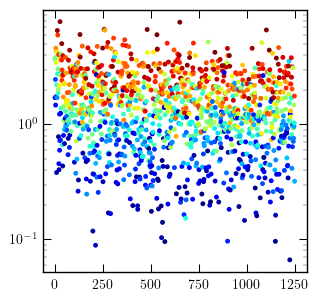

In [38]:
fig, ax = newplot("column")

cmap = plt.get_cmap("jet")

losses = np.array(losses)
training_cs = np.array(training_cs)

ax.scatter(np.arange(len(losses)), losses, c = 1-training_cs[:len(training_cs)], cmap = cmap)
plt.yscale("log")

/tmp/ipykernel_545718/2477288644.py:59: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="Cutoff")


Text(0, 0.5, 'Aux 0')

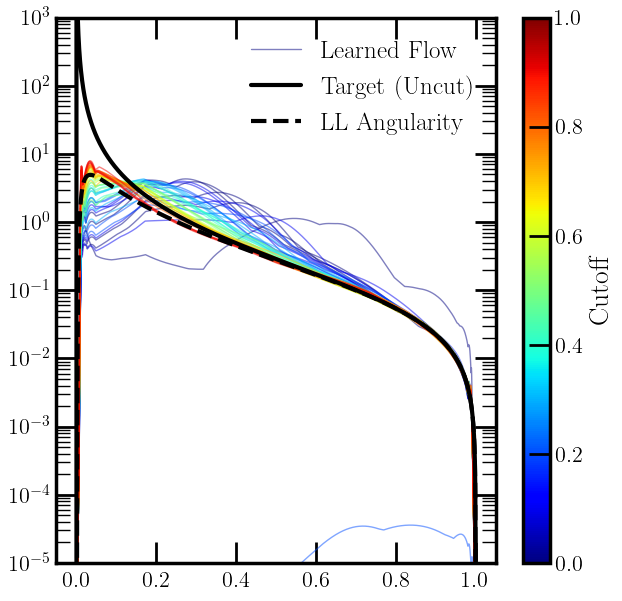

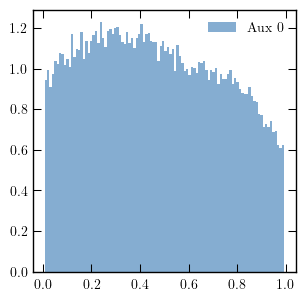

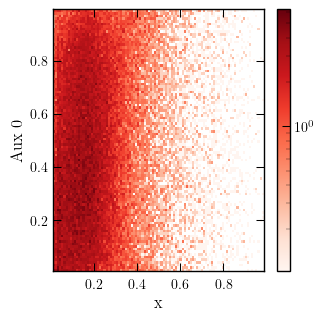

In [46]:
# Plot distribution of xs

fig, ax = newplot("full")
cs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9][::-1]
# cs = [0.5]

DRAW_NF_HIST = False
DRAW_NF_LINES = True
aux_draws = 5


for i in range(len(cs)):


    # Draw hist
    c = torch.tensor((cs[i],))

    if DRAW_NF_HIST:
        samples = sigmoid(flow(c).sample((100000,)))
        x_samples = samples[:,0].detach().numpy()
        aux_samples = samples[:,1:].detach().numpy()

        jet_color = plt.get_cmap("jet")(  i / 10)
        if i == 0:
            label = "Generated Samples"
        else:
            label = None
        ax.hist(x_samples, bins=100, density=True, color = jet_color, alpha = 0.5, label = label, histtype="step")

    if DRAW_NF_LINES:

        for aux_draw in range(aux_draws):
            xs = torch.rand(10000, auxiliary_params + 1) * (x_range[1] - x_range[0]) + x_range[0]
            
            # Sort the first column
            xs = xs[torch.argsort(xs[:,0])]
            xs[:,1] = torch.rand(1) * torch.ones(10000)
            

            logJ = torch.sum(log_abs_det_jacobian_sigmoid(inverse_sigmoid(xs)), axis = 1)
            ys = (flow(c).log_prob(inverse_sigmoid(xs)) + logJ).exp()

            xs = xs[:,0].detach().numpy().flatten()
            ys = np.nan_to_num(ys.detach().numpy().flatten())

            jet_color = plt.get_cmap("jet")( i / 10)
            if i == 0 and aux_draw == 0:
                label = "Learned Flow"
            else:
                label = None

            ax.plot(xs, ys, color = jet_color, lw = 1, alpha = 0.5, label = label)

            ax.vlines(cs[i], 0, target_p(cs[i]), color = jet_color, linestyle = "--", alpha = 0.25, lw = 0.5)



# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=plt.get_cmap("jet_r"), norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
plt.colorbar(sm, label="Cutoff")




# c = torch.tensor((0.5,))
# xs = torch.zeros((10000, auxiliary_params + 1)) + 0.5
# xs[:,0] = torch.linspace(0.001, 0.999, 10000)
# logJ = torch.sum(log_abs_det_jacobian_sigmoid(inverse_sigmoid(xs)), axis = 1)
# ys = (flow(c).log_prob(inverse_sigmoid(xs)) + logJ).exp()

# print(flow(c).log_prob(inverse_sigmoid(xs)))
# print(ys)

# xs = xs[:,0].detach().numpy().flatten()
# ys = np.nan_to_num(ys.detach().numpy().flatten())
# ps = target_p(torch.tensor(xs)).detach().numpy().flatten()
# plt.plot(xs, ys, color = "red", label = "Learned Flow")
# print(ys.mean())

# c = c.detach().numpy()

cutoff = xs > 0.5

plt.plot(xs, target_p(torch.tensor(xs)), color = "Black", label = "Target (Uncut)")
plt.plot(xs, LL_angularity(torch.tensor(xs)), color = "black", linestyle = "--", label = "LL Angularity")

# cutoff_norm = np.trapz(ps * cutoff, xs)
# plt.plot(xs, cutoff * ps , color = "grey", label = rf"Target (Cut at $c$ = {cs[0]})")

plt.legend()

plt.yscale("log")

plt.ylim(1e-5, 1e3)

c = torch.tensor((0.5,))
samples = sigmoid(flow(c).sample((100000,)))
x_samples = samples[:,0].detach().numpy()
aux_samples = samples[:,1:].detach().numpy()


# plot the auxiliary variables
if auxiliary_params > 0:
    fig, ax = newplot("column")
    for i in range(auxiliary_params):
        plt.hist(aux_samples[:,i], bins=100, density=True, alpha = 0.5, label=f"Aux {i}")
        prob = flow(c).log_prob(samples).exp()
        # plt.scatter(aux_samples[:,i], prob.detach().numpy(), color = "red")
    plt.legend()

# correlation between auxiliary variable 1 and x
import matplotlib as mpl
fig, ax = newplot("column")
bar = ax.hist2d(x_samples, aux_samples[:,0], bins=100, density=True, norm=mpl.colors.LogNorm(), cmap="Reds")
plt.colorbar(bar[3])
plt.xlabel("x")
plt.ylabel("Aux 0")



In [236]:
# #  Plot distribution of xs


# samples = flow().sample((100000,)).detach().numpy()
# x_samples = samples[:,0]
# aux_samples = samples[:,1:]

# fig, ax = newplot("column")

# plt.hist(x_samples, bins=100, density=True, color = "red", alpha = 0.5)


# xs = torch.zeros((1000, auxiliary_params + 1))
# xs[:,0] = torch.linspace(-0.5, 1.5, 1000)
# ys = flow().log_prob(xs).exp()

# xs = xs[:,0].detach().numpy().flatten()
# ys = ys.detach().numpy().flatten()
# plt.plot(xs, ys, color = "red")


# plt.plot(xs, target_p(torch.tensor(xs)), color = "blue")

# plt.yscale("log")

# # plot the auxiliary variables
# if auxiliary_params > 0:
#     fig, ax = newplot("column")
#     for i in range(auxiliary_params):
#         plt.hist(aux_samples[:,i], bins=100, density=True, alpha = 0.5, label=f"Aux {i}")
#         plt.plot(xs, ys, color = "red")
#     plt.legend()
